# gan
- gan, cgan
- pix2pix

- 숫자 이미지 생성
- 채색

## cGAN
- Conditional Generative Adversarial Nets (cGAN)은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여,
내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법

![](https://aiffelstaticprd.blob.core.windows.net/media/images/cgan_img.max-800x600.png)

## data import
```
 pip install tensorflow-datasets
    ```

In [1]:
# mnist data set

import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /home/ubuntu/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


ModuleNotFoundError: No module named 'matplotlib'
Failed importing matplotlib.pyplot. This likely means that the dataset requires additional dependencies that have to be manually installed (usually with `pip install matplotlib.pyplot`). See setup.py extras_require.

In [2]:
## data set gan / cgan 용 분리
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1 # 256  1 ~ -1로 값 조정.
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10) # one hot  label< 적용 
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


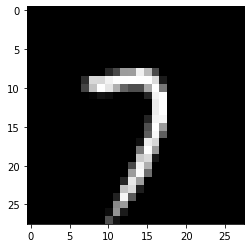

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

# generator

## gan generator

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


## cgan generartor

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


# disicriminator

## gan discriminator

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x) # fc layer 학습 시키기 위해...
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


## cGan disicriminator

- maxout : 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록
- 24-5

### mxaout

- units 차원의 representatoin을 pieces개만큼 만들고 그 중 최댓 값 1개 차원만 출력

In [8]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


- cgan discriminator 는 maxout layer 활용

In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# GAN

## model set
- 찐, 짭 구별을 위해  Binary Cross Entropy를 사용
- adam optimizer이용

- 각 generator / disicirimnator 셋팅

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    



In [11]:
# 노이즈를 100차원으로 설정
#

In [12]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    # 평균이 100인 이미지 사이즈의 랜덤 난수 생성,..........
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

print("✅")

✅


## train

In [13]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.171053171157837, D:0.14335843920707703
[1/10 EPOCHS, 200 ITER] G:2.5605318546295166, D:0.1098170280456543
[1/10 EPOCHS, 300 ITER] G:2.791450023651123, D:0.09674517810344696
[1/10 EPOCHS, 400 ITER] G:2.5023233890533447, D:0.1424439251422882
[2/10 EPOCHS, 100 ITER] G:3.8381576538085938, D:0.1021784320473671
[2/10 EPOCHS, 200 ITER] G:2.517451286315918, D:0.4794543981552124
[2/10 EPOCHS, 300 ITER] G:3.0001983642578125, D:0.21052753925323486
[2/10 EPOCHS, 400 ITER] G:4.748301982879639, D:0.08379179239273071
[3/10 EPOCHS, 100 ITER] G:3.091331720352173, D:0.1919446736574173
[3/10 EPOCHS, 200 ITER] G:3.838405132293701, D:0.11126314103603363
[3/10 EPOCHS, 300 ITER] G:2.379279136657715, D:0.18297871947288513
[3/10 EPOCHS, 400 ITER] G:3.9221415519714355, D:0.12404768168926239
[4/10 EPOCHS, 100 ITER] G:4.492813587188721, D:0.1127006784081459
[4/10 EPOCHS, 200 ITER] G:5.085115432739258, D:0.23113234341144562
[4/10 EPOCHS, 300 ITER] G:4.353507041931152, D:0.02815407514572

## test

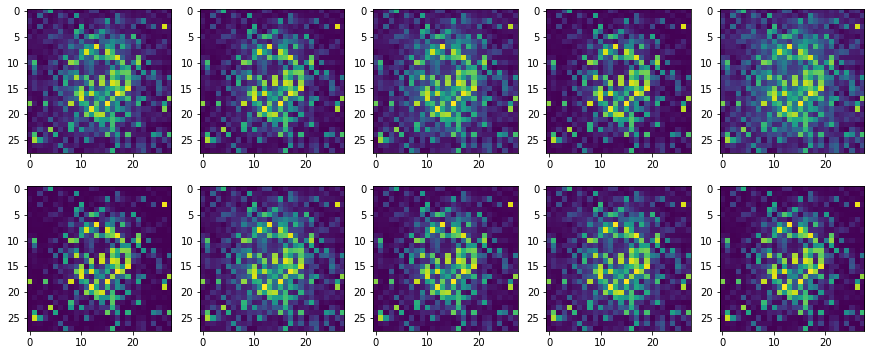

In [14]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## epoch 500  weight

In [16]:
# 500 epch pretrained model upload
! wget https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip

--2020-11-11 18:26:15--  https://aiffelstaticprd.blob.core.windows.net/media/documents/GAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2151851 (2.1M) [application/zip]
Saving to: ‘GAN_500.zip.1’

GAN_500.zip.1       100%[===================>]   2.05M  12.7MB/s    in 0.2s    

2020-11-11 18:26:16 (12.7 MB/s) - ‘GAN_500.zip.1’ saved [2151851/2151851]



In [18]:
import os
weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'
#weight_path ='./GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

ValueError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500: Not found: /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500; No such file or directory

# CGAN

In [ ]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

## epoch 500 weight upload

In [23]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
!unzip CGAN_500.zip

--2020-11-11 18:03:45--  https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2579076 (2.5M) [application/zip]
Saving to: ‘CGAN_500.zip.1’

CGAN_500.zip.1      100%[===================>]   2.46M  15.0MB/s    in 0.2s    

2020-11-11 18:03:45 (15.0 MB/s) - ‘CGAN_500.zip.1’ saved [2579076/2579076]

Archive:  CGAN_500.zip
  inflating: CGAN_500.index          
  inflating: CGAN_500.data-00001-of-00002  
  inflating: CGAN_500.data-00000-of-00002  


In [24]:
number =  7 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN/CGAN_500: Not found: /home/ubuntu/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/CGAN; No such file or directory

# pix2pix_ generator
   
   
- conv 레이어를 통해 이미지 다운 샘플링 representation 학습 -bottleneck
- 다시 conv 레리어로 upsampling , 입력 이미지와 동일한 크기.로 생성.



![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator.max-800x600.png)

## u-net

- skip connection
- 인토더의 상위 레이어의 결과를 decoder로 연결하여
- 비교적 선명한 결과를 얻을tn
![](https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_generator_unet.max-800x600.png)

## PIX2PIX DISCRIMINATOR
- CONV LAYER   
![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/dcgan_d.png)
![](https://aiffelstaticprd.blob.core.windows.net/media/images/patchgan.max-800x600.png)


- 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출
   
   
- 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN
- 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것

# 실습 채색

## Sketch2Pokemon DATA SET DONWLOAD
- https://www.kaggle.com/norod78/sketch2pokemon


In [25]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
!unzip sketch2pokemon.zip

--2020-11-11 18:03:46--  https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66732281 (64M) [application/zip]
Saving to: ‘sketch2pokemon.zip’

sketch2pokemon.zip   75%[==============>     ]  48.29M  12.6MB/s    eta 2s     ^C
Archive:  sketch2pokemon.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of sketch2pokemon.zip or
        sketch2pokemon.zip.zip, and cannot find sketch2pokemon.zip.ZIP, period.


In [26]:
!ls

01-basic-Copy1.ipynb	      CGAN_500.zip
01-basic.ipynb		      CGAN_500.zip.1
02-prj.ipynb		      GAN_500.zip
CGAN_500.data-00000-of-00002  pokemon_pix2pix_dataset
CGAN_500.data-00001-of-00002  sketch2pokemon.zip
CGAN_500.index


## DATA SET IMPORT

In [1]:
import os
#+'/aiffel/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img/GAN_500/GAN_500'

data_path =  './pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


In [2]:
!pwd

/home/ubuntu/lsg/AIFFEL_LSG/lms/01-EXPLORATION/E24-gan_img


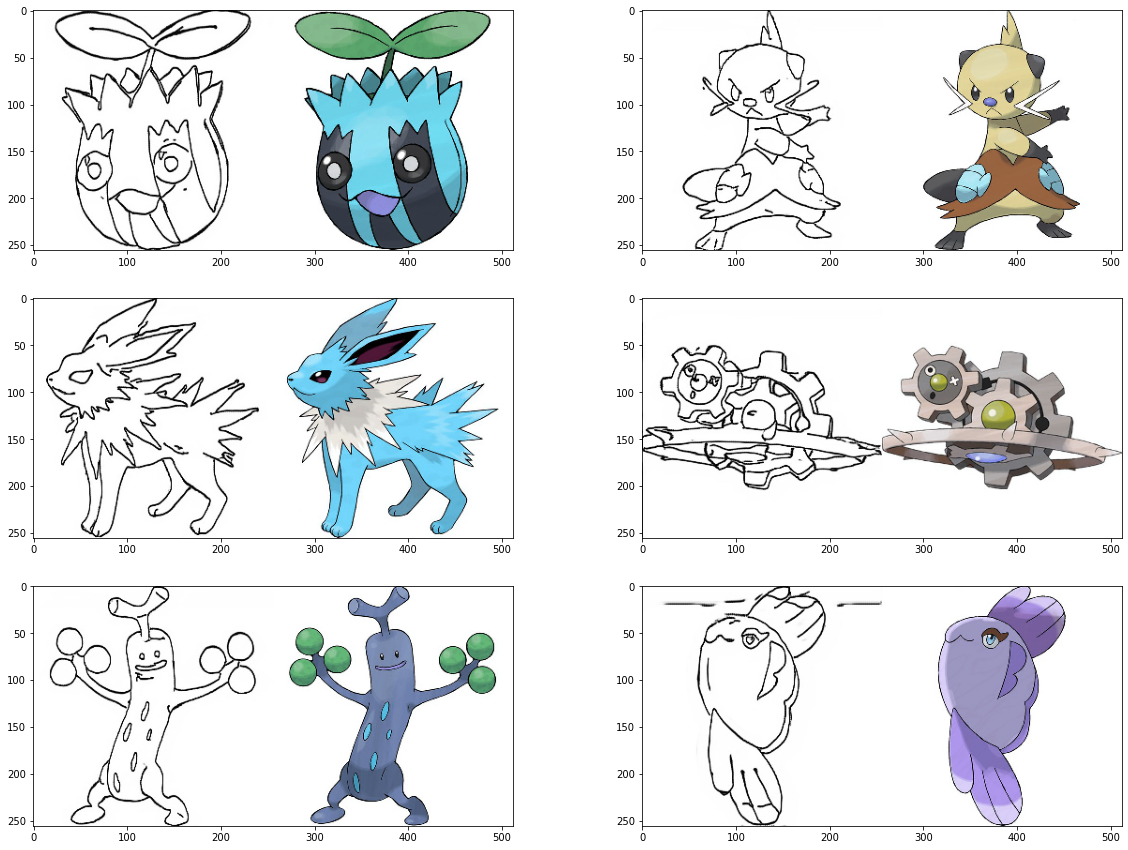

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## IMG 처리

In [4]:
# 이미지 사이즈

In [5]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## IMG 분리

In [6]:
# 이미지 분할
# 반타작

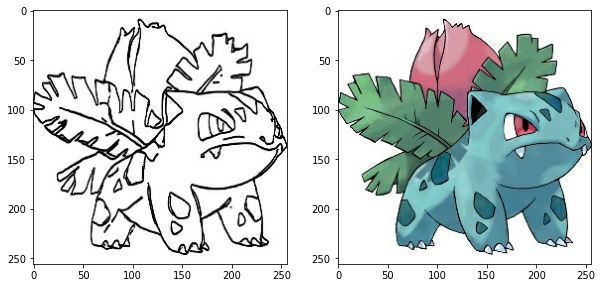

In [7]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## AUGMENTATION 

In [8]:
# 자르고 위아래, 왼좌 전환, 

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


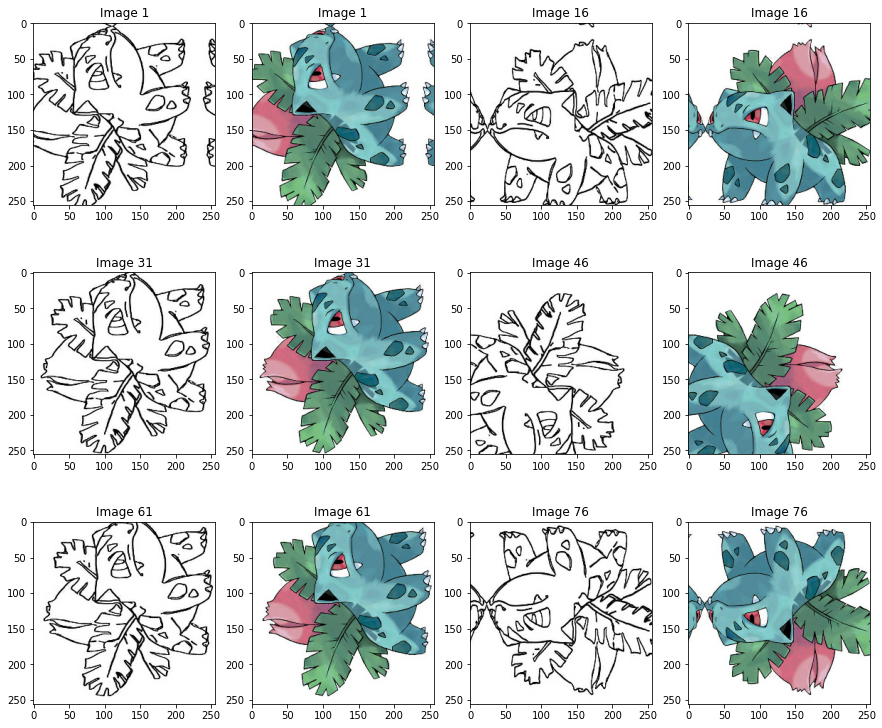

In [9]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 15

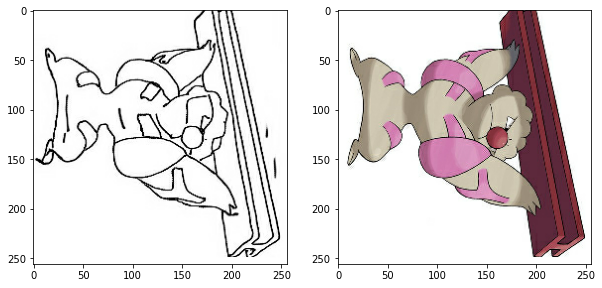

In [10]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

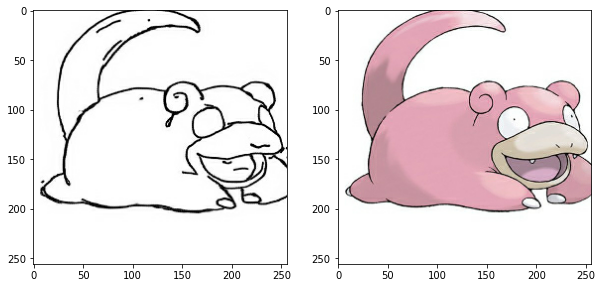

In [11]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## architecture

![](https://aiffelstaticprd.blob.core.windows.net/media/original_images/paper_g.png)

![](https://aiffelstaticprd.blob.core.windows.net/media/images/refer_g.max-800x600.png)

## generator_block ()


```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
    dilation_rate=(1, 1), groups=1, activation=None, use_bias=True,
    kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
    kernel_constraint=None, bias_constraint=None, **kwargs
)
```

In [12]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn: # encoder 첫번째 레이어 배치 놈 안씀.
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [13]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512] # 필터(커널) 개수 리스트)
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0: # 첫번째 레이어 배치놈 사용 안함(feat. 논문
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape) # is used to instantiate a Keras tensor
                       
        return Model(inputs, self.call(inputs)).summary()



In [14]:
Encoder().get_summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)        

## decoder_bloack(

In [15]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [16]:
Decoder().get_summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)      

## encoder+ decoder

In [17]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## unet, (skip connection 추가)

### unet - generator

In [18]:
# 요건 그대로임

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [19]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1] # 
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [20]:
UNetGenerator().get_summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
_______________________________________________________________________________________

### unet - discriminator

In [21]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [22]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [23]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [24]:
Discriminator().get_summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]  

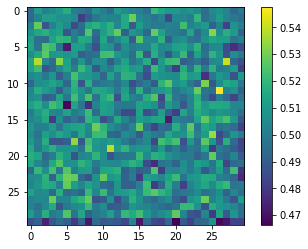

In [25]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## train


In [26]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [27]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [28]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [ ]:
EPOCHS = 2000

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:9.5082                     
L1_loss:0.1832                     
Discriminator_loss:0.0055

EPOCH[1] - STEP[20]                     
Generator_loss:0.3496                     
L1_loss:0.1537                     
Discriminator_loss:1.9393

EPOCH[1] - STEP[30]                     
Generator_loss:1.4177                     
L1_loss:0.1507                     
Discriminator_loss:0.5715

EPOCH[1] - STEP[40]                     
Generator_loss:7.0700                     
L1_loss:0.1751                     
Discriminator_loss:0.1491

EPOCH[1] - STEP[50]                     
Generator_loss:4.1264                     
L1_loss:0.1502                     
Discriminator_loss:0.3542

EPOCH[1] - STEP[60]                     
Generator_loss:9.6387                     
L1_loss:0.1390                     
Discriminator_loss:0.0759

EPOCH[1] - STEP[70]                     
Generator_loss:5.2727                     
L1_loss:0.1527                    

EPOCH[3] - STEP[170]                     
Generator_loss:6.8693                     
L1_loss:0.1557                     
Discriminator_loss:0.0026

EPOCH[3] - STEP[180]                     
Generator_loss:5.0565                     
L1_loss:0.1675                     
Discriminator_loss:0.0152

EPOCH[3] - STEP[190]                     
Generator_loss:6.8808                     
L1_loss:0.1569                     
Discriminator_loss:0.0073

EPOCH[3] - STEP[200]                     
Generator_loss:4.4374                     
L1_loss:0.1786                     
Discriminator_loss:0.0258

EPOCH[4] - STEP[10]                     
Generator_loss:6.2730                     
L1_loss:0.2093                     
Discriminator_loss:0.0118

EPOCH[4] - STEP[20]                     
Generator_loss:7.7894                     
L1_loss:0.1619                     
Discriminator_loss:0.2021

EPOCH[4] - STEP[30]                     
Generator_loss:8.0855                     
L1_loss:0.1580                

EPOCH[6] - STEP[130]                     
Generator_loss:8.2121                     
L1_loss:0.1542                     
Discriminator_loss:0.2147

EPOCH[6] - STEP[140]                     
Generator_loss:6.0204                     
L1_loss:0.1714                     
Discriminator_loss:0.0081

EPOCH[6] - STEP[150]                     
Generator_loss:7.3938                     
L1_loss:0.1694                     
Discriminator_loss:1.2629

EPOCH[6] - STEP[160]                     
Generator_loss:2.1837                     
L1_loss:0.1865                     
Discriminator_loss:0.3931

EPOCH[6] - STEP[170]                     
Generator_loss:7.6988                     
L1_loss:0.1633                     
Discriminator_loss:0.0024

EPOCH[6] - STEP[180]                     
Generator_loss:6.8971                     
L1_loss:0.1441                     
Discriminator_loss:0.0042

EPOCH[6] - STEP[190]                     
Generator_loss:4.1023                     
L1_loss:0.1401             

EPOCH[9] - STEP[90]                     
Generator_loss:11.9376                     
L1_loss:0.1717                     
Discriminator_loss:0.0536

EPOCH[9] - STEP[100]                     
Generator_loss:7.2639                     
L1_loss:0.1731                     
Discriminator_loss:0.0083

EPOCH[9] - STEP[110]                     
Generator_loss:4.9425                     
L1_loss:0.1703                     
Discriminator_loss:0.0270

EPOCH[9] - STEP[120]                     
Generator_loss:6.6086                     
L1_loss:0.1739                     
Discriminator_loss:0.0450

EPOCH[9] - STEP[130]                     
Generator_loss:1.6991                     
L1_loss:0.1418                     
Discriminator_loss:0.3712

EPOCH[9] - STEP[140]                     
Generator_loss:3.2831                     
L1_loss:0.1513                     
Discriminator_loss:0.1488

EPOCH[9] - STEP[150]                     
Generator_loss:8.1443                     
L1_loss:0.1894             

EPOCH[12] - STEP[50]                     
Generator_loss:6.0636                     
L1_loss:0.1620                     
Discriminator_loss:0.0278

EPOCH[12] - STEP[60]                     
Generator_loss:3.8558                     
L1_loss:0.1769                     
Discriminator_loss:0.0699

EPOCH[12] - STEP[70]                     
Generator_loss:6.2233                     
L1_loss:0.1561                     
Discriminator_loss:0.0110

EPOCH[12] - STEP[80]                     
Generator_loss:5.5504                     
L1_loss:0.1737                     
Discriminator_loss:0.0101

EPOCH[12] - STEP[90]                     
Generator_loss:7.8229                     
L1_loss:0.1433                     
Discriminator_loss:0.0035

EPOCH[12] - STEP[100]                     
Generator_loss:3.4308                     
L1_loss:0.1454                     
Discriminator_loss:0.0852

EPOCH[12] - STEP[110]                     
Generator_loss:2.9175                     
L1_loss:0.1877           

EPOCH[15] - STEP[10]                     
Generator_loss:5.1229                     
L1_loss:0.1624                     
Discriminator_loss:0.0117

EPOCH[15] - STEP[20]                     
Generator_loss:5.2575                     
L1_loss:0.1672                     
Discriminator_loss:0.0837

EPOCH[15] - STEP[30]                     
Generator_loss:5.7014                     
L1_loss:0.1655                     
Discriminator_loss:0.0087

EPOCH[15] - STEP[40]                     
Generator_loss:9.7910                     
L1_loss:0.1401                     
Discriminator_loss:0.0034

EPOCH[15] - STEP[50]                     
Generator_loss:8.4994                     
L1_loss:0.1701                     
Discriminator_loss:0.0007

EPOCH[15] - STEP[60]                     
Generator_loss:7.2808                     
L1_loss:0.1628                     
Discriminator_loss:0.0017

EPOCH[15] - STEP[70]                     
Generator_loss:8.0922                     
L1_loss:0.2017             

EPOCH[17] - STEP[170]                     
Generator_loss:5.7518                     
L1_loss:0.1831                     
Discriminator_loss:0.0081

EPOCH[17] - STEP[180]                     
Generator_loss:4.9085                     
L1_loss:0.1292                     
Discriminator_loss:0.0285

EPOCH[17] - STEP[190]                     
Generator_loss:7.2186                     
L1_loss:0.1778                     
Discriminator_loss:0.0039

EPOCH[17] - STEP[200]                     
Generator_loss:6.7593                     
L1_loss:0.1497                     
Discriminator_loss:0.0166

EPOCH[18] - STEP[10]                     
Generator_loss:6.5471                     
L1_loss:0.1185                     
Discriminator_loss:0.1664

EPOCH[18] - STEP[20]                     
Generator_loss:6.7136                     
L1_loss:0.1632                     
Discriminator_loss:0.0034

EPOCH[18] - STEP[30]                     
Generator_loss:7.1054                     
L1_loss:0.1872         

EPOCH[20] - STEP[130]                     
Generator_loss:6.8056                     
L1_loss:0.1663                     
Discriminator_loss:0.0078

EPOCH[20] - STEP[140]                     
Generator_loss:3.3454                     
L1_loss:0.1310                     
Discriminator_loss:0.0663

EPOCH[20] - STEP[150]                     
Generator_loss:7.3026                     
L1_loss:0.1836                     
Discriminator_loss:0.0018

EPOCH[20] - STEP[160]                     
Generator_loss:6.2671                     
L1_loss:0.1873                     
Discriminator_loss:0.0212

EPOCH[20] - STEP[170]                     
Generator_loss:8.7771                     
L1_loss:0.1582                     
Discriminator_loss:0.1811

EPOCH[20] - STEP[180]                     
Generator_loss:4.6713                     
L1_loss:0.1352                     
Discriminator_loss:0.0217

EPOCH[20] - STEP[190]                     
Generator_loss:4.6349                     
L1_loss:0.1237      

EPOCH[23] - STEP[90]                     
Generator_loss:8.1050                     
L1_loss:0.1646                     
Discriminator_loss:0.0007

EPOCH[23] - STEP[100]                     
Generator_loss:4.4202                     
L1_loss:0.1956                     
Discriminator_loss:0.0339

EPOCH[23] - STEP[110]                     
Generator_loss:7.0276                     
L1_loss:0.1607                     
Discriminator_loss:0.0023

EPOCH[23] - STEP[120]                     
Generator_loss:4.6698                     
L1_loss:0.1435                     
Discriminator_loss:0.0181

EPOCH[23] - STEP[130]                     
Generator_loss:8.5614                     
L1_loss:0.1755                     
Discriminator_loss:0.0039

EPOCH[23] - STEP[140]                     
Generator_loss:5.5412                     
L1_loss:0.1845                     
Discriminator_loss:0.0913

EPOCH[23] - STEP[150]                     
Generator_loss:8.4449                     
L1_loss:0.1872       

EPOCH[26] - STEP[50]                     
Generator_loss:8.7865                     
L1_loss:0.1571                     
Discriminator_loss:0.0037

EPOCH[26] - STEP[60]                     
Generator_loss:9.1200                     
L1_loss:0.1321                     
Discriminator_loss:0.0030

EPOCH[26] - STEP[70]                     
Generator_loss:6.1882                     
L1_loss:0.1916                     
Discriminator_loss:0.0133

EPOCH[26] - STEP[80]                     
Generator_loss:3.8378                     
L1_loss:0.1621                     
Discriminator_loss:0.0813

EPOCH[26] - STEP[90]                     
Generator_loss:6.7162                     
L1_loss:0.1668                     
Discriminator_loss:0.0098

EPOCH[26] - STEP[100]                     
Generator_loss:7.0147                     
L1_loss:0.1911                     
Discriminator_loss:0.0024

EPOCH[26] - STEP[110]                     
Generator_loss:5.6664                     
L1_loss:0.1424           

EPOCH[29] - STEP[10]                     
Generator_loss:8.5049                     
L1_loss:0.1397                     
Discriminator_loss:0.0012

EPOCH[29] - STEP[20]                     
Generator_loss:9.0660                     
L1_loss:0.1334                     
Discriminator_loss:0.2717

EPOCH[29] - STEP[30]                     
Generator_loss:9.1995                     
L1_loss:0.1346                     
Discriminator_loss:0.0032

EPOCH[29] - STEP[40]                     
Generator_loss:4.8152                     
L1_loss:0.1390                     
Discriminator_loss:0.0315

EPOCH[29] - STEP[50]                     
Generator_loss:8.9810                     
L1_loss:0.1340                     
Discriminator_loss:0.0575

EPOCH[29] - STEP[60]                     
Generator_loss:6.4435                     
L1_loss:0.1507                     
Discriminator_loss:0.0117

EPOCH[29] - STEP[70]                     
Generator_loss:4.0919                     
L1_loss:0.1402             

EPOCH[31] - STEP[170]                     
Generator_loss:8.0681                     
L1_loss:0.1946                     
Discriminator_loss:0.0016

EPOCH[31] - STEP[180]                     
Generator_loss:7.9501                     
L1_loss:0.1593                     
Discriminator_loss:0.0055

EPOCH[31] - STEP[190]                     
Generator_loss:6.8886                     
L1_loss:0.1619                     
Discriminator_loss:0.0037

EPOCH[31] - STEP[200]                     
Generator_loss:10.5461                     
L1_loss:0.1621                     
Discriminator_loss:0.0046

EPOCH[32] - STEP[10]                     
Generator_loss:7.6192                     
L1_loss:0.1528                     
Discriminator_loss:0.0819

EPOCH[32] - STEP[20]                     
Generator_loss:3.5294                     
L1_loss:0.1650                     
Discriminator_loss:0.0609

EPOCH[32] - STEP[30]                     
Generator_loss:5.8130                     
L1_loss:0.1592        

EPOCH[34] - STEP[130]                     
Generator_loss:8.6499                     
L1_loss:0.2419                     
Discriminator_loss:0.0038

EPOCH[34] - STEP[140]                     
Generator_loss:5.7888                     
L1_loss:0.1635                     
Discriminator_loss:0.0095

EPOCH[34] - STEP[150]                     
Generator_loss:8.2548                     
L1_loss:0.1563                     
Discriminator_loss:0.0294

EPOCH[34] - STEP[160]                     
Generator_loss:11.2215                     
L1_loss:0.1585                     
Discriminator_loss:0.2769

EPOCH[34] - STEP[170]                     
Generator_loss:0.9499                     
L1_loss:0.1865                     
Discriminator_loss:0.8670

EPOCH[34] - STEP[180]                     
Generator_loss:3.7999                     
L1_loss:0.1669                     
Discriminator_loss:0.0696

EPOCH[34] - STEP[190]                     
Generator_loss:8.2775                     
L1_loss:0.1714     

EPOCH[37] - STEP[90]                     
Generator_loss:2.1510                     
L1_loss:0.1708                     
Discriminator_loss:0.4592

EPOCH[37] - STEP[100]                     
Generator_loss:4.5109                     
L1_loss:0.1631                     
Discriminator_loss:0.0338

EPOCH[37] - STEP[110]                     
Generator_loss:5.2186                     
L1_loss:0.1392                     
Discriminator_loss:0.0212

EPOCH[37] - STEP[120]                     
Generator_loss:4.8517                     
L1_loss:0.1829                     
Discriminator_loss:0.0193

EPOCH[37] - STEP[130]                     
Generator_loss:1.8897                     
L1_loss:0.1554                     
Discriminator_loss:0.3497

EPOCH[37] - STEP[140]                     
Generator_loss:6.1872                     
L1_loss:0.1324                     
Discriminator_loss:0.0144

EPOCH[37] - STEP[150]                     
Generator_loss:8.6709                     
L1_loss:0.1601       

EPOCH[40] - STEP[50]                     
Generator_loss:4.3565                     
L1_loss:0.1906                     
Discriminator_loss:0.0390

EPOCH[40] - STEP[60]                     
Generator_loss:0.0899                     
L1_loss:0.1629                     
Discriminator_loss:3.4711

EPOCH[40] - STEP[70]                     
Generator_loss:5.4040                     
L1_loss:0.1582                     
Discriminator_loss:0.0145

EPOCH[40] - STEP[80]                     
Generator_loss:10.0476                     
L1_loss:0.1727                     
Discriminator_loss:0.0056

EPOCH[40] - STEP[90]                     
Generator_loss:6.7600                     
L1_loss:0.1825                     
Discriminator_loss:0.0058

EPOCH[40] - STEP[100]                     
Generator_loss:2.9228                     
L1_loss:0.1573                     
Discriminator_loss:0.1104

EPOCH[40] - STEP[110]                     
Generator_loss:7.4467                     
L1_loss:0.1388          

EPOCH[43] - STEP[10]                     
Generator_loss:5.3684                     
L1_loss:0.1764                     
Discriminator_loss:0.0104

EPOCH[43] - STEP[20]                     
Generator_loss:6.5221                     
L1_loss:0.1418                     
Discriminator_loss:0.0040

EPOCH[43] - STEP[30]                     
Generator_loss:8.2287                     
L1_loss:0.1657                     
Discriminator_loss:0.0039

EPOCH[43] - STEP[40]                     
Generator_loss:8.4493                     
L1_loss:0.1847                     
Discriminator_loss:0.0124

EPOCH[43] - STEP[50]                     
Generator_loss:3.7994                     
L1_loss:0.1844                     
Discriminator_loss:0.0569

EPOCH[43] - STEP[60]                     
Generator_loss:1.3399                     
L1_loss:0.1516                     
Discriminator_loss:0.5426

EPOCH[43] - STEP[70]                     
Generator_loss:5.0215                     
L1_loss:0.1449             

EPOCH[45] - STEP[170]                     
Generator_loss:6.1171                     
L1_loss:0.1351                     
Discriminator_loss:0.0067

EPOCH[45] - STEP[180]                     
Generator_loss:6.2435                     
L1_loss:0.1957                     
Discriminator_loss:0.0052

EPOCH[45] - STEP[190]                     
Generator_loss:9.2639                     
L1_loss:0.1404                     
Discriminator_loss:0.0042

EPOCH[45] - STEP[200]                     
Generator_loss:8.7906                     
L1_loss:0.1540                     
Discriminator_loss:0.0258

EPOCH[46] - STEP[10]                     
Generator_loss:7.7285                     
L1_loss:0.1450                     
Discriminator_loss:0.0204

EPOCH[46] - STEP[20]                     
Generator_loss:6.2695                     
L1_loss:0.1482                     
Discriminator_loss:0.0114

EPOCH[46] - STEP[30]                     
Generator_loss:6.7056                     
L1_loss:0.1528         

EPOCH[48] - STEP[130]                     
Generator_loss:6.8884                     
L1_loss:0.1348                     
Discriminator_loss:0.0263

EPOCH[48] - STEP[140]                     
Generator_loss:7.3177                     
L1_loss:0.1624                     
Discriminator_loss:0.0080

EPOCH[48] - STEP[150]                     
Generator_loss:8.9231                     
L1_loss:0.1767                     
Discriminator_loss:0.0288

EPOCH[48] - STEP[160]                     
Generator_loss:5.9008                     
L1_loss:0.1683                     
Discriminator_loss:0.0181

EPOCH[48] - STEP[170]                     
Generator_loss:6.0055                     
L1_loss:0.1506                     
Discriminator_loss:0.0164

EPOCH[48] - STEP[180]                     
Generator_loss:6.6380                     
L1_loss:0.1829                     
Discriminator_loss:0.0363

EPOCH[48] - STEP[190]                     
Generator_loss:8.2119                     
L1_loss:0.1725      

EPOCH[51] - STEP[90]                     
Generator_loss:7.6655                     
L1_loss:0.1484                     
Discriminator_loss:0.0155

EPOCH[51] - STEP[100]                     
Generator_loss:6.2397                     
L1_loss:0.1858                     
Discriminator_loss:0.0049

EPOCH[51] - STEP[110]                     
Generator_loss:4.8838                     
L1_loss:0.1501                     
Discriminator_loss:0.0182

EPOCH[51] - STEP[120]                     
Generator_loss:6.0126                     
L1_loss:0.2087                     
Discriminator_loss:0.0086

EPOCH[51] - STEP[130]                     
Generator_loss:9.7208                     
L1_loss:0.1639                     
Discriminator_loss:0.0014

EPOCH[51] - STEP[140]                     
Generator_loss:4.4464                     
L1_loss:0.1785                     
Discriminator_loss:0.0431

EPOCH[51] - STEP[150]                     
Generator_loss:4.7770                     
L1_loss:0.1387       

EPOCH[54] - STEP[50]                     
Generator_loss:7.7408                     
L1_loss:0.1736                     
Discriminator_loss:0.8160

EPOCH[54] - STEP[60]                     
Generator_loss:6.1842                     
L1_loss:0.1538                     
Discriminator_loss:0.3065

EPOCH[54] - STEP[70]                     
Generator_loss:5.4562                     
L1_loss:0.1551                     
Discriminator_loss:0.0670

EPOCH[54] - STEP[80]                     
Generator_loss:5.7233                     
L1_loss:0.1637                     
Discriminator_loss:0.0081

EPOCH[54] - STEP[90]                     
Generator_loss:4.8004                     
L1_loss:0.1366                     
Discriminator_loss:0.0305

EPOCH[54] - STEP[100]                     
Generator_loss:5.5352                     
L1_loss:0.1611                     
Discriminator_loss:0.0091

EPOCH[54] - STEP[110]                     
Generator_loss:5.2549                     
L1_loss:0.1427           

EPOCH[57] - STEP[10]                     
Generator_loss:3.5834                     
L1_loss:0.1439                     
Discriminator_loss:0.0564

EPOCH[57] - STEP[20]                     
Generator_loss:3.3961                     
L1_loss:0.1407                     
Discriminator_loss:0.1044

EPOCH[57] - STEP[30]                     
Generator_loss:4.4888                     
L1_loss:0.1619                     
Discriminator_loss:0.0349

EPOCH[57] - STEP[40]                     
Generator_loss:5.9070                     
L1_loss:0.1625                     
Discriminator_loss:0.0092

EPOCH[57] - STEP[50]                     
Generator_loss:8.4029                     
L1_loss:0.1697                     
Discriminator_loss:0.0037

EPOCH[57] - STEP[60]                     
Generator_loss:6.3314                     
L1_loss:0.1709                     
Discriminator_loss:0.0148

EPOCH[57] - STEP[70]                     
Generator_loss:6.4258                     
L1_loss:0.1701             

EPOCH[59] - STEP[170]                     
Generator_loss:4.6801                     
L1_loss:0.1495                     
Discriminator_loss:0.0303

EPOCH[59] - STEP[180]                     
Generator_loss:6.1660                     
L1_loss:0.1573                     
Discriminator_loss:0.0061

EPOCH[59] - STEP[190]                     
Generator_loss:3.2454                     
L1_loss:0.1860                     
Discriminator_loss:0.1435

EPOCH[59] - STEP[200]                     
Generator_loss:4.6725                     
L1_loss:0.1311                     
Discriminator_loss:0.0204

EPOCH[60] - STEP[10]                     
Generator_loss:7.5506                     
L1_loss:0.1422                     
Discriminator_loss:0.0161

EPOCH[60] - STEP[20]                     
Generator_loss:6.6567                     
L1_loss:0.1813                     
Discriminator_loss:0.0044

EPOCH[60] - STEP[30]                     
Generator_loss:8.2116                     
L1_loss:0.1393         

EPOCH[62] - STEP[130]                     
Generator_loss:5.8247                     
L1_loss:0.1377                     
Discriminator_loss:0.0561

EPOCH[62] - STEP[140]                     
Generator_loss:6.6212                     
L1_loss:0.1545                     
Discriminator_loss:0.0103

EPOCH[62] - STEP[150]                     
Generator_loss:10.1562                     
L1_loss:0.1817                     
Discriminator_loss:0.0016

EPOCH[62] - STEP[160]                     
Generator_loss:8.9611                     
L1_loss:0.1683                     
Discriminator_loss:0.0071

EPOCH[62] - STEP[170]                     
Generator_loss:7.6687                     
L1_loss:0.1872                     
Discriminator_loss:0.0016

EPOCH[62] - STEP[180]                     
Generator_loss:10.1746                     
L1_loss:0.1727                     
Discriminator_loss:0.0002

EPOCH[62] - STEP[190]                     
Generator_loss:7.2690                     
L1_loss:0.1478    

EPOCH[65] - STEP[90]                     
Generator_loss:4.2755                     
L1_loss:0.1681                     
Discriminator_loss:0.1795

EPOCH[65] - STEP[100]                     
Generator_loss:7.4382                     
L1_loss:0.1598                     
Discriminator_loss:0.0023

EPOCH[65] - STEP[110]                     
Generator_loss:3.3937                     
L1_loss:0.1521                     
Discriminator_loss:0.0959

EPOCH[65] - STEP[120]                     
Generator_loss:7.8902                     
L1_loss:0.1625                     
Discriminator_loss:0.0032

EPOCH[65] - STEP[130]                     
Generator_loss:7.8617                     
L1_loss:0.1672                     
Discriminator_loss:0.1750

EPOCH[65] - STEP[140]                     
Generator_loss:6.5766                     
L1_loss:0.1558                     
Discriminator_loss:0.0076

EPOCH[65] - STEP[150]                     
Generator_loss:5.9444                     
L1_loss:0.1447       

EPOCH[68] - STEP[50]                     
Generator_loss:8.0810                     
L1_loss:0.1466                     
Discriminator_loss:0.6932

EPOCH[68] - STEP[60]                     
Generator_loss:7.9374                     
L1_loss:0.1776                     
Discriminator_loss:0.0015

EPOCH[68] - STEP[70]                     
Generator_loss:3.0848                     
L1_loss:0.1408                     
Discriminator_loss:0.1109

EPOCH[68] - STEP[80]                     
Generator_loss:3.4545                     
L1_loss:0.1558                     
Discriminator_loss:0.1476

EPOCH[68] - STEP[90]                     
Generator_loss:6.7833                     
L1_loss:0.1613                     
Discriminator_loss:0.0046

EPOCH[68] - STEP[100]                     
Generator_loss:3.5103                     
L1_loss:0.1463                     
Discriminator_loss:0.0916

EPOCH[68] - STEP[110]                     
Generator_loss:5.9245                     
L1_loss:0.1446           

EPOCH[71] - STEP[10]                     
Generator_loss:8.7017                     
L1_loss:0.1595                     
Discriminator_loss:0.0173

EPOCH[71] - STEP[20]                     
Generator_loss:4.7221                     
L1_loss:0.1325                     
Discriminator_loss:0.0232

EPOCH[71] - STEP[30]                     
Generator_loss:10.6058                     
L1_loss:0.1511                     
Discriminator_loss:1.0370

EPOCH[71] - STEP[40]                     
Generator_loss:7.1484                     
L1_loss:0.1596                     
Discriminator_loss:0.0410

EPOCH[71] - STEP[50]                     
Generator_loss:12.2529                     
L1_loss:0.2038                     
Discriminator_loss:0.0684

EPOCH[71] - STEP[60]                     
Generator_loss:5.8588                     
L1_loss:0.1450                     
Discriminator_loss:0.3610

EPOCH[71] - STEP[70]                     
Generator_loss:0.7807                     
L1_loss:0.1603           

EPOCH[73] - STEP[170]                     
Generator_loss:9.1967                     
L1_loss:0.1638                     
Discriminator_loss:0.0074

EPOCH[73] - STEP[180]                     
Generator_loss:6.8149                     
L1_loss:0.1593                     
Discriminator_loss:0.0214

EPOCH[73] - STEP[190]                     
Generator_loss:6.4229                     
L1_loss:0.1560                     
Discriminator_loss:0.0087

EPOCH[73] - STEP[200]                     
Generator_loss:8.1704                     
L1_loss:0.1484                     
Discriminator_loss:0.0020

EPOCH[74] - STEP[10]                     
Generator_loss:5.8172                     
L1_loss:0.1638                     
Discriminator_loss:0.0078

EPOCH[74] - STEP[20]                     
Generator_loss:6.7969                     
L1_loss:0.1441                     
Discriminator_loss:0.0026

EPOCH[74] - STEP[30]                     
Generator_loss:3.5188                     
L1_loss:0.1410         

EPOCH[76] - STEP[130]                     
Generator_loss:5.1594                     
L1_loss:0.1610                     
Discriminator_loss:0.0347

EPOCH[76] - STEP[140]                     
Generator_loss:2.3410                     
L1_loss:0.1667                     
Discriminator_loss:0.2050

EPOCH[76] - STEP[150]                     
Generator_loss:10.6401                     
L1_loss:0.1712                     
Discriminator_loss:0.2426

EPOCH[76] - STEP[160]                     
Generator_loss:8.3458                     
L1_loss:0.1217                     
Discriminator_loss:0.1120

EPOCH[76] - STEP[170]                     
Generator_loss:12.4440                     
L1_loss:0.1879                     
Discriminator_loss:0.4531

EPOCH[76] - STEP[180]                     
Generator_loss:7.8334                     
L1_loss:0.1335                     
Discriminator_loss:0.0035

EPOCH[76] - STEP[190]                     
Generator_loss:8.4127                     
L1_loss:0.1585    

EPOCH[79] - STEP[90]                     
Generator_loss:9.0159                     
L1_loss:0.1405                     
Discriminator_loss:0.0120

EPOCH[79] - STEP[100]                     
Generator_loss:10.0376                     
L1_loss:0.1693                     
Discriminator_loss:0.0006

EPOCH[79] - STEP[110]                     
Generator_loss:8.7654                     
L1_loss:0.1401                     
Discriminator_loss:0.0033

EPOCH[79] - STEP[120]                     
Generator_loss:7.9662                     
L1_loss:0.1690                     
Discriminator_loss:0.0051

EPOCH[79] - STEP[130]                     
Generator_loss:6.8803                     
L1_loss:0.1360                     
Discriminator_loss:0.0054

EPOCH[79] - STEP[140]                     
Generator_loss:5.0292                     
L1_loss:0.1608                     
Discriminator_loss:0.0159

EPOCH[79] - STEP[150]                     
Generator_loss:2.8820                     
L1_loss:0.1397      

EPOCH[82] - STEP[50]                     
Generator_loss:4.6274                     
L1_loss:0.1534                     
Discriminator_loss:0.0213

EPOCH[82] - STEP[60]                     
Generator_loss:3.9973                     
L1_loss:0.1802                     
Discriminator_loss:0.0571

EPOCH[82] - STEP[70]                     
Generator_loss:9.9422                     
L1_loss:0.1854                     
Discriminator_loss:0.0005

EPOCH[82] - STEP[80]                     
Generator_loss:4.5100                     
L1_loss:0.1982                     
Discriminator_loss:0.0438

EPOCH[82] - STEP[90]                     
Generator_loss:0.7031                     
L1_loss:0.1606                     
Discriminator_loss:1.4039

EPOCH[82] - STEP[100]                     
Generator_loss:1.3577                     
L1_loss:0.1540                     
Discriminator_loss:0.6883

EPOCH[82] - STEP[110]                     
Generator_loss:3.7631                     
L1_loss:0.1421           

EPOCH[85] - STEP[10]                     
Generator_loss:7.1593                     
L1_loss:0.1696                     
Discriminator_loss:0.0101

EPOCH[85] - STEP[20]                     
Generator_loss:10.3906                     
L1_loss:0.1567                     
Discriminator_loss:0.0026

EPOCH[85] - STEP[30]                     
Generator_loss:8.8632                     
L1_loss:0.1856                     
Discriminator_loss:0.0004

EPOCH[85] - STEP[40]                     
Generator_loss:6.1687                     
L1_loss:0.1587                     
Discriminator_loss:0.0052

EPOCH[85] - STEP[50]                     
Generator_loss:8.1321                     
L1_loss:0.2050                     
Discriminator_loss:0.0014

EPOCH[85] - STEP[60]                     
Generator_loss:10.8606                     
L1_loss:0.1776                     
Discriminator_loss:0.0007

EPOCH[85] - STEP[70]                     
Generator_loss:5.1779                     
L1_loss:0.1369           

EPOCH[87] - STEP[170]                     
Generator_loss:7.8085                     
L1_loss:0.1383                     
Discriminator_loss:0.0126

EPOCH[87] - STEP[180]                     
Generator_loss:5.4264                     
L1_loss:0.1586                     
Discriminator_loss:0.0130

EPOCH[87] - STEP[190]                     
Generator_loss:5.9138                     
L1_loss:0.1560                     
Discriminator_loss:0.0198

EPOCH[87] - STEP[200]                     
Generator_loss:2.3806                     
L1_loss:0.1745                     
Discriminator_loss:0.2893

EPOCH[88] - STEP[10]                     
Generator_loss:7.9052                     
L1_loss:0.1476                     
Discriminator_loss:0.0030

EPOCH[88] - STEP[20]                     
Generator_loss:9.1207                     
L1_loss:0.1656                     
Discriminator_loss:0.0008

EPOCH[88] - STEP[30]                     
Generator_loss:9.3733                     
L1_loss:0.1435         

EPOCH[90] - STEP[130]                     
Generator_loss:3.9728                     
L1_loss:0.1700                     
Discriminator_loss:0.0733

EPOCH[90] - STEP[140]                     
Generator_loss:1.1977                     
L1_loss:0.1600                     
Discriminator_loss:0.7313

EPOCH[90] - STEP[150]                     
Generator_loss:5.7488                     
L1_loss:0.1863                     
Discriminator_loss:0.0163

EPOCH[90] - STEP[160]                     
Generator_loss:7.6893                     
L1_loss:0.2064                     
Discriminator_loss:0.0030

EPOCH[90] - STEP[170]                     
Generator_loss:5.2689                     
L1_loss:0.1391                     
Discriminator_loss:0.0393

EPOCH[90] - STEP[180]                     
Generator_loss:3.6137                     
L1_loss:0.1436                     
Discriminator_loss:0.0946

EPOCH[90] - STEP[190]                     
Generator_loss:6.0602                     
L1_loss:0.1520      

EPOCH[93] - STEP[90]                     
Generator_loss:7.9382                     
L1_loss:0.1565                     
Discriminator_loss:0.0119

EPOCH[93] - STEP[100]                     
Generator_loss:7.5891                     
L1_loss:0.1644                     
Discriminator_loss:0.0016

EPOCH[93] - STEP[110]                     
Generator_loss:3.8906                     
L1_loss:0.1911                     
Discriminator_loss:0.0506

EPOCH[93] - STEP[120]                     
Generator_loss:6.4427                     
L1_loss:0.1733                     
Discriminator_loss:0.0049

EPOCH[93] - STEP[130]                     
Generator_loss:10.4345                     
L1_loss:0.1988                     
Discriminator_loss:0.0007

EPOCH[93] - STEP[140]                     
Generator_loss:1.3239                     
L1_loss:0.1483                     
Discriminator_loss:0.6384

EPOCH[93] - STEP[150]                     
Generator_loss:10.4019                     
L1_loss:0.1445     

EPOCH[96] - STEP[50]                     
Generator_loss:3.7644                     
L1_loss:0.1793                     
Discriminator_loss:0.0566

EPOCH[96] - STEP[60]                     
Generator_loss:6.4350                     
L1_loss:0.1880                     
Discriminator_loss:0.0046

EPOCH[96] - STEP[70]                     
Generator_loss:3.6939                     
L1_loss:0.1679                     
Discriminator_loss:0.0703

EPOCH[96] - STEP[80]                     
Generator_loss:2.3076                     
L1_loss:0.1626                     
Discriminator_loss:0.3865

EPOCH[96] - STEP[90]                     
Generator_loss:9.2158                     
L1_loss:0.1368                     
Discriminator_loss:0.0157

EPOCH[96] - STEP[100]                     
Generator_loss:4.2127                     
L1_loss:0.1635                     
Discriminator_loss:0.1054

EPOCH[96] - STEP[110]                     
Generator_loss:7.5717                     
L1_loss:0.1506           

EPOCH[99] - STEP[10]                     
Generator_loss:6.3115                     
L1_loss:0.1701                     
Discriminator_loss:0.0076

EPOCH[99] - STEP[20]                     
Generator_loss:5.3361                     
L1_loss:0.1673                     
Discriminator_loss:0.0135

EPOCH[99] - STEP[30]                     
Generator_loss:7.2643                     
L1_loss:0.1573                     
Discriminator_loss:0.0446

EPOCH[99] - STEP[40]                     
Generator_loss:7.0524                     
L1_loss:0.1454                     
Discriminator_loss:0.0194

EPOCH[99] - STEP[50]                     
Generator_loss:11.9683                     
L1_loss:0.1700                     
Discriminator_loss:0.0596

EPOCH[99] - STEP[60]                     
Generator_loss:7.3556                     
L1_loss:0.1442                     
Discriminator_loss:0.0089

EPOCH[99] - STEP[70]                     
Generator_loss:3.2190                     
L1_loss:0.1877            

EPOCH[101] - STEP[160]                     
Generator_loss:6.5349                     
L1_loss:0.1292                     
Discriminator_loss:0.0090

EPOCH[101] - STEP[170]                     
Generator_loss:7.2507                     
L1_loss:0.1479                     
Discriminator_loss:1.3096

EPOCH[101] - STEP[180]                     
Generator_loss:7.6648                     
L1_loss:0.1292                     
Discriminator_loss:0.0194

EPOCH[101] - STEP[190]                     
Generator_loss:0.6684                     
L1_loss:0.1964                     
Discriminator_loss:1.3253

EPOCH[101] - STEP[200]                     
Generator_loss:2.1903                     
L1_loss:0.1689                     
Discriminator_loss:0.5250

EPOCH[102] - STEP[10]                     
Generator_loss:8.7193                     
L1_loss:0.1531                     
Discriminator_loss:0.4101

EPOCH[102] - STEP[20]                     
Generator_loss:5.5921                     
L1_loss:0.1646 

EPOCH[104] - STEP[110]                     
Generator_loss:3.6119                     
L1_loss:0.1541                     
Discriminator_loss:0.0666

EPOCH[104] - STEP[120]                     
Generator_loss:6.2112                     
L1_loss:0.1634                     
Discriminator_loss:0.0049

EPOCH[104] - STEP[130]                     
Generator_loss:2.9391                     
L1_loss:0.1969                     
Discriminator_loss:0.1189

EPOCH[104] - STEP[140]                     
Generator_loss:7.3000                     
L1_loss:0.1545                     
Discriminator_loss:0.0038

EPOCH[104] - STEP[150]                     
Generator_loss:6.5871                     
L1_loss:0.1583                     
Discriminator_loss:0.0108

EPOCH[104] - STEP[160]                     
Generator_loss:6.6528                     
L1_loss:0.1465                     
Discriminator_loss:0.0156

EPOCH[104] - STEP[170]                     
Generator_loss:8.0574                     
L1_loss:0.170

EPOCH[107] - STEP[60]                     
Generator_loss:6.2122                     
L1_loss:0.1373                     
Discriminator_loss:0.0392

EPOCH[107] - STEP[70]                     
Generator_loss:6.2126                     
L1_loss:0.1775                     
Discriminator_loss:0.0057

EPOCH[107] - STEP[80]                     
Generator_loss:7.2611                     
L1_loss:0.1517                     
Discriminator_loss:0.5692

EPOCH[107] - STEP[90]                     
Generator_loss:9.2217                     
L1_loss:0.1398                     
Discriminator_loss:0.1369

EPOCH[107] - STEP[100]                     
Generator_loss:2.5311                     
L1_loss:0.1292                     
Discriminator_loss:0.1762

EPOCH[107] - STEP[110]                     
Generator_loss:4.9217                     
L1_loss:0.1729                     
Discriminator_loss:0.0216

EPOCH[107] - STEP[120]                     
Generator_loss:5.8360                     
L1_loss:0.1456   

EPOCH[110] - STEP[10]                     
Generator_loss:8.0157                     
L1_loss:0.1361                     
Discriminator_loss:0.0012

EPOCH[110] - STEP[20]                     
Generator_loss:5.5681                     
L1_loss:0.1429                     
Discriminator_loss:0.0127

EPOCH[110] - STEP[30]                     
Generator_loss:6.6998                     
L1_loss:0.1169                     
Discriminator_loss:0.0043

EPOCH[110] - STEP[40]                     
Generator_loss:3.3586                     
L1_loss:0.1406                     
Discriminator_loss:0.1017

EPOCH[110] - STEP[50]                     
Generator_loss:7.4022                     
L1_loss:0.1539                     
Discriminator_loss:0.0017

EPOCH[110] - STEP[60]                     
Generator_loss:8.0374                     
L1_loss:0.1505                     
Discriminator_loss:0.0014

EPOCH[110] - STEP[70]                     
Generator_loss:4.4481                     
L1_loss:0.1230      

EPOCH[112] - STEP[160]                     
Generator_loss:1.8864                     
L1_loss:0.1465                     
Discriminator_loss:0.3488

EPOCH[112] - STEP[170]                     
Generator_loss:6.5071                     
L1_loss:0.1946                     
Discriminator_loss:0.0081

EPOCH[112] - STEP[180]                     
Generator_loss:7.1354                     
L1_loss:0.1450                     
Discriminator_loss:0.0434

EPOCH[112] - STEP[190]                     
Generator_loss:4.9932                     
L1_loss:0.1485                     
Discriminator_loss:0.0540

EPOCH[112] - STEP[200]                     
Generator_loss:5.3708                     
L1_loss:0.1457                     
Discriminator_loss:0.0119

EPOCH[113] - STEP[10]                     
Generator_loss:6.0281                     
L1_loss:0.1502                     
Discriminator_loss:0.0149

EPOCH[113] - STEP[20]                     
Generator_loss:8.7903                     
L1_loss:0.1640 

EPOCH[115] - STEP[110]                     
Generator_loss:2.7544                     
L1_loss:0.1846                     
Discriminator_loss:0.1415

EPOCH[115] - STEP[120]                     
Generator_loss:8.1981                     
L1_loss:0.2125                     
Discriminator_loss:0.0012

EPOCH[115] - STEP[130]                     
Generator_loss:3.2299                     
L1_loss:0.1448                     
Discriminator_loss:0.0857

EPOCH[115] - STEP[140]                     
Generator_loss:5.2923                     
L1_loss:0.1460                     
Discriminator_loss:0.0196

EPOCH[115] - STEP[150]                     
Generator_loss:6.7338                     
L1_loss:0.1615                     
Discriminator_loss:0.0027

EPOCH[115] - STEP[160]                     
Generator_loss:8.0810                     
L1_loss:0.1859                     
Discriminator_loss:0.0008

EPOCH[115] - STEP[170]                     
Generator_loss:7.3791                     
L1_loss:0.169

EPOCH[118] - STEP[60]                     
Generator_loss:8.0500                     
L1_loss:0.1678                     
Discriminator_loss:0.0038

EPOCH[118] - STEP[70]                     
Generator_loss:7.9474                     
L1_loss:0.1588                     
Discriminator_loss:0.0042

EPOCH[118] - STEP[80]                     
Generator_loss:6.6176                     
L1_loss:0.1669                     
Discriminator_loss:0.0086

EPOCH[118] - STEP[90]                     
Generator_loss:5.9739                     
L1_loss:0.1222                     
Discriminator_loss:0.0063

EPOCH[118] - STEP[100]                     
Generator_loss:5.3512                     
L1_loss:0.1625                     
Discriminator_loss:0.0172

EPOCH[118] - STEP[110]                     
Generator_loss:5.7021                     
L1_loss:0.1698                     
Discriminator_loss:0.0109

EPOCH[118] - STEP[120]                     
Generator_loss:7.1301                     
L1_loss:0.1320   

EPOCH[121] - STEP[10]                     
Generator_loss:7.2563                     
L1_loss:0.1674                     
Discriminator_loss:0.1157

EPOCH[121] - STEP[20]                     
Generator_loss:8.2093                     
L1_loss:0.1549                     
Discriminator_loss:0.0191

EPOCH[121] - STEP[30]                     
Generator_loss:11.2001                     
L1_loss:0.1729                     
Discriminator_loss:0.0008

EPOCH[121] - STEP[40]                     
Generator_loss:6.1120                     
L1_loss:0.1458                     
Discriminator_loss:0.0121

EPOCH[121] - STEP[50]                     
Generator_loss:5.7941                     
L1_loss:0.1570                     
Discriminator_loss:0.0066

EPOCH[121] - STEP[60]                     
Generator_loss:1.0628                     
L1_loss:0.1817                     
Discriminator_loss:0.7281

EPOCH[121] - STEP[70]                     
Generator_loss:3.8158                     
L1_loss:0.1708     

EPOCH[123] - STEP[160]                     
Generator_loss:4.9093                     
L1_loss:0.1563                     
Discriminator_loss:0.0504

EPOCH[123] - STEP[170]                     
Generator_loss:8.1827                     
L1_loss:0.1831                     
Discriminator_loss:0.0021

EPOCH[123] - STEP[180]                     
Generator_loss:9.4060                     
L1_loss:0.1743                     
Discriminator_loss:0.0455

EPOCH[123] - STEP[190]                     
Generator_loss:5.7880                     
L1_loss:0.1578                     
Discriminator_loss:0.0087

EPOCH[123] - STEP[200]                     
Generator_loss:5.7616                     
L1_loss:0.1438                     
Discriminator_loss:0.0087

EPOCH[124] - STEP[10]                     
Generator_loss:9.7871                     
L1_loss:0.1757                     
Discriminator_loss:0.0011

EPOCH[124] - STEP[20]                     
Generator_loss:6.3608                     
L1_loss:0.1624 

EPOCH[126] - STEP[110]                     
Generator_loss:6.2761                     
L1_loss:0.1559                     
Discriminator_loss:0.0055

EPOCH[126] - STEP[120]                     
Generator_loss:5.7054                     
L1_loss:0.1414                     
Discriminator_loss:0.0098

EPOCH[126] - STEP[130]                     
Generator_loss:9.0217                     
L1_loss:0.1895                     
Discriminator_loss:0.0010

EPOCH[126] - STEP[140]                     
Generator_loss:3.9211                     
L1_loss:0.1714                     
Discriminator_loss:0.0436

EPOCH[126] - STEP[150]                     
Generator_loss:7.7637                     
L1_loss:0.1714                     
Discriminator_loss:0.0025

EPOCH[126] - STEP[160]                     
Generator_loss:6.5377                     
L1_loss:0.1546                     
Discriminator_loss:0.0041

EPOCH[126] - STEP[170]                     
Generator_loss:8.7747                     
L1_loss:0.143

EPOCH[129] - STEP[60]                     
Generator_loss:6.2048                     
L1_loss:0.1609                     
Discriminator_loss:0.0055

EPOCH[129] - STEP[70]                     
Generator_loss:7.2838                     
L1_loss:0.1708                     
Discriminator_loss:0.0076

EPOCH[129] - STEP[80]                     
Generator_loss:7.3890                     
L1_loss:0.1587                     
Discriminator_loss:0.0044

EPOCH[129] - STEP[90]                     
Generator_loss:8.5882                     
L1_loss:0.1421                     
Discriminator_loss:0.0131

EPOCH[129] - STEP[100]                     
Generator_loss:3.3346                     
L1_loss:0.1986                     
Discriminator_loss:0.0938

EPOCH[129] - STEP[110]                     
Generator_loss:1.7326                     
L1_loss:0.1474                     
Discriminator_loss:0.3744

EPOCH[129] - STEP[120]                     
Generator_loss:11.7557                     
L1_loss:0.1565  

EPOCH[132] - STEP[10]                     
Generator_loss:8.5274                     
L1_loss:0.1865                     
Discriminator_loss:0.0016

EPOCH[132] - STEP[20]                     
Generator_loss:4.4712                     
L1_loss:0.1414                     
Discriminator_loss:0.0239

EPOCH[132] - STEP[30]                     
Generator_loss:7.8595                     
L1_loss:0.2007                     
Discriminator_loss:0.0064

EPOCH[132] - STEP[40]                     
Generator_loss:13.2452                     
L1_loss:0.1497                     
Discriminator_loss:0.2653

EPOCH[132] - STEP[50]                     
Generator_loss:6.9503                     
L1_loss:0.1795                     
Discriminator_loss:0.0057

EPOCH[132] - STEP[60]                     
Generator_loss:5.2555                     
L1_loss:0.1640                     
Discriminator_loss:0.0180

EPOCH[132] - STEP[70]                     
Generator_loss:0.2403                     
L1_loss:0.1729     

EPOCH[134] - STEP[160]                     
Generator_loss:5.5269                     
L1_loss:0.1530                     
Discriminator_loss:0.0138

EPOCH[134] - STEP[170]                     
Generator_loss:5.9601                     
L1_loss:0.1707                     
Discriminator_loss:0.1706

EPOCH[134] - STEP[180]                     
Generator_loss:9.0664                     
L1_loss:0.1901                     
Discriminator_loss:0.2329

EPOCH[134] - STEP[190]                     
Generator_loss:10.5485                     
L1_loss:0.1532                     
Discriminator_loss:0.1814

EPOCH[134] - STEP[200]                     
Generator_loss:7.4376                     
L1_loss:0.1403                     
Discriminator_loss:0.0056

EPOCH[135] - STEP[10]                     
Generator_loss:4.4570                     
L1_loss:0.1856                     
Discriminator_loss:0.0462

EPOCH[135] - STEP[20]                     
Generator_loss:4.7593                     
L1_loss:0.1703

EPOCH[137] - STEP[110]                     
Generator_loss:9.9754                     
L1_loss:0.1699                     
Discriminator_loss:0.0014

EPOCH[137] - STEP[120]                     
Generator_loss:6.8745                     
L1_loss:0.1363                     
Discriminator_loss:0.0027

EPOCH[137] - STEP[130]                     
Generator_loss:9.3859                     
L1_loss:0.1492                     
Discriminator_loss:0.0030

EPOCH[137] - STEP[140]                     
Generator_loss:9.0002                     
L1_loss:0.1563                     
Discriminator_loss:0.0255

EPOCH[137] - STEP[150]                     
Generator_loss:9.5135                     
L1_loss:0.1965                     
Discriminator_loss:0.0058

EPOCH[137] - STEP[160]                     
Generator_loss:8.0568                     
L1_loss:0.1680                     
Discriminator_loss:0.0012

EPOCH[137] - STEP[170]                     
Generator_loss:9.1536                     
L1_loss:0.162

EPOCH[140] - STEP[60]                     
Generator_loss:5.9520                     
L1_loss:0.1483                     
Discriminator_loss:0.0661

EPOCH[140] - STEP[70]                     
Generator_loss:5.8110                     
L1_loss:0.1540                     
Discriminator_loss:0.0582

EPOCH[140] - STEP[80]                     
Generator_loss:0.0638                     
L1_loss:0.1368                     
Discriminator_loss:4.5570

EPOCH[140] - STEP[90]                     
Generator_loss:5.3156                     
L1_loss:0.1564                     
Discriminator_loss:0.0671

EPOCH[140] - STEP[100]                     
Generator_loss:2.5850                     
L1_loss:0.1441                     
Discriminator_loss:0.2826

EPOCH[140] - STEP[110]                     
Generator_loss:7.9849                     
L1_loss:0.1467                     
Discriminator_loss:0.0377

EPOCH[140] - STEP[120]                     
Generator_loss:7.5218                     
L1_loss:0.1420   

EPOCH[143] - STEP[10]                     
Generator_loss:0.8740                     
L1_loss:0.1716                     
Discriminator_loss:1.0711

EPOCH[143] - STEP[20]                     
Generator_loss:1.4344                     
L1_loss:0.1428                     
Discriminator_loss:0.5201

EPOCH[143] - STEP[30]                     
Generator_loss:3.6913                     
L1_loss:0.1772                     
Discriminator_loss:0.0671

EPOCH[143] - STEP[40]                     
Generator_loss:8.0664                     
L1_loss:0.1446                     
Discriminator_loss:0.0100

EPOCH[143] - STEP[50]                     
Generator_loss:11.6372                     
L1_loss:0.1653                     
Discriminator_loss:0.1268

EPOCH[143] - STEP[60]                     
Generator_loss:4.4589                     
L1_loss:0.1419                     
Discriminator_loss:0.0263

EPOCH[143] - STEP[70]                     
Generator_loss:8.3861                     
L1_loss:0.1355     

EPOCH[145] - STEP[160]                     
Generator_loss:8.9863                     
L1_loss:0.1681                     
Discriminator_loss:0.0123

EPOCH[145] - STEP[170]                     
Generator_loss:6.7699                     
L1_loss:0.1500                     
Discriminator_loss:0.0047

EPOCH[145] - STEP[180]                     
Generator_loss:11.3360                     
L1_loss:0.1902                     
Discriminator_loss:0.0079

EPOCH[145] - STEP[190]                     
Generator_loss:6.0511                     
L1_loss:0.1779                     
Discriminator_loss:0.0079

EPOCH[145] - STEP[200]                     
Generator_loss:3.5672                     
L1_loss:0.1404                     
Discriminator_loss:0.0760

EPOCH[146] - STEP[10]                     
Generator_loss:7.9877                     
L1_loss:0.1321                     
Discriminator_loss:0.0060

EPOCH[146] - STEP[20]                     
Generator_loss:5.8413                     
L1_loss:0.1656

EPOCH[148] - STEP[110]                     
Generator_loss:5.0724                     
L1_loss:0.1351                     
Discriminator_loss:0.1613

EPOCH[148] - STEP[120]                     
Generator_loss:8.0322                     
L1_loss:0.1475                     
Discriminator_loss:0.0057

EPOCH[148] - STEP[130]                     
Generator_loss:4.4317                     
L1_loss:0.1298                     
Discriminator_loss:0.4251

EPOCH[148] - STEP[140]                     
Generator_loss:6.4705                     
L1_loss:0.1801                     
Discriminator_loss:0.0997

EPOCH[148] - STEP[150]                     
Generator_loss:7.9134                     
L1_loss:0.1839                     
Discriminator_loss:0.0016

EPOCH[148] - STEP[160]                     
Generator_loss:5.4385                     
L1_loss:0.1429                     
Discriminator_loss:0.0136

EPOCH[148] - STEP[170]                     
Generator_loss:8.0024                     
L1_loss:0.154

EPOCH[151] - STEP[60]                     
Generator_loss:4.3788                     
L1_loss:0.1773                     
Discriminator_loss:0.0344

EPOCH[151] - STEP[70]                     
Generator_loss:4.7498                     
L1_loss:0.1331                     
Discriminator_loss:0.0364

EPOCH[151] - STEP[80]                     
Generator_loss:8.5236                     
L1_loss:0.1527                     
Discriminator_loss:0.0462

EPOCH[151] - STEP[90]                     
Generator_loss:4.4823                     
L1_loss:0.1765                     
Discriminator_loss:0.0890

EPOCH[151] - STEP[100]                     
Generator_loss:4.9101                     
L1_loss:0.1934                     
Discriminator_loss:0.0255

EPOCH[151] - STEP[110]                     
Generator_loss:3.4296                     
L1_loss:0.1511                     
Discriminator_loss:0.1004

EPOCH[151] - STEP[120]                     
Generator_loss:2.1542                     
L1_loss:0.1762   

EPOCH[154] - STEP[10]                     
Generator_loss:15.8675                     
L1_loss:0.1502                     
Discriminator_loss:0.1773

EPOCH[154] - STEP[20]                     
Generator_loss:8.2485                     
L1_loss:0.1327                     
Discriminator_loss:0.8663

EPOCH[154] - STEP[30]                     
Generator_loss:8.5965                     
L1_loss:0.1622                     
Discriminator_loss:0.0254

EPOCH[154] - STEP[40]                     
Generator_loss:4.8012                     
L1_loss:0.1698                     
Discriminator_loss:0.0641

EPOCH[154] - STEP[50]                     
Generator_loss:6.6273                     
L1_loss:0.1513                     
Discriminator_loss:0.1962

EPOCH[154] - STEP[60]                     
Generator_loss:6.6932                     
L1_loss:0.1099                     
Discriminator_loss:0.0166

EPOCH[154] - STEP[70]                     
Generator_loss:13.7922                     
L1_loss:0.1723    

EPOCH[156] - STEP[160]                     
Generator_loss:4.4949                     
L1_loss:0.1213                     
Discriminator_loss:0.0415

EPOCH[156] - STEP[170]                     
Generator_loss:5.4428                     
L1_loss:0.1415                     
Discriminator_loss:0.2607

EPOCH[156] - STEP[180]                     
Generator_loss:6.0471                     
L1_loss:0.1605                     
Discriminator_loss:0.0071

EPOCH[156] - STEP[190]                     
Generator_loss:3.1724                     
L1_loss:0.1528                     
Discriminator_loss:0.0922

EPOCH[156] - STEP[200]                     
Generator_loss:9.2132                     
L1_loss:0.1783                     
Discriminator_loss:0.2582

EPOCH[157] - STEP[10]                     
Generator_loss:6.5647                     
L1_loss:0.2040                     
Discriminator_loss:0.0035

EPOCH[157] - STEP[20]                     
Generator_loss:5.9368                     
L1_loss:0.1600 

EPOCH[159] - STEP[110]                     
Generator_loss:8.7855                     
L1_loss:0.1571                     
Discriminator_loss:0.0004

EPOCH[159] - STEP[120]                     
Generator_loss:4.9035                     
L1_loss:0.1795                     
Discriminator_loss:0.0244

EPOCH[159] - STEP[130]                     
Generator_loss:6.3064                     
L1_loss:0.1799                     
Discriminator_loss:0.0047

EPOCH[159] - STEP[140]                     
Generator_loss:4.5888                     
L1_loss:0.1845                     
Discriminator_loss:0.0294

EPOCH[159] - STEP[150]                     
Generator_loss:6.3634                     
L1_loss:0.1711                     
Discriminator_loss:0.0040

EPOCH[159] - STEP[160]                     
Generator_loss:8.1045                     
L1_loss:0.1561                     
Discriminator_loss:0.0036

EPOCH[159] - STEP[170]                     
Generator_loss:4.9270                     
L1_loss:0.166

EPOCH[162] - STEP[60]                     
Generator_loss:7.1447                     
L1_loss:0.1793                     
Discriminator_loss:0.0018

EPOCH[162] - STEP[70]                     
Generator_loss:6.9911                     
L1_loss:0.1465                     
Discriminator_loss:0.0035

EPOCH[162] - STEP[80]                     
Generator_loss:13.4274                     
L1_loss:0.1432                     
Discriminator_loss:0.3740

EPOCH[162] - STEP[90]                     
Generator_loss:9.3374                     
L1_loss:0.1507                     
Discriminator_loss:0.0210

EPOCH[162] - STEP[100]                     
Generator_loss:10.7561                     
L1_loss:0.1554                     
Discriminator_loss:0.0009

EPOCH[162] - STEP[110]                     
Generator_loss:5.6856                     
L1_loss:0.1669                     
Discriminator_loss:0.0072

EPOCH[162] - STEP[120]                     
Generator_loss:8.6153                     
L1_loss:0.1847 

EPOCH[165] - STEP[10]                     
Generator_loss:6.3777                     
L1_loss:0.1820                     
Discriminator_loss:0.0054

EPOCH[165] - STEP[20]                     
Generator_loss:6.4557                     
L1_loss:0.1621                     
Discriminator_loss:0.0049

EPOCH[165] - STEP[30]                     
Generator_loss:0.4922                     
L1_loss:0.1502                     
Discriminator_loss:1.5551

EPOCH[165] - STEP[40]                     
Generator_loss:10.5838                     
L1_loss:0.1496                     
Discriminator_loss:1.0171

EPOCH[165] - STEP[50]                     
Generator_loss:6.8282                     
L1_loss:0.1364                     
Discriminator_loss:0.5267

EPOCH[165] - STEP[60]                     
Generator_loss:2.5796                     
L1_loss:0.1590                     
Discriminator_loss:0.2683

EPOCH[165] - STEP[70]                     
Generator_loss:1.3717                     
L1_loss:0.1511     

EPOCH[167] - STEP[160]                     
Generator_loss:6.1454                     
L1_loss:0.1529                     
Discriminator_loss:0.0061

EPOCH[167] - STEP[170]                     
Generator_loss:7.8057                     
L1_loss:0.1576                     
Discriminator_loss:0.0014

EPOCH[167] - STEP[180]                     
Generator_loss:4.6808                     
L1_loss:0.1724                     
Discriminator_loss:0.0217

EPOCH[167] - STEP[190]                     
Generator_loss:7.1227                     
L1_loss:0.1839                     
Discriminator_loss:0.0024

EPOCH[167] - STEP[200]                     
Generator_loss:8.8567                     
L1_loss:0.1673                     
Discriminator_loss:0.0061

EPOCH[168] - STEP[10]                     
Generator_loss:6.4851                     
L1_loss:0.1728                     
Discriminator_loss:0.0040

EPOCH[168] - STEP[20]                     
Generator_loss:8.6572                     
L1_loss:0.1215 

EPOCH[170] - STEP[110]                     
Generator_loss:4.0420                     
L1_loss:0.1458                     
Discriminator_loss:0.4085

EPOCH[170] - STEP[120]                     
Generator_loss:6.1779                     
L1_loss:0.1637                     
Discriminator_loss:0.0079

EPOCH[170] - STEP[130]                     
Generator_loss:7.4204                     
L1_loss:0.1480                     
Discriminator_loss:0.0027

EPOCH[170] - STEP[140]                     
Generator_loss:3.7369                     
L1_loss:0.1626                     
Discriminator_loss:0.0548

EPOCH[170] - STEP[150]                     
Generator_loss:9.0327                     
L1_loss:0.1768                     
Discriminator_loss:0.0278

EPOCH[170] - STEP[160]                     
Generator_loss:6.4028                     
L1_loss:0.1566                     
Discriminator_loss:0.0040

EPOCH[170] - STEP[170]                     
Generator_loss:5.8607                     
L1_loss:0.132

EPOCH[173] - STEP[60]                     
Generator_loss:5.4893                     
L1_loss:0.1376                     
Discriminator_loss:0.0699

EPOCH[173] - STEP[70]                     
Generator_loss:6.3720                     
L1_loss:0.1991                     
Discriminator_loss:0.0072

EPOCH[173] - STEP[80]                     
Generator_loss:6.0409                     
L1_loss:0.1677                     
Discriminator_loss:0.0095

EPOCH[173] - STEP[90]                     
Generator_loss:11.8125                     
L1_loss:0.1540                     
Discriminator_loss:0.1306

EPOCH[173] - STEP[100]                     
Generator_loss:7.0862                     
L1_loss:0.1678                     
Discriminator_loss:0.0183

EPOCH[173] - STEP[110]                     
Generator_loss:4.8687                     
L1_loss:0.1617                     
Discriminator_loss:0.0338

EPOCH[173] - STEP[120]                     
Generator_loss:6.0785                     
L1_loss:0.1732  

EPOCH[176] - STEP[10]                     
Generator_loss:8.7825                     
L1_loss:0.1398                     
Discriminator_loss:0.0027

EPOCH[176] - STEP[20]                     
Generator_loss:1.5399                     
L1_loss:0.1480                     
Discriminator_loss:0.5677

EPOCH[176] - STEP[30]                     
Generator_loss:11.0296                     
L1_loss:0.1277                     
Discriminator_loss:0.5188

EPOCH[176] - STEP[40]                     
Generator_loss:9.3330                     
L1_loss:0.1757                     
Discriminator_loss:0.1592

EPOCH[176] - STEP[50]                     
Generator_loss:6.1160                     
L1_loss:0.1147                     
Discriminator_loss:0.0079

EPOCH[176] - STEP[60]                     
Generator_loss:6.0077                     
L1_loss:0.1504                     
Discriminator_loss:0.0387

EPOCH[176] - STEP[70]                     
Generator_loss:9.7240                     
L1_loss:0.1567     

EPOCH[178] - STEP[160]                     
Generator_loss:5.1091                     
L1_loss:0.1384                     
Discriminator_loss:0.0125

EPOCH[178] - STEP[170]                     
Generator_loss:6.3409                     
L1_loss:0.1402                     
Discriminator_loss:0.0183

EPOCH[178] - STEP[180]                     
Generator_loss:5.0079                     
L1_loss:0.1738                     
Discriminator_loss:0.0182

EPOCH[178] - STEP[190]                     
Generator_loss:6.5247                     
L1_loss:0.1676                     
Discriminator_loss:0.0068

EPOCH[178] - STEP[200]                     
Generator_loss:9.4534                     
L1_loss:0.1549                     
Discriminator_loss:0.0008

EPOCH[179] - STEP[10]                     
Generator_loss:8.5178                     
L1_loss:0.1614                     
Discriminator_loss:0.0288

EPOCH[179] - STEP[20]                     
Generator_loss:3.3682                     
L1_loss:0.1542 

EPOCH[181] - STEP[110]                     
Generator_loss:6.3876                     
L1_loss:0.1882                     
Discriminator_loss:0.0080

EPOCH[181] - STEP[120]                     
Generator_loss:6.8028                     
L1_loss:0.1603                     
Discriminator_loss:0.0594

EPOCH[181] - STEP[130]                     
Generator_loss:3.9498                     
L1_loss:0.1683                     
Discriminator_loss:0.0621

EPOCH[181] - STEP[140]                     
Generator_loss:4.0913                     
L1_loss:0.1713                     
Discriminator_loss:0.0379

EPOCH[181] - STEP[150]                     
Generator_loss:7.7918                     
L1_loss:0.1306                     
Discriminator_loss:1.6961

EPOCH[181] - STEP[160]                     
Generator_loss:1.8554                     
L1_loss:0.1677                     
Discriminator_loss:0.4496

EPOCH[181] - STEP[170]                     
Generator_loss:6.3717                     
L1_loss:0.134

EPOCH[184] - STEP[60]                     
Generator_loss:5.0922                     
L1_loss:0.1601                     
Discriminator_loss:0.0190

EPOCH[184] - STEP[70]                     
Generator_loss:8.4805                     
L1_loss:0.1743                     
Discriminator_loss:0.0307

EPOCH[184] - STEP[80]                     
Generator_loss:6.4580                     
L1_loss:0.1671                     
Discriminator_loss:0.0165

EPOCH[184] - STEP[90]                     
Generator_loss:7.8049                     
L1_loss:0.1400                     
Discriminator_loss:0.1767

EPOCH[184] - STEP[100]                     
Generator_loss:7.8625                     
L1_loss:0.1433                     
Discriminator_loss:0.0012

EPOCH[184] - STEP[110]                     
Generator_loss:6.2309                     
L1_loss:0.1531                     
Discriminator_loss:0.0045

EPOCH[184] - STEP[120]                     
Generator_loss:5.6221                     
L1_loss:0.1882   

EPOCH[187] - STEP[10]                     
Generator_loss:7.6031                     
L1_loss:0.1660                     
Discriminator_loss:0.0157

EPOCH[187] - STEP[20]                     
Generator_loss:7.1604                     
L1_loss:0.1324                     
Discriminator_loss:0.1232

EPOCH[187] - STEP[30]                     
Generator_loss:6.2804                     
L1_loss:0.1667                     
Discriminator_loss:0.3900

EPOCH[187] - STEP[40]                     
Generator_loss:3.4369                     
L1_loss:0.1385                     
Discriminator_loss:0.1054

EPOCH[187] - STEP[50]                     
Generator_loss:8.9855                     
L1_loss:0.1459                     
Discriminator_loss:0.0131

EPOCH[187] - STEP[60]                     
Generator_loss:8.3970                     
L1_loss:0.1653                     
Discriminator_loss:0.0080

EPOCH[187] - STEP[70]                     
Generator_loss:2.2407                     
L1_loss:0.1511      

EPOCH[189] - STEP[160]                     
Generator_loss:6.7527                     
L1_loss:0.1557                     
Discriminator_loss:0.0144

EPOCH[189] - STEP[170]                     
Generator_loss:6.2073                     
L1_loss:0.1372                     
Discriminator_loss:0.0060

EPOCH[189] - STEP[180]                     
Generator_loss:6.1284                     
L1_loss:0.1269                     
Discriminator_loss:0.0060

EPOCH[189] - STEP[190]                     
Generator_loss:2.3317                     
L1_loss:0.1621                     
Discriminator_loss:0.2331

EPOCH[189] - STEP[200]                     
Generator_loss:8.0555                     
L1_loss:0.1403                     
Discriminator_loss:0.0332

EPOCH[190] - STEP[10]                     
Generator_loss:6.1373                     
L1_loss:0.1524                     
Discriminator_loss:0.0237

EPOCH[190] - STEP[20]                     
Generator_loss:7.1971                     
L1_loss:0.1570 

EPOCH[192] - STEP[110]                     
Generator_loss:6.4230                     
L1_loss:0.1422                     
Discriminator_loss:0.0642

EPOCH[192] - STEP[120]                     
Generator_loss:10.5725                     
L1_loss:0.1238                     
Discriminator_loss:1.1057

EPOCH[192] - STEP[130]                     
Generator_loss:6.9106                     
L1_loss:0.1264                     
Discriminator_loss:0.7123

EPOCH[192] - STEP[140]                     
Generator_loss:7.0189                     
L1_loss:0.1270                     
Discriminator_loss:0.0041

EPOCH[192] - STEP[150]                     
Generator_loss:4.8374                     
L1_loss:0.1553                     
Discriminator_loss:0.0205

EPOCH[192] - STEP[160]                     
Generator_loss:4.5200                     
L1_loss:0.1433                     
Discriminator_loss:0.0386

EPOCH[192] - STEP[170]                     
Generator_loss:6.5194                     
L1_loss:0.18

EPOCH[195] - STEP[60]                     
Generator_loss:4.3024                     
L1_loss:0.1756                     
Discriminator_loss:0.0589

EPOCH[195] - STEP[70]                     
Generator_loss:6.8717                     
L1_loss:0.1366                     
Discriminator_loss:0.0086

EPOCH[195] - STEP[80]                     
Generator_loss:11.0291                     
L1_loss:0.1759                     
Discriminator_loss:0.0012

EPOCH[195] - STEP[90]                     
Generator_loss:3.8634                     
L1_loss:0.1351                     
Discriminator_loss:0.0421

EPOCH[195] - STEP[100]                     
Generator_loss:8.3221                     
L1_loss:0.1401                     
Discriminator_loss:0.0016

EPOCH[195] - STEP[110]                     
Generator_loss:7.1032                     
L1_loss:0.1828                     
Discriminator_loss:0.0034

EPOCH[195] - STEP[120]                     
Generator_loss:8.4097                     
L1_loss:0.1585  

EPOCH[198] - STEP[10]                     
Generator_loss:9.9659                     
L1_loss:0.1629                     
Discriminator_loss:0.0067

EPOCH[198] - STEP[20]                     
Generator_loss:6.3806                     
L1_loss:0.1303                     
Discriminator_loss:0.0172

EPOCH[198] - STEP[30]                     
Generator_loss:10.3898                     
L1_loss:0.1437                     
Discriminator_loss:0.0001

EPOCH[198] - STEP[40]                     
Generator_loss:6.8505                     
L1_loss:0.1594                     
Discriminator_loss:0.0056

EPOCH[198] - STEP[50]                     
Generator_loss:7.0271                     
L1_loss:0.1577                     
Discriminator_loss:0.0023

EPOCH[198] - STEP[60]                     
Generator_loss:9.8166                     
L1_loss:0.1652                     
Discriminator_loss:0.2489

EPOCH[198] - STEP[70]                     
Generator_loss:7.1166                     
L1_loss:0.1670     

EPOCH[200] - STEP[160]                     
Generator_loss:8.2817                     
L1_loss:0.1415                     
Discriminator_loss:0.0019

EPOCH[200] - STEP[170]                     
Generator_loss:5.9434                     
L1_loss:0.1702                     
Discriminator_loss:0.2966

EPOCH[200] - STEP[180]                     
Generator_loss:8.2154                     
L1_loss:0.1651                     
Discriminator_loss:0.7189

EPOCH[200] - STEP[190]                     
Generator_loss:3.9880                     
L1_loss:0.1385                     
Discriminator_loss:0.0591

EPOCH[200] - STEP[200]                     
Generator_loss:6.4290                     
L1_loss:0.1621                     
Discriminator_loss:0.0114

EPOCH[201] - STEP[10]                     
Generator_loss:8.2834                     
L1_loss:0.1485                     
Discriminator_loss:0.0033

EPOCH[201] - STEP[20]                     
Generator_loss:7.3458                     
L1_loss:0.1315 

EPOCH[203] - STEP[110]                     
Generator_loss:8.2396                     
L1_loss:0.1446                     
Discriminator_loss:0.0010

EPOCH[203] - STEP[120]                     
Generator_loss:2.6660                     
L1_loss:0.1470                     
Discriminator_loss:0.1523

EPOCH[203] - STEP[130]                     
Generator_loss:5.3342                     
L1_loss:0.1565                     
Discriminator_loss:0.0184

EPOCH[203] - STEP[140]                     
Generator_loss:3.8368                     
L1_loss:0.1615                     
Discriminator_loss:0.0813

EPOCH[203] - STEP[150]                     
Generator_loss:9.8001                     
L1_loss:0.1338                     
Discriminator_loss:0.2246

EPOCH[203] - STEP[160]                     
Generator_loss:5.4603                     
L1_loss:0.1598                     
Discriminator_loss:0.0086

EPOCH[203] - STEP[170]                     
Generator_loss:7.2317                     
L1_loss:0.127

EPOCH[206] - STEP[60]                     
Generator_loss:6.6468                     
L1_loss:0.1628                     
Discriminator_loss:0.0041

EPOCH[206] - STEP[70]                     
Generator_loss:6.5046                     
L1_loss:0.2065                     
Discriminator_loss:0.0067

EPOCH[206] - STEP[80]                     
Generator_loss:4.7998                     
L1_loss:0.1607                     
Discriminator_loss:0.0243

EPOCH[206] - STEP[90]                     
Generator_loss:6.8564                     
L1_loss:0.1827                     
Discriminator_loss:0.0051

EPOCH[206] - STEP[100]                     
Generator_loss:6.7807                     
L1_loss:0.1184                     
Discriminator_loss:0.0051

EPOCH[206] - STEP[110]                     
Generator_loss:6.5923                     
L1_loss:0.1616                     
Discriminator_loss:0.0063

EPOCH[206] - STEP[120]                     
Generator_loss:6.3471                     
L1_loss:0.1691   

EPOCH[209] - STEP[10]                     
Generator_loss:9.2694                     
L1_loss:0.1438                     
Discriminator_loss:0.0051

EPOCH[209] - STEP[20]                     
Generator_loss:3.4562                     
L1_loss:0.1282                     
Discriminator_loss:0.0886

EPOCH[209] - STEP[30]                     
Generator_loss:9.2277                     
L1_loss:0.1581                     
Discriminator_loss:0.0263

EPOCH[209] - STEP[40]                     
Generator_loss:6.1320                     
L1_loss:0.1441                     
Discriminator_loss:0.0100

EPOCH[209] - STEP[50]                     
Generator_loss:7.0650                     
L1_loss:0.1470                     
Discriminator_loss:0.0025

EPOCH[209] - STEP[60]                     
Generator_loss:7.0997                     
L1_loss:0.1663                     
Discriminator_loss:0.0070

EPOCH[209] - STEP[70]                     
Generator_loss:7.4506                     
L1_loss:0.1757      

EPOCH[211] - STEP[160]                     
Generator_loss:9.2158                     
L1_loss:0.1332                     
Discriminator_loss:0.0019

EPOCH[211] - STEP[170]                     
Generator_loss:6.8846                     
L1_loss:0.1638                     
Discriminator_loss:0.0073

EPOCH[211] - STEP[180]                     
Generator_loss:8.6091                     
L1_loss:0.1293                     
Discriminator_loss:0.0010

EPOCH[211] - STEP[190]                     
Generator_loss:7.8503                     
L1_loss:0.1643                     
Discriminator_loss:0.0035

EPOCH[211] - STEP[200]                     
Generator_loss:5.9979                     
L1_loss:0.1651                     
Discriminator_loss:0.0058

EPOCH[212] - STEP[10]                     
Generator_loss:5.2133                     
L1_loss:0.1277                     
Discriminator_loss:0.0190

EPOCH[212] - STEP[20]                     
Generator_loss:8.5101                     
L1_loss:0.1747 

EPOCH[214] - STEP[110]                     
Generator_loss:6.2218                     
L1_loss:0.1626                     
Discriminator_loss:0.0055

EPOCH[214] - STEP[120]                     
Generator_loss:5.5645                     
L1_loss:0.1213                     
Discriminator_loss:0.0132

EPOCH[214] - STEP[130]                     
Generator_loss:7.7545                     
L1_loss:0.1433                     
Discriminator_loss:0.0071

EPOCH[214] - STEP[140]                     
Generator_loss:5.7618                     
L1_loss:0.1185                     
Discriminator_loss:0.0079

EPOCH[214] - STEP[150]                     
Generator_loss:4.2788                     
L1_loss:0.1487                     
Discriminator_loss:0.0297

EPOCH[214] - STEP[160]                     
Generator_loss:5.5307                     
L1_loss:0.1358                     
Discriminator_loss:0.0283

EPOCH[214] - STEP[170]                     
Generator_loss:6.4650                     
L1_loss:0.155

EPOCH[217] - STEP[60]                     
Generator_loss:5.8276                     
L1_loss:0.1607                     
Discriminator_loss:0.1264

EPOCH[217] - STEP[70]                     
Generator_loss:6.9729                     
L1_loss:0.1238                     
Discriminator_loss:0.0374

EPOCH[217] - STEP[80]                     
Generator_loss:1.0705                     
L1_loss:0.1845                     
Discriminator_loss:0.8567

EPOCH[217] - STEP[90]                     
Generator_loss:5.8109                     
L1_loss:0.1774                     
Discriminator_loss:0.1720

EPOCH[217] - STEP[100]                     
Generator_loss:7.6933                     
L1_loss:0.1559                     
Discriminator_loss:0.0070

EPOCH[217] - STEP[110]                     
Generator_loss:7.4752                     
L1_loss:0.1662                     
Discriminator_loss:0.0037

EPOCH[217] - STEP[120]                     
Generator_loss:4.9044                     
L1_loss:0.1659   

EPOCH[220] - STEP[10]                     
Generator_loss:7.7733                     
L1_loss:0.1641                     
Discriminator_loss:0.0068

EPOCH[220] - STEP[20]                     
Generator_loss:5.2711                     
L1_loss:0.1641                     
Discriminator_loss:0.0213

EPOCH[220] - STEP[30]                     
Generator_loss:6.9878                     
L1_loss:0.1454                     
Discriminator_loss:0.0030

EPOCH[220] - STEP[40]                     
Generator_loss:11.0118                     
L1_loss:0.1565                     
Discriminator_loss:0.0035

EPOCH[220] - STEP[50]                     
Generator_loss:2.0309                     
L1_loss:0.1279                     
Discriminator_loss:0.4633

EPOCH[220] - STEP[60]                     
Generator_loss:5.6878                     
L1_loss:0.1344                     
Discriminator_loss:0.0178

EPOCH[220] - STEP[70]                     
Generator_loss:7.2529                     
L1_loss:0.1984     

EPOCH[222] - STEP[160]                     
Generator_loss:3.0146                     
L1_loss:0.1475                     
Discriminator_loss:0.0993

EPOCH[222] - STEP[170]                     
Generator_loss:7.6459                     
L1_loss:0.1421                     
Discriminator_loss:0.0614

EPOCH[222] - STEP[180]                     
Generator_loss:6.8541                     
L1_loss:0.1723                     
Discriminator_loss:0.1599

EPOCH[222] - STEP[190]                     
Generator_loss:6.1740                     
L1_loss:0.1414                     
Discriminator_loss:0.0096

EPOCH[222] - STEP[200]                     
Generator_loss:7.3581                     
L1_loss:0.1677                     
Discriminator_loss:0.0017

EPOCH[223] - STEP[10]                     
Generator_loss:4.5216                     
L1_loss:0.1560                     
Discriminator_loss:0.0233

EPOCH[223] - STEP[20]                     
Generator_loss:7.0115                     
L1_loss:0.1603 

EPOCH[225] - STEP[110]                     
Generator_loss:9.3974                     
L1_loss:0.1915                     
Discriminator_loss:0.0418

EPOCH[225] - STEP[120]                     
Generator_loss:5.2273                     
L1_loss:0.1651                     
Discriminator_loss:0.0140

EPOCH[225] - STEP[130]                     
Generator_loss:2.8338                     
L1_loss:0.1672                     
Discriminator_loss:0.1773

EPOCH[225] - STEP[140]                     
Generator_loss:5.9974                     
L1_loss:0.1455                     
Discriminator_loss:0.0099

EPOCH[225] - STEP[150]                     
Generator_loss:3.9403                     
L1_loss:0.1377                     
Discriminator_loss:0.0464

EPOCH[225] - STEP[160]                     
Generator_loss:4.5962                     
L1_loss:0.1533                     
Discriminator_loss:0.0410

EPOCH[225] - STEP[170]                     
Generator_loss:5.8777                     
L1_loss:0.150

EPOCH[228] - STEP[60]                     
Generator_loss:6.4833                     
L1_loss:0.1565                     
Discriminator_loss:0.0082

EPOCH[228] - STEP[70]                     
Generator_loss:5.4595                     
L1_loss:0.1791                     
Discriminator_loss:0.0705

EPOCH[228] - STEP[80]                     
Generator_loss:9.5186                     
L1_loss:0.1785                     
Discriminator_loss:0.0020

EPOCH[228] - STEP[90]                     
Generator_loss:8.9870                     
L1_loss:0.1469                     
Discriminator_loss:0.0009

EPOCH[228] - STEP[100]                     
Generator_loss:3.8893                     
L1_loss:0.1320                     
Discriminator_loss:0.0485

EPOCH[228] - STEP[110]                     
Generator_loss:5.6206                     
L1_loss:0.1567                     
Discriminator_loss:0.0514

EPOCH[228] - STEP[120]                     
Generator_loss:7.6206                     
L1_loss:0.1615   

EPOCH[231] - STEP[10]                     
Generator_loss:9.1819                     
L1_loss:0.1786                     
Discriminator_loss:0.0125

EPOCH[231] - STEP[20]                     
Generator_loss:8.0832                     
L1_loss:0.1444                     
Discriminator_loss:0.0125

EPOCH[231] - STEP[30]                     
Generator_loss:11.4911                     
L1_loss:0.1706                     
Discriminator_loss:0.0687

EPOCH[231] - STEP[40]                     
Generator_loss:6.2675                     
L1_loss:0.1663                     
Discriminator_loss:0.0059

EPOCH[231] - STEP[50]                     
Generator_loss:6.8816                     
L1_loss:0.1298                     
Discriminator_loss:0.0070

EPOCH[231] - STEP[60]                     
Generator_loss:9.4655                     
L1_loss:0.1878                     
Discriminator_loss:0.0211

EPOCH[231] - STEP[70]                     
Generator_loss:4.1635                     
L1_loss:0.1308     

EPOCH[233] - STEP[160]                     
Generator_loss:6.6079                     
L1_loss:0.1529                     
Discriminator_loss:0.0042

EPOCH[233] - STEP[170]                     
Generator_loss:5.0319                     
L1_loss:0.1353                     
Discriminator_loss:0.0434

EPOCH[233] - STEP[180]                     
Generator_loss:9.0634                     
L1_loss:0.1446                     
Discriminator_loss:0.1314

EPOCH[233] - STEP[190]                     
Generator_loss:7.2540                     
L1_loss:0.1399                     
Discriminator_loss:0.0159

EPOCH[233] - STEP[200]                     
Generator_loss:6.8617                     
L1_loss:0.1673                     
Discriminator_loss:0.0026

EPOCH[234] - STEP[10]                     
Generator_loss:5.5513                     
L1_loss:0.1394                     
Discriminator_loss:0.4274

EPOCH[234] - STEP[20]                     
Generator_loss:9.0750                     
L1_loss:0.1826 

EPOCH[236] - STEP[110]                     
Generator_loss:5.3992                     
L1_loss:0.1594                     
Discriminator_loss:0.0133

EPOCH[236] - STEP[120]                     
Generator_loss:5.3635                     
L1_loss:0.2335                     
Discriminator_loss:0.0166

EPOCH[236] - STEP[130]                     
Generator_loss:6.2446                     
L1_loss:0.1637                     
Discriminator_loss:0.0609

EPOCH[236] - STEP[140]                     
Generator_loss:8.0400                     
L1_loss:0.1461                     
Discriminator_loss:0.0010

EPOCH[236] - STEP[150]                     
Generator_loss:5.7818                     
L1_loss:0.1599                     
Discriminator_loss:0.0091

EPOCH[236] - STEP[160]                     
Generator_loss:4.3773                     
L1_loss:0.1471                     
Discriminator_loss:0.1304

EPOCH[236] - STEP[170]                     
Generator_loss:7.8759                     
L1_loss:0.155

EPOCH[239] - STEP[60]                     
Generator_loss:15.3984                     
L1_loss:0.1490                     
Discriminator_loss:0.5028

EPOCH[239] - STEP[70]                     
Generator_loss:6.9982                     
L1_loss:0.1903                     
Discriminator_loss:0.0049

EPOCH[239] - STEP[80]                     
Generator_loss:1.5575                     
L1_loss:0.1410                     
Discriminator_loss:0.4567

EPOCH[239] - STEP[90]                     
Generator_loss:14.5631                     
L1_loss:0.1563                     
Discriminator_loss:3.9909

EPOCH[239] - STEP[100]                     
Generator_loss:3.7422                     
L1_loss:0.1959                     
Discriminator_loss:0.5111

EPOCH[239] - STEP[110]                     
Generator_loss:7.2879                     
L1_loss:0.1920                     
Discriminator_loss:0.0037

EPOCH[239] - STEP[120]                     
Generator_loss:11.7611                     
L1_loss:0.1790

EPOCH[242] - STEP[10]                     
Generator_loss:7.5635                     
L1_loss:0.1635                     
Discriminator_loss:0.0082

EPOCH[242] - STEP[20]                     
Generator_loss:6.5950                     
L1_loss:0.1494                     
Discriminator_loss:0.0046

EPOCH[242] - STEP[30]                     
Generator_loss:8.2727                     
L1_loss:0.1859                     
Discriminator_loss:0.0008

EPOCH[242] - STEP[40]                     
Generator_loss:7.8526                     
L1_loss:0.1493                     
Discriminator_loss:0.0010

EPOCH[242] - STEP[50]                     
Generator_loss:7.6462                     
L1_loss:0.1602                     
Discriminator_loss:0.0017

EPOCH[242] - STEP[60]                     
Generator_loss:7.1162                     
L1_loss:0.1868                     
Discriminator_loss:0.0031

EPOCH[242] - STEP[70]                     
Generator_loss:6.5575                     
L1_loss:0.1673      

EPOCH[244] - STEP[160]                     
Generator_loss:4.8228                     
L1_loss:0.1836                     
Discriminator_loss:0.0299

EPOCH[244] - STEP[170]                     
Generator_loss:9.6961                     
L1_loss:0.1381                     
Discriminator_loss:0.0480

EPOCH[244] - STEP[180]                     
Generator_loss:6.5647                     
L1_loss:0.1605                     
Discriminator_loss:0.0364

EPOCH[244] - STEP[190]                     
Generator_loss:7.5491                     
L1_loss:0.1735                     
Discriminator_loss:0.0046

EPOCH[244] - STEP[200]                     
Generator_loss:4.6737                     
L1_loss:0.1918                     
Discriminator_loss:0.0307

EPOCH[245] - STEP[10]                     
Generator_loss:5.9444                     
L1_loss:0.1693                     
Discriminator_loss:0.0133

EPOCH[245] - STEP[20]                     
Generator_loss:7.5565                     
L1_loss:0.1467 

EPOCH[247] - STEP[110]                     
Generator_loss:9.2069                     
L1_loss:0.1381                     
Discriminator_loss:0.1584

EPOCH[247] - STEP[120]                     
Generator_loss:8.6578                     
L1_loss:0.1447                     
Discriminator_loss:0.0570

EPOCH[247] - STEP[130]                     
Generator_loss:9.8366                     
L1_loss:0.1423                     
Discriminator_loss:0.0012

EPOCH[247] - STEP[140]                     
Generator_loss:5.0030                     
L1_loss:0.1608                     
Discriminator_loss:0.0166

EPOCH[247] - STEP[150]                     
Generator_loss:6.1698                     
L1_loss:0.1708                     
Discriminator_loss:0.0175

EPOCH[247] - STEP[160]                     
Generator_loss:9.7423                     
L1_loss:0.1446                     
Discriminator_loss:0.0005

EPOCH[247] - STEP[170]                     
Generator_loss:6.9899                     
L1_loss:0.142

EPOCH[250] - STEP[60]                     
Generator_loss:4.0914                     
L1_loss:0.1226                     
Discriminator_loss:0.0479

EPOCH[250] - STEP[70]                     
Generator_loss:7.8315                     
L1_loss:0.1535                     
Discriminator_loss:0.0014

EPOCH[250] - STEP[80]                     
Generator_loss:6.8980                     
L1_loss:0.1496                     
Discriminator_loss:0.2264

EPOCH[250] - STEP[90]                     
Generator_loss:3.3230                     
L1_loss:0.1547                     
Discriminator_loss:0.0972

EPOCH[250] - STEP[100]                     
Generator_loss:1.3723                     
L1_loss:0.1456                     
Discriminator_loss:0.5874

EPOCH[250] - STEP[110]                     
Generator_loss:8.7601                     
L1_loss:0.1996                     
Discriminator_loss:0.0018

EPOCH[250] - STEP[120]                     
Generator_loss:6.2211                     
L1_loss:0.1856   

EPOCH[253] - STEP[10]                     
Generator_loss:5.0603                     
L1_loss:0.1484                     
Discriminator_loss:0.0189

EPOCH[253] - STEP[20]                     
Generator_loss:6.7220                     
L1_loss:0.1856                     
Discriminator_loss:0.0030

EPOCH[253] - STEP[30]                     
Generator_loss:6.3206                     
L1_loss:0.1649                     
Discriminator_loss:0.0044

EPOCH[253] - STEP[40]                     
Generator_loss:4.2110                     
L1_loss:0.1355                     
Discriminator_loss:0.0386

EPOCH[253] - STEP[50]                     
Generator_loss:6.8342                     
L1_loss:0.1638                     
Discriminator_loss:0.0058

EPOCH[253] - STEP[60]                     
Generator_loss:9.6298                     
L1_loss:0.1646                     
Discriminator_loss:0.0102

EPOCH[253] - STEP[70]                     
Generator_loss:6.5651                     
L1_loss:0.1768      

EPOCH[255] - STEP[160]                     
Generator_loss:9.5725                     
L1_loss:0.1760                     
Discriminator_loss:0.0015

EPOCH[255] - STEP[170]                     
Generator_loss:7.6681                     
L1_loss:0.1448                     
Discriminator_loss:0.0087

EPOCH[255] - STEP[180]                     
Generator_loss:8.8223                     
L1_loss:0.1730                     
Discriminator_loss:0.0067

EPOCH[255] - STEP[190]                     
Generator_loss:7.9793                     
L1_loss:0.1547                     
Discriminator_loss:0.0042

EPOCH[255] - STEP[200]                     
Generator_loss:4.5122                     
L1_loss:0.1602                     
Discriminator_loss:0.0417

EPOCH[256] - STEP[10]                     
Generator_loss:7.2509                     
L1_loss:0.1976                     
Discriminator_loss:0.0025

EPOCH[256] - STEP[20]                     
Generator_loss:7.6474                     
L1_loss:0.1354 

EPOCH[258] - STEP[110]                     
Generator_loss:5.1103                     
L1_loss:0.1791                     
Discriminator_loss:0.0168

EPOCH[258] - STEP[120]                     
Generator_loss:5.2715                     
L1_loss:0.1361                     
Discriminator_loss:0.0287

EPOCH[258] - STEP[130]                     
Generator_loss:6.4604                     
L1_loss:0.1529                     
Discriminator_loss:0.0072

EPOCH[258] - STEP[140]                     
Generator_loss:9.2395                     
L1_loss:0.1871                     
Discriminator_loss:0.0107

EPOCH[258] - STEP[150]                     
Generator_loss:4.9757                     
L1_loss:0.1440                     
Discriminator_loss:0.0486

EPOCH[258] - STEP[160]                     
Generator_loss:8.3407                     
L1_loss:0.1513                     
Discriminator_loss:0.0070

EPOCH[258] - STEP[170]                     
Generator_loss:7.7212                     
L1_loss:0.153

EPOCH[261] - STEP[60]                     
Generator_loss:7.9667                     
L1_loss:0.1404                     
Discriminator_loss:0.0283

EPOCH[261] - STEP[70]                     
Generator_loss:1.1279                     
L1_loss:0.1801                     
Discriminator_loss:0.7319

EPOCH[261] - STEP[80]                     
Generator_loss:6.3043                     
L1_loss:0.1705                     
Discriminator_loss:0.0128

EPOCH[261] - STEP[90]                     
Generator_loss:3.2992                     
L1_loss:0.1723                     
Discriminator_loss:0.0862

EPOCH[261] - STEP[100]                     
Generator_loss:6.8742                     
L1_loss:0.1669                     
Discriminator_loss:0.0755

EPOCH[261] - STEP[110]                     
Generator_loss:6.8082                     
L1_loss:0.1300                     
Discriminator_loss:0.0031

EPOCH[261] - STEP[120]                     
Generator_loss:6.4265                     
L1_loss:0.1625   

EPOCH[264] - STEP[10]                     
Generator_loss:7.2038                     
L1_loss:0.1713                     
Discriminator_loss:0.0037

EPOCH[264] - STEP[20]                     
Generator_loss:5.5700                     
L1_loss:0.1567                     
Discriminator_loss:0.0092

EPOCH[264] - STEP[30]                     
Generator_loss:4.0028                     
L1_loss:0.1620                     
Discriminator_loss:0.0451

EPOCH[264] - STEP[40]                     
Generator_loss:8.6807                     
L1_loss:0.1716                     
Discriminator_loss:1.0800

EPOCH[264] - STEP[50]                     
Generator_loss:9.6612                     
L1_loss:0.1190                     
Discriminator_loss:0.2338

EPOCH[264] - STEP[60]                     
Generator_loss:4.2740                     
L1_loss:0.1677                     
Discriminator_loss:0.0340

EPOCH[264] - STEP[70]                     
Generator_loss:5.4671                     
L1_loss:0.1968      

EPOCH[266] - STEP[160]                     
Generator_loss:8.4473                     
L1_loss:0.1858                     
Discriminator_loss:0.0091

EPOCH[266] - STEP[170]                     
Generator_loss:7.8766                     
L1_loss:0.1290                     
Discriminator_loss:0.0140

EPOCH[266] - STEP[180]                     
Generator_loss:10.3988                     
L1_loss:0.1564                     
Discriminator_loss:0.0174

EPOCH[266] - STEP[190]                     
Generator_loss:5.7426                     
L1_loss:0.1784                     
Discriminator_loss:0.0073

EPOCH[266] - STEP[200]                     
Generator_loss:10.6640                     
L1_loss:0.1395                     
Discriminator_loss:0.0684

EPOCH[267] - STEP[10]                     
Generator_loss:11.3879                     
L1_loss:0.1413                     
Discriminator_loss:0.1134

EPOCH[267] - STEP[20]                     
Generator_loss:4.7082                     
L1_loss:0.15

EPOCH[269] - STEP[110]                     
Generator_loss:9.8361                     
L1_loss:0.1448                     
Discriminator_loss:0.0062

EPOCH[269] - STEP[120]                     
Generator_loss:4.5842                     
L1_loss:0.1337                     
Discriminator_loss:0.0252

EPOCH[269] - STEP[130]                     
Generator_loss:4.7518                     
L1_loss:0.1550                     
Discriminator_loss:0.0190

EPOCH[269] - STEP[140]                     
Generator_loss:7.6882                     
L1_loss:0.1999                     
Discriminator_loss:0.0019

EPOCH[269] - STEP[150]                     
Generator_loss:7.0307                     
L1_loss:0.1748                     
Discriminator_loss:0.0174

EPOCH[269] - STEP[160]                     
Generator_loss:4.1261                     
L1_loss:0.1763                     
Discriminator_loss:0.0390

EPOCH[269] - STEP[170]                     
Generator_loss:6.7740                     
L1_loss:0.183

EPOCH[272] - STEP[60]                     
Generator_loss:9.1811                     
L1_loss:0.1592                     
Discriminator_loss:0.0190

EPOCH[272] - STEP[70]                     
Generator_loss:9.2971                     
L1_loss:0.1355                     
Discriminator_loss:0.0003

EPOCH[272] - STEP[80]                     
Generator_loss:6.5966                     
L1_loss:0.1779                     
Discriminator_loss:0.0081

EPOCH[272] - STEP[90]                     
Generator_loss:3.4630                     
L1_loss:0.1544                     
Discriminator_loss:0.0772

EPOCH[272] - STEP[100]                     
Generator_loss:6.8784                     
L1_loss:0.1598                     
Discriminator_loss:0.0028

EPOCH[272] - STEP[110]                     
Generator_loss:9.7530                     
L1_loss:0.1461                     
Discriminator_loss:0.0037

EPOCH[272] - STEP[120]                     
Generator_loss:7.3463                     
L1_loss:0.1490   

EPOCH[275] - STEP[10]                     
Generator_loss:7.6596                     
L1_loss:0.1402                     
Discriminator_loss:0.0074

EPOCH[275] - STEP[20]                     
Generator_loss:5.7319                     
L1_loss:0.1558                     
Discriminator_loss:0.0079

EPOCH[275] - STEP[30]                     
Generator_loss:5.5130                     
L1_loss:0.1825                     
Discriminator_loss:0.0094

EPOCH[275] - STEP[40]                     
Generator_loss:4.4504                     
L1_loss:0.1941                     
Discriminator_loss:0.0282

EPOCH[275] - STEP[50]                     
Generator_loss:9.6830                     
L1_loss:0.1617                     
Discriminator_loss:0.0021

EPOCH[275] - STEP[60]                     
Generator_loss:12.4794                     
L1_loss:0.1746                     
Discriminator_loss:0.0016

EPOCH[275] - STEP[70]                     
Generator_loss:4.9424                     
L1_loss:0.1705     

EPOCH[277] - STEP[160]                     
Generator_loss:4.4269                     
L1_loss:0.1402                     
Discriminator_loss:0.0590

EPOCH[277] - STEP[170]                     
Generator_loss:8.1273                     
L1_loss:0.1586                     
Discriminator_loss:0.0223

EPOCH[277] - STEP[180]                     
Generator_loss:8.0283                     
L1_loss:0.1689                     
Discriminator_loss:0.0295

EPOCH[277] - STEP[190]                     
Generator_loss:6.6623                     
L1_loss:0.1538                     
Discriminator_loss:0.0034

EPOCH[277] - STEP[200]                     
Generator_loss:5.8300                     
L1_loss:0.1503                     
Discriminator_loss:0.0153

EPOCH[278] - STEP[10]                     
Generator_loss:7.3872                     
L1_loss:0.1719                     
Discriminator_loss:0.0037

EPOCH[278] - STEP[20]                     
Generator_loss:5.2103                     
L1_loss:0.1545 

EPOCH[280] - STEP[110]                     
Generator_loss:5.6724                     
L1_loss:0.1556                     
Discriminator_loss:0.0092

EPOCH[280] - STEP[120]                     
Generator_loss:3.7059                     
L1_loss:0.1597                     
Discriminator_loss:0.0581

EPOCH[280] - STEP[130]                     
Generator_loss:8.9924                     
L1_loss:0.1615                     
Discriminator_loss:0.0141

EPOCH[280] - STEP[140]                     
Generator_loss:7.6417                     
L1_loss:0.1621                     
Discriminator_loss:0.0217

EPOCH[280] - STEP[150]                     
Generator_loss:12.7175                     
L1_loss:0.1573                     
Discriminator_loss:0.3656

EPOCH[280] - STEP[160]                     
Generator_loss:4.7481                     
L1_loss:0.1667                     
Discriminator_loss:0.0301

EPOCH[280] - STEP[170]                     
Generator_loss:10.6080                     
L1_loss:0.1

EPOCH[283] - STEP[60]                     
Generator_loss:13.4716                     
L1_loss:0.1462                     
Discriminator_loss:0.1181

EPOCH[283] - STEP[70]                     
Generator_loss:9.8821                     
L1_loss:0.1498                     
Discriminator_loss:0.0003

EPOCH[283] - STEP[80]                     
Generator_loss:7.9669                     
L1_loss:0.1668                     
Discriminator_loss:0.0124

EPOCH[283] - STEP[90]                     
Generator_loss:8.1947                     
L1_loss:0.1776                     
Discriminator_loss:0.0010

EPOCH[283] - STEP[100]                     
Generator_loss:7.3194                     
L1_loss:0.1558                     
Discriminator_loss:0.0050

EPOCH[283] - STEP[110]                     
Generator_loss:5.6155                     
L1_loss:0.1232                     
Discriminator_loss:0.1319

EPOCH[283] - STEP[120]                     
Generator_loss:8.1997                     
L1_loss:0.1414  

EPOCH[286] - STEP[10]                     
Generator_loss:9.8227                     
L1_loss:0.1623                     
Discriminator_loss:0.1272

EPOCH[286] - STEP[20]                     
Generator_loss:3.6558                     
L1_loss:0.1801                     
Discriminator_loss:0.0964

EPOCH[286] - STEP[30]                     
Generator_loss:6.4932                     
L1_loss:0.1737                     
Discriminator_loss:0.0045

EPOCH[286] - STEP[40]                     
Generator_loss:6.0949                     
L1_loss:0.1891                     
Discriminator_loss:0.0070

EPOCH[286] - STEP[50]                     
Generator_loss:6.1408                     
L1_loss:0.1361                     
Discriminator_loss:0.0071

EPOCH[286] - STEP[60]                     
Generator_loss:5.7099                     
L1_loss:0.1572                     
Discriminator_loss:0.0100

EPOCH[286] - STEP[70]                     
Generator_loss:5.9957                     
L1_loss:0.1411      

EPOCH[288] - STEP[160]                     
Generator_loss:8.6784                     
L1_loss:0.1657                     
Discriminator_loss:0.0006

EPOCH[288] - STEP[170]                     
Generator_loss:7.4567                     
L1_loss:0.1654                     
Discriminator_loss:0.0025

EPOCH[288] - STEP[180]                     
Generator_loss:7.7306                     
L1_loss:0.1474                     
Discriminator_loss:0.0039

EPOCH[288] - STEP[190]                     
Generator_loss:6.1591                     
L1_loss:0.1355                     
Discriminator_loss:0.0052

EPOCH[288] - STEP[200]                     
Generator_loss:6.2310                     
L1_loss:0.1485                     
Discriminator_loss:0.0134

EPOCH[289] - STEP[10]                     
Generator_loss:6.1940                     
L1_loss:0.1988                     
Discriminator_loss:0.0051

EPOCH[289] - STEP[20]                     
Generator_loss:8.9543                     
L1_loss:0.1945 

EPOCH[291] - STEP[110]                     
Generator_loss:8.5204                     
L1_loss:0.1376                     
Discriminator_loss:0.5499

EPOCH[291] - STEP[120]                     
Generator_loss:6.8416                     
L1_loss:0.1553                     
Discriminator_loss:0.0130

EPOCH[291] - STEP[130]                     
Generator_loss:5.6650                     
L1_loss:0.1473                     
Discriminator_loss:0.0086

EPOCH[291] - STEP[140]                     
Generator_loss:5.6045                     
L1_loss:0.1430                     
Discriminator_loss:0.0113

EPOCH[291] - STEP[150]                     
Generator_loss:6.6321                     
L1_loss:0.1348                     
Discriminator_loss:0.2309

EPOCH[291] - STEP[160]                     
Generator_loss:8.6993                     
L1_loss:0.1506                     
Discriminator_loss:0.0175

EPOCH[291] - STEP[170]                     
Generator_loss:5.8588                     
L1_loss:0.136

EPOCH[294] - STEP[60]                     
Generator_loss:7.2665                     
L1_loss:0.1651                     
Discriminator_loss:0.0035

EPOCH[294] - STEP[70]                     
Generator_loss:4.5256                     
L1_loss:0.1569                     
Discriminator_loss:0.0394

EPOCH[294] - STEP[80]                     
Generator_loss:7.1582                     
L1_loss:0.1795                     
Discriminator_loss:0.0107

EPOCH[294] - STEP[90]                     
Generator_loss:8.9001                     
L1_loss:0.1463                     
Discriminator_loss:0.4719

EPOCH[294] - STEP[100]                     
Generator_loss:3.4424                     
L1_loss:0.1624                     
Discriminator_loss:0.1177

EPOCH[294] - STEP[110]                     
Generator_loss:7.0042                     
L1_loss:0.1601                     
Discriminator_loss:0.0037

EPOCH[294] - STEP[120]                     
Generator_loss:6.8054                     
L1_loss:0.1570   

EPOCH[297] - STEP[10]                     
Generator_loss:9.6860                     
L1_loss:0.1332                     
Discriminator_loss:0.0079

EPOCH[297] - STEP[20]                     
Generator_loss:9.3675                     
L1_loss:0.1794                     
Discriminator_loss:0.0008

EPOCH[297] - STEP[30]                     
Generator_loss:6.5854                     
L1_loss:0.1307                     
Discriminator_loss:0.0123

EPOCH[297] - STEP[40]                     
Generator_loss:4.8439                     
L1_loss:0.1939                     
Discriminator_loss:0.0181

EPOCH[297] - STEP[50]                     
Generator_loss:5.6017                     
L1_loss:0.1583                     
Discriminator_loss:0.0126

EPOCH[297] - STEP[60]                     
Generator_loss:5.8788                     
L1_loss:0.1744                     
Discriminator_loss:0.0112

EPOCH[297] - STEP[70]                     
Generator_loss:7.1048                     
L1_loss:0.1769      

EPOCH[299] - STEP[160]                     
Generator_loss:6.1434                     
L1_loss:0.1405                     
Discriminator_loss:0.0131

EPOCH[299] - STEP[170]                     
Generator_loss:5.9421                     
L1_loss:0.1571                     
Discriminator_loss:0.0136

EPOCH[299] - STEP[180]                     
Generator_loss:15.4498                     
L1_loss:0.1258                     
Discriminator_loss:2.2223

EPOCH[299] - STEP[190]                     
Generator_loss:6.7058                     
L1_loss:0.1524                     
Discriminator_loss:0.3272

EPOCH[299] - STEP[200]                     
Generator_loss:9.0364                     
L1_loss:0.1463                     
Discriminator_loss:0.0035

EPOCH[300] - STEP[10]                     
Generator_loss:3.7843                     
L1_loss:0.1413                     
Discriminator_loss:0.0699

EPOCH[300] - STEP[20]                     
Generator_loss:4.1603                     
L1_loss:0.1499

EPOCH[302] - STEP[110]                     
Generator_loss:4.8072                     
L1_loss:0.1234                     
Discriminator_loss:0.0206

EPOCH[302] - STEP[120]                     
Generator_loss:6.1481                     
L1_loss:0.1640                     
Discriminator_loss:0.0073

EPOCH[302] - STEP[130]                     
Generator_loss:2.5130                     
L1_loss:0.1491                     
Discriminator_loss:0.1923

EPOCH[302] - STEP[140]                     
Generator_loss:4.3538                     
L1_loss:0.1763                     
Discriminator_loss:0.0396

EPOCH[302] - STEP[150]                     
Generator_loss:7.0529                     
L1_loss:0.1876                     
Discriminator_loss:0.0026

EPOCH[302] - STEP[160]                     
Generator_loss:4.1503                     
L1_loss:0.1838                     
Discriminator_loss:0.1691

EPOCH[302] - STEP[170]                     
Generator_loss:4.2121                     
L1_loss:0.158

EPOCH[305] - STEP[60]                     
Generator_loss:8.2657                     
L1_loss:0.1774                     
Discriminator_loss:0.0008

EPOCH[305] - STEP[70]                     
Generator_loss:5.5125                     
L1_loss:0.1687                     
Discriminator_loss:0.0091

EPOCH[305] - STEP[80]                     
Generator_loss:6.9602                     
L1_loss:0.1497                     
Discriminator_loss:0.0162

EPOCH[305] - STEP[90]                     
Generator_loss:5.1629                     
L1_loss:0.1583                     
Discriminator_loss:0.0223

EPOCH[305] - STEP[100]                     
Generator_loss:3.2463                     
L1_loss:0.1726                     
Discriminator_loss:0.0902

EPOCH[305] - STEP[110]                     
Generator_loss:7.3134                     
L1_loss:0.1660                     
Discriminator_loss:0.0640

EPOCH[305] - STEP[120]                     
Generator_loss:7.3207                     
L1_loss:0.1661   

EPOCH[308] - STEP[10]                     
Generator_loss:7.9748                     
L1_loss:0.1556                     
Discriminator_loss:0.0014

EPOCH[308] - STEP[20]                     
Generator_loss:8.1385                     
L1_loss:0.1808                     
Discriminator_loss:0.0009

EPOCH[308] - STEP[30]                     
Generator_loss:6.0216                     
L1_loss:0.1317                     
Discriminator_loss:0.0069

EPOCH[308] - STEP[40]                     
Generator_loss:12.9730                     
L1_loss:0.1346                     
Discriminator_loss:0.0749

EPOCH[308] - STEP[50]                     
Generator_loss:8.1323                     
L1_loss:0.1548                     
Discriminator_loss:0.0061

EPOCH[308] - STEP[60]                     
Generator_loss:8.6213                     
L1_loss:0.1519                     
Discriminator_loss:0.0047

EPOCH[308] - STEP[70]                     
Generator_loss:8.1996                     
L1_loss:0.1377     

EPOCH[310] - STEP[160]                     
Generator_loss:6.6542                     
L1_loss:0.1504                     
Discriminator_loss:0.0916

EPOCH[310] - STEP[170]                     
Generator_loss:5.6467                     
L1_loss:0.1352                     
Discriminator_loss:0.0237

EPOCH[310] - STEP[180]                     
Generator_loss:5.2159                     
L1_loss:0.1507                     
Discriminator_loss:0.0218

EPOCH[310] - STEP[190]                     
Generator_loss:5.5599                     
L1_loss:0.1372                     
Discriminator_loss:0.0092

EPOCH[310] - STEP[200]                     
Generator_loss:6.9077                     
L1_loss:0.1757                     
Discriminator_loss:0.0079

EPOCH[311] - STEP[10]                     
Generator_loss:5.9970                     
L1_loss:0.1376                     
Discriminator_loss:0.0339

EPOCH[311] - STEP[20]                     
Generator_loss:8.2913                     
L1_loss:0.1705 

EPOCH[313] - STEP[110]                     
Generator_loss:3.4185                     
L1_loss:0.1412                     
Discriminator_loss:0.0773

EPOCH[313] - STEP[120]                     
Generator_loss:8.2365                     
L1_loss:0.1435                     
Discriminator_loss:0.0058

EPOCH[313] - STEP[130]                     
Generator_loss:7.8318                     
L1_loss:0.1624                     
Discriminator_loss:0.0012

EPOCH[313] - STEP[140]                     
Generator_loss:4.8099                     
L1_loss:0.1567                     
Discriminator_loss:0.0297

EPOCH[313] - STEP[150]                     
Generator_loss:8.1941                     
L1_loss:0.1406                     
Discriminator_loss:0.0227

EPOCH[313] - STEP[160]                     
Generator_loss:11.1548                     
L1_loss:0.1435                     
Discriminator_loss:0.0317

EPOCH[313] - STEP[170]                     
Generator_loss:5.7677                     
L1_loss:0.14

EPOCH[316] - STEP[60]                     
Generator_loss:7.9064                     
L1_loss:0.1381                     
Discriminator_loss:0.0088

EPOCH[316] - STEP[70]                     
Generator_loss:8.3722                     
L1_loss:0.1815                     
Discriminator_loss:0.0007

EPOCH[316] - STEP[80]                     
Generator_loss:6.1963                     
L1_loss:0.1559                     
Discriminator_loss:0.0066

EPOCH[316] - STEP[90]                     
Generator_loss:5.7650                     
L1_loss:0.1349                     
Discriminator_loss:0.0078

EPOCH[316] - STEP[100]                     
Generator_loss:9.4452                     
L1_loss:0.1486                     
Discriminator_loss:0.0155

EPOCH[316] - STEP[110]                     
Generator_loss:6.3848                     
L1_loss:0.1755                     
Discriminator_loss:0.0055

EPOCH[316] - STEP[120]                     
Generator_loss:5.8945                     
L1_loss:0.1780   

EPOCH[319] - STEP[10]                     
Generator_loss:7.6335                     
L1_loss:0.1323                     
Discriminator_loss:0.0453

EPOCH[319] - STEP[20]                     
Generator_loss:5.7667                     
L1_loss:0.1700                     
Discriminator_loss:0.3943

EPOCH[319] - STEP[30]                     
Generator_loss:4.6813                     
L1_loss:0.1354                     
Discriminator_loss:0.0293

EPOCH[319] - STEP[40]                     
Generator_loss:8.5154                     
L1_loss:0.1432                     
Discriminator_loss:0.0356

EPOCH[319] - STEP[50]                     
Generator_loss:6.1580                     
L1_loss:0.1507                     
Discriminator_loss:0.0068

EPOCH[319] - STEP[60]                     
Generator_loss:5.8487                     
L1_loss:0.1480                     
Discriminator_loss:0.0794

EPOCH[319] - STEP[70]                     
Generator_loss:5.4661                     
L1_loss:0.1797      

EPOCH[321] - STEP[160]                     
Generator_loss:5.8854                     
L1_loss:0.1723                     
Discriminator_loss:0.0495

EPOCH[321] - STEP[170]                     
Generator_loss:4.5619                     
L1_loss:0.1878                     
Discriminator_loss:0.0307

EPOCH[321] - STEP[180]                     
Generator_loss:5.1706                     
L1_loss:0.1322                     
Discriminator_loss:0.0155

EPOCH[321] - STEP[190]                     
Generator_loss:6.1684                     
L1_loss:0.1387                     
Discriminator_loss:0.0094

EPOCH[321] - STEP[200]                     
Generator_loss:6.7511                     
L1_loss:0.1484                     
Discriminator_loss:0.0071

EPOCH[322] - STEP[10]                     
Generator_loss:1.5428                     
L1_loss:0.1566                     
Discriminator_loss:0.8429

EPOCH[322] - STEP[20]                     
Generator_loss:9.1593                     
L1_loss:0.1881 

EPOCH[324] - STEP[110]                     
Generator_loss:4.8922                     
L1_loss:0.1616                     
Discriminator_loss:0.0216

EPOCH[324] - STEP[120]                     
Generator_loss:9.6769                     
L1_loss:0.1465                     
Discriminator_loss:0.0003

EPOCH[324] - STEP[130]                     
Generator_loss:8.6904                     
L1_loss:0.1897                     
Discriminator_loss:0.0014

EPOCH[324] - STEP[140]                     
Generator_loss:7.9809                     
L1_loss:0.1684                     
Discriminator_loss:0.0016

EPOCH[324] - STEP[150]                     
Generator_loss:0.7882                     
L1_loss:0.1521                     
Discriminator_loss:1.6199

EPOCH[324] - STEP[160]                     
Generator_loss:1.2844                     
L1_loss:0.1317                     
Discriminator_loss:1.2603

EPOCH[324] - STEP[170]                     
Generator_loss:12.5346                     
L1_loss:0.17

EPOCH[327] - STEP[60]                     
Generator_loss:10.9902                     
L1_loss:0.1522                     
Discriminator_loss:0.4571

EPOCH[327] - STEP[70]                     
Generator_loss:7.5908                     
L1_loss:0.1466                     
Discriminator_loss:0.0052

EPOCH[327] - STEP[80]                     
Generator_loss:4.7959                     
L1_loss:0.1750                     
Discriminator_loss:0.0237

EPOCH[327] - STEP[90]                     
Generator_loss:7.4471                     
L1_loss:0.1552                     
Discriminator_loss:0.0021

EPOCH[327] - STEP[100]                     
Generator_loss:8.8184                     
L1_loss:0.1310                     
Discriminator_loss:0.0015

EPOCH[327] - STEP[110]                     
Generator_loss:5.2511                     
L1_loss:0.1684                     
Discriminator_loss:0.0340

EPOCH[327] - STEP[120]                     
Generator_loss:7.9737                     
L1_loss:0.1515  

EPOCH[330] - STEP[10]                     
Generator_loss:8.4498                     
L1_loss:0.1504                     
Discriminator_loss:0.0018

EPOCH[330] - STEP[20]                     
Generator_loss:8.4354                     
L1_loss:0.1897                     
Discriminator_loss:0.0042

EPOCH[330] - STEP[30]                     
Generator_loss:0.6655                     
L1_loss:0.1485                     
Discriminator_loss:1.7506

EPOCH[330] - STEP[40]                     
Generator_loss:4.1907                     
L1_loss:0.1537                     
Discriminator_loss:0.0765

EPOCH[330] - STEP[50]                     
Generator_loss:3.9464                     
L1_loss:0.1918                     
Discriminator_loss:0.2167

EPOCH[330] - STEP[60]                     
Generator_loss:5.9229                     
L1_loss:0.1636                     
Discriminator_loss:0.0109

EPOCH[330] - STEP[70]                     
Generator_loss:3.5622                     
L1_loss:0.1759      

EPOCH[332] - STEP[160]                     
Generator_loss:8.7460                     
L1_loss:0.1585                     
Discriminator_loss:0.0008

EPOCH[332] - STEP[170]                     
Generator_loss:8.4921                     
L1_loss:0.1985                     
Discriminator_loss:0.0007

EPOCH[332] - STEP[180]                     
Generator_loss:9.2387                     
L1_loss:0.1385                     
Discriminator_loss:0.0007

EPOCH[332] - STEP[190]                     
Generator_loss:13.6723                     
L1_loss:0.1732                     
Discriminator_loss:0.2377

EPOCH[332] - STEP[200]                     
Generator_loss:6.3984                     
L1_loss:0.1533                     
Discriminator_loss:0.0124

EPOCH[333] - STEP[10]                     
Generator_loss:6.7797                     
L1_loss:0.1713                     
Discriminator_loss:0.0027

EPOCH[333] - STEP[20]                     
Generator_loss:6.6411                     
L1_loss:0.1419

EPOCH[335] - STEP[110]                     
Generator_loss:5.9727                     
L1_loss:0.1289                     
Discriminator_loss:0.0072

EPOCH[335] - STEP[120]                     
Generator_loss:3.5324                     
L1_loss:0.1437                     
Discriminator_loss:0.1285

EPOCH[335] - STEP[130]                     
Generator_loss:6.1162                     
L1_loss:0.1812                     
Discriminator_loss:0.0141

EPOCH[335] - STEP[140]                     
Generator_loss:1.1296                     
L1_loss:0.1510                     
Discriminator_loss:0.7655

EPOCH[335] - STEP[150]                     
Generator_loss:9.9569                     
L1_loss:0.1636                     
Discriminator_loss:0.2634

EPOCH[335] - STEP[160]                     
Generator_loss:5.6056                     
L1_loss:0.1690                     
Discriminator_loss:0.0159

EPOCH[335] - STEP[170]                     
Generator_loss:6.5559                     
L1_loss:0.158

EPOCH[338] - STEP[60]                     
Generator_loss:6.4596                     
L1_loss:0.2001                     
Discriminator_loss:0.0071

EPOCH[338] - STEP[70]                     
Generator_loss:8.2520                     
L1_loss:0.1587                     
Discriminator_loss:0.0008

EPOCH[338] - STEP[80]                     
Generator_loss:5.8644                     
L1_loss:0.1537                     
Discriminator_loss:0.0244

EPOCH[338] - STEP[90]                     
Generator_loss:10.1367                     
L1_loss:0.1710                     
Discriminator_loss:0.0056

EPOCH[338] - STEP[100]                     
Generator_loss:6.3411                     
L1_loss:0.1487                     
Discriminator_loss:0.0412

EPOCH[338] - STEP[110]                     
Generator_loss:0.1236                     
L1_loss:0.1802                     
Discriminator_loss:3.4588

EPOCH[338] - STEP[120]                     
Generator_loss:9.1030                     
L1_loss:0.1362  

EPOCH[341] - STEP[10]                     
Generator_loss:5.0918                     
L1_loss:0.1729                     
Discriminator_loss:0.0202

EPOCH[341] - STEP[20]                     
Generator_loss:7.5469                     
L1_loss:0.1881                     
Discriminator_loss:0.0031

EPOCH[341] - STEP[30]                     
Generator_loss:6.9514                     
L1_loss:0.1628                     
Discriminator_loss:0.0029

EPOCH[341] - STEP[40]                     
Generator_loss:7.9047                     
L1_loss:0.1995                     
Discriminator_loss:0.0047

EPOCH[341] - STEP[50]                     
Generator_loss:7.0155                     
L1_loss:0.1473                     
Discriminator_loss:0.0090

EPOCH[341] - STEP[60]                     
Generator_loss:4.8729                     
L1_loss:0.1574                     
Discriminator_loss:0.0550

EPOCH[341] - STEP[70]                     
Generator_loss:6.6753                     
L1_loss:0.1438      

EPOCH[343] - STEP[160]                     
Generator_loss:8.3847                     
L1_loss:0.1419                     
Discriminator_loss:0.0008

EPOCH[343] - STEP[170]                     
Generator_loss:3.1483                     
L1_loss:0.1452                     
Discriminator_loss:0.1090

EPOCH[343] - STEP[180]                     
Generator_loss:8.3746                     
L1_loss:0.1175                     
Discriminator_loss:0.0070

EPOCH[343] - STEP[190]                     
Generator_loss:8.8187                     
L1_loss:0.1399                     
Discriminator_loss:0.0165

EPOCH[343] - STEP[200]                     
Generator_loss:4.8263                     
L1_loss:0.1866                     
Discriminator_loss:0.0319

EPOCH[344] - STEP[10]                     
Generator_loss:8.1322                     
L1_loss:0.1334                     
Discriminator_loss:0.0010

EPOCH[344] - STEP[20]                     
Generator_loss:5.9033                     
L1_loss:0.1611 

EPOCH[346] - STEP[110]                     
Generator_loss:7.0963                     
L1_loss:0.1786                     
Discriminator_loss:0.0036

EPOCH[346] - STEP[120]                     
Generator_loss:7.7031                     
L1_loss:0.1605                     
Discriminator_loss:0.0012

EPOCH[346] - STEP[130]                     
Generator_loss:5.2872                     
L1_loss:0.1251                     
Discriminator_loss:0.0129

EPOCH[346] - STEP[140]                     
Generator_loss:4.2812                     
L1_loss:0.1497                     
Discriminator_loss:0.0312

EPOCH[346] - STEP[150]                     
Generator_loss:9.4093                     
L1_loss:0.1414                     
Discriminator_loss:0.2028

EPOCH[346] - STEP[160]                     
Generator_loss:8.2749                     
L1_loss:0.1403                     
Discriminator_loss:0.0046

EPOCH[346] - STEP[170]                     
Generator_loss:7.2292                     
L1_loss:0.155

EPOCH[349] - STEP[60]                     
Generator_loss:9.8536                     
L1_loss:0.1381                     
Discriminator_loss:0.0167

EPOCH[349] - STEP[70]                     
Generator_loss:4.0725                     
L1_loss:0.1508                     
Discriminator_loss:0.0441

EPOCH[349] - STEP[80]                     
Generator_loss:6.3775                     
L1_loss:0.1994                     
Discriminator_loss:0.0065

EPOCH[349] - STEP[90]                     
Generator_loss:5.6733                     
L1_loss:0.1709                     
Discriminator_loss:0.0081

EPOCH[349] - STEP[100]                     
Generator_loss:7.4891                     
L1_loss:0.1507                     
Discriminator_loss:0.0027

EPOCH[349] - STEP[110]                     
Generator_loss:7.9364                     
L1_loss:0.1969                     
Discriminator_loss:0.0372

EPOCH[349] - STEP[120]                     
Generator_loss:3.4107                     
L1_loss:0.1500   

EPOCH[352] - STEP[10]                     
Generator_loss:4.5434                     
L1_loss:0.1355                     
Discriminator_loss:0.0362

EPOCH[352] - STEP[20]                     
Generator_loss:5.6169                     
L1_loss:0.1646                     
Discriminator_loss:0.0167

EPOCH[352] - STEP[30]                     
Generator_loss:8.4692                     
L1_loss:0.1590                     
Discriminator_loss:0.4339

EPOCH[352] - STEP[40]                     
Generator_loss:9.3439                     
L1_loss:0.1497                     
Discriminator_loss:0.0008

EPOCH[352] - STEP[50]                     
Generator_loss:1.9858                     
L1_loss:0.1674                     
Discriminator_loss:0.3027

EPOCH[352] - STEP[60]                     
Generator_loss:4.4385                     
L1_loss:0.1291                     
Discriminator_loss:0.0332

EPOCH[352] - STEP[70]                     
Generator_loss:6.9559                     
L1_loss:0.1459      

EPOCH[354] - STEP[160]                     
Generator_loss:6.2466                     
L1_loss:0.1520                     
Discriminator_loss:0.0091

EPOCH[354] - STEP[170]                     
Generator_loss:8.2192                     
L1_loss:0.1791                     
Discriminator_loss:0.0033

EPOCH[354] - STEP[180]                     
Generator_loss:9.0694                     
L1_loss:0.1707                     
Discriminator_loss:0.0009

EPOCH[354] - STEP[190]                     
Generator_loss:7.4574                     
L1_loss:0.1450                     
Discriminator_loss:0.0478

EPOCH[354] - STEP[200]                     
Generator_loss:4.7758                     
L1_loss:0.1629                     
Discriminator_loss:0.0267

EPOCH[355] - STEP[10]                     
Generator_loss:6.7971                     
L1_loss:0.1426                     
Discriminator_loss:0.0032

EPOCH[355] - STEP[20]                     
Generator_loss:5.5324                     
L1_loss:0.1500 

EPOCH[357] - STEP[110]                     
Generator_loss:5.9067                     
L1_loss:0.1325                     
Discriminator_loss:0.0105

EPOCH[357] - STEP[120]                     
Generator_loss:5.1829                     
L1_loss:0.1338                     
Discriminator_loss:0.0171

EPOCH[357] - STEP[130]                     
Generator_loss:4.2711                     
L1_loss:0.1584                     
Discriminator_loss:0.0728

EPOCH[357] - STEP[140]                     
Generator_loss:3.7582                     
L1_loss:0.1343                     
Discriminator_loss:0.0935

EPOCH[357] - STEP[150]                     
Generator_loss:6.2640                     
L1_loss:0.1539                     
Discriminator_loss:0.0498

EPOCH[357] - STEP[160]                     
Generator_loss:12.8880                     
L1_loss:0.1607                     
Discriminator_loss:0.1146

EPOCH[357] - STEP[170]                     
Generator_loss:6.3741                     
L1_loss:0.16

EPOCH[360] - STEP[60]                     
Generator_loss:8.0821                     
L1_loss:0.1646                     
Discriminator_loss:0.0014

EPOCH[360] - STEP[70]                     
Generator_loss:6.7044                     
L1_loss:0.1501                     
Discriminator_loss:0.0067

EPOCH[360] - STEP[80]                     
Generator_loss:15.6003                     
L1_loss:0.1692                     
Discriminator_loss:0.4515

EPOCH[360] - STEP[90]                     
Generator_loss:9.4786                     
L1_loss:0.1714                     
Discriminator_loss:0.0019

EPOCH[360] - STEP[100]                     
Generator_loss:8.6271                     
L1_loss:0.1406                     
Discriminator_loss:0.0182

EPOCH[360] - STEP[110]                     
Generator_loss:6.5835                     
L1_loss:0.1502                     
Discriminator_loss:0.0305

EPOCH[360] - STEP[120]                     
Generator_loss:6.3348                     
L1_loss:0.1795  

EPOCH[363] - STEP[10]                     
Generator_loss:5.7519                     
L1_loss:0.1645                     
Discriminator_loss:0.0274

EPOCH[363] - STEP[20]                     
Generator_loss:5.6907                     
L1_loss:0.1066                     
Discriminator_loss:0.0109

EPOCH[363] - STEP[30]                     
Generator_loss:6.9634                     
L1_loss:0.1580                     
Discriminator_loss:0.0033

EPOCH[363] - STEP[40]                     
Generator_loss:7.5478                     
L1_loss:0.1457                     
Discriminator_loss:0.0036

EPOCH[363] - STEP[50]                     
Generator_loss:5.6830                     
L1_loss:0.1719                     
Discriminator_loss:0.0100

EPOCH[363] - STEP[60]                     
Generator_loss:6.2231                     
L1_loss:0.1799                     
Discriminator_loss:0.0062

EPOCH[363] - STEP[70]                     
Generator_loss:8.2603                     
L1_loss:0.1732      

EPOCH[365] - STEP[160]                     
Generator_loss:6.0868                     
L1_loss:0.1364                     
Discriminator_loss:0.0052

EPOCH[365] - STEP[170]                     
Generator_loss:6.0547                     
L1_loss:0.1806                     
Discriminator_loss:0.0130

EPOCH[365] - STEP[180]                     
Generator_loss:5.8001                     
L1_loss:0.1568                     
Discriminator_loss:0.0272

EPOCH[365] - STEP[190]                     
Generator_loss:2.1280                     
L1_loss:0.1448                     
Discriminator_loss:0.5595

EPOCH[365] - STEP[200]                     
Generator_loss:6.7966                     
L1_loss:0.2120                     
Discriminator_loss:0.0073

EPOCH[366] - STEP[10]                     
Generator_loss:4.4384                     
L1_loss:0.1451                     
Discriminator_loss:0.0436

EPOCH[366] - STEP[20]                     
Generator_loss:7.6232                     
L1_loss:0.1487 

EPOCH[368] - STEP[110]                     
Generator_loss:12.8551                     
L1_loss:0.1416                     
Discriminator_loss:0.3326

EPOCH[368] - STEP[120]                     
Generator_loss:6.8753                     
L1_loss:0.1665                     
Discriminator_loss:0.0055

EPOCH[368] - STEP[130]                     
Generator_loss:8.0177                     
L1_loss:0.1534                     
Discriminator_loss:0.0019

EPOCH[368] - STEP[140]                     
Generator_loss:8.7539                     
L1_loss:0.1804                     
Discriminator_loss:0.0115

EPOCH[368] - STEP[150]                     
Generator_loss:7.8824                     
L1_loss:0.1422                     
Discriminator_loss:0.0608

EPOCH[368] - STEP[160]                     
Generator_loss:1.6187                     
L1_loss:0.2020                     
Discriminator_loss:0.4825

EPOCH[368] - STEP[170]                     
Generator_loss:5.7195                     
L1_loss:0.13

EPOCH[371] - STEP[60]                     
Generator_loss:9.0389                     
L1_loss:0.1664                     
Discriminator_loss:0.0043

EPOCH[371] - STEP[70]                     
Generator_loss:8.6364                     
L1_loss:0.1796                     
Discriminator_loss:0.0146

EPOCH[371] - STEP[80]                     
Generator_loss:9.9592                     
L1_loss:0.1373                     
Discriminator_loss:0.0021

EPOCH[371] - STEP[90]                     
Generator_loss:8.9870                     
L1_loss:0.1615                     
Discriminator_loss:0.0005

EPOCH[371] - STEP[100]                     
Generator_loss:9.8433                     
L1_loss:0.1357                     
Discriminator_loss:0.0004

EPOCH[371] - STEP[110]                     
Generator_loss:7.5312                     
L1_loss:0.1702                     
Discriminator_loss:0.0058

EPOCH[371] - STEP[120]                     
Generator_loss:9.5405                     
L1_loss:0.1555   

EPOCH[374] - STEP[10]                     
Generator_loss:2.4922                     
L1_loss:0.1419                     
Discriminator_loss:0.1984

EPOCH[374] - STEP[20]                     
Generator_loss:6.0441                     
L1_loss:0.1342                     
Discriminator_loss:0.0784

EPOCH[374] - STEP[30]                     
Generator_loss:8.9335                     
L1_loss:0.1552                     
Discriminator_loss:0.0667

EPOCH[374] - STEP[40]                     
Generator_loss:7.4513                     
L1_loss:0.1716                     
Discriminator_loss:0.0030

EPOCH[374] - STEP[50]                     
Generator_loss:7.7165                     
L1_loss:0.1485                     
Discriminator_loss:0.0031

EPOCH[374] - STEP[60]                     
Generator_loss:2.6189                     
L1_loss:0.1777                     
Discriminator_loss:0.1647

EPOCH[374] - STEP[70]                     
Generator_loss:9.4700                     
L1_loss:0.1762      

EPOCH[376] - STEP[160]                     
Generator_loss:4.1017                     
L1_loss:0.1195                     
Discriminator_loss:0.0366

EPOCH[376] - STEP[170]                     
Generator_loss:5.3616                     
L1_loss:0.1098                     
Discriminator_loss:0.0263

EPOCH[376] - STEP[180]                     
Generator_loss:6.9875                     
L1_loss:0.1754                     
Discriminator_loss:0.0025

EPOCH[376] - STEP[190]                     
Generator_loss:7.9750                     
L1_loss:0.1468                     
Discriminator_loss:0.0298

EPOCH[376] - STEP[200]                     
Generator_loss:3.3778                     
L1_loss:0.1455                     
Discriminator_loss:0.1108

EPOCH[377] - STEP[10]                     
Generator_loss:4.9459                     
L1_loss:0.1576                     
Discriminator_loss:0.0281

EPOCH[377] - STEP[20]                     
Generator_loss:10.2405                     
L1_loss:0.1484

EPOCH[379] - STEP[110]                     
Generator_loss:6.7070                     
L1_loss:0.1640                     
Discriminator_loss:0.0063

EPOCH[379] - STEP[120]                     
Generator_loss:8.6340                     
L1_loss:0.1629                     
Discriminator_loss:0.0070

EPOCH[379] - STEP[130]                     
Generator_loss:7.3451                     
L1_loss:0.1415                     
Discriminator_loss:0.0040

EPOCH[379] - STEP[140]                     
Generator_loss:7.8766                     
L1_loss:0.1836                     
Discriminator_loss:0.0012

EPOCH[379] - STEP[150]                     
Generator_loss:7.7654                     
L1_loss:0.1889                     
Discriminator_loss:0.0118

EPOCH[379] - STEP[160]                     
Generator_loss:7.2924                     
L1_loss:0.1454                     
Discriminator_loss:0.0183

EPOCH[379] - STEP[170]                     
Generator_loss:10.3081                     
L1_loss:0.15

EPOCH[382] - STEP[60]                     
Generator_loss:7.7333                     
L1_loss:0.1215                     
Discriminator_loss:0.0499

EPOCH[382] - STEP[70]                     
Generator_loss:1.7691                     
L1_loss:0.1810                     
Discriminator_loss:0.5681

EPOCH[382] - STEP[80]                     
Generator_loss:15.6295                     
L1_loss:0.1519                     
Discriminator_loss:0.1110

EPOCH[382] - STEP[90]                     
Generator_loss:3.5867                     
L1_loss:0.1613                     
Discriminator_loss:0.1378

EPOCH[382] - STEP[100]                     
Generator_loss:5.7419                     
L1_loss:0.1532                     
Discriminator_loss:0.0189

EPOCH[382] - STEP[110]                     
Generator_loss:2.6589                     
L1_loss:0.1574                     
Discriminator_loss:0.2476

EPOCH[382] - STEP[120]                     
Generator_loss:6.8831                     
L1_loss:0.1648  

EPOCH[385] - STEP[10]                     
Generator_loss:7.1254                     
L1_loss:0.1493                     
Discriminator_loss:0.1003

EPOCH[385] - STEP[20]                     
Generator_loss:7.0029                     
L1_loss:0.1479                     
Discriminator_loss:0.0038

EPOCH[385] - STEP[30]                     
Generator_loss:6.3704                     
L1_loss:0.1365                     
Discriminator_loss:0.0128

EPOCH[385] - STEP[40]                     
Generator_loss:8.7935                     
L1_loss:0.1548                     
Discriminator_loss:0.0069

EPOCH[385] - STEP[50]                     
Generator_loss:8.0258                     
L1_loss:0.1428                     
Discriminator_loss:0.0041

EPOCH[385] - STEP[60]                     
Generator_loss:3.9593                     
L1_loss:0.1534                     
Discriminator_loss:0.0938

EPOCH[385] - STEP[70]                     
Generator_loss:11.7052                     
L1_loss:0.1679     

EPOCH[387] - STEP[160]                     
Generator_loss:6.4458                     
L1_loss:0.1662                     
Discriminator_loss:0.0053

EPOCH[387] - STEP[170]                     
Generator_loss:4.4064                     
L1_loss:0.1668                     
Discriminator_loss:0.0460

EPOCH[387] - STEP[180]                     
Generator_loss:5.2435                     
L1_loss:0.1715                     
Discriminator_loss:0.0395

EPOCH[387] - STEP[190]                     
Generator_loss:10.1199                     
L1_loss:0.1489                     
Discriminator_loss:0.0005

EPOCH[387] - STEP[200]                     
Generator_loss:5.0436                     
L1_loss:0.1823                     
Discriminator_loss:0.3534

EPOCH[388] - STEP[10]                     
Generator_loss:7.5778                     
L1_loss:0.1351                     
Discriminator_loss:0.0286

EPOCH[388] - STEP[20]                     
Generator_loss:17.7293                     
L1_loss:0.137

EPOCH[390] - STEP[110]                     
Generator_loss:5.3594                     
L1_loss:0.1884                     
Discriminator_loss:0.0146

EPOCH[390] - STEP[120]                     
Generator_loss:4.9604                     
L1_loss:0.1373                     
Discriminator_loss:0.0186

EPOCH[390] - STEP[130]                     
Generator_loss:6.3067                     
L1_loss:0.1497                     
Discriminator_loss:0.0049

EPOCH[390] - STEP[140]                     
Generator_loss:9.2061                     
L1_loss:0.1265                     
Discriminator_loss:0.0098

EPOCH[390] - STEP[150]                     
Generator_loss:9.1434                     
L1_loss:0.1356                     
Discriminator_loss:0.0058

EPOCH[390] - STEP[160]                     
Generator_loss:5.1130                     
L1_loss:0.1976                     
Discriminator_loss:0.0164

EPOCH[390] - STEP[170]                     
Generator_loss:5.3702                     
L1_loss:0.146

EPOCH[393] - STEP[60]                     
Generator_loss:7.8755                     
L1_loss:0.1279                     
Discriminator_loss:0.0025

EPOCH[393] - STEP[70]                     
Generator_loss:6.4372                     
L1_loss:0.1741                     
Discriminator_loss:0.0653

EPOCH[393] - STEP[80]                     
Generator_loss:2.8499                     
L1_loss:0.1713                     
Discriminator_loss:0.4768

EPOCH[393] - STEP[90]                     
Generator_loss:8.5291                     
L1_loss:0.2134                     
Discriminator_loss:0.0008

EPOCH[393] - STEP[100]                     
Generator_loss:7.9361                     
L1_loss:0.1776                     
Discriminator_loss:0.0067

EPOCH[393] - STEP[110]                     
Generator_loss:6.4479                     
L1_loss:0.1724                     
Discriminator_loss:0.0053

EPOCH[393] - STEP[120]                     
Generator_loss:3.9493                     
L1_loss:0.1435   

EPOCH[396] - STEP[10]                     
Generator_loss:6.9873                     
L1_loss:0.1605                     
Discriminator_loss:0.0076

EPOCH[396] - STEP[20]                     
Generator_loss:6.9681                     
L1_loss:0.1615                     
Discriminator_loss:0.0035

EPOCH[396] - STEP[30]                     
Generator_loss:7.4619                     
L1_loss:0.1404                     
Discriminator_loss:0.0788

EPOCH[396] - STEP[40]                     
Generator_loss:5.5865                     
L1_loss:0.1369                     
Discriminator_loss:0.0489

EPOCH[396] - STEP[50]                     
Generator_loss:7.4085                     
L1_loss:0.1451                     
Discriminator_loss:0.0053

EPOCH[396] - STEP[60]                     
Generator_loss:7.8695                     
L1_loss:0.1614                     
Discriminator_loss:0.0013

EPOCH[396] - STEP[70]                     
Generator_loss:6.7398                     
L1_loss:0.1521      

EPOCH[398] - STEP[160]                     
Generator_loss:5.9614                     
L1_loss:0.1320                     
Discriminator_loss:0.0072

EPOCH[398] - STEP[170]                     
Generator_loss:7.0363                     
L1_loss:0.1505                     
Discriminator_loss:0.0041

EPOCH[398] - STEP[180]                     
Generator_loss:16.8558                     
L1_loss:0.1942                     
Discriminator_loss:1.3610

EPOCH[398] - STEP[190]                     
Generator_loss:12.0701                     
L1_loss:0.1389                     
Discriminator_loss:0.1626

EPOCH[398] - STEP[200]                     
Generator_loss:4.7752                     
L1_loss:0.1780                     
Discriminator_loss:0.0287

EPOCH[399] - STEP[10]                     
Generator_loss:7.6922                     
L1_loss:0.1368                     
Discriminator_loss:0.0047

EPOCH[399] - STEP[20]                     
Generator_loss:7.3171                     
L1_loss:0.173

EPOCH[401] - STEP[110]                     
Generator_loss:7.5911                     
L1_loss:0.1644                     
Discriminator_loss:0.0118

EPOCH[401] - STEP[120]                     
Generator_loss:7.2329                     
L1_loss:0.1346                     
Discriminator_loss:0.0124

EPOCH[401] - STEP[130]                     
Generator_loss:5.5924                     
L1_loss:0.1954                     
Discriminator_loss:0.0095

EPOCH[401] - STEP[140]                     
Generator_loss:7.2562                     
L1_loss:0.1508                     
Discriminator_loss:0.0143

EPOCH[401] - STEP[150]                     
Generator_loss:7.2790                     
L1_loss:0.1963                     
Discriminator_loss:0.0037

EPOCH[401] - STEP[160]                     
Generator_loss:8.6398                     
L1_loss:0.1494                     
Discriminator_loss:0.0075

EPOCH[401] - STEP[170]                     
Generator_loss:8.0153                     
L1_loss:0.161

EPOCH[404] - STEP[60]                     
Generator_loss:6.6016                     
L1_loss:0.1473                     
Discriminator_loss:0.0315

EPOCH[404] - STEP[70]                     
Generator_loss:6.1529                     
L1_loss:0.1540                     
Discriminator_loss:0.7107

EPOCH[404] - STEP[80]                     
Generator_loss:8.3868                     
L1_loss:0.1452                     
Discriminator_loss:0.0387

EPOCH[404] - STEP[90]                     
Generator_loss:7.1298                     
L1_loss:0.1502                     
Discriminator_loss:0.0535

EPOCH[404] - STEP[100]                     
Generator_loss:4.4291                     
L1_loss:0.1536                     
Discriminator_loss:0.0333

EPOCH[404] - STEP[110]                     
Generator_loss:7.3348                     
L1_loss:0.1559                     
Discriminator_loss:0.0020

EPOCH[404] - STEP[120]                     
Generator_loss:3.5407                     
L1_loss:0.1503   

EPOCH[407] - STEP[10]                     
Generator_loss:4.7645                     
L1_loss:0.1573                     
Discriminator_loss:0.0222

EPOCH[407] - STEP[20]                     
Generator_loss:5.2517                     
L1_loss:0.1647                     
Discriminator_loss:0.0251

EPOCH[407] - STEP[30]                     
Generator_loss:6.7371                     
L1_loss:0.1572                     
Discriminator_loss:0.0199

EPOCH[407] - STEP[40]                     
Generator_loss:7.0071                     
L1_loss:0.1711                     
Discriminator_loss:0.0073

EPOCH[407] - STEP[50]                     
Generator_loss:8.1977                     
L1_loss:0.1282                     
Discriminator_loss:0.0017

EPOCH[407] - STEP[60]                     
Generator_loss:9.2228                     
L1_loss:0.1608                     
Discriminator_loss:0.0100

EPOCH[407] - STEP[70]                     
Generator_loss:8.7022                     
L1_loss:0.1363      

EPOCH[409] - STEP[160]                     
Generator_loss:6.1167                     
L1_loss:0.1402                     
Discriminator_loss:0.0438

EPOCH[409] - STEP[170]                     
Generator_loss:4.4713                     
L1_loss:0.1462                     
Discriminator_loss:0.0306

EPOCH[409] - STEP[180]                     
Generator_loss:10.6450                     
L1_loss:0.1915                     
Discriminator_loss:0.0004

EPOCH[409] - STEP[190]                     
Generator_loss:4.8795                     
L1_loss:0.1438                     
Discriminator_loss:0.0321

EPOCH[409] - STEP[200]                     
Generator_loss:5.8815                     
L1_loss:0.1492                     
Discriminator_loss:0.0116

EPOCH[410] - STEP[10]                     
Generator_loss:6.8751                     
L1_loss:0.1788                     
Discriminator_loss:0.0113

EPOCH[410] - STEP[20]                     
Generator_loss:6.9050                     
L1_loss:0.1764

EPOCH[412] - STEP[110]                     
Generator_loss:1.6619                     
L1_loss:0.1630                     
Discriminator_loss:0.4666

EPOCH[412] - STEP[120]                     
Generator_loss:5.6988                     
L1_loss:0.1670                     
Discriminator_loss:0.0137

EPOCH[412] - STEP[130]                     
Generator_loss:9.3282                     
L1_loss:0.1221                     
Discriminator_loss:0.0414

EPOCH[412] - STEP[140]                     
Generator_loss:4.3871                     
L1_loss:0.1365                     
Discriminator_loss:0.0569

EPOCH[412] - STEP[150]                     
Generator_loss:3.2406                     
L1_loss:0.1763                     
Discriminator_loss:0.2998

EPOCH[412] - STEP[160]                     
Generator_loss:9.0723                     
L1_loss:0.1706                     
Discriminator_loss:0.0068

EPOCH[412] - STEP[170]                     
Generator_loss:5.3747                     
L1_loss:0.119

EPOCH[415] - STEP[60]                     
Generator_loss:3.7656                     
L1_loss:0.1296                     
Discriminator_loss:0.0941

EPOCH[415] - STEP[70]                     
Generator_loss:1.0876                     
L1_loss:0.1620                     
Discriminator_loss:0.7624

EPOCH[415] - STEP[80]                     
Generator_loss:9.3300                     
L1_loss:0.1504                     
Discriminator_loss:0.0019

EPOCH[415] - STEP[90]                     
Generator_loss:7.4705                     
L1_loss:0.1915                     
Discriminator_loss:0.0075

EPOCH[415] - STEP[100]                     
Generator_loss:7.8970                     
L1_loss:0.1440                     
Discriminator_loss:0.0036

EPOCH[415] - STEP[110]                     
Generator_loss:5.5655                     
L1_loss:0.1764                     
Discriminator_loss:0.0218

EPOCH[415] - STEP[120]                     
Generator_loss:5.1181                     
L1_loss:0.1562   

EPOCH[418] - STEP[10]                     
Generator_loss:7.5217                     
L1_loss:0.1775                     
Discriminator_loss:0.0016

EPOCH[418] - STEP[20]                     
Generator_loss:3.9685                     
L1_loss:0.1530                     
Discriminator_loss:0.0714

EPOCH[418] - STEP[30]                     
Generator_loss:7.2708                     
L1_loss:0.1720                     
Discriminator_loss:0.0026

EPOCH[418] - STEP[40]                     
Generator_loss:6.6517                     
L1_loss:0.1669                     
Discriminator_loss:0.0115

EPOCH[418] - STEP[50]                     
Generator_loss:8.8371                     
L1_loss:0.1625                     
Discriminator_loss:0.0007

EPOCH[418] - STEP[60]                     
Generator_loss:3.9829                     
L1_loss:0.1503                     
Discriminator_loss:0.0559

EPOCH[418] - STEP[70]                     
Generator_loss:4.3981                     
L1_loss:0.1479      

EPOCH[420] - STEP[160]                     
Generator_loss:12.7860                     
L1_loss:0.2047                     
Discriminator_loss:0.0021

EPOCH[420] - STEP[170]                     
Generator_loss:9.4266                     
L1_loss:0.1934                     
Discriminator_loss:0.0005

EPOCH[420] - STEP[180]                     
Generator_loss:7.2062                     
L1_loss:0.1765                     
Discriminator_loss:0.0031

EPOCH[420] - STEP[190]                     
Generator_loss:4.5448                     
L1_loss:0.1694                     
Discriminator_loss:0.0438

EPOCH[420] - STEP[200]                     
Generator_loss:10.4284                     
L1_loss:0.1835                     
Discriminator_loss:0.0019

EPOCH[421] - STEP[10]                     
Generator_loss:11.8464                     
L1_loss:0.1960                     
Discriminator_loss:0.0131

EPOCH[421] - STEP[20]                     
Generator_loss:3.7240                     
L1_loss:0.17

EPOCH[423] - STEP[110]                     
Generator_loss:9.0232                     
L1_loss:0.1437                     
Discriminator_loss:0.0010

EPOCH[423] - STEP[120]                     
Generator_loss:6.2510                     
L1_loss:0.1403                     
Discriminator_loss:0.0086

EPOCH[423] - STEP[130]                     
Generator_loss:8.7942                     
L1_loss:0.1315                     
Discriminator_loss:0.0008

EPOCH[423] - STEP[140]                     
Generator_loss:5.3487                     
L1_loss:0.1528                     
Discriminator_loss:0.0125

EPOCH[423] - STEP[150]                     
Generator_loss:7.7988                     
L1_loss:0.1740                     
Discriminator_loss:0.0392

EPOCH[423] - STEP[160]                     
Generator_loss:8.1966                     
L1_loss:0.1527                     
Discriminator_loss:0.0018

EPOCH[423] - STEP[170]                     
Generator_loss:5.7540                     
L1_loss:0.165

EPOCH[426] - STEP[60]                     
Generator_loss:6.5678                     
L1_loss:0.1595                     
Discriminator_loss:0.1572

EPOCH[426] - STEP[70]                     
Generator_loss:7.7280                     
L1_loss:0.1572                     
Discriminator_loss:0.7000

EPOCH[426] - STEP[80]                     
Generator_loss:6.5690                     
L1_loss:0.1711                     
Discriminator_loss:0.0069

EPOCH[426] - STEP[90]                     
Generator_loss:7.8694                     
L1_loss:0.1793                     
Discriminator_loss:0.0024

EPOCH[426] - STEP[100]                     
Generator_loss:4.3181                     
L1_loss:0.1468                     
Discriminator_loss:0.0408

EPOCH[426] - STEP[110]                     
Generator_loss:3.0172                     
L1_loss:0.1664                     
Discriminator_loss:0.1201

EPOCH[426] - STEP[120]                     
Generator_loss:5.2487                     
L1_loss:0.1473   

EPOCH[429] - STEP[10]                     
Generator_loss:3.4419                     
L1_loss:0.1525                     
Discriminator_loss:0.0835

EPOCH[429] - STEP[20]                     
Generator_loss:9.3422                     
L1_loss:0.1642                     
Discriminator_loss:0.0006

EPOCH[429] - STEP[30]                     
Generator_loss:6.2613                     
L1_loss:0.1577                     
Discriminator_loss:0.0053

EPOCH[429] - STEP[40]                     
Generator_loss:8.4267                     
L1_loss:0.1378                     
Discriminator_loss:0.0018

EPOCH[429] - STEP[50]                     
Generator_loss:8.7186                     
L1_loss:0.1630                     
Discriminator_loss:0.0006

EPOCH[429] - STEP[60]                     
Generator_loss:12.5383                     
L1_loss:0.1383                     
Discriminator_loss:0.0013

EPOCH[429] - STEP[70]                     
Generator_loss:5.8401                     
L1_loss:0.1741     

EPOCH[431] - STEP[160]                     
Generator_loss:6.3480                     
L1_loss:0.1429                     
Discriminator_loss:0.0163

EPOCH[431] - STEP[170]                     
Generator_loss:6.5874                     
L1_loss:0.1705                     
Discriminator_loss:0.0296

EPOCH[431] - STEP[180]                     
Generator_loss:6.5627                     
L1_loss:0.1621                     
Discriminator_loss:0.0038

EPOCH[431] - STEP[190]                     
Generator_loss:7.5160                     
L1_loss:0.1467                     
Discriminator_loss:0.0589

EPOCH[431] - STEP[200]                     
Generator_loss:2.7214                     
L1_loss:0.1303                     
Discriminator_loss:0.1873

EPOCH[432] - STEP[10]                     
Generator_loss:7.5781                     
L1_loss:0.1355                     
Discriminator_loss:0.0225

EPOCH[432] - STEP[20]                     
Generator_loss:5.9568                     
L1_loss:0.1586 

EPOCH[434] - STEP[110]                     
Generator_loss:10.2640                     
L1_loss:0.1507                     
Discriminator_loss:0.0053

EPOCH[434] - STEP[120]                     
Generator_loss:0.0008                     
L1_loss:0.1290                     
Discriminator_loss:9.3944

EPOCH[434] - STEP[130]                     
Generator_loss:8.0017                     
L1_loss:0.1366                     
Discriminator_loss:0.1035

EPOCH[434] - STEP[140]                     
Generator_loss:5.9530                     
L1_loss:0.1567                     
Discriminator_loss:0.2399

EPOCH[434] - STEP[150]                     
Generator_loss:9.0983                     
L1_loss:0.1499                     
Discriminator_loss:0.0070

EPOCH[434] - STEP[160]                     
Generator_loss:0.8299                     
L1_loss:0.1481                     
Discriminator_loss:1.0264

EPOCH[434] - STEP[170]                     
Generator_loss:10.6981                     
L1_loss:0.1

EPOCH[437] - STEP[60]                     
Generator_loss:6.7279                     
L1_loss:0.1661                     
Discriminator_loss:0.0030

EPOCH[437] - STEP[70]                     
Generator_loss:9.8449                     
L1_loss:0.1592                     
Discriminator_loss:0.0019

EPOCH[437] - STEP[80]                     
Generator_loss:6.7117                     
L1_loss:0.1738                     
Discriminator_loss:0.0033

EPOCH[437] - STEP[90]                     
Generator_loss:0.8574                     
L1_loss:0.1462                     
Discriminator_loss:1.0866

EPOCH[437] - STEP[100]                     
Generator_loss:1.8917                     
L1_loss:0.1414                     
Discriminator_loss:0.6799

EPOCH[437] - STEP[110]                     
Generator_loss:7.3598                     
L1_loss:0.1574                     
Discriminator_loss:0.0033

EPOCH[437] - STEP[120]                     
Generator_loss:4.2112                     
L1_loss:0.1762   

EPOCH[440] - STEP[10]                     
Generator_loss:5.6577                     
L1_loss:0.1822                     
Discriminator_loss:0.0120

EPOCH[440] - STEP[20]                     
Generator_loss:7.6325                     
L1_loss:0.1849                     
Discriminator_loss:0.0035

EPOCH[440] - STEP[30]                     
Generator_loss:8.2675                     
L1_loss:0.1439                     
Discriminator_loss:0.0620

EPOCH[440] - STEP[40]                     
Generator_loss:5.4980                     
L1_loss:0.1437                     
Discriminator_loss:0.0278

EPOCH[440] - STEP[50]                     
Generator_loss:10.3137                     
L1_loss:0.1621                     
Discriminator_loss:0.8539

EPOCH[440] - STEP[60]                     
Generator_loss:5.3745                     
L1_loss:0.1431                     
Discriminator_loss:0.0155

EPOCH[440] - STEP[70]                     
Generator_loss:7.9679                     
L1_loss:0.1593     

EPOCH[442] - STEP[160]                     
Generator_loss:7.0635                     
L1_loss:0.1553                     
Discriminator_loss:0.0021

EPOCH[442] - STEP[170]                     
Generator_loss:7.3431                     
L1_loss:0.1489                     
Discriminator_loss:0.0027

EPOCH[442] - STEP[180]                     
Generator_loss:5.6785                     
L1_loss:0.1885                     
Discriminator_loss:0.0121

EPOCH[442] - STEP[190]                     
Generator_loss:5.7106                     
L1_loss:0.1598                     
Discriminator_loss:0.0138

EPOCH[442] - STEP[200]                     
Generator_loss:11.2387                     
L1_loss:0.1643                     
Discriminator_loss:0.0005

EPOCH[443] - STEP[10]                     
Generator_loss:6.4306                     
L1_loss:0.1587                     
Discriminator_loss:0.1081

EPOCH[443] - STEP[20]                     
Generator_loss:11.6213                     
L1_loss:0.188

EPOCH[445] - STEP[110]                     
Generator_loss:7.6361                     
L1_loss:0.1634                     
Discriminator_loss:0.0028

EPOCH[445] - STEP[120]                     
Generator_loss:6.2685                     
L1_loss:0.1630                     
Discriminator_loss:0.0061

EPOCH[445] - STEP[130]                     
Generator_loss:5.1869                     
L1_loss:0.1808                     
Discriminator_loss:0.0152

EPOCH[445] - STEP[140]                     
Generator_loss:1.9710                     
L1_loss:0.1793                     
Discriminator_loss:0.2979

EPOCH[445] - STEP[150]                     
Generator_loss:6.8889                     
L1_loss:0.1436                     
Discriminator_loss:0.0045

EPOCH[445] - STEP[160]                     
Generator_loss:9.8657                     
L1_loss:0.1652                     
Discriminator_loss:0.0010

EPOCH[445] - STEP[170]                     
Generator_loss:7.0565                     
L1_loss:0.160

EPOCH[448] - STEP[60]                     
Generator_loss:5.4545                     
L1_loss:0.1281                     
Discriminator_loss:0.0163

EPOCH[448] - STEP[70]                     
Generator_loss:5.8448                     
L1_loss:0.1531                     
Discriminator_loss:0.0174

EPOCH[448] - STEP[80]                     
Generator_loss:3.6654                     
L1_loss:0.1290                     
Discriminator_loss:0.0651

EPOCH[448] - STEP[90]                     
Generator_loss:5.1383                     
L1_loss:0.1491                     
Discriminator_loss:0.1001

EPOCH[448] - STEP[100]                     
Generator_loss:6.0945                     
L1_loss:0.1584                     
Discriminator_loss:0.0055

EPOCH[448] - STEP[110]                     
Generator_loss:7.6669                     
L1_loss:0.2207                     
Discriminator_loss:0.0018

EPOCH[448] - STEP[120]                     
Generator_loss:5.6348                     
L1_loss:0.1511   

EPOCH[451] - STEP[10]                     
Generator_loss:5.1094                     
L1_loss:0.1576                     
Discriminator_loss:0.0845

EPOCH[451] - STEP[20]                     
Generator_loss:6.9726                     
L1_loss:0.1457                     
Discriminator_loss:0.0439

EPOCH[451] - STEP[30]                     
Generator_loss:6.4185                     
L1_loss:0.1508                     
Discriminator_loss:0.0069

EPOCH[451] - STEP[40]                     
Generator_loss:7.5282                     
L1_loss:0.1540                     
Discriminator_loss:0.0144

EPOCH[451] - STEP[50]                     
Generator_loss:5.6675                     
L1_loss:0.1909                     
Discriminator_loss:0.0181

EPOCH[451] - STEP[60]                     
Generator_loss:6.0633                     
L1_loss:0.1530                     
Discriminator_loss:0.0076

EPOCH[451] - STEP[70]                     
Generator_loss:6.3167                     
L1_loss:0.1501      

EPOCH[453] - STEP[160]                     
Generator_loss:15.4048                     
L1_loss:0.3094                     
Discriminator_loss:0.0046

EPOCH[453] - STEP[170]                     
Generator_loss:11.3594                     
L1_loss:0.2953                     
Discriminator_loss:0.0041

EPOCH[453] - STEP[180]                     
Generator_loss:9.4688                     
L1_loss:0.3141                     
Discriminator_loss:0.0287

EPOCH[453] - STEP[190]                     
Generator_loss:12.8201                     
L1_loss:0.3234                     
Discriminator_loss:0.0007

EPOCH[453] - STEP[200]                     
Generator_loss:9.6605                     
L1_loss:0.2806                     
Discriminator_loss:0.0144

EPOCH[454] - STEP[10]                     
Generator_loss:14.0887                     
L1_loss:0.2899                     
Discriminator_loss:0.0091

EPOCH[454] - STEP[20]                     
Generator_loss:12.7974                     
L1_loss:0.

EPOCH[456] - STEP[110]                     
Generator_loss:8.9060                     
L1_loss:0.2342                     
Discriminator_loss:0.0064

EPOCH[456] - STEP[120]                     
Generator_loss:5.8269                     
L1_loss:0.2669                     
Discriminator_loss:0.0866

EPOCH[456] - STEP[130]                     
Generator_loss:10.8577                     
L1_loss:0.3198                     
Discriminator_loss:0.0083

EPOCH[456] - STEP[140]                     
Generator_loss:8.7661                     
L1_loss:0.2524                     
Discriminator_loss:0.0087

EPOCH[456] - STEP[150]                     
Generator_loss:11.7904                     
L1_loss:0.2980                     
Discriminator_loss:0.0058

EPOCH[456] - STEP[160]                     
Generator_loss:9.9865                     
L1_loss:0.2892                     
Discriminator_loss:0.0020

EPOCH[456] - STEP[170]                     
Generator_loss:6.5300                     
L1_loss:0.2

EPOCH[459] - STEP[60]                     
Generator_loss:11.5095                     
L1_loss:0.2651                     
Discriminator_loss:0.0010

EPOCH[459] - STEP[70]                     
Generator_loss:10.3517                     
L1_loss:0.2366                     
Discriminator_loss:0.0009

EPOCH[459] - STEP[80]                     
Generator_loss:8.9862                     
L1_loss:0.2047                     
Discriminator_loss:0.0024

EPOCH[459] - STEP[90]                     
Generator_loss:7.7122                     
L1_loss:0.2709                     
Discriminator_loss:0.0061

EPOCH[459] - STEP[100]                     
Generator_loss:9.7681                     
L1_loss:0.2421                     
Discriminator_loss:0.0045

EPOCH[459] - STEP[110]                     
Generator_loss:10.0040                     
L1_loss:0.2553                     
Discriminator_loss:0.0042

EPOCH[459] - STEP[120]                     
Generator_loss:9.6427                     
L1_loss:0.2357

EPOCH[462] - STEP[10]                     
Generator_loss:7.9081                     
L1_loss:0.2707                     
Discriminator_loss:0.0026

EPOCH[462] - STEP[20]                     
Generator_loss:9.5823                     
L1_loss:0.2750                     
Discriminator_loss:0.0007

EPOCH[462] - STEP[30]                     
Generator_loss:8.3019                     
L1_loss:0.2533                     
Discriminator_loss:0.0041

EPOCH[462] - STEP[40]                     
Generator_loss:8.3212                     
L1_loss:0.2277                     
Discriminator_loss:0.0042

EPOCH[462] - STEP[50]                     
Generator_loss:9.4232                     
L1_loss:0.2683                     
Discriminator_loss:0.0013

EPOCH[462] - STEP[60]                     
Generator_loss:8.6254                     
L1_loss:0.2785                     
Discriminator_loss:0.0016

EPOCH[462] - STEP[70]                     
Generator_loss:7.4637                     
L1_loss:0.2227      

EPOCH[464] - STEP[160]                     
Generator_loss:9.5381                     
L1_loss:0.2194                     
Discriminator_loss:0.0006

EPOCH[464] - STEP[170]                     
Generator_loss:9.2412                     
L1_loss:0.2248                     
Discriminator_loss:0.0014

EPOCH[464] - STEP[180]                     
Generator_loss:10.1412                     
L1_loss:0.1874                     
Discriminator_loss:0.0023

EPOCH[464] - STEP[190]                     
Generator_loss:10.3419                     
L1_loss:0.2165                     
Discriminator_loss:0.0009

EPOCH[464] - STEP[200]                     
Generator_loss:10.1304                     
L1_loss:0.1908                     
Discriminator_loss:0.0007

EPOCH[465] - STEP[10]                     
Generator_loss:11.0186                     
L1_loss:0.1992                     
Discriminator_loss:0.0004

EPOCH[465] - STEP[20]                     
Generator_loss:10.8188                     
L1_loss:0.

EPOCH[467] - STEP[110]                     
Generator_loss:12.6394                     
L1_loss:0.2508                     
Discriminator_loss:0.0001

EPOCH[467] - STEP[120]                     
Generator_loss:10.1099                     
L1_loss:0.2286                     
Discriminator_loss:0.0004

EPOCH[467] - STEP[130]                     
Generator_loss:12.3004                     
L1_loss:0.2211                     
Discriminator_loss:0.0001

EPOCH[467] - STEP[140]                     
Generator_loss:10.0169                     
L1_loss:0.2442                     
Discriminator_loss:0.0004

EPOCH[467] - STEP[150]                     
Generator_loss:10.5368                     
L1_loss:0.2100                     
Discriminator_loss:0.0003

EPOCH[467] - STEP[160]                     
Generator_loss:11.5087                     
L1_loss:0.2565                     
Discriminator_loss:0.0002

EPOCH[467] - STEP[170]                     
Generator_loss:12.5651                     
L1_los

EPOCH[470] - STEP[60]                     
Generator_loss:11.2490                     
L1_loss:0.2098                     
Discriminator_loss:0.0003

EPOCH[470] - STEP[70]                     
Generator_loss:11.0936                     
L1_loss:0.2196                     
Discriminator_loss:0.0003

EPOCH[470] - STEP[80]                     
Generator_loss:12.9374                     
L1_loss:0.2444                     
Discriminator_loss:0.0001

EPOCH[470] - STEP[90]                     
Generator_loss:13.2590                     
L1_loss:0.2486                     
Discriminator_loss:0.0001

EPOCH[470] - STEP[100]                     
Generator_loss:10.3165                     
L1_loss:0.2147                     
Discriminator_loss:0.0004

EPOCH[470] - STEP[110]                     
Generator_loss:12.5139                     
L1_loss:0.2811                     
Discriminator_loss:0.0001

EPOCH[470] - STEP[120]                     
Generator_loss:9.5324                     
L1_loss:0.2

EPOCH[473] - STEP[10]                     
Generator_loss:11.0993                     
L1_loss:0.2547                     
Discriminator_loss:0.0004

EPOCH[473] - STEP[20]                     
Generator_loss:12.5724                     
L1_loss:0.2206                     
Discriminator_loss:0.0002

EPOCH[473] - STEP[30]                     
Generator_loss:11.5843                     
L1_loss:0.2781                     
Discriminator_loss:0.0006

EPOCH[473] - STEP[40]                     
Generator_loss:13.8243                     
L1_loss:0.2595                     
Discriminator_loss:0.0001

EPOCH[473] - STEP[50]                     
Generator_loss:13.4164                     
L1_loss:0.2719                     
Discriminator_loss:0.0002

EPOCH[473] - STEP[60]                     
Generator_loss:11.9250                     
L1_loss:0.2196                     
Discriminator_loss:0.0001

EPOCH[473] - STEP[70]                     
Generator_loss:15.6258                     
L1_loss:0.278

EPOCH[475] - STEP[160]                     
Generator_loss:13.4166                     
L1_loss:0.2564                     
Discriminator_loss:0.0001

EPOCH[475] - STEP[170]                     
Generator_loss:13.6162                     
L1_loss:0.3060                     
Discriminator_loss:0.0001

EPOCH[475] - STEP[180]                     
Generator_loss:11.6099                     
L1_loss:0.2832                     
Discriminator_loss:0.0002

EPOCH[475] - STEP[190]                     
Generator_loss:14.6384                     
L1_loss:0.2954                     
Discriminator_loss:0.0000

EPOCH[475] - STEP[200]                     
Generator_loss:16.7786                     
L1_loss:0.2953                     
Discriminator_loss:0.0000

EPOCH[476] - STEP[10]                     
Generator_loss:11.3765                     
L1_loss:0.2485                     
Discriminator_loss:0.0002

EPOCH[476] - STEP[20]                     
Generator_loss:11.6636                     
L1_loss:

EPOCH[478] - STEP[110]                     
Generator_loss:12.7540                     
L1_loss:0.3016                     
Discriminator_loss:0.0002

EPOCH[478] - STEP[120]                     
Generator_loss:12.3838                     
L1_loss:0.2720                     
Discriminator_loss:0.0002

EPOCH[478] - STEP[130]                     
Generator_loss:13.5774                     
L1_loss:0.2811                     
Discriminator_loss:0.0001

EPOCH[478] - STEP[140]                     
Generator_loss:12.2729                     
L1_loss:0.2725                     
Discriminator_loss:0.0002

EPOCH[478] - STEP[150]                     
Generator_loss:14.2490                     
L1_loss:0.2825                     
Discriminator_loss:0.0009

EPOCH[478] - STEP[160]                     
Generator_loss:12.5264                     
L1_loss:0.2621                     
Discriminator_loss:0.0001

EPOCH[478] - STEP[170]                     
Generator_loss:12.6645                     
L1_los

EPOCH[481] - STEP[60]                     
Generator_loss:14.5257                     
L1_loss:0.2603                     
Discriminator_loss:0.0000

EPOCH[481] - STEP[70]                     
Generator_loss:13.3108                     
L1_loss:0.2661                     
Discriminator_loss:0.0001

EPOCH[481] - STEP[80]                     
Generator_loss:12.6346                     
L1_loss:0.2435                     
Discriminator_loss:0.0001

EPOCH[481] - STEP[90]                     
Generator_loss:12.7627                     
L1_loss:0.2432                     
Discriminator_loss:0.0001

EPOCH[481] - STEP[100]                     
Generator_loss:13.2183                     
L1_loss:0.2468                     
Discriminator_loss:0.0001

EPOCH[481] - STEP[110]                     
Generator_loss:13.2209                     
L1_loss:0.2561                     
Discriminator_loss:0.0001

EPOCH[481] - STEP[120]                     
Generator_loss:13.7713                     
L1_loss:0.

EPOCH[484] - STEP[10]                     
Generator_loss:14.9905                     
L1_loss:0.2334                     
Discriminator_loss:0.0000

EPOCH[484] - STEP[20]                     
Generator_loss:14.8017                     
L1_loss:0.2430                     
Discriminator_loss:0.0000

EPOCH[484] - STEP[30]                     
Generator_loss:14.9308                     
L1_loss:0.2412                     
Discriminator_loss:0.0000

EPOCH[484] - STEP[40]                     
Generator_loss:14.2055                     
L1_loss:0.2459                     
Discriminator_loss:0.0001

EPOCH[484] - STEP[50]                     
Generator_loss:13.7882                     
L1_loss:0.2485                     
Discriminator_loss:0.0001

EPOCH[484] - STEP[60]                     
Generator_loss:15.0567                     
L1_loss:0.2509                     
Discriminator_loss:0.0000

EPOCH[484] - STEP[70]                     
Generator_loss:14.2173                     
L1_loss:0.247

EPOCH[486] - STEP[160]                     
Generator_loss:14.1733                     
L1_loss:0.2245                     
Discriminator_loss:0.0000

EPOCH[486] - STEP[170]                     
Generator_loss:13.1293                     
L1_loss:0.2504                     
Discriminator_loss:0.0000

EPOCH[486] - STEP[180]                     
Generator_loss:13.1152                     
L1_loss:0.2392                     
Discriminator_loss:0.0000

EPOCH[486] - STEP[190]                     
Generator_loss:13.8337                     
L1_loss:0.2107                     
Discriminator_loss:0.0000

EPOCH[486] - STEP[200]                     
Generator_loss:13.0167                     
L1_loss:0.2422                     
Discriminator_loss:0.0000

EPOCH[487] - STEP[10]                     
Generator_loss:13.9966                     
L1_loss:0.2244                     
Discriminator_loss:0.0000

EPOCH[487] - STEP[20]                     
Generator_loss:14.1834                     
L1_loss:

EPOCH[489] - STEP[110]                     
Generator_loss:15.6204                     
L1_loss:0.2546                     
Discriminator_loss:0.0000

EPOCH[489] - STEP[120]                     
Generator_loss:14.0174                     
L1_loss:0.2357                     
Discriminator_loss:0.0000

EPOCH[489] - STEP[130]                     
Generator_loss:13.5568                     
L1_loss:0.2433                     
Discriminator_loss:0.0000

EPOCH[489] - STEP[140]                     
Generator_loss:14.0655                     
L1_loss:0.2193                     
Discriminator_loss:0.0000

EPOCH[489] - STEP[150]                     
Generator_loss:12.9957                     
L1_loss:0.2341                     
Discriminator_loss:0.0001

EPOCH[489] - STEP[160]                     
Generator_loss:14.4597                     
L1_loss:0.1939                     
Discriminator_loss:0.0000

EPOCH[489] - STEP[170]                     
Generator_loss:14.1490                     
L1_los

EPOCH[492] - STEP[60]                     
Generator_loss:14.1696                     
L1_loss:0.2599                     
Discriminator_loss:0.0000

EPOCH[492] - STEP[70]                     
Generator_loss:13.8913                     
L1_loss:0.2596                     
Discriminator_loss:0.0000

EPOCH[492] - STEP[80]                     
Generator_loss:16.3303                     
L1_loss:0.2774                     
Discriminator_loss:0.0000

EPOCH[492] - STEP[90]                     
Generator_loss:14.5997                     
L1_loss:0.2766                     
Discriminator_loss:0.0000

EPOCH[492] - STEP[100]                     
Generator_loss:14.1376                     
L1_loss:0.3301                     
Discriminator_loss:0.0001

EPOCH[492] - STEP[110]                     
Generator_loss:17.0907                     
L1_loss:0.2983                     
Discriminator_loss:0.0000

EPOCH[492] - STEP[120]                     
Generator_loss:13.9090                     
L1_loss:0.

EPOCH[495] - STEP[10]                     
Generator_loss:16.0595                     
L1_loss:0.3085                     
Discriminator_loss:0.0000

EPOCH[495] - STEP[20]                     
Generator_loss:15.2226                     
L1_loss:0.2891                     
Discriminator_loss:0.0000

EPOCH[495] - STEP[30]                     
Generator_loss:17.7463                     
L1_loss:0.2993                     
Discriminator_loss:0.0000

EPOCH[495] - STEP[40]                     
Generator_loss:15.7857                     
L1_loss:0.2756                     
Discriminator_loss:0.0000

EPOCH[495] - STEP[50]                     
Generator_loss:16.0383                     
L1_loss:0.2534                     
Discriminator_loss:0.0000

EPOCH[495] - STEP[60]                     
Generator_loss:15.5325                     
L1_loss:0.2924                     
Discriminator_loss:0.0000

EPOCH[495] - STEP[70]                     
Generator_loss:15.0189                     
L1_loss:0.280

EPOCH[497] - STEP[160]                     
Generator_loss:13.4061                     
L1_loss:0.2785                     
Discriminator_loss:0.0000

EPOCH[497] - STEP[170]                     
Generator_loss:13.4953                     
L1_loss:0.2584                     
Discriminator_loss:0.0000

EPOCH[497] - STEP[180]                     
Generator_loss:13.8733                     
L1_loss:0.2636                     
Discriminator_loss:0.0000

EPOCH[497] - STEP[190]                     
Generator_loss:14.9590                     
L1_loss:0.2587                     
Discriminator_loss:0.0000

EPOCH[497] - STEP[200]                     
Generator_loss:13.4760                     
L1_loss:0.2536                     
Discriminator_loss:0.0000

EPOCH[498] - STEP[10]                     
Generator_loss:13.5766                     
L1_loss:0.2908                     
Discriminator_loss:0.0000

EPOCH[498] - STEP[20]                     
Generator_loss:14.0364                     
L1_loss:

EPOCH[500] - STEP[110]                     
Generator_loss:18.1367                     
L1_loss:0.2773                     
Discriminator_loss:0.0000

EPOCH[500] - STEP[120]                     
Generator_loss:17.3176                     
L1_loss:0.2933                     
Discriminator_loss:0.0000

EPOCH[500] - STEP[130]                     
Generator_loss:19.2709                     
L1_loss:0.2792                     
Discriminator_loss:0.0000

EPOCH[500] - STEP[140]                     
Generator_loss:18.8507                     
L1_loss:0.2577                     
Discriminator_loss:0.0000

EPOCH[500] - STEP[150]                     
Generator_loss:18.9793                     
L1_loss:0.2709                     
Discriminator_loss:0.0000

EPOCH[500] - STEP[160]                     
Generator_loss:17.8614                     
L1_loss:0.2645                     
Discriminator_loss:0.0000

EPOCH[500] - STEP[170]                     
Generator_loss:18.2130                     
L1_los

EPOCH[503] - STEP[60]                     
Generator_loss:17.8127                     
L1_loss:0.2846                     
Discriminator_loss:0.0000

EPOCH[503] - STEP[70]                     
Generator_loss:18.0809                     
L1_loss:0.2252                     
Discriminator_loss:0.0000

EPOCH[503] - STEP[80]                     
Generator_loss:18.0091                     
L1_loss:0.2505                     
Discriminator_loss:0.0000

EPOCH[503] - STEP[90]                     
Generator_loss:17.8298                     
L1_loss:0.2292                     
Discriminator_loss:0.0000

EPOCH[503] - STEP[100]                     
Generator_loss:19.8730                     
L1_loss:0.3244                     
Discriminator_loss:0.0000

EPOCH[503] - STEP[110]                     
Generator_loss:17.4381                     
L1_loss:0.2352                     
Discriminator_loss:0.0000

EPOCH[503] - STEP[120]                     
Generator_loss:18.4020                     
L1_loss:0.

EPOCH[506] - STEP[10]                     
Generator_loss:17.5300                     
L1_loss:0.2863                     
Discriminator_loss:0.0000

EPOCH[506] - STEP[20]                     
Generator_loss:17.5769                     
L1_loss:0.2458                     
Discriminator_loss:0.0000

EPOCH[506] - STEP[30]                     
Generator_loss:17.0115                     
L1_loss:0.2458                     
Discriminator_loss:0.0000

EPOCH[506] - STEP[40]                     
Generator_loss:17.3958                     
L1_loss:0.2682                     
Discriminator_loss:0.0000

EPOCH[506] - STEP[50]                     
Generator_loss:17.8473                     
L1_loss:0.2440                     
Discriminator_loss:0.0000

EPOCH[506] - STEP[60]                     
Generator_loss:17.0022                     
L1_loss:0.2673                     
Discriminator_loss:0.0000

EPOCH[506] - STEP[70]                     
Generator_loss:17.6382                     
L1_loss:0.254

EPOCH[508] - STEP[160]                     
Generator_loss:11.1604                     
L1_loss:0.2641                     
Discriminator_loss:0.0001

EPOCH[508] - STEP[170]                     
Generator_loss:11.0118                     
L1_loss:0.2760                     
Discriminator_loss:0.0002

EPOCH[508] - STEP[180]                     
Generator_loss:11.4665                     
L1_loss:0.2220                     
Discriminator_loss:0.0001

EPOCH[508] - STEP[190]                     
Generator_loss:11.0727                     
L1_loss:0.2287                     
Discriminator_loss:0.0001

EPOCH[508] - STEP[200]                     
Generator_loss:11.0833                     
L1_loss:0.2609                     
Discriminator_loss:0.0001

EPOCH[509] - STEP[10]                     
Generator_loss:12.6772                     
L1_loss:0.2162                     
Discriminator_loss:0.0006

EPOCH[509] - STEP[20]                     
Generator_loss:13.0645                     
L1_loss:

EPOCH[511] - STEP[110]                     
Generator_loss:11.6620                     
L1_loss:0.1907                     
Discriminator_loss:0.0001

EPOCH[511] - STEP[120]                     
Generator_loss:11.4955                     
L1_loss:0.2290                     
Discriminator_loss:0.0001

EPOCH[511] - STEP[130]                     
Generator_loss:11.6048                     
L1_loss:0.1903                     
Discriminator_loss:0.0001

EPOCH[511] - STEP[140]                     
Generator_loss:11.3234                     
L1_loss:0.1862                     
Discriminator_loss:0.0001

EPOCH[511] - STEP[150]                     
Generator_loss:11.2200                     
L1_loss:0.2267                     
Discriminator_loss:0.0001

EPOCH[511] - STEP[160]                     
Generator_loss:11.3310                     
L1_loss:0.2197                     
Discriminator_loss:0.0001

EPOCH[511] - STEP[170]                     
Generator_loss:12.5264                     
L1_los

EPOCH[514] - STEP[60]                     
Generator_loss:12.6685                     
L1_loss:0.2103                     
Discriminator_loss:0.0000

EPOCH[514] - STEP[70]                     
Generator_loss:12.5822                     
L1_loss:0.2409                     
Discriminator_loss:0.0000

EPOCH[514] - STEP[80]                     
Generator_loss:12.6070                     
L1_loss:0.1965                     
Discriminator_loss:0.0000

EPOCH[514] - STEP[90]                     
Generator_loss:12.5482                     
L1_loss:0.2156                     
Discriminator_loss:0.0000

EPOCH[514] - STEP[100]                     
Generator_loss:12.6186                     
L1_loss:0.2386                     
Discriminator_loss:0.0000

EPOCH[514] - STEP[110]                     
Generator_loss:12.3579                     
L1_loss:0.2378                     
Discriminator_loss:0.0000

EPOCH[514] - STEP[120]                     
Generator_loss:12.8780                     
L1_loss:0.

EPOCH[517] - STEP[10]                     
Generator_loss:13.0792                     
L1_loss:0.2025                     
Discriminator_loss:0.0000

EPOCH[517] - STEP[20]                     
Generator_loss:13.0066                     
L1_loss:0.2330                     
Discriminator_loss:0.0000

EPOCH[517] - STEP[30]                     
Generator_loss:12.9318                     
L1_loss:0.2215                     
Discriminator_loss:0.0000

EPOCH[517] - STEP[40]                     
Generator_loss:13.2187                     
L1_loss:0.1970                     
Discriminator_loss:0.0000

EPOCH[517] - STEP[50]                     
Generator_loss:12.8703                     
L1_loss:0.2208                     
Discriminator_loss:0.0000

EPOCH[517] - STEP[60]                     
Generator_loss:13.2495                     
L1_loss:0.2047                     
Discriminator_loss:0.0000

EPOCH[517] - STEP[70]                     
Generator_loss:13.1962                     
L1_loss:0.205

EPOCH[519] - STEP[160]                     
Generator_loss:12.4786                     
L1_loss:0.2116                     
Discriminator_loss:0.0000

EPOCH[519] - STEP[170]                     
Generator_loss:12.6219                     
L1_loss:0.1653                     
Discriminator_loss:0.0000

EPOCH[519] - STEP[180]                     
Generator_loss:12.4828                     
L1_loss:0.2131                     
Discriminator_loss:0.0000

EPOCH[519] - STEP[190]                     
Generator_loss:12.4679                     
L1_loss:0.2192                     
Discriminator_loss:0.0000

EPOCH[519] - STEP[200]                     
Generator_loss:12.5233                     
L1_loss:0.2181                     
Discriminator_loss:0.0000

EPOCH[520] - STEP[10]                     
Generator_loss:12.6811                     
L1_loss:0.1706                     
Discriminator_loss:0.0000

EPOCH[520] - STEP[20]                     
Generator_loss:12.4995                     
L1_loss:

EPOCH[522] - STEP[110]                     
Generator_loss:12.6213                     
L1_loss:0.1850                     
Discriminator_loss:0.0000

EPOCH[522] - STEP[120]                     
Generator_loss:12.6125                     
L1_loss:0.1830                     
Discriminator_loss:0.0000

EPOCH[522] - STEP[130]                     
Generator_loss:12.5917                     
L1_loss:0.2117                     
Discriminator_loss:0.0000

EPOCH[522] - STEP[140]                     
Generator_loss:12.9166                     
L1_loss:0.2061                     
Discriminator_loss:0.0000

EPOCH[522] - STEP[150]                     
Generator_loss:12.9443                     
L1_loss:0.1893                     
Discriminator_loss:0.0000

EPOCH[522] - STEP[160]                     
Generator_loss:14.5219                     
L1_loss:0.2275                     
Discriminator_loss:0.0000

EPOCH[522] - STEP[170]                     
Generator_loss:13.0608                     
L1_los

EPOCH[525] - STEP[60]                     
Generator_loss:13.6857                     
L1_loss:0.2503                     
Discriminator_loss:0.0000

EPOCH[525] - STEP[70]                     
Generator_loss:13.7456                     
L1_loss:0.2347                     
Discriminator_loss:0.0000

EPOCH[525] - STEP[80]                     
Generator_loss:15.0067                     
L1_loss:0.2544                     
Discriminator_loss:0.0000

EPOCH[525] - STEP[90]                     
Generator_loss:13.9991                     
L1_loss:0.2291                     
Discriminator_loss:0.0000

EPOCH[525] - STEP[100]                     
Generator_loss:13.7207                     
L1_loss:0.1987                     
Discriminator_loss:0.0000

EPOCH[525] - STEP[110]                     
Generator_loss:13.9474                     
L1_loss:0.2357                     
Discriminator_loss:0.0000

EPOCH[525] - STEP[120]                     
Generator_loss:13.9342                     
L1_loss:0.

EPOCH[528] - STEP[10]                     
Generator_loss:14.7567                     
L1_loss:0.2150                     
Discriminator_loss:0.0000

EPOCH[528] - STEP[20]                     
Generator_loss:14.6131                     
L1_loss:0.2692                     
Discriminator_loss:0.0000

EPOCH[528] - STEP[30]                     
Generator_loss:14.8847                     
L1_loss:0.1912                     
Discriminator_loss:0.0000

EPOCH[528] - STEP[40]                     
Generator_loss:14.7499                     
L1_loss:0.2053                     
Discriminator_loss:0.0000

EPOCH[528] - STEP[50]                     
Generator_loss:15.6716                     
L1_loss:0.2386                     
Discriminator_loss:0.0000

EPOCH[528] - STEP[60]                     
Generator_loss:14.7698                     
L1_loss:0.2289                     
Discriminator_loss:0.0000

EPOCH[528] - STEP[70]                     
Generator_loss:14.7751                     
L1_loss:0.202

EPOCH[530] - STEP[160]                     
Generator_loss:14.9389                     
L1_loss:0.1679                     
Discriminator_loss:0.0000

EPOCH[530] - STEP[170]                     
Generator_loss:14.5718                     
L1_loss:0.2231                     
Discriminator_loss:0.0000

EPOCH[530] - STEP[180]                     
Generator_loss:15.0091                     
L1_loss:0.1532                     
Discriminator_loss:0.0000

EPOCH[530] - STEP[190]                     
Generator_loss:14.9293                     
L1_loss:0.1936                     
Discriminator_loss:0.0000

EPOCH[530] - STEP[200]                     
Generator_loss:14.9396                     
L1_loss:0.2008                     
Discriminator_loss:0.0000

EPOCH[531] - STEP[10]                     
Generator_loss:15.0475                     
L1_loss:0.1908                     
Discriminator_loss:0.0000

EPOCH[531] - STEP[20]                     
Generator_loss:14.9221                     
L1_loss:

EPOCH[533] - STEP[110]                     
Generator_loss:15.1948                     
L1_loss:0.2004                     
Discriminator_loss:0.0000

EPOCH[533] - STEP[120]                     
Generator_loss:15.2950                     
L1_loss:0.2107                     
Discriminator_loss:0.0000

EPOCH[533] - STEP[130]                     
Generator_loss:15.1250                     
L1_loss:0.2261                     
Discriminator_loss:0.0000

EPOCH[533] - STEP[140]                     
Generator_loss:15.0723                     
L1_loss:0.1852                     
Discriminator_loss:0.0000

EPOCH[533] - STEP[150]                     
Generator_loss:14.9895                     
L1_loss:0.2394                     
Discriminator_loss:0.0000

EPOCH[533] - STEP[160]                     
Generator_loss:15.1969                     
L1_loss:0.1829                     
Discriminator_loss:0.0000

EPOCH[533] - STEP[170]                     
Generator_loss:15.0025                     
L1_los

EPOCH[536] - STEP[60]                     
Generator_loss:15.6124                     
L1_loss:0.1984                     
Discriminator_loss:0.0001

EPOCH[536] - STEP[70]                     
Generator_loss:15.4985                     
L1_loss:0.2392                     
Discriminator_loss:0.0001

EPOCH[536] - STEP[80]                     
Generator_loss:15.5925                     
L1_loss:0.1820                     
Discriminator_loss:0.0001

EPOCH[536] - STEP[90]                     
Generator_loss:15.5860                     
L1_loss:0.2099                     
Discriminator_loss:0.0001

EPOCH[536] - STEP[100]                     
Generator_loss:15.6960                     
L1_loss:0.2192                     
Discriminator_loss:0.0001

EPOCH[536] - STEP[110]                     
Generator_loss:15.6663                     
L1_loss:0.2277                     
Discriminator_loss:0.0001

EPOCH[536] - STEP[120]                     
Generator_loss:15.6208                     
L1_loss:0.

EPOCH[539] - STEP[10]                     
Generator_loss:14.2753                     
L1_loss:0.2262                     
Discriminator_loss:0.0010

EPOCH[539] - STEP[20]                     
Generator_loss:14.0329                     
L1_loss:0.2130                     
Discriminator_loss:0.0000

EPOCH[539] - STEP[30]                     
Generator_loss:15.9645                     
L1_loss:0.2290                     
Discriminator_loss:0.0000

EPOCH[539] - STEP[40]                     
Generator_loss:13.8831                     
L1_loss:0.2275                     
Discriminator_loss:0.0001

EPOCH[539] - STEP[50]                     
Generator_loss:14.1289                     
L1_loss:0.1822                     
Discriminator_loss:0.0000

EPOCH[539] - STEP[60]                     
Generator_loss:14.3560                     
L1_loss:0.1703                     
Discriminator_loss:0.0000

EPOCH[539] - STEP[70]                     
Generator_loss:14.0112                     
L1_loss:0.187

EPOCH[541] - STEP[160]                     
Generator_loss:16.1019                     
L1_loss:0.1961                     
Discriminator_loss:0.0000

EPOCH[541] - STEP[170]                     
Generator_loss:14.2853                     
L1_loss:0.2130                     
Discriminator_loss:0.0000

EPOCH[541] - STEP[180]                     
Generator_loss:14.3319                     
L1_loss:0.1637                     
Discriminator_loss:0.0000

EPOCH[541] - STEP[190]                     
Generator_loss:14.4326                     
L1_loss:0.2049                     
Discriminator_loss:0.0000

EPOCH[541] - STEP[200]                     
Generator_loss:14.3902                     
L1_loss:0.2118                     
Discriminator_loss:0.0000

EPOCH[542] - STEP[10]                     
Generator_loss:14.4968                     
L1_loss:0.1487                     
Discriminator_loss:0.0000

EPOCH[542] - STEP[20]                     
Generator_loss:14.3119                     
L1_loss:

EPOCH[544] - STEP[110]                     
Generator_loss:14.4518                     
L1_loss:0.2434                     
Discriminator_loss:0.0000

EPOCH[544] - STEP[120]                     
Generator_loss:14.6039                     
L1_loss:0.2048                     
Discriminator_loss:0.0000

EPOCH[544] - STEP[130]                     
Generator_loss:14.5035                     
L1_loss:0.1972                     
Discriminator_loss:0.0000

EPOCH[544] - STEP[140]                     
Generator_loss:14.6228                     
L1_loss:0.1759                     
Discriminator_loss:0.0000

EPOCH[544] - STEP[150]                     
Generator_loss:14.6134                     
L1_loss:0.2048                     
Discriminator_loss:0.0000

EPOCH[544] - STEP[160]                     
Generator_loss:14.6450                     
L1_loss:0.1933                     
Discriminator_loss:0.0000

EPOCH[544] - STEP[170]                     
Generator_loss:14.4829                     
L1_los

EPOCH[547] - STEP[60]                     
Generator_loss:14.5955                     
L1_loss:0.2198                     
Discriminator_loss:0.0000

EPOCH[547] - STEP[70]                     
Generator_loss:14.5097                     
L1_loss:0.2008                     
Discriminator_loss:0.0000

EPOCH[547] - STEP[80]                     
Generator_loss:14.5587                     
L1_loss:0.1866                     
Discriminator_loss:0.0000

EPOCH[547] - STEP[90]                     
Generator_loss:14.7394                     
L1_loss:0.1649                     
Discriminator_loss:0.0000

EPOCH[547] - STEP[100]                     
Generator_loss:14.7176                     
L1_loss:0.1612                     
Discriminator_loss:0.0000

EPOCH[547] - STEP[110]                     
Generator_loss:14.6935                     
L1_loss:0.1877                     
Discriminator_loss:0.0000

EPOCH[547] - STEP[120]                     
Generator_loss:14.6933                     
L1_loss:0.

EPOCH[550] - STEP[10]                     
Generator_loss:14.5415                     
L1_loss:0.1994                     
Discriminator_loss:0.0000

EPOCH[550] - STEP[20]                     
Generator_loss:14.6408                     
L1_loss:0.2123                     
Discriminator_loss:0.0000

EPOCH[550] - STEP[30]                     
Generator_loss:14.4969                     
L1_loss:0.2045                     
Discriminator_loss:0.0000

EPOCH[550] - STEP[40]                     
Generator_loss:14.6242                     
L1_loss:0.1825                     
Discriminator_loss:0.0000

EPOCH[550] - STEP[50]                     
Generator_loss:14.7697                     
L1_loss:0.1754                     
Discriminator_loss:0.0000

EPOCH[550] - STEP[60]                     
Generator_loss:14.4388                     
L1_loss:0.2393                     
Discriminator_loss:0.0000

EPOCH[550] - STEP[70]                     
Generator_loss:14.6770                     
L1_loss:0.189

EPOCH[552] - STEP[160]                     
Generator_loss:13.7313                     
L1_loss:0.2086                     
Discriminator_loss:0.0000

EPOCH[552] - STEP[170]                     
Generator_loss:13.9702                     
L1_loss:0.1917                     
Discriminator_loss:0.0000

EPOCH[552] - STEP[180]                     
Generator_loss:14.0011                     
L1_loss:0.1973                     
Discriminator_loss:0.0000

EPOCH[552] - STEP[190]                     
Generator_loss:13.7464                     
L1_loss:0.1889                     
Discriminator_loss:0.0000

EPOCH[552] - STEP[200]                     
Generator_loss:13.7538                     
L1_loss:0.1854                     
Discriminator_loss:0.0000

EPOCH[553] - STEP[10]                     
Generator_loss:13.5953                     
L1_loss:0.2018                     
Discriminator_loss:0.0000

EPOCH[553] - STEP[20]                     
Generator_loss:13.6591                     
L1_loss:

EPOCH[555] - STEP[110]                     
Generator_loss:13.4313                     
L1_loss:0.1895                     
Discriminator_loss:0.0000

EPOCH[555] - STEP[120]                     
Generator_loss:13.3501                     
L1_loss:0.1833                     
Discriminator_loss:0.0000

EPOCH[555] - STEP[130]                     
Generator_loss:13.3814                     
L1_loss:0.1942                     
Discriminator_loss:0.0000

EPOCH[555] - STEP[140]                     
Generator_loss:13.2294                     
L1_loss:0.1887                     
Discriminator_loss:0.0000

EPOCH[555] - STEP[150]                     
Generator_loss:14.7659                     
L1_loss:0.1983                     
Discriminator_loss:0.0000

EPOCH[555] - STEP[160]                     
Generator_loss:13.3923                     
L1_loss:0.2072                     
Discriminator_loss:0.0000

EPOCH[555] - STEP[170]                     
Generator_loss:13.4627                     
L1_los

EPOCH[558] - STEP[60]                     
Generator_loss:14.2043                     
L1_loss:0.2160                     
Discriminator_loss:0.0000

EPOCH[558] - STEP[70]                     
Generator_loss:15.6702                     
L1_loss:0.2038                     
Discriminator_loss:0.0000

EPOCH[558] - STEP[80]                     
Generator_loss:14.0048                     
L1_loss:0.2174                     
Discriminator_loss:0.0000

EPOCH[558] - STEP[90]                     
Generator_loss:14.1558                     
L1_loss:0.2166                     
Discriminator_loss:0.0000

EPOCH[558] - STEP[100]                     
Generator_loss:14.2079                     
L1_loss:0.1936                     
Discriminator_loss:0.0000

EPOCH[558] - STEP[110]                     
Generator_loss:14.4384                     
L1_loss:0.1969                     
Discriminator_loss:0.0000

EPOCH[558] - STEP[120]                     
Generator_loss:14.3505                     
L1_loss:0.

EPOCH[561] - STEP[10]                     
Generator_loss:16.8046                     
L1_loss:0.2039                     
Discriminator_loss:0.0000

EPOCH[561] - STEP[20]                     
Generator_loss:16.3336                     
L1_loss:0.2181                     
Discriminator_loss:0.0000

EPOCH[561] - STEP[30]                     
Generator_loss:14.9070                     
L1_loss:0.1885                     
Discriminator_loss:0.0000

EPOCH[561] - STEP[40]                     
Generator_loss:14.9865                     
L1_loss:0.1938                     
Discriminator_loss:0.0000

EPOCH[561] - STEP[50]                     
Generator_loss:14.9742                     
L1_loss:0.2227                     
Discriminator_loss:0.0000

EPOCH[561] - STEP[60]                     
Generator_loss:15.2082                     
L1_loss:0.1954                     
Discriminator_loss:0.0000

EPOCH[561] - STEP[70]                     
Generator_loss:14.9346                     
L1_loss:0.216

EPOCH[563] - STEP[160]                     
Generator_loss:14.8521                     
L1_loss:0.1824                     
Discriminator_loss:0.0000

EPOCH[563] - STEP[170]                     
Generator_loss:14.7995                     
L1_loss:0.2109                     
Discriminator_loss:0.0000

EPOCH[563] - STEP[180]                     
Generator_loss:15.0611                     
L1_loss:0.1986                     
Discriminator_loss:0.0000

EPOCH[563] - STEP[190]                     
Generator_loss:15.0664                     
L1_loss:0.1992                     
Discriminator_loss:0.0000

EPOCH[563] - STEP[200]                     
Generator_loss:14.9636                     
L1_loss:0.1987                     
Discriminator_loss:0.0000

EPOCH[564] - STEP[10]                     
Generator_loss:15.0336                     
L1_loss:0.2001                     
Discriminator_loss:0.0000

EPOCH[564] - STEP[20]                     
Generator_loss:14.8786                     
L1_loss:

EPOCH[566] - STEP[110]                     
Generator_loss:15.1531                     
L1_loss:0.2048                     
Discriminator_loss:0.0000

EPOCH[566] - STEP[120]                     
Generator_loss:14.9278                     
L1_loss:0.2222                     
Discriminator_loss:0.0000

EPOCH[566] - STEP[130]                     
Generator_loss:15.0541                     
L1_loss:0.1936                     
Discriminator_loss:0.0000

EPOCH[566] - STEP[140]                     
Generator_loss:14.8241                     
L1_loss:0.2074                     
Discriminator_loss:0.0000

EPOCH[566] - STEP[150]                     
Generator_loss:15.0506                     
L1_loss:0.2253                     
Discriminator_loss:0.0000

EPOCH[566] - STEP[160]                     
Generator_loss:15.0801                     
L1_loss:0.2105                     
Discriminator_loss:0.0000

EPOCH[566] - STEP[170]                     
Generator_loss:14.8471                     
L1_los

EPOCH[569] - STEP[60]                     
Generator_loss:15.3641                     
L1_loss:0.1777                     
Discriminator_loss:0.0000

EPOCH[569] - STEP[70]                     
Generator_loss:15.0746                     
L1_loss:0.2336                     
Discriminator_loss:0.0000

EPOCH[569] - STEP[80]                     
Generator_loss:15.3389                     
L1_loss:0.2011                     
Discriminator_loss:0.0000

EPOCH[569] - STEP[90]                     
Generator_loss:16.7131                     
L1_loss:0.2332                     
Discriminator_loss:0.0000

EPOCH[569] - STEP[100]                     
Generator_loss:15.2926                     
L1_loss:0.1778                     
Discriminator_loss:0.0000

EPOCH[569] - STEP[110]                     
Generator_loss:15.2772                     
L1_loss:0.2127                     
Discriminator_loss:0.0000

EPOCH[569] - STEP[120]                     
Generator_loss:15.1719                     
L1_loss:0.

EPOCH[572] - STEP[10]                     
Generator_loss:14.6472                     
L1_loss:0.2152                     
Discriminator_loss:0.0000

EPOCH[572] - STEP[20]                     
Generator_loss:14.4554                     
L1_loss:0.2513                     
Discriminator_loss:0.0000

EPOCH[572] - STEP[30]                     
Generator_loss:14.5802                     
L1_loss:0.2040                     
Discriminator_loss:0.0000

EPOCH[572] - STEP[40]                     
Generator_loss:14.9240                     
L1_loss:0.2415                     
Discriminator_loss:0.0000

EPOCH[572] - STEP[50]                     
Generator_loss:15.1821                     
L1_loss:0.2090                     
Discriminator_loss:0.0000

EPOCH[572] - STEP[60]                     
Generator_loss:15.1608                     
L1_loss:0.2333                     
Discriminator_loss:0.0000

EPOCH[572] - STEP[70]                     
Generator_loss:14.9223                     
L1_loss:0.248

EPOCH[574] - STEP[160]                     
Generator_loss:16.5443                     
L1_loss:0.1917                     
Discriminator_loss:0.0000

EPOCH[574] - STEP[170]                     
Generator_loss:16.4775                     
L1_loss:0.2245                     
Discriminator_loss:0.0000

EPOCH[574] - STEP[180]                     
Generator_loss:16.5595                     
L1_loss:0.2424                     
Discriminator_loss:0.0000

EPOCH[574] - STEP[190]                     
Generator_loss:16.4332                     
L1_loss:0.2351                     
Discriminator_loss:0.0000

EPOCH[574] - STEP[200]                     
Generator_loss:16.8369                     
L1_loss:0.2209                     
Discriminator_loss:0.0000

EPOCH[575] - STEP[10]                     
Generator_loss:18.3262                     
L1_loss:0.2364                     
Discriminator_loss:0.0000

EPOCH[575] - STEP[20]                     
Generator_loss:16.5256                     
L1_loss:

EPOCH[577] - STEP[110]                     
Generator_loss:16.6862                     
L1_loss:0.2679                     
Discriminator_loss:0.0000

EPOCH[577] - STEP[120]                     
Generator_loss:16.8261                     
L1_loss:0.2247                     
Discriminator_loss:0.0000

EPOCH[577] - STEP[130]                     
Generator_loss:16.5494                     
L1_loss:0.2459                     
Discriminator_loss:0.0000

EPOCH[577] - STEP[140]                     
Generator_loss:16.8949                     
L1_loss:0.2097                     
Discriminator_loss:0.0000

EPOCH[577] - STEP[150]                     
Generator_loss:16.6248                     
L1_loss:0.2242                     
Discriminator_loss:0.0000

EPOCH[577] - STEP[160]                     
Generator_loss:16.7323                     
L1_loss:0.2607                     
Discriminator_loss:0.0000

EPOCH[577] - STEP[170]                     
Generator_loss:17.1739                     
L1_los

EPOCH[580] - STEP[60]                     
Generator_loss:17.0047                     
L1_loss:0.2039                     
Discriminator_loss:0.0000

EPOCH[580] - STEP[70]                     
Generator_loss:16.8832                     
L1_loss:0.2120                     
Discriminator_loss:0.0000

EPOCH[580] - STEP[80]                     
Generator_loss:16.5896                     
L1_loss:0.2508                     
Discriminator_loss:0.0000

EPOCH[580] - STEP[90]                     
Generator_loss:17.0720                     
L1_loss:0.2097                     
Discriminator_loss:0.0000

EPOCH[580] - STEP[100]                     
Generator_loss:17.0073                     
L1_loss:0.2123                     
Discriminator_loss:0.0000

EPOCH[580] - STEP[110]                     
Generator_loss:17.2120                     
L1_loss:0.2134                     
Discriminator_loss:0.0000

EPOCH[580] - STEP[120]                     
Generator_loss:17.2823                     
L1_loss:0.

EPOCH[583] - STEP[10]                     
Generator_loss:16.9831                     
L1_loss:0.2249                     
Discriminator_loss:0.0000

EPOCH[583] - STEP[20]                     
Generator_loss:16.5665                     
L1_loss:0.2104                     
Discriminator_loss:0.0000

EPOCH[583] - STEP[30]                     
Generator_loss:16.2274                     
L1_loss:0.2541                     
Discriminator_loss:0.0000

EPOCH[583] - STEP[40]                     
Generator_loss:16.4877                     
L1_loss:0.2119                     
Discriminator_loss:0.0000

EPOCH[583] - STEP[50]                     
Generator_loss:16.7187                     
L1_loss:0.2130                     
Discriminator_loss:0.0000

EPOCH[583] - STEP[60]                     
Generator_loss:16.5811                     
L1_loss:0.2107                     
Discriminator_loss:0.0000

EPOCH[583] - STEP[70]                     
Generator_loss:16.8663                     
L1_loss:0.196

EPOCH[585] - STEP[160]                     
Generator_loss:16.5145                     
L1_loss:0.2059                     
Discriminator_loss:0.0000

EPOCH[585] - STEP[170]                     
Generator_loss:15.8658                     
L1_loss:0.2565                     
Discriminator_loss:0.0000

EPOCH[585] - STEP[180]                     
Generator_loss:16.8640                     
L1_loss:0.1985                     
Discriminator_loss:0.0000

EPOCH[585] - STEP[190]                     
Generator_loss:16.8096                     
L1_loss:0.2186                     
Discriminator_loss:0.0000

EPOCH[585] - STEP[200]                     
Generator_loss:16.5438                     
L1_loss:0.2599                     
Discriminator_loss:0.0000

EPOCH[586] - STEP[10]                     
Generator_loss:16.6691                     
L1_loss:0.2126                     
Discriminator_loss:0.0000

EPOCH[586] - STEP[20]                     
Generator_loss:16.7238                     
L1_loss:

EPOCH[588] - STEP[110]                     
Generator_loss:16.7914                     
L1_loss:0.2094                     
Discriminator_loss:0.0000

EPOCH[588] - STEP[120]                     
Generator_loss:16.3195                     
L1_loss:0.2200                     
Discriminator_loss:0.0000

EPOCH[588] - STEP[130]                     
Generator_loss:16.5111                     
L1_loss:0.2339                     
Discriminator_loss:0.0000

EPOCH[588] - STEP[140]                     
Generator_loss:16.6625                     
L1_loss:0.2306                     
Discriminator_loss:0.0000

EPOCH[588] - STEP[150]                     
Generator_loss:16.8699                     
L1_loss:0.1900                     
Discriminator_loss:0.0000

EPOCH[588] - STEP[160]                     
Generator_loss:16.8851                     
L1_loss:0.2152                     
Discriminator_loss:0.0000

EPOCH[588] - STEP[170]                     
Generator_loss:16.5763                     
L1_los

EPOCH[591] - STEP[60]                     
Generator_loss:19.1831                     
L1_loss:0.1681                     
Discriminator_loss:0.0000

EPOCH[591] - STEP[70]                     
Generator_loss:19.2357                     
L1_loss:0.1974                     
Discriminator_loss:0.0000

EPOCH[591] - STEP[80]                     
Generator_loss:19.0762                     
L1_loss:0.2057                     
Discriminator_loss:0.0000

EPOCH[591] - STEP[90]                     
Generator_loss:18.7587                     
L1_loss:0.2445                     
Discriminator_loss:0.0000

EPOCH[591] - STEP[100]                     
Generator_loss:18.9160                     
L1_loss:0.2092                     
Discriminator_loss:0.0000

EPOCH[591] - STEP[110]                     
Generator_loss:18.5494                     
L1_loss:0.2533                     
Discriminator_loss:0.0000

EPOCH[591] - STEP[120]                     
Generator_loss:20.1042                     
L1_loss:0.

EPOCH[594] - STEP[10]                     
Generator_loss:18.9681                     
L1_loss:0.2101                     
Discriminator_loss:0.0000

EPOCH[594] - STEP[20]                     
Generator_loss:18.9711                     
L1_loss:0.2071                     
Discriminator_loss:0.0000

EPOCH[594] - STEP[30]                     
Generator_loss:18.7745                     
L1_loss:0.2276                     
Discriminator_loss:0.0000

EPOCH[594] - STEP[40]                     
Generator_loss:18.8692                     
L1_loss:0.2388                     
Discriminator_loss:0.0000

EPOCH[594] - STEP[50]                     
Generator_loss:18.8397                     
L1_loss:0.2030                     
Discriminator_loss:0.0000

EPOCH[594] - STEP[60]                     
Generator_loss:18.8957                     
L1_loss:0.1990                     
Discriminator_loss:0.0000

EPOCH[594] - STEP[70]                     
Generator_loss:18.4862                     
L1_loss:0.183

EPOCH[596] - STEP[160]                     
Generator_loss:20.5096                     
L1_loss:0.1796                     
Discriminator_loss:0.0000

EPOCH[596] - STEP[170]                     
Generator_loss:19.6978                     
L1_loss:0.2196                     
Discriminator_loss:0.0000

EPOCH[596] - STEP[180]                     
Generator_loss:19.7436                     
L1_loss:0.2155                     
Discriminator_loss:0.0000

EPOCH[596] - STEP[190]                     
Generator_loss:20.1554                     
L1_loss:0.2185                     
Discriminator_loss:0.0000

EPOCH[596] - STEP[200]                     
Generator_loss:19.9706                     
L1_loss:0.1981                     
Discriminator_loss:0.0000

EPOCH[597] - STEP[10]                     
Generator_loss:19.8762                     
L1_loss:0.2114                     
Discriminator_loss:0.0000

EPOCH[597] - STEP[20]                     
Generator_loss:19.8901                     
L1_loss:

EPOCH[599] - STEP[110]                     
Generator_loss:20.2619                     
L1_loss:0.2052                     
Discriminator_loss:0.0000

EPOCH[599] - STEP[120]                     
Generator_loss:20.9714                     
L1_loss:0.2043                     
Discriminator_loss:0.0000

EPOCH[599] - STEP[130]                     
Generator_loss:20.3026                     
L1_loss:0.2078                     
Discriminator_loss:0.0000

EPOCH[599] - STEP[140]                     
Generator_loss:20.4618                     
L1_loss:0.2185                     
Discriminator_loss:0.0000

EPOCH[599] - STEP[150]                     
Generator_loss:21.6875                     
L1_loss:0.2171                     
Discriminator_loss:0.0000

EPOCH[599] - STEP[160]                     
Generator_loss:19.9260                     
L1_loss:0.2287                     
Discriminator_loss:0.0000

EPOCH[599] - STEP[170]                     
Generator_loss:20.4777                     
L1_los

EPOCH[602] - STEP[60]                     
Generator_loss:20.9281                     
L1_loss:0.2202                     
Discriminator_loss:0.0000

EPOCH[602] - STEP[70]                     
Generator_loss:20.7326                     
L1_loss:0.2202                     
Discriminator_loss:0.0000

EPOCH[602] - STEP[80]                     
Generator_loss:20.7614                     
L1_loss:0.2183                     
Discriminator_loss:0.0000

EPOCH[602] - STEP[90]                     
Generator_loss:20.7044                     
L1_loss:0.1973                     
Discriminator_loss:0.0000

EPOCH[602] - STEP[100]                     
Generator_loss:20.8808                     
L1_loss:0.1965                     
Discriminator_loss:0.0000

EPOCH[602] - STEP[110]                     
Generator_loss:20.8425                     
L1_loss:0.1874                     
Discriminator_loss:0.0000

EPOCH[602] - STEP[120]                     
Generator_loss:21.1053                     
L1_loss:0.

EPOCH[605] - STEP[10]                     
Generator_loss:21.6842                     
L1_loss:0.2058                     
Discriminator_loss:0.0000

EPOCH[605] - STEP[20]                     
Generator_loss:21.7674                     
L1_loss:0.1952                     
Discriminator_loss:0.0000

EPOCH[605] - STEP[30]                     
Generator_loss:21.5458                     
L1_loss:0.1943                     
Discriminator_loss:0.0000

EPOCH[605] - STEP[40]                     
Generator_loss:21.8207                     
L1_loss:0.1811                     
Discriminator_loss:0.0000

EPOCH[605] - STEP[50]                     
Generator_loss:21.7414                     
L1_loss:0.2029                     
Discriminator_loss:0.0000

EPOCH[605] - STEP[60]                     
Generator_loss:21.6030                     
L1_loss:0.2053                     
Discriminator_loss:0.0000

EPOCH[605] - STEP[70]                     
Generator_loss:21.9165                     
L1_loss:0.223

EPOCH[607] - STEP[160]                     
Generator_loss:18.5179                     
L1_loss:0.2247                     
Discriminator_loss:0.0000

EPOCH[607] - STEP[170]                     
Generator_loss:18.4153                     
L1_loss:0.1912                     
Discriminator_loss:0.0000

EPOCH[607] - STEP[180]                     
Generator_loss:18.4450                     
L1_loss:0.2100                     
Discriminator_loss:0.0000

EPOCH[607] - STEP[190]                     
Generator_loss:18.5986                     
L1_loss:0.1870                     
Discriminator_loss:0.0000

EPOCH[607] - STEP[200]                     
Generator_loss:18.6627                     
L1_loss:0.2149                     
Discriminator_loss:0.0000

EPOCH[608] - STEP[10]                     
Generator_loss:18.9691                     
L1_loss:0.1999                     
Discriminator_loss:0.0000

EPOCH[608] - STEP[20]                     
Generator_loss:19.0378                     
L1_loss:

EPOCH[610] - STEP[110]                     
Generator_loss:19.0691                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[610] - STEP[120]                     
Generator_loss:19.1873                     
L1_loss:0.1638                     
Discriminator_loss:0.0000

EPOCH[610] - STEP[130]                     
Generator_loss:19.0922                     
L1_loss:0.1747                     
Discriminator_loss:0.0000

EPOCH[610] - STEP[140]                     
Generator_loss:19.1238                     
L1_loss:0.1792                     
Discriminator_loss:0.0000

EPOCH[610] - STEP[150]                     
Generator_loss:19.1255                     
L1_loss:0.1759                     
Discriminator_loss:0.0000

EPOCH[610] - STEP[160]                     
Generator_loss:19.1396                     
L1_loss:0.2082                     
Discriminator_loss:0.0000

EPOCH[610] - STEP[170]                     
Generator_loss:19.2880                     
L1_los

EPOCH[613] - STEP[60]                     
Generator_loss:12.7476                     
L1_loss:0.2070                     
Discriminator_loss:0.0000

EPOCH[613] - STEP[70]                     
Generator_loss:13.5519                     
L1_loss:0.1839                     
Discriminator_loss:0.0000

EPOCH[613] - STEP[80]                     
Generator_loss:12.8156                     
L1_loss:0.1738                     
Discriminator_loss:0.0000

EPOCH[613] - STEP[90]                     
Generator_loss:12.8137                     
L1_loss:0.1855                     
Discriminator_loss:0.0000

EPOCH[613] - STEP[100]                     
Generator_loss:12.6502                     
L1_loss:0.1855                     
Discriminator_loss:0.0001

EPOCH[613] - STEP[110]                     
Generator_loss:12.6833                     
L1_loss:0.2044                     
Discriminator_loss:0.0001

EPOCH[613] - STEP[120]                     
Generator_loss:12.8858                     
L1_loss:0.

EPOCH[616] - STEP[10]                     
Generator_loss:13.2629                     
L1_loss:0.1501                     
Discriminator_loss:0.0000

EPOCH[616] - STEP[20]                     
Generator_loss:13.0339                     
L1_loss:0.2016                     
Discriminator_loss:0.0000

EPOCH[616] - STEP[30]                     
Generator_loss:13.0113                     
L1_loss:0.2150                     
Discriminator_loss:0.0000

EPOCH[616] - STEP[40]                     
Generator_loss:13.1075                     
L1_loss:0.2004                     
Discriminator_loss:0.0000

EPOCH[616] - STEP[50]                     
Generator_loss:14.1533                     
L1_loss:0.2067                     
Discriminator_loss:0.0000

EPOCH[616] - STEP[60]                     
Generator_loss:13.3068                     
L1_loss:0.1804                     
Discriminator_loss:0.0000

EPOCH[616] - STEP[70]                     
Generator_loss:13.2617                     
L1_loss:0.198

EPOCH[618] - STEP[160]                     
Generator_loss:13.8949                     
L1_loss:0.1887                     
Discriminator_loss:0.0000

EPOCH[618] - STEP[170]                     
Generator_loss:13.8256                     
L1_loss:0.1955                     
Discriminator_loss:0.0000

EPOCH[618] - STEP[180]                     
Generator_loss:13.9591                     
L1_loss:0.1525                     
Discriminator_loss:0.0000

EPOCH[618] - STEP[190]                     
Generator_loss:13.9695                     
L1_loss:0.1860                     
Discriminator_loss:0.0000

EPOCH[618] - STEP[200]                     
Generator_loss:13.8449                     
L1_loss:0.1798                     
Discriminator_loss:0.0000

EPOCH[619] - STEP[10]                     
Generator_loss:15.1714                     
L1_loss:0.1782                     
Discriminator_loss:0.0000

EPOCH[619] - STEP[20]                     
Generator_loss:15.3196                     
L1_loss:

EPOCH[621] - STEP[110]                     
Generator_loss:15.2345                     
L1_loss:0.2134                     
Discriminator_loss:0.0000

EPOCH[621] - STEP[120]                     
Generator_loss:16.4923                     
L1_loss:0.2207                     
Discriminator_loss:0.0000

EPOCH[621] - STEP[130]                     
Generator_loss:15.2979                     
L1_loss:0.2103                     
Discriminator_loss:0.0000

EPOCH[621] - STEP[140]                     
Generator_loss:15.3108                     
L1_loss:0.2113                     
Discriminator_loss:0.0000

EPOCH[621] - STEP[150]                     
Generator_loss:15.4998                     
L1_loss:0.1931                     
Discriminator_loss:0.0000

EPOCH[621] - STEP[160]                     
Generator_loss:15.4145                     
L1_loss:0.1783                     
Discriminator_loss:0.0000

EPOCH[621] - STEP[170]                     
Generator_loss:15.2065                     
L1_los

EPOCH[624] - STEP[60]                     
Generator_loss:15.9994                     
L1_loss:0.1919                     
Discriminator_loss:0.0000

EPOCH[624] - STEP[70]                     
Generator_loss:16.0824                     
L1_loss:0.1886                     
Discriminator_loss:0.0000

EPOCH[624] - STEP[80]                     
Generator_loss:15.9906                     
L1_loss:0.2128                     
Discriminator_loss:0.0000

EPOCH[624] - STEP[90]                     
Generator_loss:15.9416                     
L1_loss:0.2295                     
Discriminator_loss:0.0000

EPOCH[624] - STEP[100]                     
Generator_loss:16.5901                     
L1_loss:0.2084                     
Discriminator_loss:0.0000

EPOCH[624] - STEP[110]                     
Generator_loss:16.0174                     
L1_loss:0.1903                     
Discriminator_loss:0.0000

EPOCH[624] - STEP[120]                     
Generator_loss:15.9584                     
L1_loss:0.

EPOCH[627] - STEP[10]                     
Generator_loss:16.6859                     
L1_loss:0.1909                     
Discriminator_loss:0.0000

EPOCH[627] - STEP[20]                     
Generator_loss:16.6996                     
L1_loss:0.2016                     
Discriminator_loss:0.0000

EPOCH[627] - STEP[30]                     
Generator_loss:16.6045                     
L1_loss:0.2189                     
Discriminator_loss:0.0000

EPOCH[627] - STEP[40]                     
Generator_loss:16.4666                     
L1_loss:0.1999                     
Discriminator_loss:0.0000

EPOCH[627] - STEP[50]                     
Generator_loss:16.5275                     
L1_loss:0.2278                     
Discriminator_loss:0.0000

EPOCH[627] - STEP[60]                     
Generator_loss:16.7186                     
L1_loss:0.2202                     
Discriminator_loss:0.0000

EPOCH[627] - STEP[70]                     
Generator_loss:16.5289                     
L1_loss:0.195

EPOCH[629] - STEP[160]                     
Generator_loss:17.0445                     
L1_loss:0.2313                     
Discriminator_loss:0.0000

EPOCH[629] - STEP[170]                     
Generator_loss:16.9678                     
L1_loss:0.2167                     
Discriminator_loss:0.0000

EPOCH[629] - STEP[180]                     
Generator_loss:17.0672                     
L1_loss:0.1870                     
Discriminator_loss:0.0000

EPOCH[629] - STEP[190]                     
Generator_loss:17.1300                     
L1_loss:0.1763                     
Discriminator_loss:0.0000

EPOCH[629] - STEP[200]                     
Generator_loss:17.1782                     
L1_loss:0.2041                     
Discriminator_loss:0.0000

EPOCH[630] - STEP[10]                     
Generator_loss:17.1884                     
L1_loss:0.2151                     
Discriminator_loss:0.0000

EPOCH[630] - STEP[20]                     
Generator_loss:17.2498                     
L1_loss:

EPOCH[632] - STEP[110]                     
Generator_loss:17.1413                     
L1_loss:0.2048                     
Discriminator_loss:0.0000

EPOCH[632] - STEP[120]                     
Generator_loss:17.2283                     
L1_loss:0.2295                     
Discriminator_loss:0.0000

EPOCH[632] - STEP[130]                     
Generator_loss:17.4368                     
L1_loss:0.1995                     
Discriminator_loss:0.0000

EPOCH[632] - STEP[140]                     
Generator_loss:17.0814                     
L1_loss:0.2073                     
Discriminator_loss:0.0000

EPOCH[632] - STEP[150]                     
Generator_loss:17.3927                     
L1_loss:0.1926                     
Discriminator_loss:0.0000

EPOCH[632] - STEP[160]                     
Generator_loss:17.1399                     
L1_loss:0.2214                     
Discriminator_loss:0.0000

EPOCH[632] - STEP[170]                     
Generator_loss:17.1439                     
L1_los

EPOCH[635] - STEP[60]                     
Generator_loss:17.3917                     
L1_loss:0.2281                     
Discriminator_loss:0.0000

EPOCH[635] - STEP[70]                     
Generator_loss:17.6173                     
L1_loss:0.2011                     
Discriminator_loss:0.0000

EPOCH[635] - STEP[80]                     
Generator_loss:17.3320                     
L1_loss:0.2500                     
Discriminator_loss:0.0000

EPOCH[635] - STEP[90]                     
Generator_loss:17.4489                     
L1_loss:0.1986                     
Discriminator_loss:0.0000

EPOCH[635] - STEP[100]                     
Generator_loss:17.6244                     
L1_loss:0.1862                     
Discriminator_loss:0.0000

EPOCH[635] - STEP[110]                     
Generator_loss:17.2672                     
L1_loss:0.2213                     
Discriminator_loss:0.0000

EPOCH[635] - STEP[120]                     
Generator_loss:18.9218                     
L1_loss:0.

EPOCH[638] - STEP[10]                     
Generator_loss:18.1289                     
L1_loss:0.1706                     
Discriminator_loss:0.0000

EPOCH[638] - STEP[20]                     
Generator_loss:18.0571                     
L1_loss:0.2115                     
Discriminator_loss:0.0000

EPOCH[638] - STEP[30]                     
Generator_loss:17.4405                     
L1_loss:0.2807                     
Discriminator_loss:0.0000

EPOCH[638] - STEP[40]                     
Generator_loss:17.8665                     
L1_loss:0.1865                     
Discriminator_loss:0.0000

EPOCH[638] - STEP[50]                     
Generator_loss:18.0406                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[638] - STEP[60]                     
Generator_loss:18.0281                     
L1_loss:0.1797                     
Discriminator_loss:0.0000

EPOCH[638] - STEP[70]                     
Generator_loss:18.2430                     
L1_loss:0.161

EPOCH[640] - STEP[160]                     
Generator_loss:18.1623                     
L1_loss:0.2367                     
Discriminator_loss:0.0000

EPOCH[640] - STEP[170]                     
Generator_loss:18.2497                     
L1_loss:0.2149                     
Discriminator_loss:0.0000

EPOCH[640] - STEP[180]                     
Generator_loss:18.6496                     
L1_loss:0.2215                     
Discriminator_loss:0.0000

EPOCH[640] - STEP[190]                     
Generator_loss:18.0105                     
L1_loss:0.2227                     
Discriminator_loss:0.0000

EPOCH[640] - STEP[200]                     
Generator_loss:18.2826                     
L1_loss:0.2209                     
Discriminator_loss:0.0000

EPOCH[641] - STEP[10]                     
Generator_loss:18.5470                     
L1_loss:0.2103                     
Discriminator_loss:0.0000

EPOCH[641] - STEP[20]                     
Generator_loss:18.2795                     
L1_loss:

EPOCH[643] - STEP[110]                     
Generator_loss:18.8021                     
L1_loss:0.2035                     
Discriminator_loss:0.0000

EPOCH[643] - STEP[120]                     
Generator_loss:18.8411                     
L1_loss:0.1906                     
Discriminator_loss:0.0000

EPOCH[643] - STEP[130]                     
Generator_loss:18.7797                     
L1_loss:0.1849                     
Discriminator_loss:0.0000

EPOCH[643] - STEP[140]                     
Generator_loss:18.1327                     
L1_loss:0.2897                     
Discriminator_loss:0.0000

EPOCH[643] - STEP[150]                     
Generator_loss:18.6525                     
L1_loss:0.2127                     
Discriminator_loss:0.0000

EPOCH[643] - STEP[160]                     
Generator_loss:18.8437                     
L1_loss:0.1993                     
Discriminator_loss:0.0000

EPOCH[643] - STEP[170]                     
Generator_loss:18.8237                     
L1_los

EPOCH[646] - STEP[60]                     
Generator_loss:19.2577                     
L1_loss:0.1761                     
Discriminator_loss:0.0000

EPOCH[646] - STEP[70]                     
Generator_loss:19.3110                     
L1_loss:0.2152                     
Discriminator_loss:0.0000

EPOCH[646] - STEP[80]                     
Generator_loss:19.1848                     
L1_loss:0.1827                     
Discriminator_loss:0.0000

EPOCH[646] - STEP[90]                     
Generator_loss:19.1327                     
L1_loss:0.2196                     
Discriminator_loss:0.0000

EPOCH[646] - STEP[100]                     
Generator_loss:18.9912                     
L1_loss:0.2250                     
Discriminator_loss:0.0000

EPOCH[646] - STEP[110]                     
Generator_loss:19.3369                     
L1_loss:0.2045                     
Discriminator_loss:0.0000

EPOCH[646] - STEP[120]                     
Generator_loss:19.1834                     
L1_loss:0.

EPOCH[649] - STEP[10]                     
Generator_loss:18.7051                     
L1_loss:0.1807                     
Discriminator_loss:0.0000

EPOCH[649] - STEP[20]                     
Generator_loss:18.6139                     
L1_loss:0.2005                     
Discriminator_loss:0.0000

EPOCH[649] - STEP[30]                     
Generator_loss:18.2666                     
L1_loss:0.1973                     
Discriminator_loss:0.0000

EPOCH[649] - STEP[40]                     
Generator_loss:18.5616                     
L1_loss:0.1819                     
Discriminator_loss:0.0000

EPOCH[649] - STEP[50]                     
Generator_loss:18.2532                     
L1_loss:0.1964                     
Discriminator_loss:0.0000

EPOCH[649] - STEP[60]                     
Generator_loss:18.2340                     
L1_loss:0.2091                     
Discriminator_loss:0.0000

EPOCH[649] - STEP[70]                     
Generator_loss:18.1645                     
L1_loss:0.239

EPOCH[651] - STEP[160]                     
Generator_loss:18.0105                     
L1_loss:0.1569                     
Discriminator_loss:0.0000

EPOCH[651] - STEP[170]                     
Generator_loss:18.2062                     
L1_loss:0.1719                     
Discriminator_loss:0.0000

EPOCH[651] - STEP[180]                     
Generator_loss:17.9243                     
L1_loss:0.1916                     
Discriminator_loss:0.0000

EPOCH[651] - STEP[190]                     
Generator_loss:18.0057                     
L1_loss:0.2288                     
Discriminator_loss:0.0000

EPOCH[651] - STEP[200]                     
Generator_loss:18.1296                     
L1_loss:0.1644                     
Discriminator_loss:0.0000

EPOCH[652] - STEP[10]                     
Generator_loss:18.2045                     
L1_loss:0.1696                     
Discriminator_loss:0.0000

EPOCH[652] - STEP[20]                     
Generator_loss:17.9630                     
L1_loss:

EPOCH[654] - STEP[110]                     
Generator_loss:18.6929                     
L1_loss:0.1991                     
Discriminator_loss:0.0000

EPOCH[654] - STEP[120]                     
Generator_loss:18.9020                     
L1_loss:0.1903                     
Discriminator_loss:0.0000

EPOCH[654] - STEP[130]                     
Generator_loss:18.7298                     
L1_loss:0.1882                     
Discriminator_loss:0.0000

EPOCH[654] - STEP[140]                     
Generator_loss:18.9076                     
L1_loss:0.1858                     
Discriminator_loss:0.0000

EPOCH[654] - STEP[150]                     
Generator_loss:18.7141                     
L1_loss:0.2199                     
Discriminator_loss:0.0000

EPOCH[654] - STEP[160]                     
Generator_loss:18.8961                     
L1_loss:0.1956                     
Discriminator_loss:0.0000

EPOCH[654] - STEP[170]                     
Generator_loss:18.7203                     
L1_los

EPOCH[657] - STEP[60]                     
Generator_loss:19.4323                     
L1_loss:0.1889                     
Discriminator_loss:0.0000

EPOCH[657] - STEP[70]                     
Generator_loss:19.6247                     
L1_loss:0.1642                     
Discriminator_loss:0.0000

EPOCH[657] - STEP[80]                     
Generator_loss:19.4447                     
L1_loss:0.2307                     
Discriminator_loss:0.0000

EPOCH[657] - STEP[90]                     
Generator_loss:19.3360                     
L1_loss:0.1833                     
Discriminator_loss:0.0000

EPOCH[657] - STEP[100]                     
Generator_loss:19.2716                     
L1_loss:0.2100                     
Discriminator_loss:0.0000

EPOCH[657] - STEP[110]                     
Generator_loss:19.3191                     
L1_loss:0.2157                     
Discriminator_loss:0.0000

EPOCH[657] - STEP[120]                     
Generator_loss:19.0345                     
L1_loss:0.

EPOCH[660] - STEP[10]                     
Generator_loss:20.0835                     
L1_loss:0.2004                     
Discriminator_loss:0.0000

EPOCH[660] - STEP[20]                     
Generator_loss:19.9478                     
L1_loss:0.2063                     
Discriminator_loss:0.0000

EPOCH[660] - STEP[30]                     
Generator_loss:20.0790                     
L1_loss:0.1802                     
Discriminator_loss:0.0000

EPOCH[660] - STEP[40]                     
Generator_loss:21.7808                     
L1_loss:0.2346                     
Discriminator_loss:0.0000

EPOCH[660] - STEP[50]                     
Generator_loss:19.9899                     
L1_loss:0.1880                     
Discriminator_loss:0.0000

EPOCH[660] - STEP[60]                     
Generator_loss:19.8615                     
L1_loss:0.2162                     
Discriminator_loss:0.0000

EPOCH[660] - STEP[70]                     
Generator_loss:19.7582                     
L1_loss:0.228

EPOCH[662] - STEP[160]                     
Generator_loss:19.8009                     
L1_loss:0.2075                     
Discriminator_loss:0.0000

EPOCH[662] - STEP[170]                     
Generator_loss:19.7730                     
L1_loss:0.2116                     
Discriminator_loss:0.0000

EPOCH[662] - STEP[180]                     
Generator_loss:19.7729                     
L1_loss:0.2050                     
Discriminator_loss:0.0000

EPOCH[662] - STEP[190]                     
Generator_loss:19.7138                     
L1_loss:0.2048                     
Discriminator_loss:0.0000

EPOCH[662] - STEP[200]                     
Generator_loss:19.9054                     
L1_loss:0.2406                     
Discriminator_loss:0.0000

EPOCH[663] - STEP[10]                     
Generator_loss:19.6658                     
L1_loss:0.1982                     
Discriminator_loss:0.0000

EPOCH[663] - STEP[20]                     
Generator_loss:19.7759                     
L1_loss:

EPOCH[665] - STEP[110]                     
Generator_loss:20.6396                     
L1_loss:0.1683                     
Discriminator_loss:0.0000

EPOCH[665] - STEP[120]                     
Generator_loss:20.0781                     
L1_loss:0.1870                     
Discriminator_loss:0.0000

EPOCH[665] - STEP[130]                     
Generator_loss:20.0943                     
L1_loss:0.1835                     
Discriminator_loss:0.0000

EPOCH[665] - STEP[140]                     
Generator_loss:19.7776                     
L1_loss:0.1518                     
Discriminator_loss:0.0000

EPOCH[665] - STEP[150]                     
Generator_loss:19.7423                     
L1_loss:0.1806                     
Discriminator_loss:0.0000

EPOCH[665] - STEP[160]                     
Generator_loss:19.4156                     
L1_loss:0.1852                     
Discriminator_loss:0.0000

EPOCH[665] - STEP[170]                     
Generator_loss:24.8417                     
L1_los

EPOCH[668] - STEP[60]                     
Generator_loss:18.4893                     
L1_loss:0.1586                     
Discriminator_loss:0.0000

EPOCH[668] - STEP[70]                     
Generator_loss:18.2578                     
L1_loss:0.2005                     
Discriminator_loss:0.0000

EPOCH[668] - STEP[80]                     
Generator_loss:18.4659                     
L1_loss:0.1854                     
Discriminator_loss:0.0000

EPOCH[668] - STEP[90]                     
Generator_loss:20.1555                     
L1_loss:0.2164                     
Discriminator_loss:0.0000

EPOCH[668] - STEP[100]                     
Generator_loss:18.3429                     
L1_loss:0.2017                     
Discriminator_loss:0.0000

EPOCH[668] - STEP[110]                     
Generator_loss:22.1094                     
L1_loss:0.1624                     
Discriminator_loss:0.0000

EPOCH[668] - STEP[120]                     
Generator_loss:18.2780                     
L1_loss:0.

EPOCH[671] - STEP[10]                     
Generator_loss:17.5615                     
L1_loss:0.1931                     
Discriminator_loss:0.0000

EPOCH[671] - STEP[20]                     
Generator_loss:17.4651                     
L1_loss:0.1470                     
Discriminator_loss:0.0000

EPOCH[671] - STEP[30]                     
Generator_loss:17.5366                     
L1_loss:0.1782                     
Discriminator_loss:0.0000

EPOCH[671] - STEP[40]                     
Generator_loss:17.5284                     
L1_loss:0.1731                     
Discriminator_loss:0.0000

EPOCH[671] - STEP[50]                     
Generator_loss:17.3454                     
L1_loss:0.1666                     
Discriminator_loss:0.0000

EPOCH[671] - STEP[60]                     
Generator_loss:19.5487                     
L1_loss:0.1992                     
Discriminator_loss:0.0000

EPOCH[671] - STEP[70]                     
Generator_loss:17.4690                     
L1_loss:0.163

EPOCH[673] - STEP[160]                     
Generator_loss:17.2928                     
L1_loss:0.2004                     
Discriminator_loss:0.0000

EPOCH[673] - STEP[170]                     
Generator_loss:17.3465                     
L1_loss:0.1998                     
Discriminator_loss:0.0000

EPOCH[673] - STEP[180]                     
Generator_loss:17.3322                     
L1_loss:0.1724                     
Discriminator_loss:0.0000

EPOCH[673] - STEP[190]                     
Generator_loss:17.2703                     
L1_loss:0.1964                     
Discriminator_loss:0.0000

EPOCH[673] - STEP[200]                     
Generator_loss:17.3686                     
L1_loss:0.1665                     
Discriminator_loss:0.0000

EPOCH[674] - STEP[10]                     
Generator_loss:17.3130                     
L1_loss:0.1843                     
Discriminator_loss:0.0000

EPOCH[674] - STEP[20]                     
Generator_loss:17.3554                     
L1_loss:

EPOCH[676] - STEP[110]                     
Generator_loss:17.4769                     
L1_loss:0.1846                     
Discriminator_loss:0.0000

EPOCH[676] - STEP[120]                     
Generator_loss:17.4306                     
L1_loss:0.1464                     
Discriminator_loss:0.0000

EPOCH[676] - STEP[130]                     
Generator_loss:17.2949                     
L1_loss:0.1703                     
Discriminator_loss:0.0000

EPOCH[676] - STEP[140]                     
Generator_loss:17.3861                     
L1_loss:0.1672                     
Discriminator_loss:0.0000

EPOCH[676] - STEP[150]                     
Generator_loss:18.9217                     
L1_loss:0.1857                     
Discriminator_loss:0.0000

EPOCH[676] - STEP[160]                     
Generator_loss:19.5722                     
L1_loss:0.1739                     
Discriminator_loss:0.0000

EPOCH[676] - STEP[170]                     
Generator_loss:17.2566                     
L1_los

EPOCH[679] - STEP[60]                     
Generator_loss:17.4692                     
L1_loss:0.1759                     
Discriminator_loss:0.0000

EPOCH[679] - STEP[70]                     
Generator_loss:17.3322                     
L1_loss:0.2038                     
Discriminator_loss:0.0000

EPOCH[679] - STEP[80]                     
Generator_loss:17.4915                     
L1_loss:0.2023                     
Discriminator_loss:0.0000

EPOCH[679] - STEP[90]                     
Generator_loss:17.4543                     
L1_loss:0.1775                     
Discriminator_loss:0.0001

EPOCH[679] - STEP[100]                     
Generator_loss:18.2942                     
L1_loss:0.1800                     
Discriminator_loss:0.0000

EPOCH[679] - STEP[110]                     
Generator_loss:17.5076                     
L1_loss:0.1616                     
Discriminator_loss:0.0000

EPOCH[679] - STEP[120]                     
Generator_loss:17.4059                     
L1_loss:0.

EPOCH[682] - STEP[10]                     
Generator_loss:17.5162                     
L1_loss:0.1795                     
Discriminator_loss:0.0000

EPOCH[682] - STEP[20]                     
Generator_loss:17.4516                     
L1_loss:0.1833                     
Discriminator_loss:0.0000

EPOCH[682] - STEP[30]                     
Generator_loss:17.5522                     
L1_loss:0.2087                     
Discriminator_loss:0.0000

EPOCH[682] - STEP[40]                     
Generator_loss:17.7786                     
L1_loss:0.2126                     
Discriminator_loss:0.0000

EPOCH[682] - STEP[50]                     
Generator_loss:17.5753                     
L1_loss:0.1872                     
Discriminator_loss:0.0000

EPOCH[682] - STEP[60]                     
Generator_loss:17.5333                     
L1_loss:0.1480                     
Discriminator_loss:0.0000

EPOCH[682] - STEP[70]                     
Generator_loss:17.4590                     
L1_loss:0.188

EPOCH[684] - STEP[160]                     
Generator_loss:17.6894                     
L1_loss:0.1540                     
Discriminator_loss:0.0000

EPOCH[684] - STEP[170]                     
Generator_loss:17.7679                     
L1_loss:0.1722                     
Discriminator_loss:0.0000

EPOCH[684] - STEP[180]                     
Generator_loss:17.6382                     
L1_loss:0.1994                     
Discriminator_loss:0.0000

EPOCH[684] - STEP[190]                     
Generator_loss:17.6199                     
L1_loss:0.1802                     
Discriminator_loss:0.0000

EPOCH[684] - STEP[200]                     
Generator_loss:17.5712                     
L1_loss:0.2028                     
Discriminator_loss:0.0000

EPOCH[685] - STEP[10]                     
Generator_loss:17.5532                     
L1_loss:0.1709                     
Discriminator_loss:0.0000

EPOCH[685] - STEP[20]                     
Generator_loss:17.6524                     
L1_loss:

EPOCH[687] - STEP[110]                     
Generator_loss:17.9384                     
L1_loss:0.1771                     
Discriminator_loss:0.0000

EPOCH[687] - STEP[120]                     
Generator_loss:19.5380                     
L1_loss:0.1885                     
Discriminator_loss:0.0000

EPOCH[687] - STEP[130]                     
Generator_loss:17.8972                     
L1_loss:0.1645                     
Discriminator_loss:0.0000

EPOCH[687] - STEP[140]                     
Generator_loss:17.8588                     
L1_loss:0.1762                     
Discriminator_loss:0.0000

EPOCH[687] - STEP[150]                     
Generator_loss:20.0932                     
L1_loss:0.1927                     
Discriminator_loss:0.0000

EPOCH[687] - STEP[160]                     
Generator_loss:17.8900                     
L1_loss:0.1587                     
Discriminator_loss:0.0000

EPOCH[687] - STEP[170]                     
Generator_loss:17.9640                     
L1_los

EPOCH[690] - STEP[60]                     
Generator_loss:18.0525                     
L1_loss:0.1693                     
Discriminator_loss:0.0000

EPOCH[690] - STEP[70]                     
Generator_loss:18.8798                     
L1_loss:0.2013                     
Discriminator_loss:0.0000

EPOCH[690] - STEP[80]                     
Generator_loss:18.1168                     
L1_loss:0.1870                     
Discriminator_loss:0.0000

EPOCH[690] - STEP[90]                     
Generator_loss:17.9883                     
L1_loss:0.2061                     
Discriminator_loss:0.0000

EPOCH[690] - STEP[100]                     
Generator_loss:18.0075                     
L1_loss:0.1907                     
Discriminator_loss:0.0000

EPOCH[690] - STEP[110]                     
Generator_loss:17.8660                     
L1_loss:0.2477                     
Discriminator_loss:0.0000

EPOCH[690] - STEP[120]                     
Generator_loss:18.0408                     
L1_loss:0.

EPOCH[693] - STEP[10]                     
Generator_loss:18.2877                     
L1_loss:0.1992                     
Discriminator_loss:0.0000

EPOCH[693] - STEP[20]                     
Generator_loss:18.3451                     
L1_loss:0.1880                     
Discriminator_loss:0.0000

EPOCH[693] - STEP[30]                     
Generator_loss:18.3444                     
L1_loss:0.1724                     
Discriminator_loss:0.0000

EPOCH[693] - STEP[40]                     
Generator_loss:18.3237                     
L1_loss:0.1686                     
Discriminator_loss:0.0000

EPOCH[693] - STEP[50]                     
Generator_loss:18.3605                     
L1_loss:0.1932                     
Discriminator_loss:0.0000

EPOCH[693] - STEP[60]                     
Generator_loss:18.2750                     
L1_loss:0.2255                     
Discriminator_loss:0.0000

EPOCH[693] - STEP[70]                     
Generator_loss:18.1401                     
L1_loss:0.215

EPOCH[695] - STEP[160]                     
Generator_loss:18.5568                     
L1_loss:0.1789                     
Discriminator_loss:0.0000

EPOCH[695] - STEP[170]                     
Generator_loss:18.6365                     
L1_loss:0.1745                     
Discriminator_loss:0.0000

EPOCH[695] - STEP[180]                     
Generator_loss:42.6482                     
L1_loss:0.2140                     
Discriminator_loss:0.0000

EPOCH[695] - STEP[190]                     
Generator_loss:18.6154                     
L1_loss:0.1714                     
Discriminator_loss:0.0000

EPOCH[695] - STEP[200]                     
Generator_loss:18.6519                     
L1_loss:0.1911                     
Discriminator_loss:0.0000

EPOCH[696] - STEP[10]                     
Generator_loss:18.6441                     
L1_loss:0.1746                     
Discriminator_loss:0.0000

EPOCH[696] - STEP[20]                     
Generator_loss:18.7324                     
L1_loss:

EPOCH[698] - STEP[110]                     
Generator_loss:18.8825                     
L1_loss:0.1596                     
Discriminator_loss:0.0000

EPOCH[698] - STEP[120]                     
Generator_loss:18.6493                     
L1_loss:0.1861                     
Discriminator_loss:0.0000

EPOCH[698] - STEP[130]                     
Generator_loss:18.6822                     
L1_loss:0.2031                     
Discriminator_loss:0.0000

EPOCH[698] - STEP[140]                     
Generator_loss:18.8330                     
L1_loss:0.1871                     
Discriminator_loss:0.0000

EPOCH[698] - STEP[150]                     
Generator_loss:18.7526                     
L1_loss:0.1751                     
Discriminator_loss:0.0000

EPOCH[698] - STEP[160]                     
Generator_loss:18.8380                     
L1_loss:0.1677                     
Discriminator_loss:0.0000

EPOCH[698] - STEP[170]                     
Generator_loss:18.7446                     
L1_los

EPOCH[701] - STEP[60]                     
Generator_loss:19.0517                     
L1_loss:0.1847                     
Discriminator_loss:0.0000

EPOCH[701] - STEP[70]                     
Generator_loss:19.0088                     
L1_loss:0.1627                     
Discriminator_loss:0.0000

EPOCH[701] - STEP[80]                     
Generator_loss:18.8946                     
L1_loss:0.2028                     
Discriminator_loss:0.0000

EPOCH[701] - STEP[90]                     
Generator_loss:18.7962                     
L1_loss:0.2028                     
Discriminator_loss:0.0000

EPOCH[701] - STEP[100]                     
Generator_loss:19.0375                     
L1_loss:0.1506                     
Discriminator_loss:0.0000

EPOCH[701] - STEP[110]                     
Generator_loss:19.0283                     
L1_loss:0.2158                     
Discriminator_loss:0.0000

EPOCH[701] - STEP[120]                     
Generator_loss:19.0966                     
L1_loss:0.

EPOCH[704] - STEP[10]                     
Generator_loss:19.2812                     
L1_loss:0.1531                     
Discriminator_loss:0.0000

EPOCH[704] - STEP[20]                     
Generator_loss:19.1362                     
L1_loss:0.1701                     
Discriminator_loss:0.0000

EPOCH[704] - STEP[30]                     
Generator_loss:19.2950                     
L1_loss:0.1654                     
Discriminator_loss:0.0000

EPOCH[704] - STEP[40]                     
Generator_loss:19.2291                     
L1_loss:0.2061                     
Discriminator_loss:0.0000

EPOCH[704] - STEP[50]                     
Generator_loss:19.3700                     
L1_loss:0.1949                     
Discriminator_loss:0.0000

EPOCH[704] - STEP[60]                     
Generator_loss:19.2952                     
L1_loss:0.1915                     
Discriminator_loss:0.0000

EPOCH[704] - STEP[70]                     
Generator_loss:19.2602                     
L1_loss:0.156

EPOCH[706] - STEP[160]                     
Generator_loss:19.4237                     
L1_loss:0.1655                     
Discriminator_loss:0.0000

EPOCH[706] - STEP[170]                     
Generator_loss:19.3874                     
L1_loss:0.2215                     
Discriminator_loss:0.0000

EPOCH[706] - STEP[180]                     
Generator_loss:19.3341                     
L1_loss:0.1773                     
Discriminator_loss:0.0000

EPOCH[706] - STEP[190]                     
Generator_loss:19.3273                     
L1_loss:0.2030                     
Discriminator_loss:0.0000

EPOCH[706] - STEP[200]                     
Generator_loss:19.2920                     
L1_loss:0.2098                     
Discriminator_loss:0.0000

EPOCH[707] - STEP[10]                     
Generator_loss:19.3193                     
L1_loss:0.1730                     
Discriminator_loss:0.0000

EPOCH[707] - STEP[20]                     
Generator_loss:19.5069                     
L1_loss:

EPOCH[709] - STEP[110]                     
Generator_loss:19.5899                     
L1_loss:0.1637                     
Discriminator_loss:0.0000

EPOCH[709] - STEP[120]                     
Generator_loss:19.6124                     
L1_loss:0.2149                     
Discriminator_loss:0.0000

EPOCH[709] - STEP[130]                     
Generator_loss:19.4673                     
L1_loss:0.2259                     
Discriminator_loss:0.0000

EPOCH[709] - STEP[140]                     
Generator_loss:19.4714                     
L1_loss:0.1889                     
Discriminator_loss:0.0000

EPOCH[709] - STEP[150]                     
Generator_loss:19.6809                     
L1_loss:0.1662                     
Discriminator_loss:0.0000

EPOCH[709] - STEP[160]                     
Generator_loss:19.4974                     
L1_loss:0.1729                     
Discriminator_loss:0.0000

EPOCH[709] - STEP[170]                     
Generator_loss:19.6312                     
L1_los

EPOCH[712] - STEP[60]                     
Generator_loss:19.7881                     
L1_loss:0.1778                     
Discriminator_loss:0.0000

EPOCH[712] - STEP[70]                     
Generator_loss:19.8539                     
L1_loss:0.1711                     
Discriminator_loss:0.0000

EPOCH[712] - STEP[80]                     
Generator_loss:19.7893                     
L1_loss:0.1869                     
Discriminator_loss:0.0000

EPOCH[712] - STEP[90]                     
Generator_loss:19.6372                     
L1_loss:0.2010                     
Discriminator_loss:0.0000

EPOCH[712] - STEP[100]                     
Generator_loss:19.5988                     
L1_loss:0.1950                     
Discriminator_loss:0.0000

EPOCH[712] - STEP[110]                     
Generator_loss:19.7671                     
L1_loss:0.1917                     
Discriminator_loss:0.0000

EPOCH[712] - STEP[120]                     
Generator_loss:19.7737                     
L1_loss:0.

EPOCH[715] - STEP[10]                     
Generator_loss:19.9227                     
L1_loss:0.1783                     
Discriminator_loss:0.0000

EPOCH[715] - STEP[20]                     
Generator_loss:19.8700                     
L1_loss:0.1479                     
Discriminator_loss:0.0000

EPOCH[715] - STEP[30]                     
Generator_loss:19.6316                     
L1_loss:0.1767                     
Discriminator_loss:0.0000

EPOCH[715] - STEP[40]                     
Generator_loss:19.8021                     
L1_loss:0.1875                     
Discriminator_loss:0.0000

EPOCH[715] - STEP[50]                     
Generator_loss:19.7416                     
L1_loss:0.1905                     
Discriminator_loss:0.0000

EPOCH[715] - STEP[60]                     
Generator_loss:19.6784                     
L1_loss:0.1735                     
Discriminator_loss:0.0000

EPOCH[715] - STEP[70]                     
Generator_loss:19.7745                     
L1_loss:0.175

EPOCH[717] - STEP[160]                     
Generator_loss:19.9515                     
L1_loss:0.1868                     
Discriminator_loss:0.0000

EPOCH[717] - STEP[170]                     
Generator_loss:19.7719                     
L1_loss:0.2107                     
Discriminator_loss:0.0000

EPOCH[717] - STEP[180]                     
Generator_loss:19.8438                     
L1_loss:0.2058                     
Discriminator_loss:0.0000

EPOCH[717] - STEP[190]                     
Generator_loss:19.9196                     
L1_loss:0.1876                     
Discriminator_loss:0.0000

EPOCH[717] - STEP[200]                     
Generator_loss:19.9801                     
L1_loss:0.1402                     
Discriminator_loss:0.0000

EPOCH[718] - STEP[10]                     
Generator_loss:19.9564                     
L1_loss:0.1563                     
Discriminator_loss:0.0000

EPOCH[718] - STEP[20]                     
Generator_loss:19.9436                     
L1_loss:

EPOCH[720] - STEP[110]                     
Generator_loss:19.9999                     
L1_loss:0.1584                     
Discriminator_loss:0.0000

EPOCH[720] - STEP[120]                     
Generator_loss:20.0067                     
L1_loss:0.1838                     
Discriminator_loss:0.0000

EPOCH[720] - STEP[130]                     
Generator_loss:19.8830                     
L1_loss:0.1982                     
Discriminator_loss:0.0000

EPOCH[720] - STEP[140]                     
Generator_loss:20.0516                     
L1_loss:0.1860                     
Discriminator_loss:0.0000

EPOCH[720] - STEP[150]                     
Generator_loss:19.9785                     
L1_loss:0.1617                     
Discriminator_loss:0.0000

EPOCH[720] - STEP[160]                     
Generator_loss:19.9014                     
L1_loss:0.2198                     
Discriminator_loss:0.0000

EPOCH[720] - STEP[170]                     
Generator_loss:20.0718                     
L1_los

EPOCH[723] - STEP[60]                     
Generator_loss:20.4495                     
L1_loss:0.1650                     
Discriminator_loss:0.0000

EPOCH[723] - STEP[70]                     
Generator_loss:20.2789                     
L1_loss:0.1995                     
Discriminator_loss:0.0000

EPOCH[723] - STEP[80]                     
Generator_loss:20.6888                     
L1_loss:0.1871                     
Discriminator_loss:0.0000

EPOCH[723] - STEP[90]                     
Generator_loss:20.3475                     
L1_loss:0.1753                     
Discriminator_loss:0.0000

EPOCH[723] - STEP[100]                     
Generator_loss:20.3468                     
L1_loss:0.2051                     
Discriminator_loss:0.0000

EPOCH[723] - STEP[110]                     
Generator_loss:20.4084                     
L1_loss:0.2025                     
Discriminator_loss:0.0000

EPOCH[723] - STEP[120]                     
Generator_loss:22.2893                     
L1_loss:0.

EPOCH[726] - STEP[10]                     
Generator_loss:20.5140                     
L1_loss:0.1960                     
Discriminator_loss:0.0000

EPOCH[726] - STEP[20]                     
Generator_loss:20.4830                     
L1_loss:0.1969                     
Discriminator_loss:0.0000

EPOCH[726] - STEP[30]                     
Generator_loss:20.6068                     
L1_loss:0.1692                     
Discriminator_loss:0.0000

EPOCH[726] - STEP[40]                     
Generator_loss:20.6062                     
L1_loss:0.1963                     
Discriminator_loss:0.0000

EPOCH[726] - STEP[50]                     
Generator_loss:20.5837                     
L1_loss:0.1818                     
Discriminator_loss:0.0000

EPOCH[726] - STEP[60]                     
Generator_loss:20.3901                     
L1_loss:0.1956                     
Discriminator_loss:0.0000

EPOCH[726] - STEP[70]                     
Generator_loss:20.6478                     
L1_loss:0.166

EPOCH[728] - STEP[160]                     
Generator_loss:21.2855                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[728] - STEP[170]                     
Generator_loss:20.8858                     
L1_loss:0.1887                     
Discriminator_loss:0.0000

EPOCH[728] - STEP[180]                     
Generator_loss:20.8669                     
L1_loss:0.1844                     
Discriminator_loss:0.0000

EPOCH[728] - STEP[190]                     
Generator_loss:20.8399                     
L1_loss:0.1820                     
Discriminator_loss:0.0000

EPOCH[728] - STEP[200]                     
Generator_loss:22.4171                     
L1_loss:0.2047                     
Discriminator_loss:0.0000

EPOCH[729] - STEP[10]                     
Generator_loss:20.8452                     
L1_loss:0.2037                     
Discriminator_loss:0.0000

EPOCH[729] - STEP[20]                     
Generator_loss:20.9194                     
L1_loss:

EPOCH[731] - STEP[110]                     
Generator_loss:21.1520                     
L1_loss:0.1807                     
Discriminator_loss:0.0000

EPOCH[731] - STEP[120]                     
Generator_loss:20.9825                     
L1_loss:0.1916                     
Discriminator_loss:0.0000

EPOCH[731] - STEP[130]                     
Generator_loss:21.3453                     
L1_loss:0.1530                     
Discriminator_loss:0.0000

EPOCH[731] - STEP[140]                     
Generator_loss:21.2463                     
L1_loss:0.1836                     
Discriminator_loss:0.0000

EPOCH[731] - STEP[150]                     
Generator_loss:21.2205                     
L1_loss:0.1722                     
Discriminator_loss:0.0000

EPOCH[731] - STEP[160]                     
Generator_loss:21.3060                     
L1_loss:0.1586                     
Discriminator_loss:0.0000

EPOCH[731] - STEP[170]                     
Generator_loss:21.3239                     
L1_los

EPOCH[734] - STEP[60]                     
Generator_loss:21.9840                     
L1_loss:0.2143                     
Discriminator_loss:0.0000

EPOCH[734] - STEP[70]                     
Generator_loss:22.5810                     
L1_loss:0.2104                     
Discriminator_loss:0.0000

EPOCH[734] - STEP[80]                     
Generator_loss:21.4796                     
L1_loss:0.1720                     
Discriminator_loss:0.0000

EPOCH[734] - STEP[90]                     
Generator_loss:23.1604                     
L1_loss:0.2001                     
Discriminator_loss:0.0000

EPOCH[734] - STEP[100]                     
Generator_loss:21.5844                     
L1_loss:0.1884                     
Discriminator_loss:0.0000

EPOCH[734] - STEP[110]                     
Generator_loss:21.4763                     
L1_loss:0.2167                     
Discriminator_loss:0.0000

EPOCH[734] - STEP[120]                     
Generator_loss:21.2625                     
L1_loss:0.

EPOCH[737] - STEP[10]                     
Generator_loss:23.2508                     
L1_loss:0.2347                     
Discriminator_loss:0.0000

EPOCH[737] - STEP[20]                     
Generator_loss:21.3062                     
L1_loss:0.2071                     
Discriminator_loss:0.0000

EPOCH[737] - STEP[30]                     
Generator_loss:21.3399                     
L1_loss:0.2030                     
Discriminator_loss:0.0000

EPOCH[737] - STEP[40]                     
Generator_loss:21.3471                     
L1_loss:0.2124                     
Discriminator_loss:0.0000

EPOCH[737] - STEP[50]                     
Generator_loss:21.2665                     
L1_loss:0.2472                     
Discriminator_loss:0.0000

EPOCH[737] - STEP[60]                     
Generator_loss:23.5720                     
L1_loss:0.2418                     
Discriminator_loss:0.0000

EPOCH[737] - STEP[70]                     
Generator_loss:21.1370                     
L1_loss:0.263

EPOCH[739] - STEP[160]                     
Generator_loss:21.1828                     
L1_loss:0.2004                     
Discriminator_loss:0.0000

EPOCH[739] - STEP[170]                     
Generator_loss:20.8637                     
L1_loss:0.2541                     
Discriminator_loss:0.0000

EPOCH[739] - STEP[180]                     
Generator_loss:21.2644                     
L1_loss:0.2104                     
Discriminator_loss:0.0000

EPOCH[739] - STEP[190]                     
Generator_loss:21.1354                     
L1_loss:0.2215                     
Discriminator_loss:0.0000

EPOCH[739] - STEP[200]                     
Generator_loss:20.9082                     
L1_loss:0.2206                     
Discriminator_loss:0.0000

EPOCH[740] - STEP[10]                     
Generator_loss:21.1626                     
L1_loss:0.1895                     
Discriminator_loss:0.0000

EPOCH[740] - STEP[20]                     
Generator_loss:21.0424                     
L1_loss:

EPOCH[742] - STEP[110]                     
Generator_loss:21.0441                     
L1_loss:0.1885                     
Discriminator_loss:0.0000

EPOCH[742] - STEP[120]                     
Generator_loss:21.1154                     
L1_loss:0.1683                     
Discriminator_loss:0.0000

EPOCH[742] - STEP[130]                     
Generator_loss:21.0070                     
L1_loss:0.2143                     
Discriminator_loss:0.0000

EPOCH[742] - STEP[140]                     
Generator_loss:21.0153                     
L1_loss:0.2028                     
Discriminator_loss:0.0000

EPOCH[742] - STEP[150]                     
Generator_loss:21.0821                     
L1_loss:0.1893                     
Discriminator_loss:0.0000

EPOCH[742] - STEP[160]                     
Generator_loss:21.1022                     
L1_loss:0.1652                     
Discriminator_loss:0.0000

EPOCH[742] - STEP[170]                     
Generator_loss:21.1013                     
L1_los

EPOCH[745] - STEP[60]                     
Generator_loss:21.3728                     
L1_loss:0.2390                     
Discriminator_loss:0.0000

EPOCH[745] - STEP[70]                     
Generator_loss:21.4314                     
L1_loss:0.2130                     
Discriminator_loss:0.0000

EPOCH[745] - STEP[80]                     
Generator_loss:21.4602                     
L1_loss:0.2181                     
Discriminator_loss:0.0000

EPOCH[745] - STEP[90]                     
Generator_loss:21.3274                     
L1_loss:0.1911                     
Discriminator_loss:0.0000

EPOCH[745] - STEP[100]                     
Generator_loss:21.3133                     
L1_loss:0.2105                     
Discriminator_loss:0.0000

EPOCH[745] - STEP[110]                     
Generator_loss:21.4830                     
L1_loss:0.2045                     
Discriminator_loss:0.0000

EPOCH[745] - STEP[120]                     
Generator_loss:21.4802                     
L1_loss:0.

EPOCH[748] - STEP[10]                     
Generator_loss:21.3376                     
L1_loss:0.2339                     
Discriminator_loss:0.0000

EPOCH[748] - STEP[20]                     
Generator_loss:21.4314                     
L1_loss:0.2218                     
Discriminator_loss:0.0000

EPOCH[748] - STEP[30]                     
Generator_loss:21.6694                     
L1_loss:0.2044                     
Discriminator_loss:0.0000

EPOCH[748] - STEP[40]                     
Generator_loss:21.6233                     
L1_loss:0.1834                     
Discriminator_loss:0.0000

EPOCH[748] - STEP[50]                     
Generator_loss:22.4341                     
L1_loss:0.2304                     
Discriminator_loss:0.0000

EPOCH[748] - STEP[60]                     
Generator_loss:21.7378                     
L1_loss:0.2209                     
Discriminator_loss:0.0000

EPOCH[748] - STEP[70]                     
Generator_loss:21.4679                     
L1_loss:0.247

EPOCH[750] - STEP[160]                     
Generator_loss:21.7760                     
L1_loss:0.2189                     
Discriminator_loss:0.0000

EPOCH[750] - STEP[170]                     
Generator_loss:21.6332                     
L1_loss:0.1962                     
Discriminator_loss:0.0000

EPOCH[750] - STEP[180]                     
Generator_loss:22.0255                     
L1_loss:0.2081                     
Discriminator_loss:0.0000

EPOCH[750] - STEP[190]                     
Generator_loss:21.7754                     
L1_loss:0.2138                     
Discriminator_loss:0.0000

EPOCH[750] - STEP[200]                     
Generator_loss:21.8769                     
L1_loss:0.2170                     
Discriminator_loss:0.0000

EPOCH[751] - STEP[10]                     
Generator_loss:22.8115                     
L1_loss:0.1901                     
Discriminator_loss:0.0000

EPOCH[751] - STEP[20]                     
Generator_loss:22.5713                     
L1_loss:

EPOCH[753] - STEP[110]                     
Generator_loss:22.2988                     
L1_loss:0.2221                     
Discriminator_loss:0.0000

EPOCH[753] - STEP[120]                     
Generator_loss:22.3295                     
L1_loss:0.2041                     
Discriminator_loss:0.0000

EPOCH[753] - STEP[130]                     
Generator_loss:22.0726                     
L1_loss:0.2272                     
Discriminator_loss:0.0000

EPOCH[753] - STEP[140]                     
Generator_loss:21.9756                     
L1_loss:0.2144                     
Discriminator_loss:0.0000

EPOCH[753] - STEP[150]                     
Generator_loss:22.4122                     
L1_loss:0.1951                     
Discriminator_loss:0.0000

EPOCH[753] - STEP[160]                     
Generator_loss:22.1633                     
L1_loss:0.2363                     
Discriminator_loss:0.0000

EPOCH[753] - STEP[170]                     
Generator_loss:22.0280                     
L1_los

EPOCH[756] - STEP[60]                     
Generator_loss:21.3433                     
L1_loss:0.1987                     
Discriminator_loss:0.0000

EPOCH[756] - STEP[70]                     
Generator_loss:21.1088                     
L1_loss:0.1933                     
Discriminator_loss:0.0000

EPOCH[756] - STEP[80]                     
Generator_loss:21.5821                     
L1_loss:0.2035                     
Discriminator_loss:0.0000

EPOCH[756] - STEP[90]                     
Generator_loss:21.3286                     
L1_loss:0.2202                     
Discriminator_loss:0.0000

EPOCH[756] - STEP[100]                     
Generator_loss:21.0348                     
L1_loss:0.2362                     
Discriminator_loss:0.0000

EPOCH[756] - STEP[110]                     
Generator_loss:21.3984                     
L1_loss:0.1817                     
Discriminator_loss:0.0000

EPOCH[756] - STEP[120]                     
Generator_loss:21.0058                     
L1_loss:0.

EPOCH[759] - STEP[10]                     
Generator_loss:21.3518                     
L1_loss:0.2352                     
Discriminator_loss:0.0000

EPOCH[759] - STEP[20]                     
Generator_loss:21.4486                     
L1_loss:0.1973                     
Discriminator_loss:0.0000

EPOCH[759] - STEP[30]                     
Generator_loss:23.5340                     
L1_loss:0.2532                     
Discriminator_loss:0.0000

EPOCH[759] - STEP[40]                     
Generator_loss:22.0231                     
L1_loss:0.2114                     
Discriminator_loss:0.0000

EPOCH[759] - STEP[50]                     
Generator_loss:21.6247                     
L1_loss:0.2126                     
Discriminator_loss:0.0000

EPOCH[759] - STEP[60]                     
Generator_loss:21.6747                     
L1_loss:0.2203                     
Discriminator_loss:0.0000

EPOCH[759] - STEP[70]                     
Generator_loss:21.6013                     
L1_loss:0.202

EPOCH[761] - STEP[160]                     
Generator_loss:22.0419                     
L1_loss:0.1928                     
Discriminator_loss:0.0000

EPOCH[761] - STEP[170]                     
Generator_loss:22.0242                     
L1_loss:0.1765                     
Discriminator_loss:0.0000

EPOCH[761] - STEP[180]                     
Generator_loss:21.8879                     
L1_loss:0.1884                     
Discriminator_loss:0.0000

EPOCH[761] - STEP[190]                     
Generator_loss:21.9149                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[761] - STEP[200]                     
Generator_loss:22.3806                     
L1_loss:0.1768                     
Discriminator_loss:0.0000

EPOCH[762] - STEP[10]                     
Generator_loss:21.5683                     
L1_loss:0.1856                     
Discriminator_loss:0.0000

EPOCH[762] - STEP[20]                     
Generator_loss:21.7342                     
L1_loss:

EPOCH[764] - STEP[110]                     
Generator_loss:22.8110                     
L1_loss:0.1933                     
Discriminator_loss:0.0000

EPOCH[764] - STEP[120]                     
Generator_loss:22.9811                     
L1_loss:0.1596                     
Discriminator_loss:0.0000

EPOCH[764] - STEP[130]                     
Generator_loss:22.7850                     
L1_loss:0.1963                     
Discriminator_loss:0.0000

EPOCH[764] - STEP[140]                     
Generator_loss:22.9188                     
L1_loss:0.2040                     
Discriminator_loss:0.0000

EPOCH[764] - STEP[150]                     
Generator_loss:23.1484                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[764] - STEP[160]                     
Generator_loss:22.7116                     
L1_loss:0.2155                     
Discriminator_loss:0.0000

EPOCH[764] - STEP[170]                     
Generator_loss:22.9773                     
L1_los

EPOCH[767] - STEP[60]                     
Generator_loss:24.3435                     
L1_loss:0.2050                     
Discriminator_loss:0.0000

EPOCH[767] - STEP[70]                     
Generator_loss:24.4421                     
L1_loss:0.2155                     
Discriminator_loss:0.0000

EPOCH[767] - STEP[80]                     
Generator_loss:24.9025                     
L1_loss:0.1863                     
Discriminator_loss:0.0000

EPOCH[767] - STEP[90]                     
Generator_loss:24.6190                     
L1_loss:0.2171                     
Discriminator_loss:0.0000

EPOCH[767] - STEP[100]                     
Generator_loss:24.8024                     
L1_loss:0.2149                     
Discriminator_loss:0.0000

EPOCH[767] - STEP[110]                     
Generator_loss:24.8569                     
L1_loss:0.1904                     
Discriminator_loss:0.0000

EPOCH[767] - STEP[120]                     
Generator_loss:24.7918                     
L1_loss:0.

EPOCH[770] - STEP[10]                     
Generator_loss:25.4113                     
L1_loss:0.1923                     
Discriminator_loss:0.0000

EPOCH[770] - STEP[20]                     
Generator_loss:25.3610                     
L1_loss:0.1856                     
Discriminator_loss:0.0000

EPOCH[770] - STEP[30]                     
Generator_loss:25.3128                     
L1_loss:0.2203                     
Discriminator_loss:0.0000

EPOCH[770] - STEP[40]                     
Generator_loss:25.3371                     
L1_loss:0.2459                     
Discriminator_loss:0.0000

EPOCH[770] - STEP[50]                     
Generator_loss:25.4450                     
L1_loss:0.1814                     
Discriminator_loss:0.0000

EPOCH[770] - STEP[60]                     
Generator_loss:25.5244                     
L1_loss:0.1933                     
Discriminator_loss:0.0000

EPOCH[770] - STEP[70]                     
Generator_loss:25.4221                     
L1_loss:0.213

EPOCH[772] - STEP[160]                     
Generator_loss:25.2097                     
L1_loss:0.2115                     
Discriminator_loss:0.0000

EPOCH[772] - STEP[170]                     
Generator_loss:24.6965                     
L1_loss:0.2349                     
Discriminator_loss:0.0000

EPOCH[772] - STEP[180]                     
Generator_loss:25.3227                     
L1_loss:0.1710                     
Discriminator_loss:0.0000

EPOCH[772] - STEP[190]                     
Generator_loss:25.1747                     
L1_loss:0.2326                     
Discriminator_loss:0.0000

EPOCH[772] - STEP[200]                     
Generator_loss:27.6572                     
L1_loss:0.2108                     
Discriminator_loss:0.0000

EPOCH[773] - STEP[10]                     
Generator_loss:25.2857                     
L1_loss:0.1908                     
Discriminator_loss:0.0000

EPOCH[773] - STEP[20]                     
Generator_loss:25.2773                     
L1_loss:

EPOCH[775] - STEP[110]                     
Generator_loss:25.4099                     
L1_loss:0.2188                     
Discriminator_loss:0.0000

EPOCH[775] - STEP[120]                     
Generator_loss:25.5340                     
L1_loss:0.2140                     
Discriminator_loss:0.0000

EPOCH[775] - STEP[130]                     
Generator_loss:25.6011                     
L1_loss:0.2205                     
Discriminator_loss:0.0000

EPOCH[775] - STEP[140]                     
Generator_loss:25.5011                     
L1_loss:0.2064                     
Discriminator_loss:0.0000

EPOCH[775] - STEP[150]                     
Generator_loss:25.5920                     
L1_loss:0.2093                     
Discriminator_loss:0.0000

EPOCH[775] - STEP[160]                     
Generator_loss:25.6350                     
L1_loss:0.1710                     
Discriminator_loss:0.0000

EPOCH[775] - STEP[170]                     
Generator_loss:25.6411                     
L1_los

EPOCH[778] - STEP[60]                     
Generator_loss:26.2387                     
L1_loss:0.1856                     
Discriminator_loss:0.0000

EPOCH[778] - STEP[70]                     
Generator_loss:26.0612                     
L1_loss:0.2046                     
Discriminator_loss:0.0000

EPOCH[778] - STEP[80]                     
Generator_loss:25.9490                     
L1_loss:0.2061                     
Discriminator_loss:0.0000

EPOCH[778] - STEP[90]                     
Generator_loss:26.0834                     
L1_loss:0.2100                     
Discriminator_loss:0.0000

EPOCH[778] - STEP[100]                     
Generator_loss:25.8397                     
L1_loss:0.2041                     
Discriminator_loss:0.0000

EPOCH[778] - STEP[110]                     
Generator_loss:26.0421                     
L1_loss:0.2094                     
Discriminator_loss:0.0000

EPOCH[778] - STEP[120]                     
Generator_loss:25.7915                     
L1_loss:0.

EPOCH[781] - STEP[10]                     
Generator_loss:25.9509                     
L1_loss:0.2432                     
Discriminator_loss:0.0000

EPOCH[781] - STEP[20]                     
Generator_loss:25.9969                     
L1_loss:0.2018                     
Discriminator_loss:0.0000

EPOCH[781] - STEP[30]                     
Generator_loss:26.3722                     
L1_loss:0.2404                     
Discriminator_loss:0.0000

EPOCH[781] - STEP[40]                     
Generator_loss:26.1130                     
L1_loss:0.2000                     
Discriminator_loss:0.0000

EPOCH[781] - STEP[50]                     
Generator_loss:26.0575                     
L1_loss:0.1826                     
Discriminator_loss:0.0000

EPOCH[781] - STEP[60]                     
Generator_loss:26.3184                     
L1_loss:0.2335                     
Discriminator_loss:0.0000

EPOCH[781] - STEP[70]                     
Generator_loss:26.3478                     
L1_loss:0.197

EPOCH[783] - STEP[160]                     
Generator_loss:26.2446                     
L1_loss:0.2189                     
Discriminator_loss:0.0000

EPOCH[783] - STEP[170]                     
Generator_loss:26.0637                     
L1_loss:0.1986                     
Discriminator_loss:0.0000

EPOCH[783] - STEP[180]                     
Generator_loss:26.4062                     
L1_loss:0.1807                     
Discriminator_loss:0.0000

EPOCH[783] - STEP[190]                     
Generator_loss:26.4785                     
L1_loss:0.2212                     
Discriminator_loss:0.0000

EPOCH[783] - STEP[200]                     
Generator_loss:26.4928                     
L1_loss:0.1639                     
Discriminator_loss:0.0000

EPOCH[784] - STEP[10]                     
Generator_loss:26.3708                     
L1_loss:0.2183                     
Discriminator_loss:0.0000

EPOCH[784] - STEP[20]                     
Generator_loss:26.4034                     
L1_loss:

EPOCH[786] - STEP[110]                     
Generator_loss:26.3999                     
L1_loss:0.1946                     
Discriminator_loss:0.0000

EPOCH[786] - STEP[120]                     
Generator_loss:26.4818                     
L1_loss:0.1991                     
Discriminator_loss:0.0000

EPOCH[786] - STEP[130]                     
Generator_loss:26.3931                     
L1_loss:0.2096                     
Discriminator_loss:0.0000

EPOCH[786] - STEP[140]                     
Generator_loss:26.3882                     
L1_loss:0.2042                     
Discriminator_loss:0.0000

EPOCH[786] - STEP[150]                     
Generator_loss:26.5604                     
L1_loss:0.1830                     
Discriminator_loss:0.0000

EPOCH[786] - STEP[160]                     
Generator_loss:26.3364                     
L1_loss:0.1938                     
Discriminator_loss:0.0000

EPOCH[786] - STEP[170]                     
Generator_loss:26.5043                     
L1_los

EPOCH[789] - STEP[60]                     
Generator_loss:26.8067                     
L1_loss:0.2160                     
Discriminator_loss:0.0000

EPOCH[789] - STEP[70]                     
Generator_loss:26.7797                     
L1_loss:0.2017                     
Discriminator_loss:0.0000

EPOCH[789] - STEP[80]                     
Generator_loss:26.9831                     
L1_loss:0.1660                     
Discriminator_loss:0.0000

EPOCH[789] - STEP[90]                     
Generator_loss:26.8699                     
L1_loss:0.1830                     
Discriminator_loss:0.0000

EPOCH[789] - STEP[100]                     
Generator_loss:26.8241                     
L1_loss:0.1936                     
Discriminator_loss:0.0000

EPOCH[789] - STEP[110]                     
Generator_loss:26.8172                     
L1_loss:0.1802                     
Discriminator_loss:0.0000

EPOCH[789] - STEP[120]                     
Generator_loss:26.8218                     
L1_loss:0.

EPOCH[792] - STEP[10]                     
Generator_loss:27.0326                     
L1_loss:0.1879                     
Discriminator_loss:0.0000

EPOCH[792] - STEP[20]                     
Generator_loss:27.2043                     
L1_loss:0.1690                     
Discriminator_loss:0.0000

EPOCH[792] - STEP[30]                     
Generator_loss:27.1790                     
L1_loss:0.1659                     
Discriminator_loss:0.0000

EPOCH[792] - STEP[40]                     
Generator_loss:27.0091                     
L1_loss:0.1952                     
Discriminator_loss:0.0000

EPOCH[792] - STEP[50]                     
Generator_loss:27.1058                     
L1_loss:0.1738                     
Discriminator_loss:0.0000

EPOCH[792] - STEP[60]                     
Generator_loss:27.2943                     
L1_loss:0.1475                     
Discriminator_loss:0.0000

EPOCH[792] - STEP[70]                     
Generator_loss:27.2573                     
L1_loss:0.170

EPOCH[794] - STEP[160]                     
Generator_loss:27.3745                     
L1_loss:0.1811                     
Discriminator_loss:0.0000

EPOCH[794] - STEP[170]                     
Generator_loss:27.3904                     
L1_loss:0.1827                     
Discriminator_loss:0.0000

EPOCH[794] - STEP[180]                     
Generator_loss:27.4160                     
L1_loss:0.1984                     
Discriminator_loss:0.0000

EPOCH[794] - STEP[190]                     
Generator_loss:27.3292                     
L1_loss:0.1890                     
Discriminator_loss:0.0000

EPOCH[794] - STEP[200]                     
Generator_loss:27.4019                     
L1_loss:0.1624                     
Discriminator_loss:0.0000

EPOCH[795] - STEP[10]                     
Generator_loss:27.1201                     
L1_loss:0.2207                     
Discriminator_loss:0.0000

EPOCH[795] - STEP[20]                     
Generator_loss:27.1774                     
L1_loss:

EPOCH[797] - STEP[110]                     
Generator_loss:28.1713                     
L1_loss:0.1732                     
Discriminator_loss:0.0000

EPOCH[797] - STEP[120]                     
Generator_loss:27.5870                     
L1_loss:0.2337                     
Discriminator_loss:0.0000

EPOCH[797] - STEP[130]                     
Generator_loss:27.4103                     
L1_loss:0.1999                     
Discriminator_loss:0.0000

EPOCH[797] - STEP[140]                     
Generator_loss:30.0787                     
L1_loss:0.2243                     
Discriminator_loss:0.0000

EPOCH[797] - STEP[150]                     
Generator_loss:27.2776                     
L1_loss:0.2340                     
Discriminator_loss:0.0000

EPOCH[797] - STEP[160]                     
Generator_loss:27.6171                     
L1_loss:0.2201                     
Discriminator_loss:0.0000

EPOCH[797] - STEP[170]                     
Generator_loss:27.3725                     
L1_los

EPOCH[800] - STEP[60]                     
Generator_loss:27.8752                     
L1_loss:0.2036                     
Discriminator_loss:0.0000

EPOCH[800] - STEP[70]                     
Generator_loss:27.7799                     
L1_loss:0.2038                     
Discriminator_loss:0.0000

EPOCH[800] - STEP[80]                     
Generator_loss:30.3590                     
L1_loss:0.2734                     
Discriminator_loss:0.0000

EPOCH[800] - STEP[90]                     
Generator_loss:27.7284                     
L1_loss:0.1912                     
Discriminator_loss:0.0000

EPOCH[800] - STEP[100]                     
Generator_loss:27.9672                     
L1_loss:0.1888                     
Discriminator_loss:0.0000

EPOCH[800] - STEP[110]                     
Generator_loss:27.8849                     
L1_loss:0.2278                     
Discriminator_loss:0.0000

EPOCH[800] - STEP[120]                     
Generator_loss:27.7061                     
L1_loss:0.

EPOCH[803] - STEP[10]                     
Generator_loss:27.8521                     
L1_loss:0.2222                     
Discriminator_loss:0.0000

EPOCH[803] - STEP[20]                     
Generator_loss:27.9492                     
L1_loss:0.1857                     
Discriminator_loss:0.0000

EPOCH[803] - STEP[30]                     
Generator_loss:27.9314                     
L1_loss:0.1927                     
Discriminator_loss:0.0000

EPOCH[803] - STEP[40]                     
Generator_loss:28.0522                     
L1_loss:0.2082                     
Discriminator_loss:0.0000

EPOCH[803] - STEP[50]                     
Generator_loss:27.9975                     
L1_loss:0.1931                     
Discriminator_loss:0.0000

EPOCH[803] - STEP[60]                     
Generator_loss:27.8980                     
L1_loss:0.2214                     
Discriminator_loss:0.0000

EPOCH[803] - STEP[70]                     
Generator_loss:28.0431                     
L1_loss:0.180

EPOCH[805] - STEP[160]                     
Generator_loss:28.0884                     
L1_loss:0.2024                     
Discriminator_loss:0.0000

EPOCH[805] - STEP[170]                     
Generator_loss:27.9466                     
L1_loss:0.2048                     
Discriminator_loss:0.0000

EPOCH[805] - STEP[180]                     
Generator_loss:27.8630                     
L1_loss:0.2437                     
Discriminator_loss:0.0000

EPOCH[805] - STEP[190]                     
Generator_loss:28.0870                     
L1_loss:0.2009                     
Discriminator_loss:0.0000

EPOCH[805] - STEP[200]                     
Generator_loss:27.9645                     
L1_loss:0.2118                     
Discriminator_loss:0.0000

EPOCH[806] - STEP[10]                     
Generator_loss:28.0566                     
L1_loss:0.1957                     
Discriminator_loss:0.0000

EPOCH[806] - STEP[20]                     
Generator_loss:28.0896                     
L1_loss:

EPOCH[808] - STEP[110]                     
Generator_loss:28.2567                     
L1_loss:0.2180                     
Discriminator_loss:0.0000

EPOCH[808] - STEP[120]                     
Generator_loss:28.1956                     
L1_loss:0.2303                     
Discriminator_loss:0.0000

EPOCH[808] - STEP[130]                     
Generator_loss:28.2325                     
L1_loss:0.1861                     
Discriminator_loss:0.0000

EPOCH[808] - STEP[140]                     
Generator_loss:28.3692                     
L1_loss:0.1921                     
Discriminator_loss:0.0000

EPOCH[808] - STEP[150]                     
Generator_loss:28.1437                     
L1_loss:0.2102                     
Discriminator_loss:0.0000

EPOCH[808] - STEP[160]                     
Generator_loss:28.0919                     
L1_loss:0.1762                     
Discriminator_loss:0.0000

EPOCH[808] - STEP[170]                     
Generator_loss:28.4394                     
L1_los

EPOCH[811] - STEP[60]                     
Generator_loss:28.4722                     
L1_loss:0.1976                     
Discriminator_loss:0.0000

EPOCH[811] - STEP[70]                     
Generator_loss:28.5664                     
L1_loss:0.1869                     
Discriminator_loss:0.0000

EPOCH[811] - STEP[80]                     
Generator_loss:28.4603                     
L1_loss:0.2236                     
Discriminator_loss:0.0000

EPOCH[811] - STEP[90]                     
Generator_loss:28.3715                     
L1_loss:0.1956                     
Discriminator_loss:0.0000

EPOCH[811] - STEP[100]                     
Generator_loss:28.5154                     
L1_loss:0.2124                     
Discriminator_loss:0.0000

EPOCH[811] - STEP[110]                     
Generator_loss:28.5709                     
L1_loss:0.1655                     
Discriminator_loss:0.0000

EPOCH[811] - STEP[120]                     
Generator_loss:28.4249                     
L1_loss:0.

EPOCH[814] - STEP[10]                     
Generator_loss:28.4531                     
L1_loss:0.1774                     
Discriminator_loss:0.0000

EPOCH[814] - STEP[20]                     
Generator_loss:28.5036                     
L1_loss:0.1874                     
Discriminator_loss:0.0000

EPOCH[814] - STEP[30]                     
Generator_loss:28.7102                     
L1_loss:0.2058                     
Discriminator_loss:0.0000

EPOCH[814] - STEP[40]                     
Generator_loss:28.6071                     
L1_loss:0.1844                     
Discriminator_loss:0.0000

EPOCH[814] - STEP[50]                     
Generator_loss:28.7022                     
L1_loss:0.1690                     
Discriminator_loss:0.0000

EPOCH[814] - STEP[60]                     
Generator_loss:28.4165                     
L1_loss:0.1827                     
Discriminator_loss:0.0000

EPOCH[814] - STEP[70]                     
Generator_loss:28.6097                     
L1_loss:0.189

EPOCH[816] - STEP[160]                     
Generator_loss:28.6518                     
L1_loss:0.2159                     
Discriminator_loss:0.0000

EPOCH[816] - STEP[170]                     
Generator_loss:28.5275                     
L1_loss:0.2265                     
Discriminator_loss:0.0000

EPOCH[816] - STEP[180]                     
Generator_loss:28.6979                     
L1_loss:0.2175                     
Discriminator_loss:0.0000

EPOCH[816] - STEP[190]                     
Generator_loss:28.8028                     
L1_loss:0.1727                     
Discriminator_loss:0.0000

EPOCH[816] - STEP[200]                     
Generator_loss:28.7082                     
L1_loss:0.1930                     
Discriminator_loss:0.0000

EPOCH[817] - STEP[10]                     
Generator_loss:28.5456                     
L1_loss:0.2094                     
Discriminator_loss:0.0000

EPOCH[817] - STEP[20]                     
Generator_loss:28.4948                     
L1_loss:

EPOCH[819] - STEP[110]                     
Generator_loss:28.8181                     
L1_loss:0.1889                     
Discriminator_loss:0.0000

EPOCH[819] - STEP[120]                     
Generator_loss:28.7995                     
L1_loss:0.2022                     
Discriminator_loss:0.0000

EPOCH[819] - STEP[130]                     
Generator_loss:28.8182                     
L1_loss:0.1945                     
Discriminator_loss:0.0000

EPOCH[819] - STEP[140]                     
Generator_loss:28.9810                     
L1_loss:0.1845                     
Discriminator_loss:0.0000

EPOCH[819] - STEP[150]                     
Generator_loss:28.7463                     
L1_loss:0.1865                     
Discriminator_loss:0.0000

EPOCH[819] - STEP[160]                     
Generator_loss:28.7759                     
L1_loss:0.2012                     
Discriminator_loss:0.0000

EPOCH[819] - STEP[170]                     
Generator_loss:28.7536                     
L1_los

EPOCH[822] - STEP[60]                     
Generator_loss:29.0785                     
L1_loss:0.1983                     
Discriminator_loss:0.0000

EPOCH[822] - STEP[70]                     
Generator_loss:28.9673                     
L1_loss:0.2217                     
Discriminator_loss:0.0000

EPOCH[822] - STEP[80]                     
Generator_loss:28.9404                     
L1_loss:0.1994                     
Discriminator_loss:0.0000

EPOCH[822] - STEP[90]                     
Generator_loss:28.9129                     
L1_loss:0.2002                     
Discriminator_loss:0.0000

EPOCH[822] - STEP[100]                     
Generator_loss:28.5698                     
L1_loss:0.2169                     
Discriminator_loss:0.0000

EPOCH[822] - STEP[110]                     
Generator_loss:28.7085                     
L1_loss:0.1880                     
Discriminator_loss:0.0000

EPOCH[822] - STEP[120]                     
Generator_loss:28.7314                     
L1_loss:0.

EPOCH[825] - STEP[10]                     
Generator_loss:25.4121                     
L1_loss:0.2316                     
Discriminator_loss:0.0000

EPOCH[825] - STEP[20]                     
Generator_loss:25.1452                     
L1_loss:0.1950                     
Discriminator_loss:0.0000

EPOCH[825] - STEP[30]                     
Generator_loss:24.7872                     
L1_loss:0.2006                     
Discriminator_loss:0.0000

EPOCH[825] - STEP[40]                     
Generator_loss:24.4785                     
L1_loss:0.1927                     
Discriminator_loss:0.0000

EPOCH[825] - STEP[50]                     
Generator_loss:25.2879                     
L1_loss:0.1962                     
Discriminator_loss:0.0000

EPOCH[825] - STEP[60]                     
Generator_loss:24.6948                     
L1_loss:0.1889                     
Discriminator_loss:0.0000

EPOCH[825] - STEP[70]                     
Generator_loss:24.7099                     
L1_loss:0.165

EPOCH[827] - STEP[160]                     
Generator_loss:23.5721                     
L1_loss:0.1687                     
Discriminator_loss:0.0000

EPOCH[827] - STEP[170]                     
Generator_loss:23.6274                     
L1_loss:0.1641                     
Discriminator_loss:0.0000

EPOCH[827] - STEP[180]                     
Generator_loss:23.5049                     
L1_loss:0.2129                     
Discriminator_loss:0.0000

EPOCH[827] - STEP[190]                     
Generator_loss:25.8017                     
L1_loss:0.1697                     
Discriminator_loss:0.0000

EPOCH[827] - STEP[200]                     
Generator_loss:23.5476                     
L1_loss:0.1931                     
Discriminator_loss:0.0000

EPOCH[828] - STEP[10]                     
Generator_loss:23.4195                     
L1_loss:0.1913                     
Discriminator_loss:0.0000

EPOCH[828] - STEP[20]                     
Generator_loss:23.5163                     
L1_loss:

EPOCH[830] - STEP[110]                     
Generator_loss:23.3748                     
L1_loss:0.1479                     
Discriminator_loss:0.0000

EPOCH[830] - STEP[120]                     
Generator_loss:23.2128                     
L1_loss:0.1786                     
Discriminator_loss:0.0000

EPOCH[830] - STEP[130]                     
Generator_loss:22.9614                     
L1_loss:0.1949                     
Discriminator_loss:0.0000

EPOCH[830] - STEP[140]                     
Generator_loss:23.3865                     
L1_loss:0.1776                     
Discriminator_loss:0.0000

EPOCH[830] - STEP[150]                     
Generator_loss:23.1799                     
L1_loss:0.1811                     
Discriminator_loss:0.0000

EPOCH[830] - STEP[160]                     
Generator_loss:23.0739                     
L1_loss:0.1807                     
Discriminator_loss:0.0000

EPOCH[830] - STEP[170]                     
Generator_loss:23.1335                     
L1_los

EPOCH[833] - STEP[60]                     
Generator_loss:23.1230                     
L1_loss:0.1764                     
Discriminator_loss:0.0000

EPOCH[833] - STEP[70]                     
Generator_loss:23.1198                     
L1_loss:0.1823                     
Discriminator_loss:0.0000

EPOCH[833] - STEP[80]                     
Generator_loss:23.2197                     
L1_loss:0.1702                     
Discriminator_loss:0.0000

EPOCH[833] - STEP[90]                     
Generator_loss:22.9774                     
L1_loss:0.2125                     
Discriminator_loss:0.0000

EPOCH[833] - STEP[100]                     
Generator_loss:23.1817                     
L1_loss:0.1610                     
Discriminator_loss:0.0000

EPOCH[833] - STEP[110]                     
Generator_loss:22.9841                     
L1_loss:0.1861                     
Discriminator_loss:0.0000

EPOCH[833] - STEP[120]                     
Generator_loss:22.9370                     
L1_loss:0.

EPOCH[836] - STEP[10]                     
Generator_loss:32.1389                     
L1_loss:0.2429                     
Discriminator_loss:0.0015

EPOCH[836] - STEP[20]                     
Generator_loss:24.3423                     
L1_loss:0.1781                     
Discriminator_loss:0.0000

EPOCH[836] - STEP[30]                     
Generator_loss:24.0172                     
L1_loss:0.1535                     
Discriminator_loss:0.0000

EPOCH[836] - STEP[40]                     
Generator_loss:24.2674                     
L1_loss:0.1657                     
Discriminator_loss:0.0000

EPOCH[836] - STEP[50]                     
Generator_loss:24.1538                     
L1_loss:0.1856                     
Discriminator_loss:0.0000

EPOCH[836] - STEP[60]                     
Generator_loss:24.1510                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[836] - STEP[70]                     
Generator_loss:24.1723                     
L1_loss:0.172

EPOCH[838] - STEP[160]                     
Generator_loss:23.8342                     
L1_loss:0.1808                     
Discriminator_loss:0.0000

EPOCH[838] - STEP[170]                     
Generator_loss:23.8588                     
L1_loss:0.2178                     
Discriminator_loss:0.0000

EPOCH[838] - STEP[180]                     
Generator_loss:23.8763                     
L1_loss:0.1759                     
Discriminator_loss:0.0000

EPOCH[838] - STEP[190]                     
Generator_loss:23.6790                     
L1_loss:0.1778                     
Discriminator_loss:0.0000

EPOCH[838] - STEP[200]                     
Generator_loss:23.7541                     
L1_loss:0.1787                     
Discriminator_loss:0.0000

EPOCH[839] - STEP[10]                     
Generator_loss:23.8451                     
L1_loss:0.1817                     
Discriminator_loss:0.0000

EPOCH[839] - STEP[20]                     
Generator_loss:23.6731                     
L1_loss:

EPOCH[841] - STEP[110]                     
Generator_loss:23.9509                     
L1_loss:0.1628                     
Discriminator_loss:0.0000

EPOCH[841] - STEP[120]                     
Generator_loss:23.7225                     
L1_loss:0.1677                     
Discriminator_loss:0.0000

EPOCH[841] - STEP[130]                     
Generator_loss:23.6668                     
L1_loss:0.2175                     
Discriminator_loss:0.0000

EPOCH[841] - STEP[140]                     
Generator_loss:26.8815                     
L1_loss:0.1999                     
Discriminator_loss:0.0000

EPOCH[841] - STEP[150]                     
Generator_loss:23.7046                     
L1_loss:0.2097                     
Discriminator_loss:0.0000

EPOCH[841] - STEP[160]                     
Generator_loss:23.8071                     
L1_loss:0.1638                     
Discriminator_loss:0.0000

EPOCH[841] - STEP[170]                     
Generator_loss:23.9659                     
L1_los

EPOCH[844] - STEP[60]                     
Generator_loss:23.6262                     
L1_loss:0.1948                     
Discriminator_loss:0.0000

EPOCH[844] - STEP[70]                     
Generator_loss:25.6986                     
L1_loss:0.2025                     
Discriminator_loss:0.0000

EPOCH[844] - STEP[80]                     
Generator_loss:23.7186                     
L1_loss:0.1791                     
Discriminator_loss:0.0000

EPOCH[844] - STEP[90]                     
Generator_loss:23.6146                     
L1_loss:0.2329                     
Discriminator_loss:0.0000

EPOCH[844] - STEP[100]                     
Generator_loss:23.8468                     
L1_loss:0.1373                     
Discriminator_loss:0.0000

EPOCH[844] - STEP[110]                     
Generator_loss:23.6973                     
L1_loss:0.1616                     
Discriminator_loss:0.0000

EPOCH[844] - STEP[120]                     
Generator_loss:23.7500                     
L1_loss:0.

EPOCH[847] - STEP[10]                     
Generator_loss:23.8639                     
L1_loss:0.1653                     
Discriminator_loss:0.0000

EPOCH[847] - STEP[20]                     
Generator_loss:23.8468                     
L1_loss:0.1643                     
Discriminator_loss:0.0000

EPOCH[847] - STEP[30]                     
Generator_loss:23.6684                     
L1_loss:0.1858                     
Discriminator_loss:0.0000

EPOCH[847] - STEP[40]                     
Generator_loss:23.7584                     
L1_loss:0.1819                     
Discriminator_loss:0.0000

EPOCH[847] - STEP[50]                     
Generator_loss:23.7444                     
L1_loss:0.2041                     
Discriminator_loss:0.0000

EPOCH[847] - STEP[60]                     
Generator_loss:23.7252                     
L1_loss:0.1637                     
Discriminator_loss:0.0000

EPOCH[847] - STEP[70]                     
Generator_loss:23.6082                     
L1_loss:0.180

EPOCH[849] - STEP[160]                     
Generator_loss:25.7026                     
L1_loss:0.1666                     
Discriminator_loss:0.0000

EPOCH[849] - STEP[170]                     
Generator_loss:23.6969                     
L1_loss:0.1854                     
Discriminator_loss:0.0000

EPOCH[849] - STEP[180]                     
Generator_loss:23.7829                     
L1_loss:0.1551                     
Discriminator_loss:0.0000

EPOCH[849] - STEP[190]                     
Generator_loss:23.6668                     
L1_loss:0.1792                     
Discriminator_loss:0.0000

EPOCH[849] - STEP[200]                     
Generator_loss:23.6970                     
L1_loss:0.2005                     
Discriminator_loss:0.0000

EPOCH[850] - STEP[10]                     
Generator_loss:23.6732                     
L1_loss:0.1396                     
Discriminator_loss:0.0000

EPOCH[850] - STEP[20]                     
Generator_loss:23.6536                     
L1_loss:

EPOCH[852] - STEP[110]                     
Generator_loss:23.5497                     
L1_loss:0.2177                     
Discriminator_loss:0.0000

EPOCH[852] - STEP[120]                     
Generator_loss:23.8009                     
L1_loss:0.1596                     
Discriminator_loss:0.0000

EPOCH[852] - STEP[130]                     
Generator_loss:23.5914                     
L1_loss:0.2054                     
Discriminator_loss:0.0000

EPOCH[852] - STEP[140]                     
Generator_loss:23.7268                     
L1_loss:0.1774                     
Discriminator_loss:0.0000

EPOCH[852] - STEP[150]                     
Generator_loss:23.5432                     
L1_loss:0.2220                     
Discriminator_loss:0.0000

EPOCH[852] - STEP[160]                     
Generator_loss:23.8395                     
L1_loss:0.1726                     
Discriminator_loss:0.0000

EPOCH[852] - STEP[170]                     
Generator_loss:23.6510                     
L1_los

EPOCH[855] - STEP[60]                     
Generator_loss:23.7204                     
L1_loss:0.1976                     
Discriminator_loss:0.0000

EPOCH[855] - STEP[70]                     
Generator_loss:23.8676                     
L1_loss:0.1616                     
Discriminator_loss:0.0000

EPOCH[855] - STEP[80]                     
Generator_loss:23.7758                     
L1_loss:0.1910                     
Discriminator_loss:0.0000

EPOCH[855] - STEP[90]                     
Generator_loss:23.7855                     
L1_loss:0.1657                     
Discriminator_loss:0.0000

EPOCH[855] - STEP[100]                     
Generator_loss:23.7167                     
L1_loss:0.2045                     
Discriminator_loss:0.0000

EPOCH[855] - STEP[110]                     
Generator_loss:23.8422                     
L1_loss:0.1645                     
Discriminator_loss:0.0000

EPOCH[855] - STEP[120]                     
Generator_loss:23.5764                     
L1_loss:0.

EPOCH[858] - STEP[10]                     
Generator_loss:23.5603                     
L1_loss:0.2158                     
Discriminator_loss:0.0000

EPOCH[858] - STEP[20]                     
Generator_loss:23.6008                     
L1_loss:0.2104                     
Discriminator_loss:0.0000

EPOCH[858] - STEP[30]                     
Generator_loss:23.7524                     
L1_loss:0.1919                     
Discriminator_loss:0.0000

EPOCH[858] - STEP[40]                     
Generator_loss:23.8012                     
L1_loss:0.1824                     
Discriminator_loss:0.0000

EPOCH[858] - STEP[50]                     
Generator_loss:23.8785                     
L1_loss:0.1848                     
Discriminator_loss:0.0000

EPOCH[858] - STEP[60]                     
Generator_loss:23.7623                     
L1_loss:0.1855                     
Discriminator_loss:0.0000

EPOCH[858] - STEP[70]                     
Generator_loss:23.7363                     
L1_loss:0.174

EPOCH[860] - STEP[160]                     
Generator_loss:23.8117                     
L1_loss:0.1955                     
Discriminator_loss:0.0000

EPOCH[860] - STEP[170]                     
Generator_loss:23.6337                     
L1_loss:0.2199                     
Discriminator_loss:0.0000

EPOCH[860] - STEP[180]                     
Generator_loss:23.7054                     
L1_loss:0.1633                     
Discriminator_loss:0.0000

EPOCH[860] - STEP[190]                     
Generator_loss:23.7558                     
L1_loss:0.1706                     
Discriminator_loss:0.0000

EPOCH[860] - STEP[200]                     
Generator_loss:25.4189                     
L1_loss:0.1998                     
Discriminator_loss:0.0000

EPOCH[861] - STEP[10]                     
Generator_loss:23.7489                     
L1_loss:0.1905                     
Discriminator_loss:0.0000

EPOCH[861] - STEP[20]                     
Generator_loss:23.5831                     
L1_loss:

EPOCH[863] - STEP[110]                     
Generator_loss:23.8965                     
L1_loss:0.1727                     
Discriminator_loss:0.0000

EPOCH[863] - STEP[120]                     
Generator_loss:23.8764                     
L1_loss:0.1709                     
Discriminator_loss:0.0000

EPOCH[863] - STEP[130]                     
Generator_loss:23.9058                     
L1_loss:0.1555                     
Discriminator_loss:0.0000

EPOCH[863] - STEP[140]                     
Generator_loss:23.7411                     
L1_loss:0.1928                     
Discriminator_loss:0.0000

EPOCH[863] - STEP[150]                     
Generator_loss:23.5502                     
L1_loss:0.2411                     
Discriminator_loss:0.0000

EPOCH[863] - STEP[160]                     
Generator_loss:23.7265                     
L1_loss:0.1967                     
Discriminator_loss:0.0000

EPOCH[863] - STEP[170]                     
Generator_loss:23.8108                     
L1_los

EPOCH[866] - STEP[60]                     
Generator_loss:23.9231                     
L1_loss:0.1639                     
Discriminator_loss:0.0000

EPOCH[866] - STEP[70]                     
Generator_loss:23.9984                     
L1_loss:0.1629                     
Discriminator_loss:0.0000

EPOCH[866] - STEP[80]                     
Generator_loss:23.8429                     
L1_loss:0.1768                     
Discriminator_loss:0.0000

EPOCH[866] - STEP[90]                     
Generator_loss:23.6504                     
L1_loss:0.1715                     
Discriminator_loss:0.0000

EPOCH[866] - STEP[100]                     
Generator_loss:23.8932                     
L1_loss:0.1885                     
Discriminator_loss:0.0000

EPOCH[866] - STEP[110]                     
Generator_loss:23.8146                     
L1_loss:0.1713                     
Discriminator_loss:0.0000

EPOCH[866] - STEP[120]                     
Generator_loss:23.8494                     
L1_loss:0.

EPOCH[869] - STEP[10]                     
Generator_loss:23.8886                     
L1_loss:0.1676                     
Discriminator_loss:0.0000

EPOCH[869] - STEP[20]                     
Generator_loss:23.9262                     
L1_loss:0.1972                     
Discriminator_loss:0.0000

EPOCH[869] - STEP[30]                     
Generator_loss:23.9670                     
L1_loss:0.1755                     
Discriminator_loss:0.0000

EPOCH[869] - STEP[40]                     
Generator_loss:23.8463                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[869] - STEP[50]                     
Generator_loss:23.8846                     
L1_loss:0.1842                     
Discriminator_loss:0.0000

EPOCH[869] - STEP[60]                     
Generator_loss:23.9904                     
L1_loss:0.1598                     
Discriminator_loss:0.0000

EPOCH[869] - STEP[70]                     
Generator_loss:23.9925                     
L1_loss:0.168

EPOCH[871] - STEP[160]                     
Generator_loss:23.9730                     
L1_loss:0.2025                     
Discriminator_loss:0.0000

EPOCH[871] - STEP[170]                     
Generator_loss:24.5724                     
L1_loss:0.2123                     
Discriminator_loss:0.0000

EPOCH[871] - STEP[180]                     
Generator_loss:23.9361                     
L1_loss:0.1817                     
Discriminator_loss:0.0000

EPOCH[871] - STEP[190]                     
Generator_loss:24.1811                     
L1_loss:0.1866                     
Discriminator_loss:0.0000

EPOCH[871] - STEP[200]                     
Generator_loss:26.3785                     
L1_loss:0.2113                     
Discriminator_loss:0.0000

EPOCH[872] - STEP[10]                     
Generator_loss:23.9952                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[872] - STEP[20]                     
Generator_loss:23.9550                     
L1_loss:

EPOCH[874] - STEP[110]                     
Generator_loss:24.1986                     
L1_loss:0.1966                     
Discriminator_loss:0.0000

EPOCH[874] - STEP[120]                     
Generator_loss:24.1105                     
L1_loss:0.1656                     
Discriminator_loss:0.0000

EPOCH[874] - STEP[130]                     
Generator_loss:23.9973                     
L1_loss:0.1532                     
Discriminator_loss:0.0000

EPOCH[874] - STEP[140]                     
Generator_loss:24.0215                     
L1_loss:0.1803                     
Discriminator_loss:0.0000

EPOCH[874] - STEP[150]                     
Generator_loss:26.1143                     
L1_loss:0.2163                     
Discriminator_loss:0.0000

EPOCH[874] - STEP[160]                     
Generator_loss:24.0519                     
L1_loss:0.1715                     
Discriminator_loss:0.0000

EPOCH[874] - STEP[170]                     
Generator_loss:23.9859                     
L1_los

EPOCH[877] - STEP[60]                     
Generator_loss:24.2389                     
L1_loss:0.1874                     
Discriminator_loss:0.0000

EPOCH[877] - STEP[70]                     
Generator_loss:24.1985                     
L1_loss:0.1720                     
Discriminator_loss:0.0000

EPOCH[877] - STEP[80]                     
Generator_loss:24.1867                     
L1_loss:0.1699                     
Discriminator_loss:0.0000

EPOCH[877] - STEP[90]                     
Generator_loss:24.2594                     
L1_loss:0.1866                     
Discriminator_loss:0.0000

EPOCH[877] - STEP[100]                     
Generator_loss:24.1897                     
L1_loss:0.1737                     
Discriminator_loss:0.0000

EPOCH[877] - STEP[110]                     
Generator_loss:23.9620                     
L1_loss:0.2275                     
Discriminator_loss:0.0000

EPOCH[877] - STEP[120]                     
Generator_loss:24.1994                     
L1_loss:0.

EPOCH[880] - STEP[10]                     
Generator_loss:24.5194                     
L1_loss:0.1855                     
Discriminator_loss:0.0000

EPOCH[880] - STEP[20]                     
Generator_loss:25.8532                     
L1_loss:0.1892                     
Discriminator_loss:0.0000

EPOCH[880] - STEP[30]                     
Generator_loss:24.2677                     
L1_loss:0.1989                     
Discriminator_loss:0.0000

EPOCH[880] - STEP[40]                     
Generator_loss:24.1270                     
L1_loss:0.1761                     
Discriminator_loss:0.0000

EPOCH[880] - STEP[50]                     
Generator_loss:24.1537                     
L1_loss:0.1993                     
Discriminator_loss:0.0000

EPOCH[880] - STEP[60]                     
Generator_loss:24.3845                     
L1_loss:0.1677                     
Discriminator_loss:0.0000

EPOCH[880] - STEP[70]                     
Generator_loss:24.3493                     
L1_loss:0.176

EPOCH[882] - STEP[160]                     
Generator_loss:24.3771                     
L1_loss:0.1728                     
Discriminator_loss:0.0000

EPOCH[882] - STEP[170]                     
Generator_loss:24.4398                     
L1_loss:0.1887                     
Discriminator_loss:0.0000

EPOCH[882] - STEP[180]                     
Generator_loss:24.3522                     
L1_loss:0.1878                     
Discriminator_loss:0.0000

EPOCH[882] - STEP[190]                     
Generator_loss:24.3311                     
L1_loss:0.1720                     
Discriminator_loss:0.0000

EPOCH[882] - STEP[200]                     
Generator_loss:24.3119                     
L1_loss:0.1909                     
Discriminator_loss:0.0000

EPOCH[883] - STEP[10]                     
Generator_loss:24.6415                     
L1_loss:0.1392                     
Discriminator_loss:0.0000

EPOCH[883] - STEP[20]                     
Generator_loss:24.2622                     
L1_loss:

EPOCH[885] - STEP[110]                     
Generator_loss:24.5189                     
L1_loss:0.1918                     
Discriminator_loss:0.0000

EPOCH[885] - STEP[120]                     
Generator_loss:24.5567                     
L1_loss:0.1711                     
Discriminator_loss:0.0000

EPOCH[885] - STEP[130]                     
Generator_loss:24.5863                     
L1_loss:0.1739                     
Discriminator_loss:0.0000

EPOCH[885] - STEP[140]                     
Generator_loss:24.5990                     
L1_loss:0.2131                     
Discriminator_loss:0.0000

EPOCH[885] - STEP[150]                     
Generator_loss:24.6181                     
L1_loss:0.1693                     
Discriminator_loss:0.0000

EPOCH[885] - STEP[160]                     
Generator_loss:24.4372                     
L1_loss:0.1962                     
Discriminator_loss:0.0000

EPOCH[885] - STEP[170]                     
Generator_loss:24.6166                     
L1_los

EPOCH[888] - STEP[60]                     
Generator_loss:24.6319                     
L1_loss:0.1740                     
Discriminator_loss:0.0000

EPOCH[888] - STEP[70]                     
Generator_loss:24.5231                     
L1_loss:0.1731                     
Discriminator_loss:0.0000

EPOCH[888] - STEP[80]                     
Generator_loss:24.7280                     
L1_loss:0.1923                     
Discriminator_loss:0.0000

EPOCH[888] - STEP[90]                     
Generator_loss:23.4375                     
L1_loss:0.1293                     
Discriminator_loss:0.0001

EPOCH[888] - STEP[100]                     
Generator_loss:23.0599                     
L1_loss:0.2036                     
Discriminator_loss:0.0000

EPOCH[888] - STEP[110]                     
Generator_loss:23.2371                     
L1_loss:0.1770                     
Discriminator_loss:0.0000

EPOCH[888] - STEP[120]                     
Generator_loss:23.1080                     
L1_loss:0.

EPOCH[891] - STEP[10]                     
Generator_loss:23.7747                     
L1_loss:0.1832                     
Discriminator_loss:0.0000

EPOCH[891] - STEP[20]                     
Generator_loss:23.9292                     
L1_loss:0.1758                     
Discriminator_loss:0.0000

EPOCH[891] - STEP[30]                     
Generator_loss:23.9885                     
L1_loss:0.1811                     
Discriminator_loss:0.0000

EPOCH[891] - STEP[40]                     
Generator_loss:23.9232                     
L1_loss:0.1954                     
Discriminator_loss:0.0000

EPOCH[891] - STEP[50]                     
Generator_loss:23.7656                     
L1_loss:0.1699                     
Discriminator_loss:0.0000

EPOCH[891] - STEP[60]                     
Generator_loss:23.8264                     
L1_loss:0.1934                     
Discriminator_loss:0.0000

EPOCH[891] - STEP[70]                     
Generator_loss:23.7020                     
L1_loss:0.175

EPOCH[893] - STEP[160]                     
Generator_loss:24.3013                     
L1_loss:0.1599                     
Discriminator_loss:0.0000

EPOCH[893] - STEP[170]                     
Generator_loss:24.4040                     
L1_loss:0.1617                     
Discriminator_loss:0.0000

EPOCH[893] - STEP[180]                     
Generator_loss:24.2547                     
L1_loss:0.1668                     
Discriminator_loss:0.0000

EPOCH[893] - STEP[190]                     
Generator_loss:24.0911                     
L1_loss:0.1812                     
Discriminator_loss:0.0000

EPOCH[893] - STEP[200]                     
Generator_loss:24.4085                     
L1_loss:0.1930                     
Discriminator_loss:0.0000

EPOCH[894] - STEP[10]                     
Generator_loss:24.2857                     
L1_loss:0.1812                     
Discriminator_loss:0.0000

EPOCH[894] - STEP[20]                     
Generator_loss:24.3330                     
L1_loss:

EPOCH[896] - STEP[110]                     
Generator_loss:24.3434                     
L1_loss:0.1715                     
Discriminator_loss:0.0000

EPOCH[896] - STEP[120]                     
Generator_loss:24.6227                     
L1_loss:0.1503                     
Discriminator_loss:0.0000

EPOCH[896] - STEP[130]                     
Generator_loss:24.5986                     
L1_loss:0.1386                     
Discriminator_loss:0.0000

EPOCH[896] - STEP[140]                     
Generator_loss:24.4676                     
L1_loss:0.1810                     
Discriminator_loss:0.0000

EPOCH[896] - STEP[150]                     
Generator_loss:24.4349                     
L1_loss:0.1888                     
Discriminator_loss:0.0000

EPOCH[896] - STEP[160]                     
Generator_loss:24.4341                     
L1_loss:0.1682                     
Discriminator_loss:0.0000

EPOCH[896] - STEP[170]                     
Generator_loss:24.3969                     
L1_los

EPOCH[899] - STEP[60]                     
Generator_loss:24.7454                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[899] - STEP[70]                     
Generator_loss:24.3557                     
L1_loss:0.1836                     
Discriminator_loss:0.0000

EPOCH[899] - STEP[80]                     
Generator_loss:24.5760                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[899] - STEP[90]                     
Generator_loss:24.5892                     
L1_loss:0.1728                     
Discriminator_loss:0.0000

EPOCH[899] - STEP[100]                     
Generator_loss:24.8813                     
L1_loss:0.1693                     
Discriminator_loss:0.0000

EPOCH[899] - STEP[110]                     
Generator_loss:24.8509                     
L1_loss:0.2387                     
Discriminator_loss:0.0000

EPOCH[899] - STEP[120]                     
Generator_loss:24.7667                     
L1_loss:0.

EPOCH[902] - STEP[10]                     
Generator_loss:24.5792                     
L1_loss:0.1714                     
Discriminator_loss:0.0000

EPOCH[902] - STEP[20]                     
Generator_loss:24.6063                     
L1_loss:0.1854                     
Discriminator_loss:0.0000

EPOCH[902] - STEP[30]                     
Generator_loss:24.7274                     
L1_loss:0.1810                     
Discriminator_loss:0.0000

EPOCH[902] - STEP[40]                     
Generator_loss:24.6721                     
L1_loss:0.1946                     
Discriminator_loss:0.0000

EPOCH[902] - STEP[50]                     
Generator_loss:24.6402                     
L1_loss:0.1866                     
Discriminator_loss:0.0000

EPOCH[902] - STEP[60]                     
Generator_loss:24.9596                     
L1_loss:0.1850                     
Discriminator_loss:0.0000

EPOCH[902] - STEP[70]                     
Generator_loss:24.8217                     
L1_loss:0.156

EPOCH[904] - STEP[160]                     
Generator_loss:23.3444                     
L1_loss:0.1757                     
Discriminator_loss:0.0008

EPOCH[904] - STEP[170]                     
Generator_loss:23.2748                     
L1_loss:0.1639                     
Discriminator_loss:0.0000

EPOCH[904] - STEP[180]                     
Generator_loss:23.2072                     
L1_loss:0.1917                     
Discriminator_loss:0.0000

EPOCH[904] - STEP[190]                     
Generator_loss:23.2248                     
L1_loss:0.1598                     
Discriminator_loss:0.0000

EPOCH[904] - STEP[200]                     
Generator_loss:23.2071                     
L1_loss:0.1859                     
Discriminator_loss:0.0000

EPOCH[905] - STEP[10]                     
Generator_loss:23.0024                     
L1_loss:0.1445                     
Discriminator_loss:0.0000

EPOCH[905] - STEP[20]                     
Generator_loss:22.9952                     
L1_loss:

EPOCH[907] - STEP[110]                     
Generator_loss:22.7696                     
L1_loss:0.1526                     
Discriminator_loss:0.0000

EPOCH[907] - STEP[120]                     
Generator_loss:22.6683                     
L1_loss:0.1649                     
Discriminator_loss:0.0000

EPOCH[907] - STEP[130]                     
Generator_loss:22.6476                     
L1_loss:0.1598                     
Discriminator_loss:0.0000

EPOCH[907] - STEP[140]                     
Generator_loss:22.7639                     
L1_loss:0.1357                     
Discriminator_loss:0.0000

EPOCH[907] - STEP[150]                     
Generator_loss:22.5791                     
L1_loss:0.1572                     
Discriminator_loss:0.0000

EPOCH[907] - STEP[160]                     
Generator_loss:22.8390                     
L1_loss:0.1734                     
Discriminator_loss:0.0000

EPOCH[907] - STEP[170]                     
Generator_loss:22.5982                     
L1_los

EPOCH[910] - STEP[60]                     
Generator_loss:22.6352                     
L1_loss:0.1812                     
Discriminator_loss:0.0000

EPOCH[910] - STEP[70]                     
Generator_loss:22.5788                     
L1_loss:0.1543                     
Discriminator_loss:0.0000

EPOCH[910] - STEP[80]                     
Generator_loss:22.5695                     
L1_loss:0.1545                     
Discriminator_loss:0.0000

EPOCH[910] - STEP[90]                     
Generator_loss:24.6895                     
L1_loss:0.1815                     
Discriminator_loss:0.0000

EPOCH[910] - STEP[100]                     
Generator_loss:22.4970                     
L1_loss:0.1822                     
Discriminator_loss:0.0000

EPOCH[910] - STEP[110]                     
Generator_loss:22.6491                     
L1_loss:0.1781                     
Discriminator_loss:0.0000

EPOCH[910] - STEP[120]                     
Generator_loss:22.4624                     
L1_loss:0.

EPOCH[913] - STEP[10]                     
Generator_loss:22.4809                     
L1_loss:0.1368                     
Discriminator_loss:0.0000

EPOCH[913] - STEP[20]                     
Generator_loss:22.4426                     
L1_loss:0.1808                     
Discriminator_loss:0.0000

EPOCH[913] - STEP[30]                     
Generator_loss:22.3973                     
L1_loss:0.1609                     
Discriminator_loss:0.0000

EPOCH[913] - STEP[40]                     
Generator_loss:22.6095                     
L1_loss:0.1409                     
Discriminator_loss:0.0000

EPOCH[913] - STEP[50]                     
Generator_loss:22.5077                     
L1_loss:0.1442                     
Discriminator_loss:0.0000

EPOCH[913] - STEP[60]                     
Generator_loss:22.4335                     
L1_loss:0.1620                     
Discriminator_loss:0.0000

EPOCH[913] - STEP[70]                     
Generator_loss:22.5477                     
L1_loss:0.171

EPOCH[915] - STEP[160]                     
Generator_loss:22.5371                     
L1_loss:0.1425                     
Discriminator_loss:0.0000

EPOCH[915] - STEP[170]                     
Generator_loss:22.4272                     
L1_loss:0.1379                     
Discriminator_loss:0.0000

EPOCH[915] - STEP[180]                     
Generator_loss:22.4783                     
L1_loss:0.1747                     
Discriminator_loss:0.0000

EPOCH[915] - STEP[190]                     
Generator_loss:22.5987                     
L1_loss:0.1597                     
Discriminator_loss:0.0000

EPOCH[915] - STEP[200]                     
Generator_loss:22.5947                     
L1_loss:0.1698                     
Discriminator_loss:0.0000

EPOCH[916] - STEP[10]                     
Generator_loss:22.4502                     
L1_loss:0.1714                     
Discriminator_loss:0.0000

EPOCH[916] - STEP[20]                     
Generator_loss:22.4281                     
L1_loss:

EPOCH[918] - STEP[110]                     
Generator_loss:22.4849                     
L1_loss:0.1922                     
Discriminator_loss:0.0000

EPOCH[918] - STEP[120]                     
Generator_loss:22.3262                     
L1_loss:0.2007                     
Discriminator_loss:0.0000

EPOCH[918] - STEP[130]                     
Generator_loss:22.3765                     
L1_loss:0.1745                     
Discriminator_loss:0.0000

EPOCH[918] - STEP[140]                     
Generator_loss:22.2534                     
L1_loss:0.1659                     
Discriminator_loss:0.0000

EPOCH[918] - STEP[150]                     
Generator_loss:22.4704                     
L1_loss:0.1790                     
Discriminator_loss:0.0000

EPOCH[918] - STEP[160]                     
Generator_loss:22.3315                     
L1_loss:0.2102                     
Discriminator_loss:0.0000

EPOCH[918] - STEP[170]                     
Generator_loss:22.2426                     
L1_los

EPOCH[921] - STEP[60]                     
Generator_loss:22.3828                     
L1_loss:0.1676                     
Discriminator_loss:0.0000

EPOCH[921] - STEP[70]                     
Generator_loss:24.8744                     
L1_loss:0.1846                     
Discriminator_loss:0.0000

EPOCH[921] - STEP[80]                     
Generator_loss:22.2520                     
L1_loss:0.1604                     
Discriminator_loss:0.0000

EPOCH[921] - STEP[90]                     
Generator_loss:22.3299                     
L1_loss:0.1663                     
Discriminator_loss:0.0000

EPOCH[921] - STEP[100]                     
Generator_loss:22.4144                     
L1_loss:0.1451                     
Discriminator_loss:0.0000

EPOCH[921] - STEP[110]                     
Generator_loss:22.3871                     
L1_loss:0.1937                     
Discriminator_loss:0.0000

EPOCH[921] - STEP[120]                     
Generator_loss:22.3840                     
L1_loss:0.

EPOCH[924] - STEP[10]                     
Generator_loss:20.9729                     
L1_loss:0.1618                     
Discriminator_loss:0.0000

EPOCH[924] - STEP[20]                     
Generator_loss:21.0073                     
L1_loss:0.1781                     
Discriminator_loss:0.0000

EPOCH[924] - STEP[30]                     
Generator_loss:21.0909                     
L1_loss:0.1549                     
Discriminator_loss:0.0000

EPOCH[924] - STEP[40]                     
Generator_loss:21.1137                     
L1_loss:0.1317                     
Discriminator_loss:0.0000

EPOCH[924] - STEP[50]                     
Generator_loss:21.0136                     
L1_loss:0.1335                     
Discriminator_loss:0.0000

EPOCH[924] - STEP[60]                     
Generator_loss:21.1342                     
L1_loss:0.1669                     
Discriminator_loss:0.0000

EPOCH[924] - STEP[70]                     
Generator_loss:21.0709                     
L1_loss:0.160

EPOCH[926] - STEP[160]                     
Generator_loss:21.0647                     
L1_loss:0.1797                     
Discriminator_loss:0.0000

EPOCH[926] - STEP[170]                     
Generator_loss:21.0737                     
L1_loss:0.1604                     
Discriminator_loss:0.0000

EPOCH[926] - STEP[180]                     
Generator_loss:21.2954                     
L1_loss:0.1580                     
Discriminator_loss:0.0000

EPOCH[926] - STEP[190]                     
Generator_loss:21.0228                     
L1_loss:0.1798                     
Discriminator_loss:0.0000

EPOCH[926] - STEP[200]                     
Generator_loss:21.0458                     
L1_loss:0.1839                     
Discriminator_loss:0.0000

EPOCH[927] - STEP[10]                     
Generator_loss:21.1333                     
L1_loss:0.1648                     
Discriminator_loss:0.0000

EPOCH[927] - STEP[20]                     
Generator_loss:21.2350                     
L1_loss:

EPOCH[929] - STEP[110]                     
Generator_loss:21.3223                     
L1_loss:0.1900                     
Discriminator_loss:0.0000

EPOCH[929] - STEP[120]                     
Generator_loss:21.3823                     
L1_loss:0.1737                     
Discriminator_loss:0.0000

EPOCH[929] - STEP[130]                     
Generator_loss:21.4391                     
L1_loss:0.1762                     
Discriminator_loss:0.0000

EPOCH[929] - STEP[140]                     
Generator_loss:21.3357                     
L1_loss:0.1613                     
Discriminator_loss:0.0000

EPOCH[929] - STEP[150]                     
Generator_loss:21.3130                     
L1_loss:0.1512                     
Discriminator_loss:0.0000

EPOCH[929] - STEP[160]                     
Generator_loss:21.2337                     
L1_loss:0.1370                     
Discriminator_loss:0.0000

EPOCH[929] - STEP[170]                     
Generator_loss:21.2766                     
L1_los

EPOCH[932] - STEP[60]                     
Generator_loss:21.4576                     
L1_loss:0.1738                     
Discriminator_loss:0.0000

EPOCH[932] - STEP[70]                     
Generator_loss:21.4093                     
L1_loss:0.1690                     
Discriminator_loss:0.0000

EPOCH[932] - STEP[80]                     
Generator_loss:21.3001                     
L1_loss:0.1852                     
Discriminator_loss:0.0000

EPOCH[932] - STEP[90]                     
Generator_loss:21.4857                     
L1_loss:0.1490                     
Discriminator_loss:0.0000

EPOCH[932] - STEP[100]                     
Generator_loss:21.4240                     
L1_loss:0.1491                     
Discriminator_loss:0.0000

EPOCH[932] - STEP[110]                     
Generator_loss:21.4843                     
L1_loss:0.1487                     
Discriminator_loss:0.0000

EPOCH[932] - STEP[120]                     
Generator_loss:21.4816                     
L1_loss:0.

EPOCH[935] - STEP[10]                     
Generator_loss:21.5774                     
L1_loss:0.1519                     
Discriminator_loss:0.0000

EPOCH[935] - STEP[20]                     
Generator_loss:21.4936                     
L1_loss:0.2009                     
Discriminator_loss:0.0000

EPOCH[935] - STEP[30]                     
Generator_loss:21.7146                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[935] - STEP[40]                     
Generator_loss:21.4088                     
L1_loss:0.1799                     
Discriminator_loss:0.0000

EPOCH[935] - STEP[50]                     
Generator_loss:21.6393                     
L1_loss:0.1609                     
Discriminator_loss:0.0000

EPOCH[935] - STEP[60]                     
Generator_loss:21.5838                     
L1_loss:0.1674                     
Discriminator_loss:0.0000

EPOCH[935] - STEP[70]                     
Generator_loss:21.6211                     
L1_loss:0.168

EPOCH[937] - STEP[160]                     
Generator_loss:21.7678                     
L1_loss:0.1792                     
Discriminator_loss:0.0000

EPOCH[937] - STEP[170]                     
Generator_loss:21.7484                     
L1_loss:0.1591                     
Discriminator_loss:0.0000

EPOCH[937] - STEP[180]                     
Generator_loss:21.8998                     
L1_loss:0.1584                     
Discriminator_loss:0.0000

EPOCH[937] - STEP[190]                     
Generator_loss:21.7864                     
L1_loss:0.1442                     
Discriminator_loss:0.0000

EPOCH[937] - STEP[200]                     
Generator_loss:21.7611                     
L1_loss:0.1625                     
Discriminator_loss:0.0000

EPOCH[938] - STEP[10]                     
Generator_loss:21.8328                     
L1_loss:0.1240                     
Discriminator_loss:0.0000

EPOCH[938] - STEP[20]                     
Generator_loss:21.8516                     
L1_loss:

EPOCH[940] - STEP[110]                     
Generator_loss:21.9266                     
L1_loss:0.1706                     
Discriminator_loss:0.0000

EPOCH[940] - STEP[120]                     
Generator_loss:21.9461                     
L1_loss:0.1767                     
Discriminator_loss:0.0000

EPOCH[940] - STEP[130]                     
Generator_loss:22.0211                     
L1_loss:0.1600                     
Discriminator_loss:0.0000

EPOCH[940] - STEP[140]                     
Generator_loss:22.0673                     
L1_loss:0.1932                     
Discriminator_loss:0.0000

EPOCH[940] - STEP[150]                     
Generator_loss:21.8651                     
L1_loss:0.1611                     
Discriminator_loss:0.0000

EPOCH[940] - STEP[160]                     
Generator_loss:22.1069                     
L1_loss:0.1734                     
Discriminator_loss:0.0000

EPOCH[940] - STEP[170]                     
Generator_loss:22.1068                     
L1_los

EPOCH[943] - STEP[60]                     
Generator_loss:22.2692                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[943] - STEP[70]                     
Generator_loss:22.1373                     
L1_loss:0.1768                     
Discriminator_loss:0.0000

EPOCH[943] - STEP[80]                     
Generator_loss:22.2766                     
L1_loss:0.1812                     
Discriminator_loss:0.0000

EPOCH[943] - STEP[90]                     
Generator_loss:22.2659                     
L1_loss:0.1548                     
Discriminator_loss:0.0000

EPOCH[943] - STEP[100]                     
Generator_loss:22.2114                     
L1_loss:0.1759                     
Discriminator_loss:0.0000

EPOCH[943] - STEP[110]                     
Generator_loss:23.4966                     
L1_loss:0.1809                     
Discriminator_loss:0.0000

EPOCH[943] - STEP[120]                     
Generator_loss:22.2861                     
L1_loss:0.

EPOCH[946] - STEP[10]                     
Generator_loss:22.2644                     
L1_loss:0.1742                     
Discriminator_loss:0.0000

EPOCH[946] - STEP[20]                     
Generator_loss:22.4571                     
L1_loss:0.1567                     
Discriminator_loss:0.0000

EPOCH[946] - STEP[30]                     
Generator_loss:22.4131                     
L1_loss:0.1687                     
Discriminator_loss:0.0000

EPOCH[946] - STEP[40]                     
Generator_loss:22.6983                     
L1_loss:0.1596                     
Discriminator_loss:0.0000

EPOCH[946] - STEP[50]                     
Generator_loss:22.1791                     
L1_loss:0.1639                     
Discriminator_loss:0.0000

EPOCH[946] - STEP[60]                     
Generator_loss:22.4895                     
L1_loss:0.1585                     
Discriminator_loss:0.0000

EPOCH[946] - STEP[70]                     
Generator_loss:22.3033                     
L1_loss:0.176

EPOCH[948] - STEP[160]                     
Generator_loss:22.6000                     
L1_loss:0.1658                     
Discriminator_loss:0.0000

EPOCH[948] - STEP[170]                     
Generator_loss:22.6965                     
L1_loss:0.1676                     
Discriminator_loss:0.0000

EPOCH[948] - STEP[180]                     
Generator_loss:22.7448                     
L1_loss:0.1613                     
Discriminator_loss:0.0000

EPOCH[948] - STEP[190]                     
Generator_loss:22.5192                     
L1_loss:0.1732                     
Discriminator_loss:0.0000

EPOCH[948] - STEP[200]                     
Generator_loss:22.6465                     
L1_loss:0.1670                     
Discriminator_loss:0.0000

EPOCH[949] - STEP[10]                     
Generator_loss:22.5815                     
L1_loss:0.1779                     
Discriminator_loss:0.0000

EPOCH[949] - STEP[20]                     
Generator_loss:22.5940                     
L1_loss:

EPOCH[951] - STEP[110]                     
Generator_loss:22.9709                     
L1_loss:0.1571                     
Discriminator_loss:0.0000

EPOCH[951] - STEP[120]                     
Generator_loss:22.7714                     
L1_loss:0.1192                     
Discriminator_loss:0.0000

EPOCH[951] - STEP[130]                     
Generator_loss:22.9201                     
L1_loss:0.1559                     
Discriminator_loss:0.0000

EPOCH[951] - STEP[140]                     
Generator_loss:22.8483                     
L1_loss:0.1765                     
Discriminator_loss:0.0000

EPOCH[951] - STEP[150]                     
Generator_loss:22.9996                     
L1_loss:0.1673                     
Discriminator_loss:0.0000

EPOCH[951] - STEP[160]                     
Generator_loss:22.7604                     
L1_loss:0.1392                     
Discriminator_loss:0.0000

EPOCH[951] - STEP[170]                     
Generator_loss:22.8414                     
L1_los

EPOCH[954] - STEP[60]                     
Generator_loss:22.9982                     
L1_loss:0.1691                     
Discriminator_loss:0.0000

EPOCH[954] - STEP[70]                     
Generator_loss:25.5734                     
L1_loss:0.1947                     
Discriminator_loss:0.0000

EPOCH[954] - STEP[80]                     
Generator_loss:23.0419                     
L1_loss:0.1705                     
Discriminator_loss:0.0000

EPOCH[954] - STEP[90]                     
Generator_loss:23.0348                     
L1_loss:0.1492                     
Discriminator_loss:0.0000

EPOCH[954] - STEP[100]                     
Generator_loss:23.1279                     
L1_loss:0.1682                     
Discriminator_loss:0.0000

EPOCH[954] - STEP[110]                     
Generator_loss:22.9734                     
L1_loss:0.1765                     
Discriminator_loss:0.0000

EPOCH[954] - STEP[120]                     
Generator_loss:23.0145                     
L1_loss:0.

EPOCH[957] - STEP[10]                     
Generator_loss:23.1238                     
L1_loss:0.1896                     
Discriminator_loss:0.0000

EPOCH[957] - STEP[20]                     
Generator_loss:22.9911                     
L1_loss:0.1753                     
Discriminator_loss:0.0000

EPOCH[957] - STEP[30]                     
Generator_loss:23.1196                     
L1_loss:0.1908                     
Discriminator_loss:0.0000

EPOCH[957] - STEP[40]                     
Generator_loss:23.1771                     
L1_loss:0.1890                     
Discriminator_loss:0.0000

EPOCH[957] - STEP[50]                     
Generator_loss:23.0623                     
L1_loss:0.2121                     
Discriminator_loss:0.0000

EPOCH[957] - STEP[60]                     
Generator_loss:23.2631                     
L1_loss:0.2286                     
Discriminator_loss:0.0000

EPOCH[957] - STEP[70]                     
Generator_loss:23.1810                     
L1_loss:0.152

EPOCH[959] - STEP[160]                     
Generator_loss:23.6019                     
L1_loss:0.1792                     
Discriminator_loss:0.0000

EPOCH[959] - STEP[170]                     
Generator_loss:25.9147                     
L1_loss:0.1692                     
Discriminator_loss:0.0000

EPOCH[959] - STEP[180]                     
Generator_loss:23.2610                     
L1_loss:0.2134                     
Discriminator_loss:0.0000

EPOCH[959] - STEP[190]                     
Generator_loss:23.3546                     
L1_loss:0.1716                     
Discriminator_loss:0.0000

EPOCH[959] - STEP[200]                     
Generator_loss:23.3710                     
L1_loss:0.1411                     
Discriminator_loss:0.0000

EPOCH[960] - STEP[10]                     
Generator_loss:25.9239                     
L1_loss:0.1920                     
Discriminator_loss:0.0000

EPOCH[960] - STEP[20]                     
Generator_loss:23.5019                     
L1_loss:

EPOCH[962] - STEP[110]                     
Generator_loss:23.3929                     
L1_loss:0.1793                     
Discriminator_loss:0.0000

EPOCH[962] - STEP[120]                     
Generator_loss:23.5150                     
L1_loss:0.1630                     
Discriminator_loss:0.0000

EPOCH[962] - STEP[130]                     
Generator_loss:23.5546                     
L1_loss:0.1546                     
Discriminator_loss:0.0000

EPOCH[962] - STEP[140]                     
Generator_loss:23.6118                     
L1_loss:0.1579                     
Discriminator_loss:0.0000

EPOCH[962] - STEP[150]                     
Generator_loss:23.5604                     
L1_loss:0.1776                     
Discriminator_loss:0.0000

EPOCH[962] - STEP[160]                     
Generator_loss:25.6120                     
L1_loss:0.1765                     
Discriminator_loss:0.0000

EPOCH[962] - STEP[170]                     
Generator_loss:23.5012                     
L1_los

EPOCH[965] - STEP[60]                     
Generator_loss:23.7677                     
L1_loss:0.1761                     
Discriminator_loss:0.0000

EPOCH[965] - STEP[70]                     
Generator_loss:23.8424                     
L1_loss:0.1906                     
Discriminator_loss:0.0000

EPOCH[965] - STEP[80]                     
Generator_loss:23.7888                     
L1_loss:0.1449                     
Discriminator_loss:0.0000

EPOCH[965] - STEP[90]                     
Generator_loss:23.7632                     
L1_loss:0.1717                     
Discriminator_loss:0.0000

EPOCH[965] - STEP[100]                     
Generator_loss:23.9126                     
L1_loss:0.1563                     
Discriminator_loss:0.0000

EPOCH[965] - STEP[110]                     
Generator_loss:23.7994                     
L1_loss:0.1724                     
Discriminator_loss:0.0000

EPOCH[965] - STEP[120]                     
Generator_loss:23.6677                     
L1_loss:0.

EPOCH[968] - STEP[10]                     
Generator_loss:23.9324                     
L1_loss:0.1729                     
Discriminator_loss:0.0000

EPOCH[968] - STEP[20]                     
Generator_loss:23.8675                     
L1_loss:0.1692                     
Discriminator_loss:0.0000

EPOCH[968] - STEP[30]                     
Generator_loss:23.9871                     
L1_loss:0.1427                     
Discriminator_loss:0.0000

EPOCH[968] - STEP[40]                     
Generator_loss:23.8245                     
L1_loss:0.1764                     
Discriminator_loss:0.0000

EPOCH[968] - STEP[50]                     
Generator_loss:24.0122                     
L1_loss:0.1848                     
Discriminator_loss:0.0000

EPOCH[968] - STEP[60]                     
Generator_loss:23.9827                     
L1_loss:0.1541                     
Discriminator_loss:0.0000

EPOCH[968] - STEP[70]                     
Generator_loss:24.0446                     
L1_loss:0.188

EPOCH[970] - STEP[160]                     
Generator_loss:24.2763                     
L1_loss:0.1609                     
Discriminator_loss:0.0000

EPOCH[970] - STEP[170]                     
Generator_loss:23.9750                     
L1_loss:0.1964                     
Discriminator_loss:0.0000

EPOCH[970] - STEP[180]                     
Generator_loss:24.3484                     
L1_loss:0.1771                     
Discriminator_loss:0.0000

EPOCH[970] - STEP[190]                     
Generator_loss:24.3104                     
L1_loss:0.1889                     
Discriminator_loss:0.0000

EPOCH[970] - STEP[200]                     
Generator_loss:24.1943                     
L1_loss:0.1560                     
Discriminator_loss:0.0000

EPOCH[971] - STEP[10]                     
Generator_loss:24.2478                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[971] - STEP[20]                     
Generator_loss:24.1642                     
L1_loss:

EPOCH[973] - STEP[110]                     
Generator_loss:24.5385                     
L1_loss:0.1704                     
Discriminator_loss:0.0000

EPOCH[973] - STEP[120]                     
Generator_loss:24.4940                     
L1_loss:0.1739                     
Discriminator_loss:0.0000

EPOCH[973] - STEP[130]                     
Generator_loss:24.5275                     
L1_loss:0.1888                     
Discriminator_loss:0.0000

EPOCH[973] - STEP[140]                     
Generator_loss:24.4869                     
L1_loss:0.1561                     
Discriminator_loss:0.0000

EPOCH[973] - STEP[150]                     
Generator_loss:24.4460                     
L1_loss:0.1686                     
Discriminator_loss:0.0000

EPOCH[973] - STEP[160]                     
Generator_loss:24.4759                     
L1_loss:0.1678                     
Discriminator_loss:0.0000

EPOCH[973] - STEP[170]                     
Generator_loss:24.4040                     
L1_los

EPOCH[976] - STEP[60]                     
Generator_loss:24.7147                     
L1_loss:0.1585                     
Discriminator_loss:0.0000

EPOCH[976] - STEP[70]                     
Generator_loss:24.7496                     
L1_loss:0.1786                     
Discriminator_loss:0.0000

EPOCH[976] - STEP[80]                     
Generator_loss:24.7144                     
L1_loss:0.1858                     
Discriminator_loss:0.0000

EPOCH[976] - STEP[90]                     
Generator_loss:24.4832                     
L1_loss:0.1766                     
Discriminator_loss:0.0000

EPOCH[976] - STEP[100]                     
Generator_loss:24.6518                     
L1_loss:0.1829                     
Discriminator_loss:0.0000

EPOCH[976] - STEP[110]                     
Generator_loss:24.7360                     
L1_loss:0.1857                     
Discriminator_loss:0.0000

EPOCH[976] - STEP[120]                     
Generator_loss:24.6673                     
L1_loss:0.

EPOCH[979] - STEP[10]                     
Generator_loss:24.8801                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[979] - STEP[20]                     
Generator_loss:24.9996                     
L1_loss:0.1722                     
Discriminator_loss:0.0000

EPOCH[979] - STEP[30]                     
Generator_loss:24.9137                     
L1_loss:0.1676                     
Discriminator_loss:0.0000

EPOCH[979] - STEP[40]                     
Generator_loss:24.8937                     
L1_loss:0.1757                     
Discriminator_loss:0.0000

EPOCH[979] - STEP[50]                     
Generator_loss:24.9274                     
L1_loss:0.1836                     
Discriminator_loss:0.0000

EPOCH[979] - STEP[60]                     
Generator_loss:24.8700                     
L1_loss:0.1553                     
Discriminator_loss:0.0000

EPOCH[979] - STEP[70]                     
Generator_loss:24.8271                     
L1_loss:0.167

EPOCH[981] - STEP[160]                     
Generator_loss:23.5626                     
L1_loss:0.1700                     
Discriminator_loss:0.0000

EPOCH[981] - STEP[170]                     
Generator_loss:23.5518                     
L1_loss:0.1619                     
Discriminator_loss:0.0000

EPOCH[981] - STEP[180]                     
Generator_loss:23.3437                     
L1_loss:0.1750                     
Discriminator_loss:0.0000

EPOCH[981] - STEP[190]                     
Generator_loss:23.4865                     
L1_loss:0.1794                     
Discriminator_loss:0.0000

EPOCH[981] - STEP[200]                     
Generator_loss:23.2539                     
L1_loss:0.2043                     
Discriminator_loss:0.0000

EPOCH[982] - STEP[10]                     
Generator_loss:23.4074                     
L1_loss:0.1711                     
Discriminator_loss:0.0000

EPOCH[982] - STEP[20]                     
Generator_loss:23.6782                     
L1_loss:

EPOCH[984] - STEP[110]                     
Generator_loss:23.6239                     
L1_loss:0.1776                     
Discriminator_loss:0.0000

EPOCH[984] - STEP[120]                     
Generator_loss:23.4505                     
L1_loss:0.1922                     
Discriminator_loss:0.0000

EPOCH[984] - STEP[130]                     
Generator_loss:23.5565                     
L1_loss:0.1745                     
Discriminator_loss:0.0000

EPOCH[984] - STEP[140]                     
Generator_loss:23.5340                     
L1_loss:0.1700                     
Discriminator_loss:0.0000

EPOCH[984] - STEP[150]                     
Generator_loss:23.5202                     
L1_loss:0.1874                     
Discriminator_loss:0.0000

EPOCH[984] - STEP[160]                     
Generator_loss:23.5462                     
L1_loss:0.1859                     
Discriminator_loss:0.0000

EPOCH[984] - STEP[170]                     
Generator_loss:23.3994                     
L1_los

EPOCH[987] - STEP[60]                     
Generator_loss:23.5425                     
L1_loss:0.1723                     
Discriminator_loss:0.0000

EPOCH[987] - STEP[70]                     
Generator_loss:23.5196                     
L1_loss:0.1767                     
Discriminator_loss:0.0000

EPOCH[987] - STEP[80]                     
Generator_loss:23.5387                     
L1_loss:0.1871                     
Discriminator_loss:0.0000

EPOCH[987] - STEP[90]                     
Generator_loss:23.6929                     
L1_loss:0.1419                     
Discriminator_loss:0.0000

EPOCH[987] - STEP[100]                     
Generator_loss:23.5374                     
L1_loss:0.1946                     
Discriminator_loss:0.0000

EPOCH[987] - STEP[110]                     
Generator_loss:23.6455                     
L1_loss:0.1288                     
Discriminator_loss:0.0000

EPOCH[987] - STEP[120]                     
Generator_loss:23.7037                     
L1_loss:0.

EPOCH[990] - STEP[10]                     
Generator_loss:24.0139                     
L1_loss:0.1558                     
Discriminator_loss:0.0000

EPOCH[990] - STEP[20]                     
Generator_loss:23.7855                     
L1_loss:0.1880                     
Discriminator_loss:0.0000

EPOCH[990] - STEP[30]                     
Generator_loss:23.8690                     
L1_loss:0.1651                     
Discriminator_loss:0.0000

EPOCH[990] - STEP[40]                     
Generator_loss:23.9253                     
L1_loss:0.1656                     
Discriminator_loss:0.0000

EPOCH[990] - STEP[50]                     
Generator_loss:23.9773                     
L1_loss:0.1581                     
Discriminator_loss:0.0000

EPOCH[990] - STEP[60]                     
Generator_loss:24.0521                     
L1_loss:0.1853                     
Discriminator_loss:0.0000

EPOCH[990] - STEP[70]                     
Generator_loss:23.8629                     
L1_loss:0.192

EPOCH[992] - STEP[160]                     
Generator_loss:24.0234                     
L1_loss:0.1774                     
Discriminator_loss:0.0000

EPOCH[992] - STEP[170]                     
Generator_loss:23.9366                     
L1_loss:0.2003                     
Discriminator_loss:0.0000

EPOCH[992] - STEP[180]                     
Generator_loss:24.0269                     
L1_loss:0.2157                     
Discriminator_loss:0.0000

EPOCH[992] - STEP[190]                     
Generator_loss:24.1439                     
L1_loss:0.1962                     
Discriminator_loss:0.0000

EPOCH[992] - STEP[200]                     
Generator_loss:24.1289                     
L1_loss:0.1819                     
Discriminator_loss:0.0000

EPOCH[993] - STEP[10]                     
Generator_loss:24.1913                     
L1_loss:0.1565                     
Discriminator_loss:0.0000

EPOCH[993] - STEP[20]                     
Generator_loss:24.1604                     
L1_loss:

EPOCH[995] - STEP[110]                     
Generator_loss:24.1564                     
L1_loss:0.1652                     
Discriminator_loss:0.0000

EPOCH[995] - STEP[120]                     
Generator_loss:24.2002                     
L1_loss:0.1572                     
Discriminator_loss:0.0000

EPOCH[995] - STEP[130]                     
Generator_loss:24.2607                     
L1_loss:0.1788                     
Discriminator_loss:0.0000

EPOCH[995] - STEP[140]                     
Generator_loss:24.1145                     
L1_loss:0.2105                     
Discriminator_loss:0.0000

EPOCH[995] - STEP[150]                     
Generator_loss:24.1489                     
L1_loss:0.1709                     
Discriminator_loss:0.0000

EPOCH[995] - STEP[160]                     
Generator_loss:24.1274                     
L1_loss:0.1818                     
Discriminator_loss:0.0000

EPOCH[995] - STEP[170]                     
Generator_loss:24.0435                     
L1_los

EPOCH[998] - STEP[60]                     
Generator_loss:24.1844                     
L1_loss:0.1709                     
Discriminator_loss:0.0000

EPOCH[998] - STEP[70]                     
Generator_loss:24.1848                     
L1_loss:0.1813                     
Discriminator_loss:0.0000

EPOCH[998] - STEP[80]                     
Generator_loss:24.4179                     
L1_loss:0.1746                     
Discriminator_loss:0.0000

EPOCH[998] - STEP[90]                     
Generator_loss:24.4305                     
L1_loss:0.1474                     
Discriminator_loss:0.0000

EPOCH[998] - STEP[100]                     
Generator_loss:24.3631                     
L1_loss:0.1700                     
Discriminator_loss:0.0000

EPOCH[998] - STEP[110]                     
Generator_loss:24.2261                     
L1_loss:0.1987                     
Discriminator_loss:0.0000

EPOCH[998] - STEP[120]                     
Generator_loss:24.1410                     
L1_loss:0.

EPOCH[1001] - STEP[10]                     
Generator_loss:24.5673                     
L1_loss:0.1656                     
Discriminator_loss:0.0000

EPOCH[1001] - STEP[20]                     
Generator_loss:24.7054                     
L1_loss:0.1413                     
Discriminator_loss:0.0000

EPOCH[1001] - STEP[30]                     
Generator_loss:24.5859                     
L1_loss:0.1527                     
Discriminator_loss:0.0000

EPOCH[1001] - STEP[40]                     
Generator_loss:24.5609                     
L1_loss:0.1774                     
Discriminator_loss:0.0000

EPOCH[1001] - STEP[50]                     
Generator_loss:24.7302                     
L1_loss:0.1789                     
Discriminator_loss:0.0000

EPOCH[1001] - STEP[60]                     
Generator_loss:24.6023                     
L1_loss:0.1605                     
Discriminator_loss:0.0000

EPOCH[1001] - STEP[70]                     
Generator_loss:24.6794                     
L1_los

EPOCH[1003] - STEP[160]                     
Generator_loss:24.9456                     
L1_loss:0.1550                     
Discriminator_loss:0.0000

EPOCH[1003] - STEP[170]                     
Generator_loss:24.6980                     
L1_loss:0.2000                     
Discriminator_loss:0.0000

EPOCH[1003] - STEP[180]                     
Generator_loss:25.0180                     
L1_loss:0.1481                     
Discriminator_loss:0.0000

EPOCH[1003] - STEP[190]                     
Generator_loss:24.8534                     
L1_loss:0.1611                     
Discriminator_loss:0.0000

EPOCH[1003] - STEP[200]                     
Generator_loss:24.7689                     
L1_loss:0.1557                     
Discriminator_loss:0.0000

EPOCH[1004] - STEP[10]                     
Generator_loss:24.7906                     
L1_loss:0.1769                     
Discriminator_loss:0.0000

EPOCH[1004] - STEP[20]                     
Generator_loss:24.8066                     
L

EPOCH[1006] - STEP[110]                     
Generator_loss:24.8597                     
L1_loss:0.1566                     
Discriminator_loss:0.0000

EPOCH[1006] - STEP[120]                     
Generator_loss:24.7544                     
L1_loss:0.1800                     
Discriminator_loss:0.0000

EPOCH[1006] - STEP[130]                     
Generator_loss:24.9710                     
L1_loss:0.1950                     
Discriminator_loss:0.0000

EPOCH[1006] - STEP[140]                     
Generator_loss:26.4770                     
L1_loss:0.2023                     
Discriminator_loss:0.0000

EPOCH[1006] - STEP[150]                     
Generator_loss:24.7613                     
L1_loss:0.1917                     
Discriminator_loss:0.0000

EPOCH[1006] - STEP[160]                     
Generator_loss:24.9406                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[1006] - STEP[170]                     
Generator_loss:24.7726                     

EPOCH[1009] - STEP[60]                     
Generator_loss:25.0392                     
L1_loss:0.1727                     
Discriminator_loss:0.0000

EPOCH[1009] - STEP[70]                     
Generator_loss:24.8555                     
L1_loss:0.2022                     
Discriminator_loss:0.0000

EPOCH[1009] - STEP[80]                     
Generator_loss:25.0348                     
L1_loss:0.1860                     
Discriminator_loss:0.0000

EPOCH[1009] - STEP[90]                     
Generator_loss:25.1865                     
L1_loss:0.1481                     
Discriminator_loss:0.0000

EPOCH[1009] - STEP[100]                     
Generator_loss:25.1512                     
L1_loss:0.1437                     
Discriminator_loss:0.0000

EPOCH[1009] - STEP[110]                     
Generator_loss:25.1770                     
L1_loss:0.1861                     
Discriminator_loss:0.0000

EPOCH[1009] - STEP[120]                     
Generator_loss:25.1570                     
L1_

EPOCH[1012] - STEP[10]                     
Generator_loss:25.4954                     
L1_loss:0.1778                     
Discriminator_loss:0.0000

EPOCH[1012] - STEP[20]                     
Generator_loss:25.4253                     
L1_loss:0.1638                     
Discriminator_loss:0.0000

EPOCH[1012] - STEP[30]                     
Generator_loss:25.3731                     
L1_loss:0.1875                     
Discriminator_loss:0.0000

EPOCH[1012] - STEP[40]                     
Generator_loss:25.4383                     
L1_loss:0.1516                     
Discriminator_loss:0.0000

EPOCH[1012] - STEP[50]                     
Generator_loss:25.3410                     
L1_loss:0.1853                     
Discriminator_loss:0.0000

EPOCH[1012] - STEP[60]                     
Generator_loss:25.6749                     
L1_loss:0.1678                     
Discriminator_loss:0.0000

EPOCH[1012] - STEP[70]                     
Generator_loss:25.3202                     
L1_los

EPOCH[1014] - STEP[160]                     
Generator_loss:19.8855                     
L1_loss:0.1815                     
Discriminator_loss:0.0000

EPOCH[1014] - STEP[170]                     
Generator_loss:20.0132                     
L1_loss:0.1440                     
Discriminator_loss:0.0001

EPOCH[1014] - STEP[180]                     
Generator_loss:19.9738                     
L1_loss:0.1475                     
Discriminator_loss:0.0000

EPOCH[1014] - STEP[190]                     
Generator_loss:20.1903                     
L1_loss:0.1705                     
Discriminator_loss:0.0000

EPOCH[1014] - STEP[200]                     
Generator_loss:19.8963                     
L1_loss:0.1604                     
Discriminator_loss:0.0000

EPOCH[1015] - STEP[10]                     
Generator_loss:19.8402                     
L1_loss:0.1579                     
Discriminator_loss:0.0000

EPOCH[1015] - STEP[20]                     
Generator_loss:19.7977                     
L

EPOCH[1017] - STEP[110]                     
Generator_loss:19.4874                     
L1_loss:0.1885                     
Discriminator_loss:0.0000

EPOCH[1017] - STEP[120]                     
Generator_loss:19.6023                     
L1_loss:0.1732                     
Discriminator_loss:0.0000

EPOCH[1017] - STEP[130]                     
Generator_loss:19.5329                     
L1_loss:0.1730                     
Discriminator_loss:0.0000

EPOCH[1017] - STEP[140]                     
Generator_loss:19.5695                     
L1_loss:0.1742                     
Discriminator_loss:0.0000

EPOCH[1017] - STEP[150]                     
Generator_loss:19.6122                     
L1_loss:0.1638                     
Discriminator_loss:0.0000

EPOCH[1017] - STEP[160]                     
Generator_loss:19.5706                     
L1_loss:0.1727                     
Discriminator_loss:0.0000

EPOCH[1017] - STEP[170]                     
Generator_loss:19.4779                     

EPOCH[1020] - STEP[60]                     
Generator_loss:19.3760                     
L1_loss:0.1621                     
Discriminator_loss:0.0000

EPOCH[1020] - STEP[70]                     
Generator_loss:19.4598                     
L1_loss:0.1642                     
Discriminator_loss:0.0000

EPOCH[1020] - STEP[80]                     
Generator_loss:19.3963                     
L1_loss:0.1638                     
Discriminator_loss:0.0000

EPOCH[1020] - STEP[90]                     
Generator_loss:19.3689                     
L1_loss:0.1487                     
Discriminator_loss:0.0000

EPOCH[1020] - STEP[100]                     
Generator_loss:19.3363                     
L1_loss:0.1534                     
Discriminator_loss:0.0000

EPOCH[1020] - STEP[110]                     
Generator_loss:19.3569                     
L1_loss:0.1415                     
Discriminator_loss:0.0000

EPOCH[1020] - STEP[120]                     
Generator_loss:19.2495                     
L1_

EPOCH[1023] - STEP[10]                     
Generator_loss:19.2931                     
L1_loss:0.1785                     
Discriminator_loss:0.0000

EPOCH[1023] - STEP[20]                     
Generator_loss:19.2148                     
L1_loss:0.1911                     
Discriminator_loss:0.0000

EPOCH[1023] - STEP[30]                     
Generator_loss:19.6356                     
L1_loss:0.1637                     
Discriminator_loss:0.0000

EPOCH[1023] - STEP[40]                     
Generator_loss:19.2858                     
L1_loss:0.1738                     
Discriminator_loss:0.0000

EPOCH[1023] - STEP[50]                     
Generator_loss:19.3098                     
L1_loss:0.1498                     
Discriminator_loss:0.0000

EPOCH[1023] - STEP[60]                     
Generator_loss:19.3318                     
L1_loss:0.1406                     
Discriminator_loss:0.0000

EPOCH[1023] - STEP[70]                     
Generator_loss:21.7192                     
L1_los

EPOCH[1025] - STEP[160]                     
Generator_loss:19.1188                     
L1_loss:0.1755                     
Discriminator_loss:0.0000

EPOCH[1025] - STEP[170]                     
Generator_loss:19.1804                     
L1_loss:0.1677                     
Discriminator_loss:0.0000

EPOCH[1025] - STEP[180]                     
Generator_loss:19.0066                     
L1_loss:0.1941                     
Discriminator_loss:0.0000

EPOCH[1025] - STEP[190]                     
Generator_loss:19.0312                     
L1_loss:0.2005                     
Discriminator_loss:0.0000

EPOCH[1025] - STEP[200]                     
Generator_loss:19.0848                     
L1_loss:0.1674                     
Discriminator_loss:0.0000

EPOCH[1026] - STEP[10]                     
Generator_loss:19.2561                     
L1_loss:0.1222                     
Discriminator_loss:0.0000

EPOCH[1026] - STEP[20]                     
Generator_loss:19.1723                     
L

EPOCH[1028] - STEP[110]                     
Generator_loss:19.1483                     
L1_loss:0.1783                     
Discriminator_loss:0.0000

EPOCH[1028] - STEP[120]                     
Generator_loss:19.0430                     
L1_loss:0.1651                     
Discriminator_loss:0.0000

EPOCH[1028] - STEP[130]                     
Generator_loss:19.0507                     
L1_loss:0.1888                     
Discriminator_loss:0.0000

EPOCH[1028] - STEP[140]                     
Generator_loss:19.0599                     
L1_loss:0.1656                     
Discriminator_loss:0.0000

EPOCH[1028] - STEP[150]                     
Generator_loss:19.1545                     
L1_loss:0.1594                     
Discriminator_loss:0.0000

EPOCH[1028] - STEP[160]                     
Generator_loss:18.9996                     
L1_loss:0.2310                     
Discriminator_loss:0.0000

EPOCH[1028] - STEP[170]                     
Generator_loss:19.0448                     

EPOCH[1031] - STEP[60]                     
Generator_loss:19.0253                     
L1_loss:0.1818                     
Discriminator_loss:0.0000

EPOCH[1031] - STEP[70]                     
Generator_loss:18.9978                     
L1_loss:0.1680                     
Discriminator_loss:0.0000

EPOCH[1031] - STEP[80]                     
Generator_loss:19.0185                     
L1_loss:0.2033                     
Discriminator_loss:0.0000

EPOCH[1031] - STEP[90]                     
Generator_loss:19.0598                     
L1_loss:0.1529                     
Discriminator_loss:0.0000

EPOCH[1031] - STEP[100]                     
Generator_loss:19.0864                     
L1_loss:0.1454                     
Discriminator_loss:0.0000

EPOCH[1031] - STEP[110]                     
Generator_loss:19.0997                     
L1_loss:0.1577                     
Discriminator_loss:0.0000

EPOCH[1031] - STEP[120]                     
Generator_loss:19.0386                     
L1_

EPOCH[1034] - STEP[10]                     
Generator_loss:19.0031                     
L1_loss:0.1520                     
Discriminator_loss:0.0000

EPOCH[1034] - STEP[20]                     
Generator_loss:19.1001                     
L1_loss:0.1531                     
Discriminator_loss:0.0000

EPOCH[1034] - STEP[30]                     
Generator_loss:18.9666                     
L1_loss:0.1529                     
Discriminator_loss:0.0000

EPOCH[1034] - STEP[40]                     
Generator_loss:19.0008                     
L1_loss:0.1759                     
Discriminator_loss:0.0000

EPOCH[1034] - STEP[50]                     
Generator_loss:18.9602                     
L1_loss:0.1729                     
Discriminator_loss:0.0000

EPOCH[1034] - STEP[60]                     
Generator_loss:19.0080                     
L1_loss:0.1697                     
Discriminator_loss:0.0000

EPOCH[1034] - STEP[70]                     
Generator_loss:18.9807                     
L1_los

EPOCH[1036] - STEP[160]                     
Generator_loss:19.0339                     
L1_loss:0.1593                     
Discriminator_loss:0.0000

EPOCH[1036] - STEP[170]                     
Generator_loss:18.9405                     
L1_loss:0.1629                     
Discriminator_loss:0.0000

EPOCH[1036] - STEP[180]                     
Generator_loss:19.0097                     
L1_loss:0.1639                     
Discriminator_loss:0.0000

EPOCH[1036] - STEP[190]                     
Generator_loss:19.1012                     
L1_loss:0.1668                     
Discriminator_loss:0.0000

EPOCH[1036] - STEP[200]                     
Generator_loss:19.0430                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[1037] - STEP[10]                     
Generator_loss:19.0481                     
L1_loss:0.1763                     
Discriminator_loss:0.0000

EPOCH[1037] - STEP[20]                     
Generator_loss:19.1238                     
L

EPOCH[1039] - STEP[110]                     
Generator_loss:19.0478                     
L1_loss:0.1715                     
Discriminator_loss:0.0000

EPOCH[1039] - STEP[120]                     
Generator_loss:19.0945                     
L1_loss:0.1724                     
Discriminator_loss:0.0000

EPOCH[1039] - STEP[130]                     
Generator_loss:19.1692                     
L1_loss:0.1571                     
Discriminator_loss:0.0000

EPOCH[1039] - STEP[140]                     
Generator_loss:19.0812                     
L1_loss:0.1659                     
Discriminator_loss:0.0000

EPOCH[1039] - STEP[150]                     
Generator_loss:18.9728                     
L1_loss:0.2031                     
Discriminator_loss:0.0000

EPOCH[1039] - STEP[160]                     
Generator_loss:19.1543                     
L1_loss:0.1892                     
Discriminator_loss:0.0000

EPOCH[1039] - STEP[170]                     
Generator_loss:19.0172                     

EPOCH[1042] - STEP[60]                     
Generator_loss:19.2190                     
L1_loss:0.1400                     
Discriminator_loss:0.0000

EPOCH[1042] - STEP[70]                     
Generator_loss:19.2188                     
L1_loss:0.1904                     
Discriminator_loss:0.0000

EPOCH[1042] - STEP[80]                     
Generator_loss:19.2419                     
L1_loss:0.1772                     
Discriminator_loss:0.0000

EPOCH[1042] - STEP[90]                     
Generator_loss:19.1721                     
L1_loss:0.1595                     
Discriminator_loss:0.0000

EPOCH[1042] - STEP[100]                     
Generator_loss:19.2325                     
L1_loss:0.1766                     
Discriminator_loss:0.0000

EPOCH[1042] - STEP[110]                     
Generator_loss:19.3017                     
L1_loss:0.1475                     
Discriminator_loss:0.0000

EPOCH[1042] - STEP[120]                     
Generator_loss:19.2708                     
L1_

EPOCH[1045] - STEP[10]                     
Generator_loss:19.5747                     
L1_loss:0.1492                     
Discriminator_loss:0.0000

EPOCH[1045] - STEP[20]                     
Generator_loss:19.5010                     
L1_loss:0.1524                     
Discriminator_loss:0.0000

EPOCH[1045] - STEP[30]                     
Generator_loss:19.3961                     
L1_loss:0.1945                     
Discriminator_loss:0.0000

EPOCH[1045] - STEP[40]                     
Generator_loss:19.6020                     
L1_loss:0.1307                     
Discriminator_loss:0.0000

EPOCH[1045] - STEP[50]                     
Generator_loss:19.5040                     
L1_loss:0.1633                     
Discriminator_loss:0.0000

EPOCH[1045] - STEP[60]                     
Generator_loss:19.4709                     
L1_loss:0.1622                     
Discriminator_loss:0.0000

EPOCH[1045] - STEP[70]                     
Generator_loss:22.1954                     
L1_los

EPOCH[1047] - STEP[160]                     
Generator_loss:19.5860                     
L1_loss:0.1544                     
Discriminator_loss:0.0000

EPOCH[1047] - STEP[170]                     
Generator_loss:19.6419                     
L1_loss:0.1973                     
Discriminator_loss:0.0000

EPOCH[1047] - STEP[180]                     
Generator_loss:19.5795                     
L1_loss:0.1650                     
Discriminator_loss:0.0000

EPOCH[1047] - STEP[190]                     
Generator_loss:19.6498                     
L1_loss:0.1598                     
Discriminator_loss:0.0000

EPOCH[1047] - STEP[200]                     
Generator_loss:19.6819                     
L1_loss:0.1874                     
Discriminator_loss:0.0000

EPOCH[1048] - STEP[10]                     
Generator_loss:19.5666                     
L1_loss:0.1679                     
Discriminator_loss:0.0000

EPOCH[1048] - STEP[20]                     
Generator_loss:19.6432                     
L

EPOCH[1050] - STEP[110]                     
Generator_loss:19.8487                     
L1_loss:0.1944                     
Discriminator_loss:0.0000

EPOCH[1050] - STEP[120]                     
Generator_loss:19.7779                     
L1_loss:0.1735                     
Discriminator_loss:0.0000

EPOCH[1050] - STEP[130]                     
Generator_loss:19.9682                     
L1_loss:0.1778                     
Discriminator_loss:0.0000

EPOCH[1050] - STEP[140]                     
Generator_loss:19.8587                     
L1_loss:0.1560                     
Discriminator_loss:0.0000

EPOCH[1050] - STEP[150]                     
Generator_loss:19.9842                     
L1_loss:0.1221                     
Discriminator_loss:0.0000

EPOCH[1050] - STEP[160]                     
Generator_loss:19.8538                     
L1_loss:0.1659                     
Discriminator_loss:0.0000

EPOCH[1050] - STEP[170]                     
Generator_loss:19.8971                     

EPOCH[1053] - STEP[60]                     
Generator_loss:20.1226                     
L1_loss:0.1740                     
Discriminator_loss:0.0000

EPOCH[1053] - STEP[70]                     
Generator_loss:20.1724                     
L1_loss:0.1788                     
Discriminator_loss:0.0000

EPOCH[1053] - STEP[80]                     
Generator_loss:20.2194                     
L1_loss:0.1524                     
Discriminator_loss:0.0000

EPOCH[1053] - STEP[90]                     
Generator_loss:20.1660                     
L1_loss:0.1736                     
Discriminator_loss:0.0000

EPOCH[1053] - STEP[100]                     
Generator_loss:20.1104                     
L1_loss:0.1755                     
Discriminator_loss:0.0000

EPOCH[1053] - STEP[110]                     
Generator_loss:20.2198                     
L1_loss:0.1736                     
Discriminator_loss:0.0000

EPOCH[1053] - STEP[120]                     
Generator_loss:20.2419                     
L1_

EPOCH[1056] - STEP[10]                     
Generator_loss:20.5407                     
L1_loss:0.1734                     
Discriminator_loss:0.0000

EPOCH[1056] - STEP[20]                     
Generator_loss:20.5251                     
L1_loss:0.1670                     
Discriminator_loss:0.0000

EPOCH[1056] - STEP[30]                     
Generator_loss:20.4455                     
L1_loss:0.1712                     
Discriminator_loss:0.0000

EPOCH[1056] - STEP[40]                     
Generator_loss:20.4640                     
L1_loss:0.1755                     
Discriminator_loss:0.0000

EPOCH[1056] - STEP[50]                     
Generator_loss:20.3616                     
L1_loss:0.2208                     
Discriminator_loss:0.0000

EPOCH[1056] - STEP[60]                     
Generator_loss:20.5092                     
L1_loss:0.1928                     
Discriminator_loss:0.0000

EPOCH[1056] - STEP[70]                     
Generator_loss:20.4033                     
L1_los

EPOCH[1058] - STEP[160]                     
Generator_loss:20.9468                     
L1_loss:0.1736                     
Discriminator_loss:0.0000

EPOCH[1058] - STEP[170]                     
Generator_loss:20.9249                     
L1_loss:0.1659                     
Discriminator_loss:0.0000

EPOCH[1058] - STEP[180]                     
Generator_loss:20.8821                     
L1_loss:0.1702                     
Discriminator_loss:0.0000

EPOCH[1058] - STEP[190]                     
Generator_loss:20.8103                     
L1_loss:0.1803                     
Discriminator_loss:0.0000

EPOCH[1058] - STEP[200]                     
Generator_loss:20.8478                     
L1_loss:0.2012                     
Discriminator_loss:0.0000

EPOCH[1059] - STEP[10]                     
Generator_loss:20.9938                     
L1_loss:0.1583                     
Discriminator_loss:0.0000

EPOCH[1059] - STEP[20]                     
Generator_loss:20.8656                     
L

EPOCH[1061] - STEP[110]                     
Generator_loss:21.2843                     
L1_loss:0.1732                     
Discriminator_loss:0.0000

EPOCH[1061] - STEP[120]                     
Generator_loss:21.1535                     
L1_loss:0.2085                     
Discriminator_loss:0.0000

EPOCH[1061] - STEP[130]                     
Generator_loss:21.3174                     
L1_loss:0.1484                     
Discriminator_loss:0.0000

EPOCH[1061] - STEP[140]                     
Generator_loss:21.3743                     
L1_loss:0.1479                     
Discriminator_loss:0.0000

EPOCH[1061] - STEP[150]                     
Generator_loss:21.1442                     
L1_loss:0.1839                     
Discriminator_loss:0.0000

EPOCH[1061] - STEP[160]                     
Generator_loss:21.1985                     
L1_loss:0.1864                     
Discriminator_loss:0.0000

EPOCH[1061] - STEP[170]                     
Generator_loss:21.2839                     

EPOCH[1064] - STEP[60]                     
Generator_loss:21.2057                     
L1_loss:0.1797                     
Discriminator_loss:0.0000

EPOCH[1064] - STEP[70]                     
Generator_loss:21.0764                     
L1_loss:0.2051                     
Discriminator_loss:0.0000

EPOCH[1064] - STEP[80]                     
Generator_loss:21.0060                     
L1_loss:0.1872                     
Discriminator_loss:0.0000

EPOCH[1064] - STEP[90]                     
Generator_loss:21.0716                     
L1_loss:0.1679                     
Discriminator_loss:0.0000

EPOCH[1064] - STEP[100]                     
Generator_loss:20.9686                     
L1_loss:0.1772                     
Discriminator_loss:0.0000

EPOCH[1064] - STEP[110]                     
Generator_loss:21.0509                     
L1_loss:0.1596                     
Discriminator_loss:0.0000

EPOCH[1064] - STEP[120]                     
Generator_loss:21.0722                     
L1_

EPOCH[1067] - STEP[10]                     
Generator_loss:20.7624                     
L1_loss:0.1800                     
Discriminator_loss:0.0000

EPOCH[1067] - STEP[20]                     
Generator_loss:20.6565                     
L1_loss:0.1857                     
Discriminator_loss:0.0000

EPOCH[1067] - STEP[30]                     
Generator_loss:20.3600                     
L1_loss:0.2073                     
Discriminator_loss:0.0000

EPOCH[1067] - STEP[40]                     
Generator_loss:20.6989                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[1067] - STEP[50]                     
Generator_loss:20.6298                     
L1_loss:0.1694                     
Discriminator_loss:0.0000

EPOCH[1067] - STEP[60]                     
Generator_loss:20.6806                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[1067] - STEP[70]                     
Generator_loss:20.8473                     
L1_los

EPOCH[1069] - STEP[160]                     
Generator_loss:28.8931                     
L1_loss:0.1727                     
Discriminator_loss:0.0000

EPOCH[1069] - STEP[170]                     
Generator_loss:20.0548                     
L1_loss:0.2568                     
Discriminator_loss:0.0011

EPOCH[1069] - STEP[180]                     
Generator_loss:20.4578                     
L1_loss:0.1973                     
Discriminator_loss:0.0000

EPOCH[1069] - STEP[190]                     
Generator_loss:20.5148                     
L1_loss:0.1955                     
Discriminator_loss:0.0000

EPOCH[1069] - STEP[200]                     
Generator_loss:20.5774                     
L1_loss:0.1935                     
Discriminator_loss:0.0000

EPOCH[1070] - STEP[10]                     
Generator_loss:20.3832                     
L1_loss:0.2096                     
Discriminator_loss:0.0000

EPOCH[1070] - STEP[20]                     
Generator_loss:20.4980                     
L

EPOCH[1072] - STEP[110]                     
Generator_loss:20.4405                     
L1_loss:0.1680                     
Discriminator_loss:0.0000

EPOCH[1072] - STEP[120]                     
Generator_loss:20.4350                     
L1_loss:0.1862                     
Discriminator_loss:0.0000

EPOCH[1072] - STEP[130]                     
Generator_loss:20.3337                     
L1_loss:0.2099                     
Discriminator_loss:0.0000

EPOCH[1072] - STEP[140]                     
Generator_loss:20.4399                     
L1_loss:0.1762                     
Discriminator_loss:0.0000

EPOCH[1072] - STEP[150]                     
Generator_loss:20.4620                     
L1_loss:0.1720                     
Discriminator_loss:0.0000

EPOCH[1072] - STEP[160]                     
Generator_loss:20.5014                     
L1_loss:0.1487                     
Discriminator_loss:0.0000

EPOCH[1072] - STEP[170]                     
Generator_loss:20.5155                     

EPOCH[1075] - STEP[60]                     
Generator_loss:20.2998                     
L1_loss:0.1796                     
Discriminator_loss:0.0000

EPOCH[1075] - STEP[70]                     
Generator_loss:20.4354                     
L1_loss:0.1557                     
Discriminator_loss:0.0000

EPOCH[1075] - STEP[80]                     
Generator_loss:20.4445                     
L1_loss:0.1703                     
Discriminator_loss:0.0000

EPOCH[1075] - STEP[90]                     
Generator_loss:20.2375                     
L1_loss:0.1753                     
Discriminator_loss:0.0000

EPOCH[1075] - STEP[100]                     
Generator_loss:20.1483                     
L1_loss:0.1852                     
Discriminator_loss:0.0000

EPOCH[1075] - STEP[110]                     
Generator_loss:20.2591                     
L1_loss:0.2133                     
Discriminator_loss:0.0000

EPOCH[1075] - STEP[120]                     
Generator_loss:20.5430                     
L1_

EPOCH[1078] - STEP[10]                     
Generator_loss:20.3309                     
L1_loss:0.1808                     
Discriminator_loss:0.0000

EPOCH[1078] - STEP[20]                     
Generator_loss:20.3977                     
L1_loss:0.1402                     
Discriminator_loss:0.0000

EPOCH[1078] - STEP[30]                     
Generator_loss:20.2426                     
L1_loss:0.1883                     
Discriminator_loss:0.0000

EPOCH[1078] - STEP[40]                     
Generator_loss:20.2322                     
L1_loss:0.1961                     
Discriminator_loss:0.0000

EPOCH[1078] - STEP[50]                     
Generator_loss:20.3789                     
L1_loss:0.1530                     
Discriminator_loss:0.0000

EPOCH[1078] - STEP[60]                     
Generator_loss:20.3368                     
L1_loss:0.1739                     
Discriminator_loss:0.0000

EPOCH[1078] - STEP[70]                     
Generator_loss:20.3098                     
L1_los

EPOCH[1080] - STEP[160]                     
Generator_loss:20.3191                     
L1_loss:0.1882                     
Discriminator_loss:0.0000

EPOCH[1080] - STEP[170]                     
Generator_loss:20.3393                     
L1_loss:0.1549                     
Discriminator_loss:0.0000

EPOCH[1080] - STEP[180]                     
Generator_loss:20.4165                     
L1_loss:0.1895                     
Discriminator_loss:0.0000

EPOCH[1080] - STEP[190]                     
Generator_loss:20.3373                     
L1_loss:0.2122                     
Discriminator_loss:0.0000

EPOCH[1080] - STEP[200]                     
Generator_loss:20.1620                     
L1_loss:0.1919                     
Discriminator_loss:0.0000

EPOCH[1081] - STEP[10]                     
Generator_loss:20.2790                     
L1_loss:0.1583                     
Discriminator_loss:0.0000

EPOCH[1081] - STEP[20]                     
Generator_loss:20.3135                     
L

EPOCH[1083] - STEP[110]                     
Generator_loss:20.3515                     
L1_loss:0.1539                     
Discriminator_loss:0.0000

EPOCH[1083] - STEP[120]                     
Generator_loss:20.3451                     
L1_loss:0.2030                     
Discriminator_loss:0.0000

EPOCH[1083] - STEP[130]                     
Generator_loss:22.8832                     
L1_loss:0.1636                     
Discriminator_loss:0.0000

EPOCH[1083] - STEP[140]                     
Generator_loss:20.4115                     
L1_loss:0.1769                     
Discriminator_loss:0.0000

EPOCH[1083] - STEP[150]                     
Generator_loss:20.2367                     
L1_loss:0.2195                     
Discriminator_loss:0.0000

EPOCH[1083] - STEP[160]                     
Generator_loss:20.4420                     
L1_loss:0.1472                     
Discriminator_loss:0.0000

EPOCH[1083] - STEP[170]                     
Generator_loss:20.3159                     

EPOCH[1086] - STEP[60]                     
Generator_loss:20.3539                     
L1_loss:0.1603                     
Discriminator_loss:0.0000

EPOCH[1086] - STEP[70]                     
Generator_loss:20.3801                     
L1_loss:0.1460                     
Discriminator_loss:0.0000

EPOCH[1086] - STEP[80]                     
Generator_loss:20.4293                     
L1_loss:0.1436                     
Discriminator_loss:0.0000

EPOCH[1086] - STEP[90]                     
Generator_loss:20.4739                     
L1_loss:0.1797                     
Discriminator_loss:0.0000

EPOCH[1086] - STEP[100]                     
Generator_loss:20.4075                     
L1_loss:0.1661                     
Discriminator_loss:0.0000

EPOCH[1086] - STEP[110]                     
Generator_loss:20.4173                     
L1_loss:0.1670                     
Discriminator_loss:0.0000

EPOCH[1086] - STEP[120]                     
Generator_loss:20.4050                     
L1_

EPOCH[1089] - STEP[10]                     
Generator_loss:20.4210                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[1089] - STEP[20]                     
Generator_loss:20.4415                     
L1_loss:0.2113                     
Discriminator_loss:0.0000

EPOCH[1089] - STEP[30]                     
Generator_loss:20.4249                     
L1_loss:0.1688                     
Discriminator_loss:0.0000

EPOCH[1089] - STEP[40]                     
Generator_loss:20.4778                     
L1_loss:0.1649                     
Discriminator_loss:0.0000

EPOCH[1089] - STEP[50]                     
Generator_loss:20.6253                     
L1_loss:0.1830                     
Discriminator_loss:0.0000

EPOCH[1089] - STEP[60]                     
Generator_loss:20.5766                     
L1_loss:0.1749                     
Discriminator_loss:0.0000

EPOCH[1089] - STEP[70]                     
Generator_loss:20.5342                     
L1_los

EPOCH[1091] - STEP[160]                     
Generator_loss:20.6440                     
L1_loss:0.1636                     
Discriminator_loss:0.0000

EPOCH[1091] - STEP[170]                     
Generator_loss:20.5698                     
L1_loss:0.1722                     
Discriminator_loss:0.0000

EPOCH[1091] - STEP[180]                     
Generator_loss:20.6233                     
L1_loss:0.1950                     
Discriminator_loss:0.0000

EPOCH[1091] - STEP[190]                     
Generator_loss:20.6711                     
L1_loss:0.1743                     
Discriminator_loss:0.0000

EPOCH[1091] - STEP[200]                     
Generator_loss:20.6845                     
L1_loss:0.1757                     
Discriminator_loss:0.0000

EPOCH[1092] - STEP[10]                     
Generator_loss:20.5516                     
L1_loss:0.2125                     
Discriminator_loss:0.0000

EPOCH[1092] - STEP[20]                     
Generator_loss:20.6575                     
L

EPOCH[1094] - STEP[110]                     
Generator_loss:20.8550                     
L1_loss:0.1791                     
Discriminator_loss:0.0000

EPOCH[1094] - STEP[120]                     
Generator_loss:20.6538                     
L1_loss:0.1954                     
Discriminator_loss:0.0000

EPOCH[1094] - STEP[130]                     
Generator_loss:20.7435                     
L1_loss:0.2189                     
Discriminator_loss:0.0000

EPOCH[1094] - STEP[140]                     
Generator_loss:20.9685                     
L1_loss:0.1634                     
Discriminator_loss:0.0000

EPOCH[1094] - STEP[150]                     
Generator_loss:20.8837                     
L1_loss:0.1833                     
Discriminator_loss:0.0000

EPOCH[1094] - STEP[160]                     
Generator_loss:20.8673                     
L1_loss:0.1542                     
Discriminator_loss:0.0000

EPOCH[1094] - STEP[170]                     
Generator_loss:20.8494                     

EPOCH[1097] - STEP[60]                     
Generator_loss:20.9102                     
L1_loss:0.1603                     
Discriminator_loss:0.0000

EPOCH[1097] - STEP[70]                     
Generator_loss:20.9126                     
L1_loss:0.1829                     
Discriminator_loss:0.0000

EPOCH[1097] - STEP[80]                     
Generator_loss:20.8911                     
L1_loss:0.1847                     
Discriminator_loss:0.0000

EPOCH[1097] - STEP[90]                     
Generator_loss:21.0035                     
L1_loss:0.1502                     
Discriminator_loss:0.0000

EPOCH[1097] - STEP[100]                     
Generator_loss:21.0651                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[1097] - STEP[110]                     
Generator_loss:20.9989                     
L1_loss:0.1545                     
Discriminator_loss:0.0000

EPOCH[1097] - STEP[120]                     
Generator_loss:21.1722                     
L1_

EPOCH[1100] - STEP[10]                     
Generator_loss:20.9965                     
L1_loss:0.1857                     
Discriminator_loss:0.0000

EPOCH[1100] - STEP[20]                     
Generator_loss:21.2227                     
L1_loss:0.1538                     
Discriminator_loss:0.0000

EPOCH[1100] - STEP[30]                     
Generator_loss:21.0413                     
L1_loss:0.1792                     
Discriminator_loss:0.0000

EPOCH[1100] - STEP[40]                     
Generator_loss:21.0623                     
L1_loss:0.1729                     
Discriminator_loss:0.0000

EPOCH[1100] - STEP[50]                     
Generator_loss:21.2919                     
L1_loss:0.1681                     
Discriminator_loss:0.0000

EPOCH[1100] - STEP[60]                     
Generator_loss:21.1177                     
L1_loss:0.1951                     
Discriminator_loss:0.0000

EPOCH[1100] - STEP[70]                     
Generator_loss:21.0021                     
L1_los

EPOCH[1102] - STEP[160]                     
Generator_loss:21.3317                     
L1_loss:0.1920                     
Discriminator_loss:0.0000

EPOCH[1102] - STEP[170]                     
Generator_loss:21.3058                     
L1_loss:0.1848                     
Discriminator_loss:0.0000

EPOCH[1102] - STEP[180]                     
Generator_loss:21.3642                     
L1_loss:0.1908                     
Discriminator_loss:0.0000

EPOCH[1102] - STEP[190]                     
Generator_loss:21.5054                     
L1_loss:0.1553                     
Discriminator_loss:0.0000

EPOCH[1102] - STEP[200]                     
Generator_loss:21.3654                     
L1_loss:0.2013                     
Discriminator_loss:0.0000

EPOCH[1103] - STEP[10]                     
Generator_loss:21.4410                     
L1_loss:0.1652                     
Discriminator_loss:0.0000

EPOCH[1103] - STEP[20]                     
Generator_loss:21.3737                     
L

EPOCH[1105] - STEP[110]                     
Generator_loss:21.6493                     
L1_loss:0.1794                     
Discriminator_loss:0.0000

EPOCH[1105] - STEP[120]                     
Generator_loss:21.7771                     
L1_loss:0.1687                     
Discriminator_loss:0.0000

EPOCH[1105] - STEP[130]                     
Generator_loss:21.7177                     
L1_loss:0.1542                     
Discriminator_loss:0.0000

EPOCH[1105] - STEP[140]                     
Generator_loss:21.8443                     
L1_loss:0.1604                     
Discriminator_loss:0.0000

EPOCH[1105] - STEP[150]                     
Generator_loss:21.5805                     
L1_loss:0.2029                     
Discriminator_loss:0.0000

EPOCH[1105] - STEP[160]                     
Generator_loss:21.6260                     
L1_loss:0.2358                     
Discriminator_loss:0.0000

EPOCH[1105] - STEP[170]                     
Generator_loss:21.6652                     

EPOCH[1108] - STEP[60]                     
Generator_loss:21.7073                     
L1_loss:0.2013                     
Discriminator_loss:0.0000

EPOCH[1108] - STEP[70]                     
Generator_loss:21.5675                     
L1_loss:0.2052                     
Discriminator_loss:0.0000

EPOCH[1108] - STEP[80]                     
Generator_loss:21.7941                     
L1_loss:0.2058                     
Discriminator_loss:0.0000

EPOCH[1108] - STEP[90]                     
Generator_loss:21.9890                     
L1_loss:0.1816                     
Discriminator_loss:0.0000

EPOCH[1108] - STEP[100]                     
Generator_loss:21.6392                     
L1_loss:0.1665                     
Discriminator_loss:0.0000

EPOCH[1108] - STEP[110]                     
Generator_loss:21.7361                     
L1_loss:0.1949                     
Discriminator_loss:0.0000

EPOCH[1108] - STEP[120]                     
Generator_loss:21.8782                     
L1_

EPOCH[1111] - STEP[10]                     
Generator_loss:21.9532                     
L1_loss:0.1745                     
Discriminator_loss:0.0000

EPOCH[1111] - STEP[20]                     
Generator_loss:21.9279                     
L1_loss:0.1948                     
Discriminator_loss:0.0000

EPOCH[1111] - STEP[30]                     
Generator_loss:22.0570                     
L1_loss:0.1809                     
Discriminator_loss:0.0000

EPOCH[1111] - STEP[40]                     
Generator_loss:22.0965                     
L1_loss:0.2023                     
Discriminator_loss:0.0000

EPOCH[1111] - STEP[50]                     
Generator_loss:22.1000                     
L1_loss:0.1779                     
Discriminator_loss:0.0000

EPOCH[1111] - STEP[60]                     
Generator_loss:22.2197                     
L1_loss:0.1793                     
Discriminator_loss:0.0000

EPOCH[1111] - STEP[70]                     
Generator_loss:21.9839                     
L1_los

EPOCH[1113] - STEP[160]                     
Generator_loss:22.4165                     
L1_loss:0.1861                     
Discriminator_loss:0.0000

EPOCH[1113] - STEP[170]                     
Generator_loss:22.2680                     
L1_loss:0.2001                     
Discriminator_loss:0.0000

EPOCH[1113] - STEP[180]                     
Generator_loss:22.3944                     
L1_loss:0.1706                     
Discriminator_loss:0.0000

EPOCH[1113] - STEP[190]                     
Generator_loss:22.2961                     
L1_loss:0.1722                     
Discriminator_loss:0.0000

EPOCH[1113] - STEP[200]                     
Generator_loss:22.3982                     
L1_loss:0.1786                     
Discriminator_loss:0.0000

EPOCH[1114] - STEP[10]                     
Generator_loss:22.3358                     
L1_loss:0.1817                     
Discriminator_loss:0.0000

EPOCH[1114] - STEP[20]                     
Generator_loss:22.4264                     
L

EPOCH[1116] - STEP[110]                     
Generator_loss:22.7563                     
L1_loss:0.1663                     
Discriminator_loss:0.0000

EPOCH[1116] - STEP[120]                     
Generator_loss:22.6537                     
L1_loss:0.1857                     
Discriminator_loss:0.0000

EPOCH[1116] - STEP[130]                     
Generator_loss:22.6453                     
L1_loss:0.1781                     
Discriminator_loss:0.0000

EPOCH[1116] - STEP[140]                     
Generator_loss:22.4326                     
L1_loss:0.1681                     
Discriminator_loss:0.0000

EPOCH[1116] - STEP[150]                     
Generator_loss:22.7860                     
L1_loss:0.1699                     
Discriminator_loss:0.0000

EPOCH[1116] - STEP[160]                     
Generator_loss:22.5576                     
L1_loss:0.1766                     
Discriminator_loss:0.0000

EPOCH[1116] - STEP[170]                     
Generator_loss:22.8783                     

EPOCH[1119] - STEP[60]                     
Generator_loss:22.9215                     
L1_loss:0.1883                     
Discriminator_loss:0.0000

EPOCH[1119] - STEP[70]                     
Generator_loss:22.9572                     
L1_loss:0.1624                     
Discriminator_loss:0.0000

EPOCH[1119] - STEP[80]                     
Generator_loss:22.8081                     
L1_loss:0.1866                     
Discriminator_loss:0.0000

EPOCH[1119] - STEP[90]                     
Generator_loss:22.5546                     
L1_loss:0.2024                     
Discriminator_loss:0.0000

EPOCH[1119] - STEP[100]                     
Generator_loss:22.9991                     
L1_loss:0.1593                     
Discriminator_loss:0.0000

EPOCH[1119] - STEP[110]                     
Generator_loss:22.7455                     
L1_loss:0.1794                     
Discriminator_loss:0.0000

EPOCH[1119] - STEP[120]                     
Generator_loss:23.0154                     
L1_

EPOCH[1122] - STEP[10]                     
Generator_loss:23.2478                     
L1_loss:0.1870                     
Discriminator_loss:0.0000

EPOCH[1122] - STEP[20]                     
Generator_loss:23.0431                     
L1_loss:0.2082                     
Discriminator_loss:0.0000

EPOCH[1122] - STEP[30]                     
Generator_loss:23.2175                     
L1_loss:0.1561                     
Discriminator_loss:0.0000

EPOCH[1122] - STEP[40]                     
Generator_loss:22.7203                     
L1_loss:0.2366                     
Discriminator_loss:0.0000

EPOCH[1122] - STEP[50]                     
Generator_loss:22.9111                     
L1_loss:0.1728                     
Discriminator_loss:0.0000

EPOCH[1122] - STEP[60]                     
Generator_loss:23.3579                     
L1_loss:0.1536                     
Discriminator_loss:0.0000

EPOCH[1122] - STEP[70]                     
Generator_loss:22.6218                     
L1_los

EPOCH[1124] - STEP[160]                     
Generator_loss:21.9437                     
L1_loss:0.1865                     
Discriminator_loss:0.0000

EPOCH[1124] - STEP[170]                     
Generator_loss:22.0072                     
L1_loss:0.1888                     
Discriminator_loss:0.0000

EPOCH[1124] - STEP[180]                     
Generator_loss:23.6290                     
L1_loss:0.1824                     
Discriminator_loss:0.0000

EPOCH[1124] - STEP[190]                     
Generator_loss:21.8473                     
L1_loss:0.1706                     
Discriminator_loss:0.0000

EPOCH[1124] - STEP[200]                     
Generator_loss:22.0677                     
L1_loss:0.1744                     
Discriminator_loss:0.0000

EPOCH[1125] - STEP[10]                     
Generator_loss:22.0435                     
L1_loss:0.1614                     
Discriminator_loss:0.0000

EPOCH[1125] - STEP[20]                     
Generator_loss:21.9675                     
L

EPOCH[1127] - STEP[110]                     
Generator_loss:21.6456                     
L1_loss:0.1593                     
Discriminator_loss:0.0000

EPOCH[1127] - STEP[120]                     
Generator_loss:21.4354                     
L1_loss:0.1755                     
Discriminator_loss:0.0000

EPOCH[1127] - STEP[130]                     
Generator_loss:21.5829                     
L1_loss:0.1625                     
Discriminator_loss:0.0000

EPOCH[1127] - STEP[140]                     
Generator_loss:21.3727                     
L1_loss:0.1824                     
Discriminator_loss:0.0000

EPOCH[1127] - STEP[150]                     
Generator_loss:21.2339                     
L1_loss:0.2045                     
Discriminator_loss:0.0000

EPOCH[1127] - STEP[160]                     
Generator_loss:21.6283                     
L1_loss:0.1699                     
Discriminator_loss:0.0000

EPOCH[1127] - STEP[170]                     
Generator_loss:21.3837                     

EPOCH[1130] - STEP[60]                     
Generator_loss:21.1647                     
L1_loss:0.1838                     
Discriminator_loss:0.0000

EPOCH[1130] - STEP[70]                     
Generator_loss:22.0350                     
L1_loss:0.1660                     
Discriminator_loss:0.0000

EPOCH[1130] - STEP[80]                     
Generator_loss:21.2934                     
L1_loss:0.2132                     
Discriminator_loss:0.0000

EPOCH[1130] - STEP[90]                     
Generator_loss:21.2934                     
L1_loss:0.1591                     
Discriminator_loss:0.0000

EPOCH[1130] - STEP[100]                     
Generator_loss:21.0373                     
L1_loss:0.2170                     
Discriminator_loss:0.0000

EPOCH[1130] - STEP[110]                     
Generator_loss:21.2668                     
L1_loss:0.1662                     
Discriminator_loss:0.0000

EPOCH[1130] - STEP[120]                     
Generator_loss:21.3366                     
L1_

EPOCH[1133] - STEP[10]                     
Generator_loss:21.1149                     
L1_loss:0.2129                     
Discriminator_loss:0.0000

EPOCH[1133] - STEP[20]                     
Generator_loss:21.2060                     
L1_loss:0.1792                     
Discriminator_loss:0.0000

EPOCH[1133] - STEP[30]                     
Generator_loss:21.1530                     
L1_loss:0.1784                     
Discriminator_loss:0.0000

EPOCH[1133] - STEP[40]                     
Generator_loss:21.1656                     
L1_loss:0.1645                     
Discriminator_loss:0.0000

EPOCH[1133] - STEP[50]                     
Generator_loss:21.0837                     
L1_loss:0.1782                     
Discriminator_loss:0.0000

EPOCH[1133] - STEP[60]                     
Generator_loss:21.1580                     
L1_loss:0.1687                     
Discriminator_loss:0.0000

EPOCH[1133] - STEP[70]                     
Generator_loss:21.1739                     
L1_los

EPOCH[1135] - STEP[160]                     
Generator_loss:21.1103                     
L1_loss:0.1664                     
Discriminator_loss:0.0000

EPOCH[1135] - STEP[170]                     
Generator_loss:21.1526                     
L1_loss:0.1607                     
Discriminator_loss:0.0000

EPOCH[1135] - STEP[180]                     
Generator_loss:21.1430                     
L1_loss:0.1329                     
Discriminator_loss:0.0000

EPOCH[1135] - STEP[190]                     
Generator_loss:21.0218                     
L1_loss:0.1795                     
Discriminator_loss:0.0000

EPOCH[1135] - STEP[200]                     
Generator_loss:21.0353                     
L1_loss:0.1950                     
Discriminator_loss:0.0000

EPOCH[1136] - STEP[10]                     
Generator_loss:20.9933                     
L1_loss:0.1594                     
Discriminator_loss:0.0000

EPOCH[1136] - STEP[20]                     
Generator_loss:20.9385                     
L

EPOCH[1138] - STEP[110]                     
Generator_loss:20.7962                     
L1_loss:0.2181                     
Discriminator_loss:0.0000

EPOCH[1138] - STEP[120]                     
Generator_loss:20.9951                     
L1_loss:0.1879                     
Discriminator_loss:0.0000

EPOCH[1138] - STEP[130]                     
Generator_loss:21.0427                     
L1_loss:0.1588                     
Discriminator_loss:0.0000

EPOCH[1138] - STEP[140]                     
Generator_loss:20.9628                     
L1_loss:0.1651                     
Discriminator_loss:0.0000

EPOCH[1138] - STEP[150]                     
Generator_loss:21.0464                     
L1_loss:0.1511                     
Discriminator_loss:0.0000

EPOCH[1138] - STEP[160]                     
Generator_loss:21.0127                     
L1_loss:0.1684                     
Discriminator_loss:0.0000

EPOCH[1138] - STEP[170]                     
Generator_loss:21.0255                     

EPOCH[1141] - STEP[60]                     
Generator_loss:20.9420                     
L1_loss:0.1606                     
Discriminator_loss:0.0000

EPOCH[1141] - STEP[70]                     
Generator_loss:20.9410                     
L1_loss:0.1545                     
Discriminator_loss:0.0000

EPOCH[1141] - STEP[80]                     
Generator_loss:20.9732                     
L1_loss:0.1589                     
Discriminator_loss:0.0000

EPOCH[1141] - STEP[90]                     
Generator_loss:20.9893                     
L1_loss:0.1757                     
Discriminator_loss:0.0000

EPOCH[1141] - STEP[100]                     
Generator_loss:20.9983                     
L1_loss:0.1361                     
Discriminator_loss:0.0000

EPOCH[1141] - STEP[110]                     
Generator_loss:21.0760                     
L1_loss:0.1564                     
Discriminator_loss:0.0000

EPOCH[1141] - STEP[120]                     
Generator_loss:21.0944                     
L1_

EPOCH[1144] - STEP[10]                     
Generator_loss:20.8587                     
L1_loss:0.1806                     
Discriminator_loss:0.0000

EPOCH[1144] - STEP[20]                     
Generator_loss:20.8859                     
L1_loss:0.1761                     
Discriminator_loss:0.0000

EPOCH[1144] - STEP[30]                     
Generator_loss:20.9984                     
L1_loss:0.1476                     
Discriminator_loss:0.0000

EPOCH[1144] - STEP[40]                     
Generator_loss:20.9779                     
L1_loss:0.1727                     
Discriminator_loss:0.0000

EPOCH[1144] - STEP[50]                     
Generator_loss:20.8500                     
L1_loss:0.1720                     
Discriminator_loss:0.0000

EPOCH[1144] - STEP[60]                     
Generator_loss:20.9059                     
L1_loss:0.1802                     
Discriminator_loss:0.0000

EPOCH[1144] - STEP[70]                     
Generator_loss:20.7939                     
L1_los

EPOCH[1146] - STEP[160]                     
Generator_loss:20.8038                     
L1_loss:0.1955                     
Discriminator_loss:0.0000

EPOCH[1146] - STEP[170]                     
Generator_loss:20.6165                     
L1_loss:0.2251                     
Discriminator_loss:0.0000

EPOCH[1146] - STEP[180]                     
Generator_loss:20.9714                     
L1_loss:0.1707                     
Discriminator_loss:0.0000

EPOCH[1146] - STEP[190]                     
Generator_loss:20.8773                     
L1_loss:0.1935                     
Discriminator_loss:0.0000

EPOCH[1146] - STEP[200]                     
Generator_loss:20.9266                     
L1_loss:0.1696                     
Discriminator_loss:0.0000

EPOCH[1147] - STEP[10]                     
Generator_loss:20.8907                     
L1_loss:0.1918                     
Discriminator_loss:0.0000

EPOCH[1147] - STEP[20]                     
Generator_loss:20.8817                     
L

EPOCH[1149] - STEP[110]                     
Generator_loss:20.9182                     
L1_loss:0.1661                     
Discriminator_loss:0.0000

EPOCH[1149] - STEP[120]                     
Generator_loss:20.8661                     
L1_loss:0.1848                     
Discriminator_loss:0.0000

EPOCH[1149] - STEP[130]                     
Generator_loss:20.8295                     
L1_loss:0.2246                     
Discriminator_loss:0.0000

EPOCH[1149] - STEP[140]                     
Generator_loss:20.8429                     
L1_loss:0.2006                     
Discriminator_loss:0.0000

EPOCH[1149] - STEP[150]                     
Generator_loss:20.9521                     
L1_loss:0.1695                     
Discriminator_loss:0.0000

EPOCH[1149] - STEP[160]                     
Generator_loss:20.9362                     
L1_loss:0.1848                     
Discriminator_loss:0.0000

EPOCH[1149] - STEP[170]                     
Generator_loss:20.8840                     

EPOCH[1152] - STEP[60]                     
Generator_loss:20.8891                     
L1_loss:0.1541                     
Discriminator_loss:0.0000

EPOCH[1152] - STEP[70]                     
Generator_loss:20.8704                     
L1_loss:0.1776                     
Discriminator_loss:0.0000

EPOCH[1152] - STEP[80]                     
Generator_loss:20.7529                     
L1_loss:0.1935                     
Discriminator_loss:0.0000

EPOCH[1152] - STEP[90]                     
Generator_loss:20.9666                     
L1_loss:0.1662                     
Discriminator_loss:0.0000

EPOCH[1152] - STEP[100]                     
Generator_loss:20.8810                     
L1_loss:0.1643                     
Discriminator_loss:0.0000

EPOCH[1152] - STEP[110]                     
Generator_loss:20.9093                     
L1_loss:0.1623                     
Discriminator_loss:0.0000

EPOCH[1152] - STEP[120]                     
Generator_loss:20.9796                     
L1_

EPOCH[1155] - STEP[10]                     
Generator_loss:20.8912                     
L1_loss:0.1940                     
Discriminator_loss:0.0000

EPOCH[1155] - STEP[20]                     
Generator_loss:21.0094                     
L1_loss:0.1856                     
Discriminator_loss:0.0000

EPOCH[1155] - STEP[30]                     
Generator_loss:20.9846                     
L1_loss:0.1721                     
Discriminator_loss:0.0000

EPOCH[1155] - STEP[40]                     
Generator_loss:21.0332                     
L1_loss:0.1634                     
Discriminator_loss:0.0000

EPOCH[1155] - STEP[50]                     
Generator_loss:20.9256                     
L1_loss:0.1808                     
Discriminator_loss:0.0000

EPOCH[1155] - STEP[60]                     
Generator_loss:20.8086                     
L1_loss:0.1841                     
Discriminator_loss:0.0000

EPOCH[1155] - STEP[70]                     
Generator_loss:20.8418                     
L1_los

EPOCH[1157] - STEP[160]                     
Generator_loss:20.8959                     
L1_loss:0.1524                     
Discriminator_loss:0.0000

EPOCH[1157] - STEP[170]                     
Generator_loss:20.9255                     
L1_loss:0.1524                     
Discriminator_loss:0.0000

EPOCH[1157] - STEP[180]                     
Generator_loss:20.8589                     
L1_loss:0.1746                     
Discriminator_loss:0.0000

EPOCH[1157] - STEP[190]                     
Generator_loss:20.8779                     
L1_loss:0.1502                     
Discriminator_loss:0.0000

EPOCH[1157] - STEP[200]                     
Generator_loss:21.0034                     
L1_loss:0.1419                     
Discriminator_loss:0.0000

EPOCH[1158] - STEP[10]                     
Generator_loss:21.0773                     
L1_loss:0.1408                     
Discriminator_loss:0.0000

EPOCH[1158] - STEP[20]                     
Generator_loss:20.9848                     
L

EPOCH[1160] - STEP[110]                     
Generator_loss:21.0558                     
L1_loss:0.1536                     
Discriminator_loss:0.0000

EPOCH[1160] - STEP[120]                     
Generator_loss:20.7523                     
L1_loss:0.1720                     
Discriminator_loss:0.0000

EPOCH[1160] - STEP[130]                     
Generator_loss:20.8125                     
L1_loss:0.1582                     
Discriminator_loss:0.0000

EPOCH[1160] - STEP[140]                     
Generator_loss:20.9921                     
L1_loss:0.1618                     
Discriminator_loss:0.0000

EPOCH[1160] - STEP[150]                     
Generator_loss:20.9171                     
L1_loss:0.1723                     
Discriminator_loss:0.0000

EPOCH[1160] - STEP[160]                     
Generator_loss:20.8738                     
L1_loss:0.1615                     
Discriminator_loss:0.0000

EPOCH[1160] - STEP[170]                     
Generator_loss:20.9700                     

EPOCH[1163] - STEP[60]                     
Generator_loss:20.7983                     
L1_loss:0.1780                     
Discriminator_loss:0.0000

EPOCH[1163] - STEP[70]                     
Generator_loss:20.9696                     
L1_loss:0.1782                     
Discriminator_loss:0.0000

EPOCH[1163] - STEP[80]                     
Generator_loss:20.8580                     
L1_loss:0.1701                     
Discriminator_loss:0.0000

EPOCH[1163] - STEP[90]                     
Generator_loss:21.0387                     
L1_loss:0.1520                     
Discriminator_loss:0.0000

EPOCH[1163] - STEP[100]                     
Generator_loss:20.8860                     
L1_loss:0.1649                     
Discriminator_loss:0.0000

EPOCH[1163] - STEP[110]                     
Generator_loss:20.9720                     
L1_loss:0.1562                     
Discriminator_loss:0.0000

EPOCH[1163] - STEP[120]                     
Generator_loss:20.8944                     
L1_

EPOCH[1166] - STEP[10]                     
Generator_loss:20.9820                     
L1_loss:0.1955                     
Discriminator_loss:0.0000

EPOCH[1166] - STEP[20]                     
Generator_loss:21.0050                     
L1_loss:0.1697                     
Discriminator_loss:0.0000

EPOCH[1166] - STEP[30]                     
Generator_loss:20.9349                     
L1_loss:0.1805                     
Discriminator_loss:0.0000

EPOCH[1166] - STEP[40]                     
Generator_loss:20.9733                     
L1_loss:0.1771                     
Discriminator_loss:0.0000

EPOCH[1166] - STEP[50]                     
Generator_loss:20.9350                     
L1_loss:0.1985                     
Discriminator_loss:0.0000

EPOCH[1166] - STEP[60]                     
Generator_loss:20.8700                     
L1_loss:0.1844                     
Discriminator_loss:0.0000

EPOCH[1166] - STEP[70]                     
Generator_loss:20.9553                     
L1_los

EPOCH[1168] - STEP[160]                     
Generator_loss:21.0300                     
L1_loss:0.1676                     
Discriminator_loss:0.0000

EPOCH[1168] - STEP[170]                     
Generator_loss:21.1118                     
L1_loss:0.1437                     
Discriminator_loss:0.0000

EPOCH[1168] - STEP[180]                     
Generator_loss:21.0497                     
L1_loss:0.1491                     
Discriminator_loss:0.0000

EPOCH[1168] - STEP[190]                     
Generator_loss:21.1541                     
L1_loss:0.1726                     
Discriminator_loss:0.0000

EPOCH[1168] - STEP[200]                     
Generator_loss:21.0749                     
L1_loss:0.1695                     
Discriminator_loss:0.0000

EPOCH[1169] - STEP[10]                     
Generator_loss:20.9425                     
L1_loss:0.1945                     
Discriminator_loss:0.0000

EPOCH[1169] - STEP[20]                     
Generator_loss:21.1347                     
L

EPOCH[1171] - STEP[110]                     
Generator_loss:21.0380                     
L1_loss:0.1798                     
Discriminator_loss:0.0000

EPOCH[1171] - STEP[120]                     
Generator_loss:21.2711                     
L1_loss:0.1634                     
Discriminator_loss:0.0000

EPOCH[1171] - STEP[130]                     
Generator_loss:21.0827                     
L1_loss:0.1842                     
Discriminator_loss:0.0000

EPOCH[1171] - STEP[140]                     
Generator_loss:21.0978                     
L1_loss:0.1823                     
Discriminator_loss:0.0000

EPOCH[1171] - STEP[150]                     
Generator_loss:21.1063                     
L1_loss:0.1695                     
Discriminator_loss:0.0000

EPOCH[1171] - STEP[160]                     
Generator_loss:21.0861                     
L1_loss:0.2139                     
Discriminator_loss:0.0000

EPOCH[1171] - STEP[170]                     
Generator_loss:21.1724                     

EPOCH[1174] - STEP[60]                     
Generator_loss:21.1575                     
L1_loss:0.1808                     
Discriminator_loss:0.0000

EPOCH[1174] - STEP[70]                     
Generator_loss:21.3368                     
L1_loss:0.1495                     
Discriminator_loss:0.0000

EPOCH[1174] - STEP[80]                     
Generator_loss:21.1460                     
L1_loss:0.1797                     
Discriminator_loss:0.0000

EPOCH[1174] - STEP[90]                     
Generator_loss:21.1291                     
L1_loss:0.1911                     
Discriminator_loss:0.0000

EPOCH[1174] - STEP[100]                     
Generator_loss:21.2210                     
L1_loss:0.1906                     
Discriminator_loss:0.0000

EPOCH[1174] - STEP[110]                     
Generator_loss:21.2682                     
L1_loss:0.1689                     
Discriminator_loss:0.0000

EPOCH[1174] - STEP[120]                     
Generator_loss:21.2539                     
L1_

EPOCH[1177] - STEP[10]                     
Generator_loss:21.4072                     
L1_loss:0.1468                     
Discriminator_loss:0.0000

EPOCH[1177] - STEP[20]                     
Generator_loss:21.3964                     
L1_loss:0.1755                     
Discriminator_loss:0.0000

EPOCH[1177] - STEP[30]                     
Generator_loss:21.5364                     
L1_loss:0.1771                     
Discriminator_loss:0.0000

EPOCH[1177] - STEP[40]                     
Generator_loss:21.3166                     
L1_loss:0.1871                     
Discriminator_loss:0.0000

EPOCH[1177] - STEP[50]                     
Generator_loss:21.3686                     
L1_loss:0.1459                     
Discriminator_loss:0.0000

EPOCH[1177] - STEP[60]                     
Generator_loss:21.3749                     
L1_loss:0.1615                     
Discriminator_loss:0.0000

EPOCH[1177] - STEP[70]                     
Generator_loss:21.4368                     
L1_los

EPOCH[1179] - STEP[160]                     
Generator_loss:21.4341                     
L1_loss:0.1647                     
Discriminator_loss:0.0000

EPOCH[1179] - STEP[170]                     
Generator_loss:21.5182                     
L1_loss:0.1404                     
Discriminator_loss:0.0000

EPOCH[1179] - STEP[180]                     
Generator_loss:21.4846                     
L1_loss:0.1657                     
Discriminator_loss:0.0000

EPOCH[1179] - STEP[190]                     
Generator_loss:21.5410                     
L1_loss:0.1663                     
Discriminator_loss:0.0000

EPOCH[1179] - STEP[200]                     
Generator_loss:21.6121                     
L1_loss:0.1964                     
Discriminator_loss:0.0000

EPOCH[1180] - STEP[10]                     
Generator_loss:21.4679                     
L1_loss:0.1810                     
Discriminator_loss:0.0000

EPOCH[1180] - STEP[20]                     
Generator_loss:21.4834                     
L

EPOCH[1182] - STEP[110]                     
Generator_loss:21.7202                     
L1_loss:0.1624                     
Discriminator_loss:0.0000

EPOCH[1182] - STEP[120]                     
Generator_loss:21.5183                     
L1_loss:0.1658                     
Discriminator_loss:0.0000

EPOCH[1182] - STEP[130]                     
Generator_loss:21.6804                     
L1_loss:0.1630                     
Discriminator_loss:0.0000

EPOCH[1182] - STEP[140]                     
Generator_loss:21.5640                     
L1_loss:0.1681                     
Discriminator_loss:0.0000

EPOCH[1182] - STEP[150]                     
Generator_loss:21.7357                     
L1_loss:0.1593                     
Discriminator_loss:0.0000

EPOCH[1182] - STEP[160]                     
Generator_loss:21.5437                     
L1_loss:0.1790                     
Discriminator_loss:0.0000

EPOCH[1182] - STEP[170]                     
Generator_loss:21.6249                     

EPOCH[1185] - STEP[60]                     
Generator_loss:21.7962                     
L1_loss:0.1721                     
Discriminator_loss:0.0000

EPOCH[1185] - STEP[70]                     
Generator_loss:21.7246                     
L1_loss:0.1675                     
Discriminator_loss:0.0000

EPOCH[1185] - STEP[80]                     
Generator_loss:21.6980                     
L1_loss:0.1644                     
Discriminator_loss:0.0000

EPOCH[1185] - STEP[90]                     
Generator_loss:21.6796                     
L1_loss:0.1807                     
Discriminator_loss:0.0000

EPOCH[1185] - STEP[100]                     
Generator_loss:21.8052                     
L1_loss:0.1856                     
Discriminator_loss:0.0000

EPOCH[1185] - STEP[110]                     
Generator_loss:21.8282                     
L1_loss:0.1420                     
Discriminator_loss:0.0000

EPOCH[1185] - STEP[120]                     
Generator_loss:21.7482                     
L1_

EPOCH[1188] - STEP[10]                     
Generator_loss:21.6601                     
L1_loss:0.1711                     
Discriminator_loss:0.0000

EPOCH[1188] - STEP[20]                     
Generator_loss:24.4942                     
L1_loss:0.1886                     
Discriminator_loss:0.0000

EPOCH[1188] - STEP[30]                     
Generator_loss:21.8539                     
L1_loss:0.1484                     
Discriminator_loss:0.0000

EPOCH[1188] - STEP[40]                     
Generator_loss:22.0256                     
L1_loss:0.1504                     
Discriminator_loss:0.0000

EPOCH[1188] - STEP[50]                     
Generator_loss:21.8702                     
L1_loss:0.1736                     
Discriminator_loss:0.0000

EPOCH[1188] - STEP[60]                     
Generator_loss:21.8388                     
L1_loss:0.1699                     
Discriminator_loss:0.0000

EPOCH[1188] - STEP[70]                     
Generator_loss:21.8414                     
L1_los

EPOCH[1190] - STEP[160]                     
Generator_loss:21.9373                     
L1_loss:0.1502                     
Discriminator_loss:0.0000

EPOCH[1190] - STEP[170]                     
Generator_loss:21.9255                     
L1_loss:0.1533                     
Discriminator_loss:0.0000

EPOCH[1190] - STEP[180]                     
Generator_loss:21.8896                     
L1_loss:0.1803                     
Discriminator_loss:0.0000

EPOCH[1190] - STEP[190]                     
Generator_loss:21.8791                     
L1_loss:0.1625                     
Discriminator_loss:0.0000

EPOCH[1190] - STEP[200]                     
Generator_loss:22.2713                     
L1_loss:0.1691                     
Discriminator_loss:0.0000

EPOCH[1191] - STEP[10]                     
Generator_loss:22.0788                     
L1_loss:0.1497                     
Discriminator_loss:0.0000

EPOCH[1191] - STEP[20]                     
Generator_loss:21.9334                     
L

EPOCH[1193] - STEP[110]                     
Generator_loss:21.8157                     
L1_loss:0.2330                     
Discriminator_loss:0.0000

EPOCH[1193] - STEP[120]                     
Generator_loss:21.8665                     
L1_loss:0.2027                     
Discriminator_loss:0.0000

EPOCH[1193] - STEP[130]                     
Generator_loss:21.9318                     
L1_loss:0.1725                     
Discriminator_loss:0.0000

EPOCH[1193] - STEP[140]                     
Generator_loss:22.0894                     
L1_loss:0.1791                     
Discriminator_loss:0.0000

EPOCH[1193] - STEP[150]                     
Generator_loss:22.1956                     
L1_loss:0.1473                     
Discriminator_loss:0.0000

EPOCH[1193] - STEP[160]                     
Generator_loss:21.9164                     
L1_loss:0.1830                     
Discriminator_loss:0.0000

EPOCH[1193] - STEP[170]                     
Generator_loss:23.1011                     

EPOCH[1196] - STEP[60]                     
Generator_loss:22.1566                     
L1_loss:0.1732                     
Discriminator_loss:0.0000

EPOCH[1196] - STEP[70]                     
Generator_loss:22.1386                     
L1_loss:0.1562                     
Discriminator_loss:0.0000

EPOCH[1196] - STEP[80]                     
Generator_loss:22.0929                     
L1_loss:0.1588                     
Discriminator_loss:0.0000

EPOCH[1196] - STEP[90]                     
Generator_loss:22.0653                     
L1_loss:0.1814                     
Discriminator_loss:0.0000

EPOCH[1196] - STEP[100]                     
Generator_loss:22.1918                     
L1_loss:0.1701                     
Discriminator_loss:0.0000

EPOCH[1196] - STEP[110]                     
Generator_loss:22.0014                     
L1_loss:0.1576                     
Discriminator_loss:0.0000

EPOCH[1196] - STEP[120]                     
Generator_loss:22.0509                     
L1_

EPOCH[1199] - STEP[10]                     
Generator_loss:22.1521                     
L1_loss:0.1766                     
Discriminator_loss:0.0000

EPOCH[1199] - STEP[20]                     
Generator_loss:22.0097                     
L1_loss:0.1716                     
Discriminator_loss:0.0000

EPOCH[1199] - STEP[30]                     
Generator_loss:22.0489                     
L1_loss:0.1691                     
Discriminator_loss:0.0000

EPOCH[1199] - STEP[40]                     
Generator_loss:22.0829                     
L1_loss:0.1542                     
Discriminator_loss:0.0000

EPOCH[1199] - STEP[50]                     
Generator_loss:22.1971                     
L1_loss:0.1389                     
Discriminator_loss:0.0000

EPOCH[1199] - STEP[60]                     
Generator_loss:22.0020                     
L1_loss:0.1871                     
Discriminator_loss:0.0000

EPOCH[1199] - STEP[70]                     
Generator_loss:22.1963                     
L1_los

EPOCH[1201] - STEP[160]                     
Generator_loss:21.7516                     
L1_loss:0.1763                     
Discriminator_loss:0.0000

EPOCH[1201] - STEP[170]                     
Generator_loss:21.5586                     
L1_loss:0.1985                     
Discriminator_loss:0.0000

EPOCH[1201] - STEP[180]                     
Generator_loss:21.7730                     
L1_loss:0.1563                     
Discriminator_loss:0.0000

EPOCH[1201] - STEP[190]                     
Generator_loss:21.7043                     
L1_loss:0.1748                     
Discriminator_loss:0.0000

EPOCH[1201] - STEP[200]                     
Generator_loss:21.7365                     
L1_loss:0.1876                     
Discriminator_loss:0.0000

EPOCH[1202] - STEP[10]                     
Generator_loss:21.6652                     
L1_loss:0.1854                     
Discriminator_loss:0.0000

EPOCH[1202] - STEP[20]                     
Generator_loss:21.7920                     
L

EPOCH[1204] - STEP[110]                     
Generator_loss:21.7974                     
L1_loss:0.1733                     
Discriminator_loss:0.0000

EPOCH[1204] - STEP[120]                     
Generator_loss:21.5500                     
L1_loss:0.1890                     
Discriminator_loss:0.0000

EPOCH[1204] - STEP[130]                     
Generator_loss:21.7282                     
L1_loss:0.1663                     
Discriminator_loss:0.0000

EPOCH[1204] - STEP[140]                     
Generator_loss:21.9004                     
L1_loss:0.1405                     
Discriminator_loss:0.0000

EPOCH[1204] - STEP[150]                     
Generator_loss:21.6504                     
L1_loss:0.1534                     
Discriminator_loss:0.0000

EPOCH[1204] - STEP[160]                     
Generator_loss:21.7601                     
L1_loss:0.1771                     
Discriminator_loss:0.0000

EPOCH[1204] - STEP[170]                     
Generator_loss:21.7309                     

EPOCH[1207] - STEP[60]                     
Generator_loss:21.8269                     
L1_loss:0.1649                     
Discriminator_loss:0.0000

EPOCH[1207] - STEP[70]                     
Generator_loss:21.7434                     
L1_loss:0.1853                     
Discriminator_loss:0.0000

EPOCH[1207] - STEP[80]                     
Generator_loss:21.8532                     
L1_loss:0.1496                     
Discriminator_loss:0.0000

EPOCH[1207] - STEP[90]                     
Generator_loss:21.9183                     
L1_loss:0.1347                     
Discriminator_loss:0.0000

EPOCH[1207] - STEP[100]                     
Generator_loss:22.0623                     
L1_loss:0.1574                     
Discriminator_loss:0.0000

EPOCH[1207] - STEP[110]                     
Generator_loss:21.8063                     
L1_loss:0.1610                     
Discriminator_loss:0.0000

EPOCH[1207] - STEP[120]                     
Generator_loss:21.8238                     
L1_

EPOCH[1210] - STEP[10]                     
Generator_loss:24.5831                     
L1_loss:0.1451                     
Discriminator_loss:0.0000

EPOCH[1210] - STEP[20]                     
Generator_loss:24.6831                     
L1_loss:0.1669                     
Discriminator_loss:0.0000

EPOCH[1210] - STEP[30]                     
Generator_loss:24.5272                     
L1_loss:0.1722                     
Discriminator_loss:0.0000

EPOCH[1210] - STEP[40]                     
Generator_loss:24.5089                     
L1_loss:0.1559                     
Discriminator_loss:0.0000

EPOCH[1210] - STEP[50]                     
Generator_loss:24.5664                     
L1_loss:0.1475                     
Discriminator_loss:0.0000

EPOCH[1210] - STEP[60]                     
Generator_loss:24.6288                     
L1_loss:0.1464                     
Discriminator_loss:0.0000

EPOCH[1210] - STEP[70]                     
Generator_loss:24.6155                     
L1_los

EPOCH[1212] - STEP[160]                     
Generator_loss:25.0388                     
L1_loss:0.1850                     
Discriminator_loss:0.0000

EPOCH[1212] - STEP[170]                     
Generator_loss:25.3243                     
L1_loss:0.1332                     
Discriminator_loss:0.0000

EPOCH[1212] - STEP[180]                     
Generator_loss:25.1318                     
L1_loss:0.1515                     
Discriminator_loss:0.0000

EPOCH[1212] - STEP[190]                     
Generator_loss:25.2041                     
L1_loss:0.1503                     
Discriminator_loss:0.0000

EPOCH[1212] - STEP[200]                     
Generator_loss:25.2219                     
L1_loss:0.1737                     
Discriminator_loss:0.0000

EPOCH[1213] - STEP[10]                     
Generator_loss:25.3262                     
L1_loss:0.1386                     
Discriminator_loss:0.0000

EPOCH[1213] - STEP[20]                     
Generator_loss:25.2777                     
L

EPOCH[1215] - STEP[110]                     
Generator_loss:25.6063                     
L1_loss:0.1796                     
Discriminator_loss:0.0000

EPOCH[1215] - STEP[120]                     
Generator_loss:25.8820                     
L1_loss:0.1607                     
Discriminator_loss:0.0000

EPOCH[1215] - STEP[130]                     
Generator_loss:25.7767                     
L1_loss:0.1529                     
Discriminator_loss:0.0000

EPOCH[1215] - STEP[140]                     
Generator_loss:25.8038                     
L1_loss:0.1224                     
Discriminator_loss:0.0000

EPOCH[1215] - STEP[150]                     
Generator_loss:25.6080                     
L1_loss:0.1425                     
Discriminator_loss:0.0000

EPOCH[1215] - STEP[160]                     
Generator_loss:25.7267                     
L1_loss:0.1666                     
Discriminator_loss:0.0000

EPOCH[1215] - STEP[170]                     
Generator_loss:25.7457                     

EPOCH[1218] - STEP[60]                     
Generator_loss:26.9960                     
L1_loss:0.1812                     
Discriminator_loss:0.0000

EPOCH[1218] - STEP[70]                     
Generator_loss:25.9684                     
L1_loss:0.1756                     
Discriminator_loss:0.0000

EPOCH[1218] - STEP[80]                     
Generator_loss:26.2111                     
L1_loss:0.1895                     
Discriminator_loss:0.0000

EPOCH[1218] - STEP[90]                     
Generator_loss:26.2491                     
L1_loss:0.1489                     
Discriminator_loss:0.0000

EPOCH[1218] - STEP[100]                     
Generator_loss:26.0337                     
L1_loss:0.1631                     
Discriminator_loss:0.0000

EPOCH[1218] - STEP[110]                     
Generator_loss:26.3247                     
L1_loss:0.1339                     
Discriminator_loss:0.0000

EPOCH[1218] - STEP[120]                     
Generator_loss:26.1034                     
L1_

EPOCH[1221] - STEP[10]                     
Generator_loss:26.2238                     
L1_loss:0.2002                     
Discriminator_loss:0.0000

EPOCH[1221] - STEP[20]                     
Generator_loss:26.5503                     
L1_loss:0.1579                     
Discriminator_loss:0.0000

EPOCH[1221] - STEP[30]                     
Generator_loss:26.5228                     
L1_loss:0.1731                     
Discriminator_loss:0.0000

EPOCH[1221] - STEP[40]                     
Generator_loss:26.5087                     
L1_loss:0.1483                     
Discriminator_loss:0.0000

EPOCH[1221] - STEP[50]                     
Generator_loss:26.4647                     
L1_loss:0.1635                     
Discriminator_loss:0.0000

EPOCH[1221] - STEP[60]                     
Generator_loss:26.5687                     
L1_loss:0.1772                     
Discriminator_loss:0.0000

EPOCH[1221] - STEP[70]                     
Generator_loss:26.4692                     
L1_los

EPOCH[1223] - STEP[160]                     
Generator_loss:26.6355                     
L1_loss:0.1536                     
Discriminator_loss:0.0000

EPOCH[1223] - STEP[170]                     
Generator_loss:26.6483                     
L1_loss:0.1840                     
Discriminator_loss:0.0000

EPOCH[1223] - STEP[180]                     
Generator_loss:26.7155                     
L1_loss:0.1774                     
Discriminator_loss:0.0000

EPOCH[1223] - STEP[190]                     
Generator_loss:26.9636                     
L1_loss:0.1393                     
Discriminator_loss:0.0000

EPOCH[1223] - STEP[200]                     
Generator_loss:26.7271                     
L1_loss:0.1762                     
Discriminator_loss:0.0000

EPOCH[1224] - STEP[10]                     
Generator_loss:26.8715                     
L1_loss:0.1452                     
Discriminator_loss:0.0000

EPOCH[1224] - STEP[20]                     
Generator_loss:26.8890                     
L

EPOCH[1226] - STEP[110]                     
Generator_loss:27.1775                     
L1_loss:0.1579                     
Discriminator_loss:0.0000

EPOCH[1226] - STEP[120]                     
Generator_loss:27.0615                     
L1_loss:0.1603                     
Discriminator_loss:0.0000

EPOCH[1226] - STEP[130]                     
Generator_loss:27.0431                     
L1_loss:0.1618                     
Discriminator_loss:0.0000

EPOCH[1226] - STEP[140]                     
Generator_loss:27.0813                     
L1_loss:0.1710                     
Discriminator_loss:0.0000

EPOCH[1226] - STEP[150]                     
Generator_loss:26.9950                     
L1_loss:0.1490                     
Discriminator_loss:0.0000

EPOCH[1226] - STEP[160]                     
Generator_loss:27.0479                     
L1_loss:0.1495                     
Discriminator_loss:0.0000

EPOCH[1226] - STEP[170]                     
Generator_loss:27.2812                     

EPOCH[1229] - STEP[60]                     
Generator_loss:27.2205                     
L1_loss:0.1503                     
Discriminator_loss:0.0000

EPOCH[1229] - STEP[70]                     
Generator_loss:27.1757                     
L1_loss:0.1387                     
Discriminator_loss:0.0000

EPOCH[1229] - STEP[80]                     
Generator_loss:27.0952                     
L1_loss:0.1559                     
Discriminator_loss:0.0000

EPOCH[1229] - STEP[90]                     
Generator_loss:27.1333                     
L1_loss:0.1564                     
Discriminator_loss:0.0000

EPOCH[1229] - STEP[100]                     
Generator_loss:27.0274                     
L1_loss:0.1694                     
Discriminator_loss:0.0000

EPOCH[1229] - STEP[110]                     
Generator_loss:27.1519                     
L1_loss:0.1473                     
Discriminator_loss:0.0000

EPOCH[1229] - STEP[120]                     
Generator_loss:27.1861                     
L1_

EPOCH[1232] - STEP[10]                     
Generator_loss:27.1878                     
L1_loss:0.1863                     
Discriminator_loss:0.0000

EPOCH[1232] - STEP[20]                     
Generator_loss:27.1183                     
L1_loss:0.1449                     
Discriminator_loss:0.0000

EPOCH[1232] - STEP[30]                     
Generator_loss:27.1949                     
L1_loss:0.1467                     
Discriminator_loss:0.0000

EPOCH[1232] - STEP[40]                     
Generator_loss:27.2576                     
L1_loss:0.1776                     
Discriminator_loss:0.0000

EPOCH[1232] - STEP[50]                     
Generator_loss:27.2309                     
L1_loss:0.1636                     
Discriminator_loss:0.0000

EPOCH[1232] - STEP[60]                     
Generator_loss:27.3484                     
L1_loss:0.1408                     
Discriminator_loss:0.0000

EPOCH[1232] - STEP[70]                     
Generator_loss:27.2851                     
L1_los

EPOCH[1234] - STEP[160]                     
Generator_loss:27.3326                     
L1_loss:0.1644                     
Discriminator_loss:0.0000

EPOCH[1234] - STEP[170]                     
Generator_loss:27.3355                     
L1_loss:0.1405                     
Discriminator_loss:0.0000

EPOCH[1234] - STEP[180]                     
Generator_loss:27.1453                     
L1_loss:0.1826                     
Discriminator_loss:0.0000

EPOCH[1234] - STEP[190]                     
Generator_loss:27.2238                     
L1_loss:0.1564                     
Discriminator_loss:0.0000

EPOCH[1234] - STEP[200]                     
Generator_loss:27.3848                     
L1_loss:0.1394                     
Discriminator_loss:0.0000

EPOCH[1235] - STEP[10]                     
Generator_loss:27.1805                     
L1_loss:0.1960                     
Discriminator_loss:0.0000

EPOCH[1235] - STEP[20]                     
Generator_loss:27.3511                     
L

EPOCH[1237] - STEP[110]                     
Generator_loss:27.4148                     
L1_loss:0.1628                     
Discriminator_loss:0.0000

EPOCH[1237] - STEP[120]                     
Generator_loss:27.4986                     
L1_loss:0.1575                     
Discriminator_loss:0.0000

EPOCH[1237] - STEP[130]                     
Generator_loss:27.4510                     
L1_loss:0.1330                     
Discriminator_loss:0.0000

EPOCH[1237] - STEP[140]                     
Generator_loss:27.4686                     
L1_loss:0.1575                     
Discriminator_loss:0.0000

EPOCH[1237] - STEP[150]                     
Generator_loss:27.3575                     
L1_loss:0.1615                     
Discriminator_loss:0.0000

EPOCH[1237] - STEP[160]                     
Generator_loss:27.4690                     
L1_loss:0.1610                     
Discriminator_loss:0.0000

EPOCH[1237] - STEP[170]                     
Generator_loss:27.3845                     

In [ ]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

In [ ]:
test_ind = 2

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))